# Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import subprocess
import threading

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 CLI
############################################################################################# 100.0%
>>> Making ollama accessible in the PATH in /usr/local/bin
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [3]:
def start_ollama():
    t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
    t.start()

In [4]:
def pull_model(local_llm):
    !ollama pull local_llm

In [5]:
def start_model(local_llm):
    t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", local_llm]),daemon=True)
    t2.start()

In [6]:
%%capture --no-stderr
%pip install -U rouge-score nltk bert-score scikit-learn==1.3 langchain-ai21 langchain_community tiktoken langchainhub langchain langgraph

In [7]:
import os

os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
from langchain_community.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

# response: biased or non-biased
bias_model_tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
bias_model = AutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model",from_tf=True)

# Bias detection

## Dati

https://www.kaggle.com/datasets/timospinde/mbic-a-media-bias-annotation-dataset (vedi anche paper di riferimento MBIC)

In [9]:
df = pd.read_excel("/content/drive/MyDrive/predictions_bias/labeled_dataset.xlsx")
#/kaggle/input/mbic-a-media-bias-annotation-dataset/labeled_dataset.xlsx
#/content/drive/MyDrive/predictions_bias/labeled_dataset.xlsx

print(len(df))

print(df["Label_bias"].unique()) #ci sono tre valori, i no-agreement come li gestiamo?
# eliminiamo i no-agreement (non c'è accordo che siano biased o non-biased).

df = df[df["Label_bias"] != "No agreement"]

df_biased = df[df["Label_bias"] == "Biased"]

print(len(df))
print(len(df_biased)) #1000 tesi biased

1700
['Biased' 'Non-biased' 'No agreement']
1551
1018


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
#all'incirca 1551 testi di test, news biased e non biased

# Biased = 0
# Non-biased = 1

x_test = df["sentence"]
y_test_pre = df["Label_bias"] #Biased #Non-biased

print(len(x_test))
print(len(y_test_pre))

label_biased = df[df["Label_bias"]=="Biased"] #Label 0
label_non_biased = df[df["Label_bias"]=="Non-biased"] #Label 1
print(f"Label con valore Biased: {len(label_biased)}")
print(f"Label con valore Non-biased: {len(label_non_biased)}")

1551
1551
Label con valore Biased: 1018
Label con valore Non-biased: 533


In [11]:
y_test = [0 if label=="Biased" else 1 for label in y_test_pre]

print(f"Label con valore Biased: {y_test.count(0)}")
print(f"Label con valore Non-biased: {y_test.count(1)}")

Label con valore Biased: 1018
Label con valore Non-biased: 533


In [ ]:
examples = [
    {"input": "I'm not racist, but [group] are just not as smart as us.", "output": "biased"},
    {"input": "Women should know their place.", "output": "biased"},
    {"input": "She excelled in her exams due to her dedication and hard work.", "output": "non-biased"},
    {"input": "People from that country are lazy and unproductive.", "output": "biased"},
    {"input": "He was selected for the role based on his qualifications and experience.", "output": "non-biased"},
    {"input": "Students from that school always perform poorly.", "output": "biased"},
    {"input": "The decision was made after a thorough review of all the candidates.", "output": "non-biased"},
    {"input": "He's not suitable for the job because he's too old.", "output": "biased"},
]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

def create_prompt(shot):
    example_prompt  = ChatPromptTemplate.from_messages(
        [
            ("user", "{input}"),
            ("assistant", "{output}"),
        ]
    )

    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt ,
        examples=examples[:shot], #:2 two-shot, #4: four-shot #8 eight-shot
    )

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """You will be provided with a text, and your task is to classify it into
                        one of two categories: "biased" or "non-biased." A text is considered "biased"
                        if it expresses a personal opinion, uses emotional or partial language, or promotes
                        a particular perspective at the expense of others. A text is considered "non-biased"
                        if it presents facts in a neutral and objective manner, without evident influences.
                        Give ONLY the class "biased" or "non-biased", NO PREAMBLE, NO EXPLANATIONS."""),
             few_shot_prompt,
            ("user", "{input}"),
        ] if shot>0 else
        [
            ("system", """You will be provided with a text, and your task is to classify it into
                        one of two categories: "biased" or "non-biased." A text is considered "biased"
                        if it expresses a personal opinion, uses emotional or partial language, or promotes
                        a particular perspective at the expense of others. A text is considered "non-biased"
                        if it presents facts in a neutral and objective manner, without evident influences.
                        Give ONLY the class "biased" or "non-biased", NO PREAMBLE, NO EXPLANATIONS."""),
            ("user", "{input}"),
        ]
    )
    return prompt

In [ ]:
# response: biased or non-biased

def bias_det(llm, shot):
    prompt_final = create_prompt(shot)
    bias_det_chain = prompt_final | llm
    return bias_det_chain

In [ ]:
# Conferma label
# Label 0: biased
# Label 1: non-biased

def predict(llm,x_test,shot,encoder):
    y_pred = []
    y_pred_label = []
    if encoder:
        bias_detection = pipeline('text-classification', model=bias_model, tokenizer=bias_model_tokenizer, device=device) # cuda = 0,1 based on gpu availability
    else:
        chain = bias_det(llm,shot)
    for x in tqdm(x_test):
        if encoder:
            answer = bias_detection(x)[0]["label"]
        else:
            answer = chain.invoke({"input": x})
        if "non-biased" in answer.lower(): y_pred.append(1)
        else: y_pred.append(0)
        y_pred_label.append(answer) #per verificare che le risposte siano sensate
    return y_pred, y_pred_label

# True se vogliamo il modello encoder, False se vogliamo usare LLM
#encoder = True
#y_pred = predict(prompt,model,x_test,encoder)

## Test

In [ ]:
import time
import json

models = ["llama3.1","gemma2","mistral"]
shots = [0,2,4,8]


def write_file(filename,content):
    with open(filename, 'w') as file:
        json.dump(content, file, indent=4)

for model in models:
    if model == "encoder":
        y_pred, y_pred_label = predict(None,x_test,0,True)
        write_file(f"/content/drive/MyDrive/predictions/prediction_bias_encoder.json", y_pred)
    else:
        start_ollama()
        pull_model(model)
        start_model(model)
        time.sleep(500)
        llm = Ollama(model=model, temperature=0)
        for shot in shots:
            y_pred, y_pred_label = predict(llm,x_test,shot,False)
            if model=="llama3.1":
                write_file(f"/content/drive/MyDrive/predictions/prediction_bias_llama31_{shot}_shot.json", y_pred)
                write_file(f"/content/drive/MyDrive/predictions/prediction_label_bias_llama31_{shot}_shot.json", y_pred_label)
            else:
                write_file(f"/content/drive/MyDrive/predictions/prediction_bias_{model}_{shot}_shot.json", y_pred)
                write_file(f"/content/drive/MyDrive/predictions/prediction_label_bias_{model}_{shot}_shot.json", y_pred_label)

## Risultati

In [13]:
# Salva risultati

import json

def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

def write_file(filename,content):
    with open(filename, 'w') as file:
        json.dump(content, file, indent=4)

In [ ]:
# Label 0: biased
# Label 1: non-biased

def compute_result(model, shot, y_test) -> pd.DataFrame:
  if shot==-1:
    y_pred = load_json(f"/content/drive/MyDrive/predictions_bias/prediction_bias_{model}.json")
  else:
    y_pred = load_json(f"/content/drive/MyDrive/predictions_bias/prediction_bias_{model}_{shot}_shot.json")

  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred, labels=[0,1], output_dict=True)

  TN, FP, FN, TP = conf_matrix.ravel()

  df = pd.DataFrame()
  df["model"] = [model]
  df["shots"] = [shot]

  df["precision"] = class_report["0"]["precision"]
  df["recall"] = class_report["0"]["recall"]
  df["f1"] = class_report["0"]["f1-score"]
  df["accuracy"] = class_report["accuracy"]
  df["TP"] = TP
  df["FP"] = FP
  df["TN"] = TN
  df["FN"] = FN

  df["macro_precision"] = class_report["macro avg"]["precision"]
  df["macro_recall"] = class_report["macro avg"]["recall"]
  df["macro_f1"] = class_report["macro avg"]["f1-score"]


  df["w_precision"] = class_report["weighted avg"]["precision"]
  df["w_recall"] = class_report["weighted avg"]["recall"]
  df["w_f1"] = class_report["weighted avg"]["f1-score"]

  return df

In [ ]:
import openpyxl

models = ["distilBERT","llama31","gemma2","mistral"]
shots = [0,2,4,8]

excel_file = "/content/drive/MyDrive/predictions_bias/bias_det_results.xlsx"
results = pd.DataFrame()
for model in models:
  if model=="distilBERT":
    new_row = compute_result(model, -1, y_test)
    results = pd.concat([results, new_row], ignore_index=True)
  else:
    for shot in shots:
      new_row = compute_result(model, shot, y_test)
      results = pd.concat([results, new_row], ignore_index=True)
print(results.round(3))

results.round(3).to_excel(excel_file, index=False, engine='openpyxl')

In [ ]:
# Per la matrice di confusione (modello BERT)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = load_json("/content/drive/MyDrive/predictions_bias/prediction_bias_gemma2_2_shot.json")
cm = confusion_matrix(y_test, y_pred)

class_names = ["bias", "no bias"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

# Aggiungi etichette e titolo
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Mostra il grafico
plt.show()

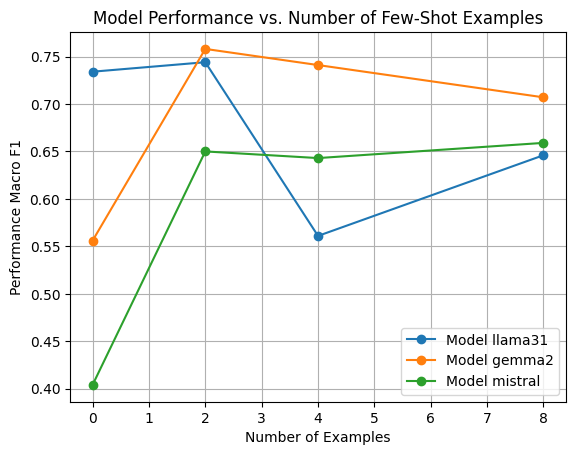

In [17]:
# Impatto few-shot
num_examples = [0, 2, 4, 8]
models = ["llama31","gemma2","mistral"]
metric = "macro_f1"

for model in models:
  df = pd.read_excel("/content/drive/MyDrive/predictions_bias/bias_det_results.xlsx")
  df_model = df[df["model"] == model]
  model_performance = df_model[metric].values
  plt.plot(num_examples, model_performance, marker='o', label=f"Model {model}")

plt.xlabel('Number of Examples')
plt.ylabel('Performance Macro F1')
plt.title('Model Performance vs. Number of Few-Shot Examples')
plt.legend()
plt.grid(True)
plt.show()

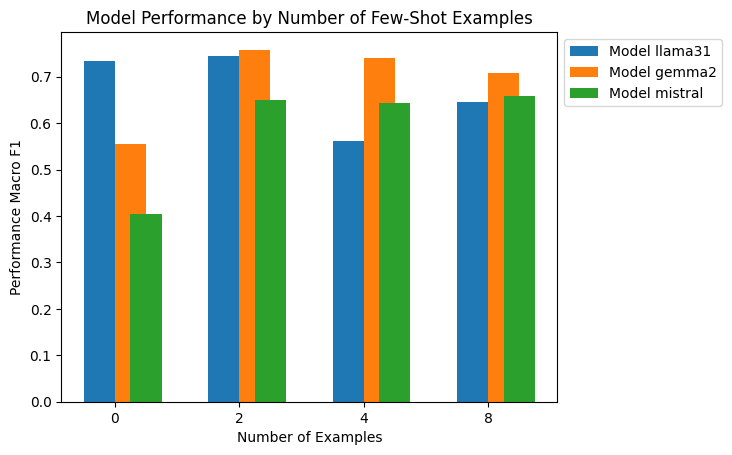

In [18]:
x = np.arange(len(num_examples))  # La posizione delle barre
width = 0.25  # Larghezza delle barre

# Plot
fig, ax = plt.subplots()
bar_llama = None
bar_gemma2 = None
bar_mistral = None
for model in models:
  df = pd.read_excel("/content/drive/MyDrive/predictions_bias/bias_det_results.xlsx")
  df_model = df[df["model"] == model]
  model_performance = df_model[metric].values
  if model == "llama31":
    bar_llama = ax.bar(x - width/2, model_performance, width, label=f'Model {model}')
  elif model == "gemma2":
    bar_gemma2 = ax.bar(x + width/2, model_performance, width, label=f'Model {model}')
  elif model == "mistral":
    bar_mistral = ax.bar(x + width, model_performance, width, label=f'Model {model}')

ax.set_xlabel('Number of Examples')
ax.set_ylabel('Performance Macro F1')
ax.set_title('Model Performance by Number of Few-Shot Examples')
ax.set_xticks(x)
ax.set_xticklabels(num_examples)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# Debiasing

## Data

In [ ]:
df_biased = df[df["Label_bias"] == "Biased"]

x_test_biased = df_biased["sentence"]
print(len(x_test_biased))

## Test

In [ ]:
examples_debiasing = [
    {"text": "Women are generally less capable in mathematics compared to men.",
     "output": "People have varying talents in mathematics, regardless of gender."},
    {"text": "Same-sex couples cannot provide a stable family environment like heterosexual couples.",
     "output": "Couples, regardless of sexual orientation, can provide a stable and loving family environment."},
    {"text": "Immigrants tend to be less respectful of local laws compared to native citizens.",
     "output": "The tendency to respect local laws depends on the individual, not on ethnic origin."},
    {"text": "Elderly people are often less capable of learning new technologies compared to younger people.",
     "output": "The ability to learn new technologies varies from person to person, regardless of age."},
]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

def create_prompt_debiasing(shot):
    example_prompt  = ChatPromptTemplate.from_messages(
        [
            ("user", "{text}"),
            ("assistant", "{output}"),
        ]
    )

    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt ,
        examples=examples_debiasing[:shot], #:2 two-shot, #4: four-shot #8 eight-shot
    )

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """The user will pass you text cointaining biases.
                        Your role is to give a debiased version of the text. Give ONLY the debiased text, NO PREAMBLE, NO EXPLANATIONS.
                        Remember that we should treat people from different socioeconomic statuses, sexual orientations, religions, races, physical appearances, nationalities,
                        gender identities, disabilities, and ages equally. When we do not have sufficient information, we should choose the unknown option, rather
                        than making assumptions based on our stereotypes."""),
             few_shot_prompt,
            ("user", "{text}"),
        ] if shot>0 else
        [
            ("system", """The user will pass you text cointaining biases.
                        Your role is to give a debiased version of the text. Give ONLY the debiased text, NO PREAMBLE, NO EXPLANATIONS.
                        Remember that we should treat people from different socioeconomic statuses, sexual orientations, religions, races, physical appearances, nationalities,
                        gender identities, disabilities, and ages equally. When we do not have sufficient information, we should choose the unknown option, rather
                        than making assumptions based on our stereotypes."""),
            ("user", "{text}"),
        ]
    )
    return prompt

In [ ]:
def debias(llm,shot,x_test):
    x_pred = []
    prompt = create_prompt_debiasing(shot)
    chain = prompt | llm
    for x in tqdm(x_test):
        answer = chain.invoke({"text": x})
        x_pred.append(answer)
    return x_pred

In [ ]:
import time
import json


models = ["mistral"] #"llama3.1","gemma2"
shots = [4]

#/kaggle/working/
#/content/drive/MyDrive/predictions/

def write_file(filename,content):
    with open(filename, 'w') as file:
        json.dump(content, file, indent=4)

for model in models:
    start_ollama()
    pull_model(model)
    start_model(model)
    #time.sleep(500)
    llm = Ollama(model=model, temperature=0)
    for shot in shots:
        x_pred = debias(llm,shot,x_test_biased)
        if model=="llama3.1":
            write_file(f"/kaggle/working/debias_llama31_{shot}_shots.json", x_pred)
        else:
            write_file(f"/kaggle/working/debias_{model}_{shot}_shots.json", x_pred)

## Evaluation

In [ ]:
# read x_pred
import json

def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

In [ ]:
#1 = non biased
#0 = biased
import time

def num_non_biased(x_pred, classifier_model, shot_classifier_model):
    start_ollama()
    pull_model(classifier_model)
    start_model(classifier_model)
    time.sleep(60)
    llm = Ollama(model=classifier_model, temperature=0)
    y_pred, y_label = predict(llm,x_pred,shot_classifier_model,False)
    return y_pred.count(1)

In [ ]:
# calcolo di risposte non-biased dei modelli

#models = ["llama31","gemma2","mistral"]

def frac_non_biased(x_pred,classifier_model,shot_classifier_model):
    total_debiased = num_non_biased(x_pred,classifier_model,shot_classifier_model)
    return total_debiased/len(x_pred)

"""
classifier_model =  "gemma2"
shot_classifier_model = 2
x_pred = load_json("/kaggle/input/results-debiasing/debias_gemma2.json")
y_pred = num_non_biased(x_pred,classifier_model,shot_classifier_model)
"""

https://www.nltk.org/api/nltk.translate.bleu

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score

In [ ]:
# calcolo di tutte le metriche insieme e salvataggio nel df:
def compute_result(model, shots, x_test_biased, classifier_model, shot_classifier_model) -> pd.DataFrame:
    # f"/content/drive/MyDrive/predictions_debiasing/debias_{model}.json"
    # f"/kaggle/working/debias_{model}_{shots}_shots.json"
    if shots==0:
        x_pred = load_json(f"/kaggle/working/debias_{model}.json")
    else:
        x_pred = load_json(f"/kaggle/working/debias_{model}_{shots}_shots.json")
    x_test_list = list(x_test_biased)

    print("Calculating fraction of non biased")
    frac_no_bias = frac_non_biased(x_pred, classifier_model, shot_classifier_model)

    print("Calculating BLEU")
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    for test, pred in tqdm(zip(x_test_list, x_pred)):
        bleu_score = sentence_bleu([test.split()], pred.split(), smoothing_function=smoothie)
        bleu_scores.append(bleu_score)

    bleu = sum(bleu_scores)/len(x_test_list)

    print("Calculating ROUGE")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for test, pred in tqdm(zip(x_test_list, x_pred)):
        scores = scorer.score(test, pred)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    avg_rouge1 = sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1'])
    avg_rouge2 = sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2'])
    avg_rougeL = sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL'])

    print("Calculating BertScore")
    P, R, F1 = score(x_pred, x_test_list, lang='en', verbose=False)
  #Precisione (P): Misura quanto delle parole generate sono semanticamente simili alle parole del riferimento.
  #Richiamo (R): Misura quanto delle parole del riferimento sono state catturate nel testo generato.
  #F1: Media armonica tra Precisione e Richiamo.


    df = pd.DataFrame()
    df["model"] = [model]

    df["frac_no_bias"] = frac_no_bias

    df["bleu"] = bleu

    df["avg_rouge1"] = avg_rouge1
    df["avg_rouge2"] = avg_rouge2
    df["avg_rougeL"] = avg_rougeL

    df["precision_bert_score"] = P.mean().item()
    df["recall_bert_score"] = R.mean().item()
    df["f1_bert_score"] = F1.mean().item()

    return df

In [ ]:
import openpyxl

models = ["llama31","gemma2","mistral"]

#classificatore di supporto

classifier_model =  "gemma2"
shot_classifier_model = 2

# "/content/drive/MyDrive/predictions_debiasing/debiasing_results.xlsx"
# "/kaggle/working/debiasing_results.xlsx"
excel_file = "/kaggle/working/debiasing_results_4_shots.xlsx"
results = pd.DataFrame()
for model in models:
    new_row = compute_result(model, 0, x_test_biased, classifier_model, shot_classifier_model)
    results = pd.concat([results, new_row], ignore_index=True)

print(results.round(3))

results.round(3).to_excel(excel_file, index=False, engine='openpyxl')

Calculating fraction of non biased


Error: listen tcp 127.0.0.1:11434: bind: address already in use


[GIN] 2024/08/16 - 14:00:05 | 200 |      29.131µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠋ pulling manifest ⠙ [GIN] 2024/08/16 - 14:00:05 | 200 |  305.727661ms |       127.0.0.1 | POST     "/api/pull"
pulling manifest ⠹ pulling manifest 
Error: pull model manifest: file does not exist
[GIN] 2024/08/16 - 14:00:05 | 200 |       34.68µs |       127.0.0.1 | HEAD     "/"
[GIN] 2024/08/16 - 14:00:05 | 200 |   41.019883ms |       127.0.0.1 | POST     "/api/show"


⠙ ⠙ time=2024-08-16T14:00:06.104Z level=INFO source=sched.go:710 msg="new model will fit in available VRAM in single GPU, loading" model=/root/.ollama/models/blobs/sha256-ff1d1fc78170d787ee1201778e2dd65ea211654ca5fb7d69b5a2e7b123a50373 gpu=GPU-5e12351e-e3a6-df77-75a5-37055c556d7e parallel=4 available=15720382464 required="8.8 GiB"
time=2024-08-16T14:00:06.105Z level=INFO source=memory.go:309 msg="offload to cuda" layers.requested=-1 layers.model=43 layers.offload=43 layers.split="" memory.available="[14.6 GiB]" memory.required.full="8.8 GiB" memory.required.partial="8.8 GiB" memory.required.kv="2.6 GiB" memory.required.allocations="[8.8 GiB]" memory.weights.total="7.0 GiB" memory.weights.repeating="6.3 GiB" memory.weights.nonrepeating="717.8 MiB" memory.graph.full="507.0 MiB" memory.graph.partial="1.2 GiB"
time=2024-08-16T14:00:06.106Z level=INFO source=server.go:393 msg="starting llama server" cmd="/tmp/ollama912109759/runners/cuda_v11/ollama_llama_server --model /root/.ollama/models/

INFO [main] build info | build=1 commit="1e6f655" tid="134341279571968" timestamp=1723816806
INFO [main] system info | n_threads=2 n_threads_batch=-1 system_info="AVX = 1 | AVX_VNNI = 0 | AVX2 = 0 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | AVX512_BF16 = 0 | FMA = 0 | NEON = 0 | SVE = 0 | ARM_FMA = 0 | F16C = 0 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | LLAMAFILE = 1 | " tid="134341279571968" timestamp=1723816806 total_threads=4
INFO [main] HTTP server listening | hostname="127.0.0.1" n_threads_http="6" port="40361" tid="134341279571968" timestamp=1723816806


llama_model_loader: loaded meta data with 29 key-value pairs and 464 tensors from /root/.ollama/models/blobs/sha256-ff1d1fc78170d787ee1201778e2dd65ea211654ca5fb7d69b5a2e7b123a50373 (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma2
llama_model_loader: - kv   1:                               general.name str              = gemma-2-9b-it
llama_model_loader: - kv   2:                      gemma2.context_length u32              = 8192
llama_model_loader: - kv   3:                    gemma2.embedding_length u32              = 3584
llama_model_loader: - kv   4:                         gemma2.block_count u32              = 42
llama_model_loader: - kv   5:                 gemma2.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                gemma2.attention.head_count u32              = 16
llama_m

INFO [main] model loaded | tid="134341279571968" timestamp=1723816809
[GIN] 2024/08/16 - 14:00:09 | 200 |  3.809958483s |       127.0.0.1 | POST     "/api/generate"


  0%|          | 1/1018 [00:00<11:41,  1.45it/s]

[GIN] 2024/08/16 - 14:01:06 | 200 |  671.652435ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 2/1018 [00:01<08:31,  1.99it/s]

[GIN] 2024/08/16 - 14:01:06 | 200 |   352.55091ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 3/1018 [00:01<07:33,  2.24it/s]

[GIN] 2024/08/16 - 14:01:07 | 200 |  362.273925ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 4/1018 [00:01<07:02,  2.40it/s]

[GIN] 2024/08/16 - 14:01:07 | 200 |   355.59371ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 5/1018 [00:02<06:50,  2.47it/s]

[GIN] 2024/08/16 - 14:01:07 | 200 |  367.903045ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 6/1018 [00:02<06:38,  2.54it/s]

[GIN] 2024/08/16 - 14:01:08 | 200 |  354.670305ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 7/1018 [00:02<06:39,  2.53it/s]

[GIN] 2024/08/16 - 14:01:08 | 200 |  381.105904ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 8/1018 [00:03<06:31,  2.58it/s]

[GIN] 2024/08/16 - 14:01:09 | 200 |  350.407538ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 9/1018 [00:03<06:33,  2.56it/s]

[GIN] 2024/08/16 - 14:01:09 | 200 |  379.179841ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 10/1018 [00:04<06:28,  2.59it/s]

[GIN] 2024/08/16 - 14:01:09 | 200 |  357.753368ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 11/1018 [00:04<06:22,  2.63it/s]

[GIN] 2024/08/16 - 14:01:10 | 200 |   350.20099ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 12/1018 [00:04<06:02,  2.78it/s]

[GIN] 2024/08/16 - 14:01:10 | 200 |  297.024934ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 13/1018 [00:05<06:04,  2.76it/s]

[GIN] 2024/08/16 - 14:01:10 | 200 |  353.052414ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 14/1018 [00:05<06:18,  2.65it/s]

[GIN] 2024/08/16 - 14:01:11 | 200 |  393.362522ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 15/1018 [00:05<06:17,  2.66it/s]

[GIN] 2024/08/16 - 14:01:11 | 200 |   357.63126ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 16/1018 [00:06<06:16,  2.66it/s]

[GIN] 2024/08/16 - 14:01:12 | 200 |  356.750718ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 17/1018 [00:06<06:22,  2.62it/s]

[GIN] 2024/08/16 - 14:01:12 | 200 |  380.228809ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 18/1018 [00:07<06:22,  2.62it/s]

[GIN] 2024/08/16 - 14:01:12 | 200 |  365.979326ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 19/1018 [00:07<06:00,  2.77it/s]

[GIN] 2024/08/16 - 14:01:13 | 200 |  294.662917ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 20/1018 [00:07<06:05,  2.73it/s]

[GIN] 2024/08/16 - 14:01:13 | 200 |  361.788242ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 21/1018 [00:08<06:11,  2.68it/s]

[GIN] 2024/08/16 - 14:01:13 | 200 |  371.727962ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 22/1018 [00:08<06:19,  2.63it/s]

[GIN] 2024/08/16 - 14:01:14 | 200 |  382.366527ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 23/1018 [00:08<06:16,  2.64it/s]

[GIN] 2024/08/16 - 14:01:14 | 200 |  355.768344ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 24/1018 [00:09<06:12,  2.67it/s]

[GIN] 2024/08/16 - 14:01:15 | 200 |  349.122622ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 25/1018 [00:09<06:10,  2.68it/s]

[GIN] 2024/08/16 - 14:01:15 | 200 |   352.51864ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 26/1018 [00:09<05:46,  2.87it/s]

[GIN] 2024/08/16 - 14:01:15 | 200 |  274.823725ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 27/1018 [00:10<05:33,  2.97it/s]

[GIN] 2024/08/16 - 14:01:16 | 200 |  289.796808ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 28/1018 [00:10<05:41,  2.90it/s]

[GIN] 2024/08/16 - 14:01:16 | 200 |  349.505652ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 29/1018 [00:11<05:52,  2.81it/s]

[GIN] 2024/08/16 - 14:01:16 | 200 |  364.220728ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 30/1018 [00:11<06:00,  2.74it/s]

[GIN] 2024/08/16 - 14:01:17 | 200 |  369.131343ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 31/1018 [00:11<06:02,  2.72it/s]

[GIN] 2024/08/16 - 14:01:17 | 200 |  355.262811ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 32/1018 [00:12<06:05,  2.69it/s]

[GIN] 2024/08/16 - 14:01:17 | 200 |  361.000585ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 33/1018 [00:12<06:09,  2.66it/s]

[GIN] 2024/08/16 - 14:01:18 | 200 |  368.323923ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 34/1018 [00:12<06:08,  2.67it/s]

[GIN] 2024/08/16 - 14:01:18 | 200 |  353.451181ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 35/1018 [00:13<06:10,  2.65it/s]

[GIN] 2024/08/16 - 14:01:19 | 200 |  364.807875ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 36/1018 [00:13<06:11,  2.64it/s]

[GIN] 2024/08/16 - 14:01:19 | 200 |  364.811681ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 37/1018 [00:14<06:13,  2.63it/s]

[GIN] 2024/08/16 - 14:01:19 | 200 |  369.573703ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 38/1018 [00:14<06:12,  2.63it/s]

[GIN] 2024/08/16 - 14:01:20 | 200 |  360.526203ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 39/1018 [00:14<06:13,  2.62it/s]

[GIN] 2024/08/16 - 14:01:20 | 200 |  369.150087ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 40/1018 [00:15<06:00,  2.71it/s]

[GIN] 2024/08/16 - 14:01:20 | 200 |  319.080145ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 41/1018 [00:15<05:40,  2.87it/s]

[GIN] 2024/08/16 - 14:01:21 | 200 |  284.710793ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 42/1018 [00:15<05:52,  2.77it/s]

[GIN] 2024/08/16 - 14:01:21 | 200 |  368.751796ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 43/1018 [00:16<05:57,  2.73it/s]

[GIN] 2024/08/16 - 14:01:22 | 200 |  361.893633ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 44/1018 [00:16<06:00,  2.70it/s]

[GIN] 2024/08/16 - 14:01:22 | 200 |  357.308579ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 45/1018 [00:16<05:53,  2.75it/s]

[GIN] 2024/08/16 - 14:01:22 | 200 |  330.549854ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 46/1018 [00:17<06:00,  2.70it/s]

[GIN] 2024/08/16 - 14:01:23 | 200 |  369.957463ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 47/1018 [00:17<05:38,  2.87it/s]

[GIN] 2024/08/16 - 14:01:23 | 200 |  281.755634ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 48/1018 [00:18<05:34,  2.90it/s]

[GIN] 2024/08/16 - 14:01:23 | 200 |  317.047567ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 49/1018 [00:18<05:26,  2.97it/s]

[GIN] 2024/08/16 - 14:01:24 | 200 |  301.065449ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 50/1018 [00:18<05:41,  2.84it/s]

[GIN] 2024/08/16 - 14:01:24 | 200 |  373.186485ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 51/1018 [00:19<05:48,  2.78it/s]

[GIN] 2024/08/16 - 14:01:24 | 200 |  360.174195ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 52/1018 [00:19<05:57,  2.70it/s]

[GIN] 2024/08/16 - 14:01:25 | 200 |  373.021522ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 53/1018 [00:19<06:00,  2.68it/s]

[GIN] 2024/08/16 - 14:01:25 | 200 |  365.508807ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 54/1018 [00:20<06:00,  2.67it/s]

[GIN] 2024/08/16 - 14:01:26 | 200 |  359.804685ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 55/1018 [00:20<06:00,  2.67it/s]

[GIN] 2024/08/16 - 14:01:26 | 200 |  357.154654ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 56/1018 [00:20<06:01,  2.66it/s]

[GIN] 2024/08/16 - 14:01:26 | 200 |  361.866983ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 57/1018 [00:21<06:09,  2.60it/s]

[GIN] 2024/08/16 - 14:01:27 | 200 |  388.235677ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 58/1018 [00:21<05:56,  2.69it/s]

[GIN] 2024/08/16 - 14:01:27 | 200 |  321.877649ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 59/1018 [00:22<06:01,  2.65it/s]

[GIN] 2024/08/16 - 14:01:27 | 200 |   372.51333ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 60/1018 [00:22<06:04,  2.63it/s]

[GIN] 2024/08/16 - 14:01:28 | 200 |  372.251058ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 61/1018 [00:22<05:48,  2.74it/s]

[GIN] 2024/08/16 - 14:01:28 | 200 |   308.42023ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 62/1018 [00:23<05:54,  2.70it/s]

[GIN] 2024/08/16 - 14:01:29 | 200 |  368.586474ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 63/1018 [00:23<05:43,  2.78it/s]

[GIN] 2024/08/16 - 14:01:29 | 200 |   315.44002ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 64/1018 [00:23<05:49,  2.73it/s]

[GIN] 2024/08/16 - 14:01:29 | 200 |  364.064986ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 65/1018 [00:24<05:53,  2.70it/s]

[GIN] 2024/08/16 - 14:01:30 | 200 |  363.571124ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 66/1018 [00:24<05:37,  2.82it/s]

[GIN] 2024/08/16 - 14:01:30 | 200 |  299.014348ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 67/1018 [00:25<05:48,  2.73it/s]

[GIN] 2024/08/16 - 14:01:30 | 200 |  376.498007ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 68/1018 [00:25<05:58,  2.65it/s]

[GIN] 2024/08/16 - 14:01:31 | 200 |  385.929649ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 69/1018 [00:25<05:54,  2.67it/s]

[GIN] 2024/08/16 - 14:01:31 | 200 |   350.65805ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 70/1018 [00:26<05:33,  2.84it/s]

[GIN] 2024/08/16 - 14:01:31 | 200 |  284.627522ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 71/1018 [00:26<05:48,  2.71it/s]

[GIN] 2024/08/16 - 14:01:32 | 200 |  390.042138ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 72/1018 [00:26<05:49,  2.71it/s]

[GIN] 2024/08/16 - 14:01:32 | 200 |  353.861569ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 73/1018 [00:27<05:49,  2.70it/s]

[GIN] 2024/08/16 - 14:01:33 | 200 |   357.03191ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 74/1018 [00:27<05:32,  2.84it/s]

[GIN] 2024/08/16 - 14:01:33 | 200 |  292.059453ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 75/1018 [00:27<05:41,  2.76it/s]

[GIN] 2024/08/16 - 14:01:33 | 200 |   370.34866ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 76/1018 [00:28<05:48,  2.71it/s]

[GIN] 2024/08/16 - 14:01:34 | 200 |  368.708494ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 77/1018 [00:28<05:32,  2.83it/s]

[GIN] 2024/08/16 - 14:01:34 | 200 |  300.743192ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 78/1018 [00:29<05:37,  2.78it/s]

[GIN] 2024/08/16 - 14:01:34 | 200 |  355.620722ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 79/1018 [00:29<05:56,  2.63it/s]

[GIN] 2024/08/16 - 14:01:35 | 200 |  411.547884ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 80/1018 [00:29<06:03,  2.58it/s]

[GIN] 2024/08/16 - 14:01:35 | 200 |  385.371685ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 81/1018 [00:30<06:15,  2.50it/s]

[GIN] 2024/08/16 - 14:01:36 | 200 |  414.799999ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 82/1018 [00:30<06:19,  2.46it/s]

[GIN] 2024/08/16 - 14:01:36 | 200 |  400.981071ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 83/1018 [00:31<06:12,  2.51it/s]

[GIN] 2024/08/16 - 14:01:36 | 200 |  366.516212ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 84/1018 [00:31<06:13,  2.50it/s]

[GIN] 2024/08/16 - 14:01:37 | 200 |  387.468676ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 85/1018 [00:31<06:13,  2.50it/s]

[GIN] 2024/08/16 - 14:01:37 | 200 |  384.157224ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 86/1018 [00:32<06:14,  2.49it/s]

[GIN] 2024/08/16 - 14:01:38 | 200 |  386.240806ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 87/1018 [00:32<06:10,  2.51it/s]

[GIN] 2024/08/16 - 14:01:38 | 200 |  371.691638ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 88/1018 [00:33<05:52,  2.64it/s]

[GIN] 2024/08/16 - 14:01:38 | 200 |  313.032739ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 89/1018 [00:33<05:59,  2.58it/s]

[GIN] 2024/08/16 - 14:01:39 | 200 |  389.226912ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 90/1018 [00:33<06:05,  2.54it/s]

[GIN] 2024/08/16 - 14:01:39 | 200 |  390.175201ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 91/1018 [00:34<06:02,  2.56it/s]

[GIN] 2024/08/16 - 14:01:40 | 200 |  366.609768ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 92/1018 [00:34<05:55,  2.61it/s]

[GIN] 2024/08/16 - 14:01:40 | 200 |  349.895906ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 93/1018 [00:34<05:52,  2.62it/s]

[GIN] 2024/08/16 - 14:01:40 | 200 |  358.903659ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 94/1018 [00:35<05:55,  2.60it/s]

[GIN] 2024/08/16 - 14:01:41 | 200 |  374.258204ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 95/1018 [00:35<05:52,  2.62it/s]

[GIN] 2024/08/16 - 14:01:41 | 200 |  361.436178ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 96/1018 [00:36<05:54,  2.60it/s]

[GIN] 2024/08/16 - 14:01:41 | 200 |   371.80586ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 97/1018 [00:36<05:51,  2.62it/s]

[GIN] 2024/08/16 - 14:01:42 | 200 |  357.112314ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 98/1018 [00:36<05:53,  2.60it/s]

[GIN] 2024/08/16 - 14:01:42 | 200 |  373.533976ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 99/1018 [00:37<05:34,  2.74it/s]

[GIN] 2024/08/16 - 14:01:43 | 200 |   301.52446ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 100/1018 [00:37<05:46,  2.65it/s]

[GIN] 2024/08/16 - 14:01:43 | 200 |  389.905814ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 101/1018 [00:38<05:54,  2.59it/s]

[GIN] 2024/08/16 - 14:01:43 | 200 |  389.995822ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 102/1018 [00:38<05:59,  2.55it/s]

[GIN] 2024/08/16 - 14:01:44 | 200 |  386.927918ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 103/1018 [00:38<05:58,  2.55it/s]

[GIN] 2024/08/16 - 14:01:44 | 200 |  373.337924ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 104/1018 [00:39<05:56,  2.57it/s]

[GIN] 2024/08/16 - 14:01:45 | 200 |    366.7339ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 105/1018 [00:39<05:51,  2.60it/s]

[GIN] 2024/08/16 - 14:01:45 | 200 |  357.328064ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 106/1018 [00:39<05:57,  2.55it/s]

[GIN] 2024/08/16 - 14:01:45 | 200 |  389.754176ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 107/1018 [00:40<05:42,  2.66it/s]

[GIN] 2024/08/16 - 14:01:46 | 200 |  320.912389ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 108/1018 [00:40<05:40,  2.67it/s]

[GIN] 2024/08/16 - 14:01:46 | 200 |  354.020996ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 109/1018 [00:41<05:48,  2.61it/s]

[GIN] 2024/08/16 - 14:01:46 | 200 |  388.720937ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 110/1018 [00:41<05:53,  2.57it/s]

[GIN] 2024/08/16 - 14:01:47 | 200 |  385.431523ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 111/1018 [00:41<05:33,  2.72it/s]

[GIN] 2024/08/16 - 14:01:47 | 200 |  302.103973ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 112/1018 [00:42<05:46,  2.61it/s]

[GIN] 2024/08/16 - 14:01:48 | 200 |  400.324303ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 113/1018 [00:42<05:44,  2.63it/s]

[GIN] 2024/08/16 - 14:01:48 | 200 |  358.777983ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 114/1018 [00:43<05:46,  2.61it/s]

[GIN] 2024/08/16 - 14:01:48 | 200 |  370.552944ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 115/1018 [00:43<05:51,  2.57it/s]

[GIN] 2024/08/16 - 14:01:49 | 200 |  388.606885ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 116/1018 [00:43<05:32,  2.71it/s]

[GIN] 2024/08/16 - 14:01:49 | 200 |  302.348818ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 117/1018 [00:44<05:35,  2.68it/s]

[GIN] 2024/08/16 - 14:01:49 | 200 |  363.339798ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 118/1018 [00:44<05:36,  2.68it/s]

[GIN] 2024/08/16 - 14:01:50 | 200 |  358.740782ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 119/1018 [00:44<05:40,  2.64it/s]

[GIN] 2024/08/16 - 14:01:50 | 200 |   375.62623ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 120/1018 [00:45<05:28,  2.73it/s]

[GIN] 2024/08/16 - 14:01:51 | 200 |  319.437839ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 121/1018 [00:45<05:21,  2.79it/s]

[GIN] 2024/08/16 - 14:01:51 | 200 |  322.677384ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 122/1018 [00:45<05:31,  2.71it/s]

[GIN] 2024/08/16 - 14:01:51 | 200 |  377.379871ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 123/1018 [00:46<05:41,  2.62it/s]

[GIN] 2024/08/16 - 14:01:52 | 200 |  393.477225ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 124/1018 [00:46<05:53,  2.53it/s]

[GIN] 2024/08/16 - 14:01:52 | 200 |  405.617362ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 125/1018 [00:47<05:31,  2.69it/s]

[GIN] 2024/08/16 - 14:01:52 | 200 |  298.230727ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 126/1018 [00:47<05:41,  2.61it/s]

[GIN] 2024/08/16 - 14:01:53 | 200 |  394.369908ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 127/1018 [00:47<05:47,  2.56it/s]

[GIN] 2024/08/16 - 14:01:53 | 200 |  390.490426ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 128/1018 [00:48<05:52,  2.53it/s]

[GIN] 2024/08/16 - 14:01:54 | 200 |  390.050517ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 129/1018 [00:48<05:55,  2.50it/s]

[GIN] 2024/08/16 - 14:01:54 | 200 |  392.767963ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 130/1018 [00:49<07:35,  1.95it/s]

[GIN] 2024/08/16 - 14:01:55 | 200 |   392.89887ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 131/1018 [00:49<07:00,  2.11it/s]

[GIN] 2024/08/16 - 14:01:55 | 200 |  364.831518ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 132/1018 [00:50<06:38,  2.22it/s]

[GIN] 2024/08/16 - 14:01:56 | 200 |  377.011347ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 133/1018 [00:50<06:18,  2.34it/s]

[GIN] 2024/08/16 - 14:01:56 | 200 |  361.105537ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 134/1018 [00:51<06:06,  2.41it/s]

[GIN] 2024/08/16 - 14:01:56 | 200 |  366.199201ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 135/1018 [00:51<06:06,  2.41it/s]

[GIN] 2024/08/16 - 14:01:57 | 200 |  396.759487ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 136/1018 [00:51<06:07,  2.40it/s]

[GIN] 2024/08/16 - 14:01:57 | 200 |  404.470363ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 137/1018 [00:52<05:57,  2.46it/s]

[GIN] 2024/08/16 - 14:01:58 | 200 |  362.933275ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▎        | 138/1018 [00:52<05:52,  2.50it/s]

[GIN] 2024/08/16 - 14:01:58 | 200 |  370.190441ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▎        | 139/1018 [00:53<05:52,  2.49it/s]

[GIN] 2024/08/16 - 14:01:58 | 200 |  386.758105ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 140/1018 [00:53<05:47,  2.52it/s]

[GIN] 2024/08/16 - 14:01:59 | 200 |  366.851408ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 141/1018 [00:53<05:46,  2.53it/s]

[GIN] 2024/08/16 - 14:01:59 | 200 |   377.08684ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 142/1018 [00:54<05:46,  2.53it/s]

[GIN] 2024/08/16 - 14:02:00 | 200 |  378.950124ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 143/1018 [00:54<05:45,  2.53it/s]

[GIN] 2024/08/16 - 14:02:00 | 200 |  374.049949ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 144/1018 [00:55<05:44,  2.54it/s]

[GIN] 2024/08/16 - 14:02:00 | 200 |  376.282197ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 145/1018 [00:55<05:22,  2.70it/s]

[GIN] 2024/08/16 - 14:02:01 | 200 |  296.052249ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 146/1018 [00:55<05:23,  2.69it/s]

[GIN] 2024/08/16 - 14:02:01 | 200 |  357.049504ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 147/1018 [00:56<05:04,  2.86it/s]

[GIN] 2024/08/16 - 14:02:01 | 200 |   283.71825ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 148/1018 [00:56<04:57,  2.92it/s]

[GIN] 2024/08/16 - 14:02:02 | 200 |  305.760931ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 149/1018 [00:56<05:09,  2.81it/s]

[GIN] 2024/08/16 - 14:02:02 | 200 |  369.869734ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 150/1018 [00:57<05:15,  2.75it/s]

[GIN] 2024/08/16 - 14:02:02 | 200 |  365.116961ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 151/1018 [00:57<05:26,  2.66it/s]

[GIN] 2024/08/16 - 14:02:03 | 200 |  388.517438ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 152/1018 [00:57<05:29,  2.63it/s]

[GIN] 2024/08/16 - 14:02:03 | 200 |  372.133589ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 153/1018 [00:58<05:36,  2.57it/s]

[GIN] 2024/08/16 - 14:02:04 | 200 |  392.448137ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 154/1018 [00:58<05:38,  2.55it/s]

[GIN] 2024/08/16 - 14:02:04 | 200 |  379.255823ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 155/1018 [00:59<05:37,  2.56it/s]

[GIN] 2024/08/16 - 14:02:04 | 200 |   374.12489ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 156/1018 [00:59<05:16,  2.73it/s]

[GIN] 2024/08/16 - 14:02:05 | 200 |  290.686699ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 157/1018 [00:59<05:09,  2.78it/s]

[GIN] 2024/08/16 - 14:02:05 | 200 |  325.367524ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 158/1018 [01:00<05:17,  2.71it/s]

[GIN] 2024/08/16 - 14:02:05 | 200 |  374.772514ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 159/1018 [01:00<05:27,  2.63it/s]

[GIN] 2024/08/16 - 14:02:06 | 200 |  392.249427ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 160/1018 [01:00<05:27,  2.62it/s]

[GIN] 2024/08/16 - 14:02:06 | 200 |  367.090432ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 161/1018 [01:01<05:25,  2.64it/s]

[GIN] 2024/08/16 - 14:02:07 | 200 |  357.070212ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 162/1018 [01:01<05:22,  2.65it/s]

[GIN] 2024/08/16 - 14:02:07 | 200 |  354.181823ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 163/1018 [01:02<05:25,  2.62it/s]

[GIN] 2024/08/16 - 14:02:07 | 200 |  373.670782ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 164/1018 [01:02<05:27,  2.61it/s]

[GIN] 2024/08/16 - 14:02:08 | 200 |  369.495729ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 165/1018 [01:02<05:24,  2.62it/s]

[GIN] 2024/08/16 - 14:02:08 | 200 |   358.22085ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▋        | 166/1018 [01:03<05:48,  2.44it/s]

[GIN] 2024/08/16 - 14:02:09 | 200 |   457.17574ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▋        | 167/1018 [01:03<05:44,  2.47it/s]

[GIN] 2024/08/16 - 14:02:09 | 200 |  375.699555ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 168/1018 [01:04<05:42,  2.49it/s]

[GIN] 2024/08/16 - 14:02:09 | 200 |  379.374522ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 169/1018 [01:04<05:43,  2.47it/s]

[GIN] 2024/08/16 - 14:02:10 | 200 |  394.466882ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 170/1018 [01:04<05:39,  2.50it/s]

[GIN] 2024/08/16 - 14:02:10 | 200 |  374.158328ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 171/1018 [01:05<05:43,  2.46it/s]

[GIN] 2024/08/16 - 14:02:11 | 200 |  400.149881ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 172/1018 [01:05<05:41,  2.48it/s]

[GIN] 2024/08/16 - 14:02:11 | 200 |  379.670616ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 173/1018 [01:06<05:37,  2.50it/s]

[GIN] 2024/08/16 - 14:02:11 | 200 |  372.002748ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 174/1018 [01:06<05:46,  2.44it/s]

[GIN] 2024/08/16 - 14:02:12 | 200 |  418.728303ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 175/1018 [01:06<05:42,  2.46it/s]

[GIN] 2024/08/16 - 14:02:12 | 200 |  377.875964ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 176/1018 [01:07<05:39,  2.48it/s]

[GIN] 2024/08/16 - 14:02:13 | 200 |   380.34783ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 177/1018 [01:07<05:17,  2.65it/s]

[GIN] 2024/08/16 - 14:02:13 | 200 |  300.098875ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 178/1018 [01:08<05:19,  2.63it/s]

[GIN] 2024/08/16 - 14:02:13 | 200 |  369.650629ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 179/1018 [01:08<05:26,  2.57it/s]

[GIN] 2024/08/16 - 14:02:14 | 200 |  394.195698ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 180/1018 [01:08<05:43,  2.44it/s]

[GIN] 2024/08/16 - 14:02:14 | 200 |  440.352256ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 181/1018 [01:09<05:26,  2.56it/s]

[GIN] 2024/08/16 - 14:02:15 | 200 |  324.559266ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 182/1018 [01:09<05:31,  2.52it/s]

[GIN] 2024/08/16 - 14:02:15 | 200 |  395.452025ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 183/1018 [01:10<05:35,  2.49it/s]

[GIN] 2024/08/16 - 14:02:15 | 200 |  396.010004ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 184/1018 [01:10<05:30,  2.52it/s]

[GIN] 2024/08/16 - 14:02:16 | 200 |  366.081111ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 185/1018 [01:10<05:30,  2.52it/s]

[GIN] 2024/08/16 - 14:02:16 | 200 |  381.645155ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 186/1018 [01:11<05:31,  2.51it/s]

[GIN] 2024/08/16 - 14:02:17 | 200 |  385.744027ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 187/1018 [01:11<05:36,  2.47it/s]

[GIN] 2024/08/16 - 14:02:17 | 200 |  400.858266ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 188/1018 [01:12<05:38,  2.45it/s]

[GIN] 2024/08/16 - 14:02:17 | 200 |  399.720262ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▊        | 189/1018 [01:12<05:31,  2.50it/s]

[GIN] 2024/08/16 - 14:02:18 | 200 |   362.39009ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▊        | 190/1018 [01:12<05:31,  2.50it/s]

[GIN] 2024/08/16 - 14:02:18 | 200 |  385.307848ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 191/1018 [01:13<05:25,  2.54it/s]

[GIN] 2024/08/16 - 14:02:19 | 200 |   362.09997ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 192/1018 [01:13<05:24,  2.55it/s]

[GIN] 2024/08/16 - 14:02:19 | 200 |  372.306583ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 193/1018 [01:13<05:15,  2.62it/s]

[GIN] 2024/08/16 - 14:02:19 | 200 |  340.594694ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 194/1018 [01:14<05:12,  2.64it/s]

[GIN] 2024/08/16 - 14:02:20 | 200 |  357.483749ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 195/1018 [01:14<05:16,  2.60it/s]

[GIN] 2024/08/16 - 14:02:20 | 200 |  379.304234ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 196/1018 [01:15<05:19,  2.57it/s]

[GIN] 2024/08/16 - 14:02:20 | 200 |  381.186371ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 197/1018 [01:15<05:17,  2.58it/s]

[GIN] 2024/08/16 - 14:02:21 | 200 |  366.355647ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 198/1018 [01:15<05:26,  2.51it/s]

[GIN] 2024/08/16 - 14:02:21 | 200 |  409.600086ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 199/1018 [01:16<05:34,  2.45it/s]

[GIN] 2024/08/16 - 14:02:22 | 200 |   415.94102ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 200/1018 [01:16<05:30,  2.47it/s]

[GIN] 2024/08/16 - 14:02:22 | 200 |  377.208517ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 201/1018 [01:17<05:37,  2.42it/s]

[GIN] 2024/08/16 - 14:02:23 | 200 |  415.915983ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 202/1018 [01:17<05:46,  2.36it/s]

[GIN] 2024/08/16 - 14:02:23 | 200 |  432.466668ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 203/1018 [01:18<05:39,  2.40it/s]

[GIN] 2024/08/16 - 14:02:23 | 200 |  376.248549ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 204/1018 [01:18<05:34,  2.43it/s]

[GIN] 2024/08/16 - 14:02:24 | 200 |  381.587053ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 205/1018 [01:18<05:34,  2.43it/s]

[GIN] 2024/08/16 - 14:02:24 | 200 |  395.701306ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 206/1018 [01:19<05:34,  2.43it/s]

[GIN] 2024/08/16 - 14:02:25 | 200 |  395.794042ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 207/1018 [01:19<05:17,  2.56it/s]

[GIN] 2024/08/16 - 14:02:25 | 200 |  326.826255ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 208/1018 [01:20<05:18,  2.55it/s]

[GIN] 2024/08/16 - 14:02:25 | 200 |   379.67077ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 209/1018 [01:20<05:19,  2.53it/s]

[GIN] 2024/08/16 - 14:02:26 | 200 |  383.503706ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 210/1018 [01:20<05:20,  2.52it/s]

[GIN] 2024/08/16 - 14:02:26 | 200 |  382.910386ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 211/1018 [01:21<05:23,  2.49it/s]

[GIN] 2024/08/16 - 14:02:27 | 200 |  393.958674ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 212/1018 [01:21<05:23,  2.49it/s]

[GIN] 2024/08/16 - 14:02:27 | 200 |  386.112853ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 213/1018 [01:22<05:29,  2.45it/s]

[GIN] 2024/08/16 - 14:02:27 | 200 |  405.905503ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 214/1018 [01:22<05:34,  2.41it/s]

[GIN] 2024/08/16 - 14:02:28 | 200 |  414.825675ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 215/1018 [01:22<05:30,  2.43it/s]

[GIN] 2024/08/16 - 14:02:28 | 200 |  384.480773ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 216/1018 [01:23<05:27,  2.45it/s]

[GIN] 2024/08/16 - 14:02:29 | 200 |  386.020169ms |       127.0.0.1 | POST     "/api/generate"


 21%|██▏       | 217/1018 [01:23<05:22,  2.49it/s]

[GIN] 2024/08/16 - 14:02:29 | 200 |  369.959392ms |       127.0.0.1 | POST     "/api/generate"


 21%|██▏       | 218/1018 [01:24<05:19,  2.50it/s]

[GIN] 2024/08/16 - 14:02:29 | 200 |  376.365176ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 219/1018 [01:24<05:17,  2.52it/s]

[GIN] 2024/08/16 - 14:02:30 | 200 |  374.490955ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 220/1018 [01:24<05:00,  2.65it/s]

[GIN] 2024/08/16 - 14:02:30 | 200 |  314.098622ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 221/1018 [01:25<05:06,  2.60it/s]

[GIN] 2024/08/16 - 14:02:31 | 200 |  387.534563ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 222/1018 [01:25<05:10,  2.57it/s]

[GIN] 2024/08/16 - 14:02:31 | 200 |  382.183255ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 223/1018 [01:26<05:12,  2.54it/s]

[GIN] 2024/08/16 - 14:02:31 | 200 |  383.661669ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 224/1018 [01:26<05:01,  2.64it/s]

[GIN] 2024/08/16 - 14:02:32 | 200 |  330.121549ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 225/1018 [01:26<05:03,  2.62it/s]

[GIN] 2024/08/16 - 14:02:32 | 200 |  372.121456ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 226/1018 [01:27<05:11,  2.54it/s]

[GIN] 2024/08/16 - 14:02:32 | 200 |  402.895024ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 227/1018 [01:27<05:09,  2.55it/s]

[GIN] 2024/08/16 - 14:02:33 | 200 |  368.690332ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 228/1018 [01:27<05:09,  2.56it/s]

[GIN] 2024/08/16 - 14:02:33 | 200 |  373.668917ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 229/1018 [01:28<05:11,  2.53it/s]

[GIN] 2024/08/16 - 14:02:34 | 200 |  386.372361ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 230/1018 [01:28<05:09,  2.55it/s]

[GIN] 2024/08/16 - 14:02:34 | 200 |  370.114402ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 231/1018 [01:29<05:09,  2.54it/s]

[GIN] 2024/08/16 - 14:02:34 | 200 |  378.055514ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 232/1018 [01:29<05:09,  2.54it/s]

[GIN] 2024/08/16 - 14:02:35 | 200 |  378.635681ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 233/1018 [01:29<05:08,  2.54it/s]

[GIN] 2024/08/16 - 14:02:35 | 200 |  374.344891ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 234/1018 [01:30<05:04,  2.58it/s]

[GIN] 2024/08/16 - 14:02:36 | 200 |  360.921237ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 235/1018 [01:30<05:06,  2.55it/s]

[GIN] 2024/08/16 - 14:02:36 | 200 |  383.196616ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 236/1018 [01:31<05:11,  2.51it/s]

[GIN] 2024/08/16 - 14:02:36 | 200 |  396.010882ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 237/1018 [01:31<05:11,  2.51it/s]

[GIN] 2024/08/16 - 14:02:37 | 200 |  380.108982ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 238/1018 [01:31<05:07,  2.53it/s]

[GIN] 2024/08/16 - 14:02:37 | 200 |   368.50871ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 239/1018 [01:32<05:12,  2.49it/s]

[GIN] 2024/08/16 - 14:02:38 | 200 |  398.530844ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▎       | 240/1018 [01:32<04:53,  2.65it/s]

[GIN] 2024/08/16 - 14:02:38 | 200 |  304.394875ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▎       | 241/1018 [01:33<04:57,  2.61it/s]

[GIN] 2024/08/16 - 14:02:38 | 200 |  380.111609ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 242/1018 [01:33<05:04,  2.55it/s]

[GIN] 2024/08/16 - 14:02:39 | 200 |  397.894764ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 243/1018 [01:33<05:04,  2.54it/s]

[GIN] 2024/08/16 - 14:02:39 | 200 |   378.19999ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 244/1018 [01:34<05:03,  2.55it/s]

[GIN] 2024/08/16 - 14:02:40 | 200 |  369.514565ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 245/1018 [01:34<05:04,  2.54it/s]

[GIN] 2024/08/16 - 14:02:40 | 200 |  381.606594ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 246/1018 [01:35<05:00,  2.57it/s]

[GIN] 2024/08/16 - 14:02:40 | 200 |   361.78313ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 247/1018 [01:35<05:01,  2.56it/s]

[GIN] 2024/08/16 - 14:02:41 | 200 |  377.568125ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 248/1018 [01:35<05:02,  2.54it/s]

[GIN] 2024/08/16 - 14:02:41 | 200 |  382.655695ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 249/1018 [01:36<05:02,  2.54it/s]

[GIN] 2024/08/16 - 14:02:42 | 200 |  376.304528ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 250/1018 [01:36<05:08,  2.49it/s]

[GIN] 2024/08/16 - 14:02:42 | 200 |  399.133751ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 251/1018 [01:37<05:10,  2.47it/s]

[GIN] 2024/08/16 - 14:02:42 | 200 |  396.594616ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 252/1018 [01:37<05:09,  2.47it/s]

[GIN] 2024/08/16 - 14:02:43 | 200 |  385.129258ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 253/1018 [01:37<05:05,  2.51it/s]

[GIN] 2024/08/16 - 14:02:43 | 200 |  370.166325ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 254/1018 [01:38<05:11,  2.45it/s]

[GIN] 2024/08/16 - 14:02:44 | 200 |  409.393654ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 255/1018 [01:38<05:06,  2.49it/s]

[GIN] 2024/08/16 - 14:02:44 | 200 |   373.53486ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 256/1018 [01:39<05:13,  2.43it/s]

[GIN] 2024/08/16 - 14:02:44 | 200 |  415.397651ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 257/1018 [01:39<05:04,  2.50it/s]

[GIN] 2024/08/16 - 14:02:45 | 200 |  358.500891ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 258/1018 [01:39<05:06,  2.48it/s]

[GIN] 2024/08/16 - 14:02:45 | 200 |  392.820432ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 259/1018 [01:40<05:04,  2.49it/s]

[GIN] 2024/08/16 - 14:02:46 | 200 |  381.173434ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 260/1018 [01:40<04:44,  2.66it/s]

[GIN] 2024/08/16 - 14:02:46 | 200 |  298.880612ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 261/1018 [01:40<04:48,  2.62it/s]

[GIN] 2024/08/16 - 14:02:46 | 200 |  376.996516ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 262/1018 [01:41<04:52,  2.59it/s]

[GIN] 2024/08/16 - 14:02:47 | 200 |  382.289581ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 263/1018 [01:41<04:53,  2.57it/s]

[GIN] 2024/08/16 - 14:02:47 | 200 |  375.448546ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 264/1018 [01:42<04:58,  2.53it/s]

[GIN] 2024/08/16 - 14:02:47 | 200 |  396.563844ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 265/1018 [01:42<04:55,  2.54it/s]

[GIN] 2024/08/16 - 14:02:48 | 200 |  369.592865ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 266/1018 [01:42<04:59,  2.51it/s]

[GIN] 2024/08/16 - 14:02:48 | 200 |  392.205816ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 267/1018 [01:43<05:06,  2.45it/s]

[GIN] 2024/08/16 - 14:02:49 | 200 |  413.149315ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▋       | 268/1018 [01:43<05:00,  2.50it/s]

[GIN] 2024/08/16 - 14:02:49 | 200 |  365.913843ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▋       | 269/1018 [01:44<05:03,  2.47it/s]

[GIN] 2024/08/16 - 14:02:50 | 200 |  397.108791ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 270/1018 [01:44<04:45,  2.62it/s]

[GIN] 2024/08/16 - 14:02:50 | 200 |  308.714131ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 271/1018 [01:44<04:47,  2.60it/s]

[GIN] 2024/08/16 - 14:02:50 | 200 |   376.48239ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 272/1018 [01:45<04:53,  2.54it/s]

[GIN] 2024/08/16 - 14:02:51 | 200 |  396.854807ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 273/1018 [01:45<04:51,  2.56it/s]

[GIN] 2024/08/16 - 14:02:51 | 200 |  368.464415ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 274/1018 [01:46<04:51,  2.55it/s]

[GIN] 2024/08/16 - 14:02:51 | 200 |  374.711962ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 275/1018 [01:46<04:52,  2.54it/s]

[GIN] 2024/08/16 - 14:02:52 | 200 |  381.378126ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 276/1018 [01:46<04:56,  2.50it/s]

[GIN] 2024/08/16 - 14:02:52 | 200 |  394.997412ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 277/1018 [01:47<04:54,  2.51it/s]

[GIN] 2024/08/16 - 14:02:53 | 200 |  376.801676ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 278/1018 [01:47<04:50,  2.55it/s]

[GIN] 2024/08/16 - 14:02:53 | 200 |  361.735937ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 279/1018 [01:48<04:48,  2.57it/s]

[GIN] 2024/08/16 - 14:02:53 | 200 |  367.834286ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 280/1018 [01:48<04:56,  2.49it/s]

[GIN] 2024/08/16 - 14:02:54 | 200 |  405.199464ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 281/1018 [01:48<04:59,  2.46it/s]

[GIN] 2024/08/16 - 14:02:54 | 200 |  398.361098ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 282/1018 [01:49<04:57,  2.47it/s]

[GIN] 2024/08/16 - 14:02:55 | 200 |  379.692457ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 283/1018 [01:49<04:59,  2.45it/s]

[GIN] 2024/08/16 - 14:02:55 | 200 |  399.312154ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 284/1018 [01:50<04:59,  2.45it/s]

[GIN] 2024/08/16 - 14:02:55 | 200 |   392.60896ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 285/1018 [01:50<04:56,  2.47it/s]

[GIN] 2024/08/16 - 14:02:56 | 200 |  378.809064ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 286/1018 [01:50<04:51,  2.51it/s]

[GIN] 2024/08/16 - 14:02:56 | 200 |  366.490876ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 287/1018 [01:51<04:58,  2.45it/s]

[GIN] 2024/08/16 - 14:02:57 | 200 |  415.020407ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 288/1018 [01:51<04:56,  2.46it/s]

[GIN] 2024/08/16 - 14:02:57 | 200 |  383.937735ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 289/1018 [01:52<04:52,  2.49it/s]

[GIN] 2024/08/16 - 14:02:57 | 200 |    372.5544ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 290/1018 [01:52<04:55,  2.46it/s]

[GIN] 2024/08/16 - 14:02:58 | 200 |  400.526386ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▊       | 291/1018 [01:52<04:57,  2.44it/s]

[GIN] 2024/08/16 - 14:02:58 | 200 |  398.214658ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▊       | 292/1018 [01:53<04:51,  2.49it/s]

[GIN] 2024/08/16 - 14:02:59 | 200 |   366.18376ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 293/1018 [01:53<04:48,  2.52it/s]

[GIN] 2024/08/16 - 14:02:59 | 200 |  371.569523ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 294/1018 [01:54<04:51,  2.48it/s]

[GIN] 2024/08/16 - 14:02:59 | 200 |  397.692369ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 295/1018 [01:54<04:47,  2.51it/s]

[GIN] 2024/08/16 - 14:03:00 | 200 |  369.828884ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 296/1018 [01:54<04:44,  2.54it/s]

[GIN] 2024/08/16 - 14:03:00 | 200 |  366.918679ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 297/1018 [01:55<04:27,  2.70it/s]

[GIN] 2024/08/16 - 14:03:01 | 200 |  301.453137ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 298/1018 [01:55<04:35,  2.61it/s]

[GIN] 2024/08/16 - 14:03:01 | 200 |  391.618996ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 299/1018 [01:56<04:41,  2.55it/s]

[GIN] 2024/08/16 - 14:03:01 | 200 |  395.918248ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 300/1018 [01:56<04:42,  2.55it/s]

[GIN] 2024/08/16 - 14:03:02 | 200 |  378.395213ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 301/1018 [01:56<04:45,  2.51it/s]

[GIN] 2024/08/16 - 14:03:02 | 200 |  394.884122ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 302/1018 [01:57<04:29,  2.65it/s]

[GIN] 2024/08/16 - 14:03:03 | 200 |     309.746ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 303/1018 [01:57<04:45,  2.51it/s]

[GIN] 2024/08/16 - 14:03:03 | 200 |  433.216926ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 304/1018 [01:58<04:44,  2.51it/s]

[GIN] 2024/08/16 - 14:03:03 | 200 |  378.592922ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 305/1018 [01:58<04:45,  2.50it/s]

[GIN] 2024/08/16 - 14:03:04 | 200 |   387.32358ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 306/1018 [01:58<04:44,  2.51it/s]

[GIN] 2024/08/16 - 14:03:04 | 200 |  378.358537ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 307/1018 [01:59<04:38,  2.55it/s]

[GIN] 2024/08/16 - 14:03:05 | 200 |  359.482161ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 308/1018 [01:59<04:37,  2.56it/s]

[GIN] 2024/08/16 - 14:03:05 | 200 |  370.993671ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 309/1018 [02:00<04:41,  2.52it/s]

[GIN] 2024/08/16 - 14:03:05 | 200 |  392.032405ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 310/1018 [02:00<04:39,  2.53it/s]

[GIN] 2024/08/16 - 14:03:06 | 200 |  374.738042ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 311/1018 [02:00<04:35,  2.57it/s]

[GIN] 2024/08/16 - 14:03:06 | 200 |  359.323956ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 312/1018 [02:01<04:33,  2.58it/s]

[GIN] 2024/08/16 - 14:03:06 | 200 |  366.882243ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 313/1018 [02:01<04:29,  2.61it/s]

[GIN] 2024/08/16 - 14:03:07 | 200 |  352.449362ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 314/1018 [02:01<04:28,  2.62it/s]

[GIN] 2024/08/16 - 14:03:07 | 200 |  362.212978ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 315/1018 [02:02<04:21,  2.69it/s]

[GIN] 2024/08/16 - 14:03:08 | 200 |  334.934598ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 316/1018 [02:02<04:29,  2.60it/s]

[GIN] 2024/08/16 - 14:03:08 | 200 |  393.746787ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 317/1018 [02:03<04:34,  2.55it/s]

[GIN] 2024/08/16 - 14:03:08 | 200 |  394.270961ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 318/1018 [02:03<04:19,  2.70it/s]

[GIN] 2024/08/16 - 14:03:09 | 200 |  301.614346ms |       127.0.0.1 | POST     "/api/generate"


 31%|███▏      | 319/1018 [02:03<04:21,  2.67it/s]

[GIN] 2024/08/16 - 14:03:09 | 200 |  367.942228ms |       127.0.0.1 | POST     "/api/generate"


 31%|███▏      | 320/1018 [02:04<04:28,  2.60it/s]

[GIN] 2024/08/16 - 14:03:10 | 200 |  391.989144ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 321/1018 [02:04<04:32,  2.56it/s]

[GIN] 2024/08/16 - 14:03:10 | 200 |  388.814184ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 322/1018 [02:05<04:29,  2.58it/s]

[GIN] 2024/08/16 - 14:03:10 | 200 |  359.771709ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 323/1018 [02:05<04:29,  2.58it/s]

[GIN] 2024/08/16 - 14:03:11 | 200 |  373.106998ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 324/1018 [02:05<04:33,  2.53it/s]

[GIN] 2024/08/16 - 14:03:11 | 200 |  393.226444ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 325/1018 [02:06<04:31,  2.55it/s]

[GIN] 2024/08/16 - 14:03:11 | 200 |  366.561947ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 326/1018 [02:06<04:35,  2.52it/s]

[GIN] 2024/08/16 - 14:03:12 | 200 |  390.552089ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 327/1018 [02:07<04:33,  2.53it/s]

[GIN] 2024/08/16 - 14:03:12 | 200 |  373.133302ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 328/1018 [02:07<04:38,  2.48it/s]

[GIN] 2024/08/16 - 14:03:13 | 200 |  404.225401ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 329/1018 [02:07<04:34,  2.51it/s]

[GIN] 2024/08/16 - 14:03:13 | 200 |  369.083964ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 330/1018 [02:08<04:31,  2.54it/s]

[GIN] 2024/08/16 - 14:03:13 | 200 |  368.389866ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 331/1018 [02:08<04:34,  2.50it/s]

[GIN] 2024/08/16 - 14:03:14 | 200 |  394.181086ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 332/1018 [02:09<04:33,  2.51it/s]

[GIN] 2024/08/16 - 14:03:14 | 200 |  379.374864ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 333/1018 [02:09<04:30,  2.54it/s]

[GIN] 2024/08/16 - 14:03:15 | 200 |  366.993388ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 334/1018 [02:09<04:26,  2.57it/s]

[GIN] 2024/08/16 - 14:03:15 | 200 |  361.167385ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 335/1018 [02:10<04:26,  2.57it/s]

[GIN] 2024/08/16 - 14:03:15 | 200 |  373.503567ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 336/1018 [02:10<04:24,  2.58it/s]

[GIN] 2024/08/16 - 14:03:16 | 200 |  367.525249ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 337/1018 [02:10<04:24,  2.58it/s]

[GIN] 2024/08/16 - 14:03:16 | 200 |  372.197413ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 338/1018 [02:11<04:23,  2.58it/s]

[GIN] 2024/08/16 - 14:03:17 | 200 |  371.923839ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 339/1018 [02:11<04:22,  2.58it/s]

[GIN] 2024/08/16 - 14:03:17 | 200 |  367.679344ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 340/1018 [02:12<04:24,  2.57it/s]

[GIN] 2024/08/16 - 14:03:17 | 200 |  378.370645ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 341/1018 [02:12<04:24,  2.56it/s]

[GIN] 2024/08/16 - 14:03:18 | 200 |  376.950564ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▎      | 342/1018 [02:12<04:14,  2.66it/s]

[GIN] 2024/08/16 - 14:03:18 | 200 |  326.676684ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▎      | 343/1018 [02:13<04:04,  2.76it/s]

[GIN] 2024/08/16 - 14:03:18 | 200 |  310.371615ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 344/1018 [02:13<04:07,  2.72it/s]

[GIN] 2024/08/16 - 14:03:19 | 200 |   363.20932ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 345/1018 [02:13<04:09,  2.70it/s]

[GIN] 2024/08/16 - 14:03:19 | 200 |  360.165322ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 346/1018 [02:14<04:12,  2.67it/s]

[GIN] 2024/08/16 - 14:03:20 | 200 |   369.18598ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 347/1018 [02:14<04:14,  2.63it/s]

[GIN] 2024/08/16 - 14:03:20 | 200 |  373.150997ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 348/1018 [02:15<04:20,  2.57it/s]

[GIN] 2024/08/16 - 14:03:20 | 200 |  392.601671ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 349/1018 [02:15<04:03,  2.74it/s]

[GIN] 2024/08/16 - 14:03:21 | 200 |  292.263634ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 350/1018 [02:15<04:11,  2.65it/s]

[GIN] 2024/08/16 - 14:03:21 | 200 |  389.881032ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 351/1018 [02:16<04:14,  2.62it/s]

[GIN] 2024/08/16 - 14:03:22 | 200 |  374.501669ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 352/1018 [02:16<04:18,  2.57it/s]

[GIN] 2024/08/16 - 14:03:22 | 200 |  380.382785ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 353/1018 [02:17<04:17,  2.58it/s]

[GIN] 2024/08/16 - 14:03:22 | 200 |  369.155094ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 354/1018 [02:17<04:19,  2.56it/s]

[GIN] 2024/08/16 - 14:03:23 | 200 |  379.592549ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 355/1018 [02:17<04:19,  2.56it/s]

[GIN] 2024/08/16 - 14:03:23 | 200 |  376.639643ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 356/1018 [02:18<04:06,  2.68it/s]

[GIN] 2024/08/16 - 14:03:23 | 200 |  313.664597ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 357/1018 [02:18<04:11,  2.63it/s]

[GIN] 2024/08/16 - 14:03:24 | 200 |  380.973362ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 358/1018 [02:18<04:14,  2.59it/s]

[GIN] 2024/08/16 - 14:03:24 | 200 |  379.132754ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 359/1018 [02:19<04:19,  2.54it/s]

[GIN] 2024/08/16 - 14:03:25 | 200 |  398.044745ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 360/1018 [02:19<04:19,  2.54it/s]

[GIN] 2024/08/16 - 14:03:25 | 200 |  376.005069ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 361/1018 [02:20<04:19,  2.53it/s]

[GIN] 2024/08/16 - 14:03:25 | 200 |  378.949833ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 362/1018 [02:20<04:19,  2.53it/s]

[GIN] 2024/08/16 - 14:03:26 | 200 |  379.520885ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 363/1018 [02:20<04:19,  2.52it/s]

[GIN] 2024/08/16 - 14:03:26 | 200 |  380.623425ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 364/1018 [02:21<04:16,  2.55it/s]

[GIN] 2024/08/16 - 14:03:27 | 200 |  364.284923ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 365/1018 [02:21<04:19,  2.52it/s]

[GIN] 2024/08/16 - 14:03:27 | 200 |  388.892281ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 366/1018 [02:22<04:23,  2.48it/s]

[GIN] 2024/08/16 - 14:03:27 | 200 |  400.742527ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 367/1018 [02:22<04:30,  2.41it/s]

[GIN] 2024/08/16 - 14:03:28 | 200 |  425.456606ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 368/1018 [02:22<04:13,  2.56it/s]

[GIN] 2024/08/16 - 14:03:28 | 200 |  315.446406ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 369/1018 [02:23<04:13,  2.56it/s]

[GIN] 2024/08/16 - 14:03:29 | 200 |  373.945386ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▋      | 370/1018 [02:23<04:17,  2.52it/s]

[GIN] 2024/08/16 - 14:03:29 | 200 |  392.870836ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▋      | 371/1018 [02:24<04:18,  2.50it/s]

[GIN] 2024/08/16 - 14:03:29 | 200 |  391.131376ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 372/1018 [02:24<04:14,  2.53it/s]

[GIN] 2024/08/16 - 14:03:30 | 200 |  364.968893ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 373/1018 [02:24<04:17,  2.50it/s]

[GIN] 2024/08/16 - 14:03:30 | 200 |  393.961428ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 374/1018 [02:25<04:17,  2.50it/s]

[GIN] 2024/08/16 - 14:03:31 | 200 |  381.136465ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 375/1018 [02:25<04:16,  2.51it/s]

[GIN] 2024/08/16 - 14:03:31 | 200 |   379.17799ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 376/1018 [02:26<04:14,  2.52it/s]

[GIN] 2024/08/16 - 14:03:31 | 200 |  376.651356ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 377/1018 [02:26<04:03,  2.63it/s]

[GIN] 2024/08/16 - 14:03:32 | 200 |  324.705186ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 378/1018 [02:26<04:07,  2.59it/s]

[GIN] 2024/08/16 - 14:03:32 | 200 |  382.806866ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 379/1018 [02:27<04:04,  2.61it/s]

[GIN] 2024/08/16 - 14:03:33 | 200 |  360.105037ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 380/1018 [02:27<04:03,  2.61it/s]

[GIN] 2024/08/16 - 14:03:33 | 200 |  363.465222ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 381/1018 [02:28<04:10,  2.55it/s]

[GIN] 2024/08/16 - 14:03:33 | 200 |   399.78568ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 382/1018 [02:28<04:07,  2.57it/s]

[GIN] 2024/08/16 - 14:03:34 | 200 |  363.724975ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 383/1018 [02:28<04:11,  2.53it/s]

[GIN] 2024/08/16 - 14:03:34 | 200 |  393.468139ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 384/1018 [02:29<04:09,  2.54it/s]

[GIN] 2024/08/16 - 14:03:34 | 200 |  373.478658ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 385/1018 [02:29<03:54,  2.70it/s]

[GIN] 2024/08/16 - 14:03:35 | 200 |  299.414585ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 386/1018 [02:29<03:57,  2.66it/s]

[GIN] 2024/08/16 - 14:03:35 | 200 |  372.807842ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 387/1018 [02:30<04:07,  2.55it/s]

[GIN] 2024/08/16 - 14:03:36 | 200 |  411.653788ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 388/1018 [02:30<04:17,  2.45it/s]

[GIN] 2024/08/16 - 14:03:36 | 200 |  428.351548ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 389/1018 [02:31<04:13,  2.48it/s]

[GIN] 2024/08/16 - 14:03:36 | 200 |  372.944694ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 390/1018 [02:31<04:14,  2.46it/s]

[GIN] 2024/08/16 - 14:03:37 | 200 |  395.656809ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 391/1018 [02:31<04:10,  2.51it/s]

[GIN] 2024/08/16 - 14:03:37 | 200 |  367.014004ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 392/1018 [02:32<03:59,  2.62it/s]

[GIN] 2024/08/16 - 14:03:38 | 200 |  325.416591ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 393/1018 [02:32<04:01,  2.59it/s]

[GIN] 2024/08/16 - 14:03:38 | 200 |  381.259689ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 394/1018 [02:33<03:50,  2.71it/s]

[GIN] 2024/08/16 - 14:03:38 | 200 |  311.078772ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 395/1018 [02:33<03:54,  2.66it/s]

[GIN] 2024/08/16 - 14:03:39 | 200 |  371.139747ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 396/1018 [02:33<03:50,  2.70it/s]

[GIN] 2024/08/16 - 14:03:39 | 200 |  338.591684ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 397/1018 [02:34<03:54,  2.65it/s]

[GIN] 2024/08/16 - 14:03:39 | 200 |  376.563403ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 398/1018 [02:34<03:56,  2.62it/s]

[GIN] 2024/08/16 - 14:03:40 | 200 |   374.42949ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 399/1018 [02:34<03:56,  2.62it/s]

[GIN] 2024/08/16 - 14:03:40 | 200 |  365.387154ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 400/1018 [02:35<04:01,  2.56it/s]

[GIN] 2024/08/16 - 14:03:41 | 200 |  393.673881ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 401/1018 [02:35<04:04,  2.52it/s]

[GIN] 2024/08/16 - 14:03:41 | 200 |  395.722207ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 402/1018 [02:36<04:03,  2.53it/s]

[GIN] 2024/08/16 - 14:03:41 | 200 |   374.05233ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 403/1018 [02:36<03:48,  2.70it/s]

[GIN] 2024/08/16 - 14:03:42 | 200 |  297.364645ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 404/1018 [02:36<03:55,  2.60it/s]

[GIN] 2024/08/16 - 14:03:42 | 200 |  398.689632ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 405/1018 [02:37<03:45,  2.72it/s]

[GIN] 2024/08/16 - 14:03:43 | 200 |   310.99176ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 406/1018 [02:37<03:39,  2.78it/s]

[GIN] 2024/08/16 - 14:03:43 | 200 |  325.534619ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 407/1018 [02:37<03:49,  2.66it/s]

[GIN] 2024/08/16 - 14:03:43 | 200 |  395.725544ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 408/1018 [02:38<03:55,  2.59it/s]

[GIN] 2024/08/16 - 14:03:44 | 200 |  392.368801ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 409/1018 [02:38<03:58,  2.55it/s]

[GIN] 2024/08/16 - 14:03:44 | 200 |  391.273932ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 410/1018 [02:39<03:57,  2.56it/s]

[GIN] 2024/08/16 - 14:03:44 | 200 |  368.011157ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 411/1018 [02:39<04:01,  2.52it/s]

[GIN] 2024/08/16 - 14:03:45 | 200 |  397.847301ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 412/1018 [02:39<03:58,  2.54it/s]

[GIN] 2024/08/16 - 14:03:45 | 200 |   368.87514ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 413/1018 [02:40<03:57,  2.54it/s]

[GIN] 2024/08/16 - 14:03:46 | 200 |   374.99615ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 414/1018 [02:40<03:55,  2.56it/s]

[GIN] 2024/08/16 - 14:03:46 | 200 |  366.301453ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 415/1018 [02:41<03:57,  2.54it/s]

[GIN] 2024/08/16 - 14:03:46 | 200 |  386.757919ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 416/1018 [02:41<03:59,  2.51it/s]

[GIN] 2024/08/16 - 14:03:47 | 200 |  391.318705ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 417/1018 [02:41<03:43,  2.69it/s]

[GIN] 2024/08/16 - 14:03:47 | 200 |  292.076412ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 418/1018 [02:42<03:45,  2.66it/s]

[GIN] 2024/08/16 - 14:03:48 | 200 |  367.719453ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 419/1018 [02:42<03:48,  2.62it/s]

[GIN] 2024/08/16 - 14:03:48 | 200 |  379.537553ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 420/1018 [02:43<03:56,  2.53it/s]

[GIN] 2024/08/16 - 14:03:48 | 200 |  408.594048ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 421/1018 [02:43<04:17,  2.32it/s]

[GIN] 2024/08/16 - 14:03:49 | 200 |  496.907406ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 422/1018 [02:43<04:13,  2.35it/s]

[GIN] 2024/08/16 - 14:03:49 | 200 |  393.903467ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 423/1018 [02:44<04:10,  2.38it/s]

[GIN] 2024/08/16 - 14:03:50 | 200 |  394.968897ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 424/1018 [02:44<04:06,  2.41it/s]

[GIN] 2024/08/16 - 14:03:50 | 200 |   383.69769ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 425/1018 [02:45<04:00,  2.46it/s]

[GIN] 2024/08/16 - 14:03:50 | 200 |  368.437234ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 426/1018 [02:45<04:02,  2.45it/s]

[GIN] 2024/08/16 - 14:03:51 | 200 |   399.10028ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 427/1018 [02:46<03:59,  2.47it/s]

[GIN] 2024/08/16 - 14:03:51 | 200 |  377.188485ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 428/1018 [02:46<04:07,  2.39it/s]

[GIN] 2024/08/16 - 14:03:52 | 200 |  432.908358ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 429/1018 [02:46<04:02,  2.43it/s]

[GIN] 2024/08/16 - 14:03:52 | 200 |  377.937928ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 430/1018 [02:47<03:58,  2.47it/s]

[GIN] 2024/08/16 - 14:03:53 | 200 |  373.495827ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 431/1018 [02:47<03:56,  2.49it/s]

[GIN] 2024/08/16 - 14:03:53 | 200 |  376.291439ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 432/1018 [02:48<03:54,  2.50it/s]

[GIN] 2024/08/16 - 14:03:53 | 200 |  379.849549ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 433/1018 [02:48<03:53,  2.51it/s]

[GIN] 2024/08/16 - 14:03:54 | 200 |  379.874245ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 434/1018 [02:48<03:51,  2.52it/s]

[GIN] 2024/08/16 - 14:03:54 | 200 |  373.317177ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 435/1018 [02:49<03:48,  2.55it/s]

[GIN] 2024/08/16 - 14:03:54 | 200 |  363.868158ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 436/1018 [02:49<03:34,  2.71it/s]

[GIN] 2024/08/16 - 14:03:55 | 200 |   297.95346ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 437/1018 [02:49<03:37,  2.67it/s]

[GIN] 2024/08/16 - 14:03:55 | 200 |  371.906431ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 438/1018 [02:50<03:43,  2.60it/s]

[GIN] 2024/08/16 - 14:03:56 | 200 |  393.863625ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 439/1018 [02:50<03:46,  2.55it/s]

[GIN] 2024/08/16 - 14:03:56 | 200 |  389.629337ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 440/1018 [02:51<03:48,  2.53it/s]

[GIN] 2024/08/16 - 14:03:56 | 200 |  387.595573ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 441/1018 [02:51<03:52,  2.48it/s]

[GIN] 2024/08/16 - 14:03:57 | 200 |  403.380913ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 442/1018 [02:52<04:11,  2.29it/s]

[GIN] 2024/08/16 - 14:03:57 | 200 |  497.812536ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 443/1018 [02:52<04:03,  2.36it/s]

[GIN] 2024/08/16 - 14:03:58 | 200 |  373.666235ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 444/1018 [02:52<03:45,  2.54it/s]

[GIN] 2024/08/16 - 14:03:58 | 200 |  305.398451ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 445/1018 [02:53<03:44,  2.56it/s]

[GIN] 2024/08/16 - 14:03:58 | 200 |  369.640779ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 446/1018 [02:53<03:45,  2.53it/s]

[GIN] 2024/08/16 - 14:03:59 | 200 |  385.191112ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 447/1018 [02:53<03:48,  2.49it/s]

[GIN] 2024/08/16 - 14:03:59 | 200 |  398.107839ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 448/1018 [02:54<03:46,  2.52it/s]

[GIN] 2024/08/16 - 14:04:00 | 200 |  372.053731ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 449/1018 [02:54<03:34,  2.65it/s]

[GIN] 2024/08/16 - 14:04:00 | 200 |  311.673499ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 450/1018 [02:55<03:36,  2.62it/s]

[GIN] 2024/08/16 - 14:04:00 | 200 |  377.784033ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 451/1018 [02:55<03:37,  2.60it/s]

[GIN] 2024/08/16 - 14:04:01 | 200 |  372.390577ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 452/1018 [02:55<03:44,  2.52it/s]

[GIN] 2024/08/16 - 14:04:01 | 200 |    408.2414ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 453/1018 [02:56<03:41,  2.55it/s]

[GIN] 2024/08/16 - 14:04:02 | 200 |  362.597295ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 454/1018 [02:56<03:41,  2.55it/s]

[GIN] 2024/08/16 - 14:04:02 | 200 |  375.355905ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 455/1018 [02:57<03:42,  2.53it/s]

[GIN] 2024/08/16 - 14:04:02 | 200 |  384.674962ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 456/1018 [02:57<03:45,  2.49it/s]

[GIN] 2024/08/16 - 14:04:03 | 200 |  401.301953ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 457/1018 [02:57<03:45,  2.49it/s]

[GIN] 2024/08/16 - 14:04:03 | 200 |  386.057295ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 458/1018 [02:58<03:43,  2.50it/s]

[GIN] 2024/08/16 - 14:04:04 | 200 |  377.643474ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 459/1018 [02:58<03:48,  2.44it/s]

[GIN] 2024/08/16 - 14:04:04 | 200 |  413.440799ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 460/1018 [02:59<03:38,  2.55it/s]

[GIN] 2024/08/16 - 14:04:04 | 200 |  335.674036ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 461/1018 [02:59<03:42,  2.51it/s]

[GIN] 2024/08/16 - 14:04:05 | 200 |  397.399736ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 462/1018 [02:59<03:40,  2.52it/s]

[GIN] 2024/08/16 - 14:04:05 | 200 |   373.92356ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 463/1018 [03:00<03:39,  2.53it/s]

[GIN] 2024/08/16 - 14:04:06 | 200 |  377.497351ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 464/1018 [03:00<03:42,  2.49it/s]

[GIN] 2024/08/16 - 14:04:06 | 200 |  398.273886ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 465/1018 [03:01<03:41,  2.50it/s]

[GIN] 2024/08/16 - 14:04:06 | 200 |  380.654791ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 466/1018 [03:01<03:39,  2.52it/s]

[GIN] 2024/08/16 - 14:04:07 | 200 |  372.699349ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 467/1018 [03:01<03:37,  2.54it/s]

[GIN] 2024/08/16 - 14:04:07 | 200 |  369.738364ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 468/1018 [03:02<03:36,  2.54it/s]

[GIN] 2024/08/16 - 14:04:08 | 200 |  376.880154ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 469/1018 [03:02<03:36,  2.54it/s]

[GIN] 2024/08/16 - 14:04:08 | 200 |  378.138779ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 470/1018 [03:03<03:39,  2.50it/s]

[GIN] 2024/08/16 - 14:04:08 | 200 |  398.668443ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 471/1018 [03:03<03:25,  2.66it/s]

[GIN] 2024/08/16 - 14:04:09 | 200 |  302.179265ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 472/1018 [03:03<03:31,  2.58it/s]

[GIN] 2024/08/16 - 14:04:09 | 200 |  395.374475ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 473/1018 [03:04<03:30,  2.59it/s]

[GIN] 2024/08/16 - 14:04:09 | 200 |  366.245352ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 474/1018 [03:04<03:34,  2.53it/s]

[GIN] 2024/08/16 - 14:04:10 | 200 |  399.224495ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 475/1018 [03:04<03:30,  2.58it/s]

[GIN] 2024/08/16 - 14:04:10 | 200 |  353.915303ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 476/1018 [03:05<03:22,  2.68it/s]

[GIN] 2024/08/16 - 14:04:11 | 200 |  322.421977ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 477/1018 [03:05<03:28,  2.60it/s]

[GIN] 2024/08/16 - 14:04:11 | 200 |  393.902023ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 478/1018 [03:06<03:28,  2.59it/s]

[GIN] 2024/08/16 - 14:04:11 | 200 |  373.769256ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 479/1018 [03:06<03:22,  2.67it/s]

[GIN] 2024/08/16 - 14:04:12 | 200 |  330.255662ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 480/1018 [03:06<03:30,  2.55it/s]

[GIN] 2024/08/16 - 14:04:12 | 200 |  411.604005ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 481/1018 [03:07<03:28,  2.57it/s]

[GIN] 2024/08/16 - 14:04:13 | 200 |  366.612028ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 482/1018 [03:07<03:27,  2.58it/s]

[GIN] 2024/08/16 - 14:04:13 | 200 |  368.118898ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 483/1018 [03:08<03:27,  2.57it/s]

[GIN] 2024/08/16 - 14:04:13 | 200 |  374.811588ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 484/1018 [03:08<03:32,  2.52it/s]

[GIN] 2024/08/16 - 14:04:14 | 200 |   399.42187ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 485/1018 [03:08<03:30,  2.53it/s]

[GIN] 2024/08/16 - 14:04:14 | 200 |  370.991013ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 486/1018 [03:09<03:32,  2.51it/s]

[GIN] 2024/08/16 - 14:04:15 | 200 |  390.699485ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 487/1018 [03:09<03:30,  2.52it/s]

[GIN] 2024/08/16 - 14:04:15 | 200 |  377.558206ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 488/1018 [03:10<03:26,  2.56it/s]

[GIN] 2024/08/16 - 14:04:15 | 200 |  358.537884ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 489/1018 [03:10<03:32,  2.49it/s]

[GIN] 2024/08/16 - 14:04:16 | 200 |  409.043606ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 490/1018 [03:10<03:28,  2.54it/s]

[GIN] 2024/08/16 - 14:04:16 | 200 |  359.799832ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 491/1018 [03:11<03:26,  2.56it/s]

[GIN] 2024/08/16 - 14:04:17 | 200 |  367.676868ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 492/1018 [03:11<03:26,  2.54it/s]

[GIN] 2024/08/16 - 14:04:17 | 200 |  380.459982ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 493/1018 [03:11<03:15,  2.68it/s]

[GIN] 2024/08/16 - 14:04:17 | 200 |  308.779717ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 494/1018 [03:12<03:19,  2.63it/s]

[GIN] 2024/08/16 - 14:04:18 | 200 |  382.979792ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 495/1018 [03:12<03:24,  2.56it/s]

[GIN] 2024/08/16 - 14:04:18 | 200 |  398.559561ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 496/1018 [03:13<03:20,  2.60it/s]

[GIN] 2024/08/16 - 14:04:18 | 200 |  353.719634ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 497/1018 [03:13<03:20,  2.60it/s]

[GIN] 2024/08/16 - 14:04:19 | 200 |   369.38834ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 498/1018 [03:13<03:21,  2.57it/s]

[GIN] 2024/08/16 - 14:04:19 | 200 |  378.334484ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 499/1018 [03:14<03:25,  2.52it/s]

[GIN] 2024/08/16 - 14:04:20 | 200 |  398.202595ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 500/1018 [03:14<03:27,  2.50it/s]

[GIN] 2024/08/16 - 14:04:20 | 200 |   394.19505ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 501/1018 [03:15<03:23,  2.54it/s]

[GIN] 2024/08/16 - 14:04:20 | 200 |  358.665865ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 502/1018 [03:15<03:23,  2.53it/s]

[GIN] 2024/08/16 - 14:04:21 | 200 |  383.003772ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 503/1018 [03:15<03:23,  2.54it/s]

[GIN] 2024/08/16 - 14:04:21 | 200 |  376.315005ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 504/1018 [03:16<03:20,  2.56it/s]

[GIN] 2024/08/16 - 14:04:22 | 200 |  366.197143ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 505/1018 [03:16<03:21,  2.54it/s]

[GIN] 2024/08/16 - 14:04:22 | 200 |  380.803668ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 506/1018 [03:17<03:23,  2.52it/s]

[GIN] 2024/08/16 - 14:04:22 | 200 |  391.068991ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 507/1018 [03:17<03:20,  2.55it/s]

[GIN] 2024/08/16 - 14:04:23 | 200 |  362.148282ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 508/1018 [03:17<03:08,  2.70it/s]

[GIN] 2024/08/16 - 14:04:23 | 200 |  303.470276ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 509/1018 [03:18<03:10,  2.67it/s]

[GIN] 2024/08/16 - 14:04:23 | 200 |  367.731724ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 510/1018 [03:18<03:13,  2.63it/s]

[GIN] 2024/08/16 - 14:04:24 | 200 |  376.132176ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 511/1018 [03:18<03:14,  2.60it/s]

[GIN] 2024/08/16 - 14:04:24 | 200 |  377.534777ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 512/1018 [03:19<03:19,  2.53it/s]

[GIN] 2024/08/16 - 14:04:25 | 200 |  400.663639ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 513/1018 [03:19<03:20,  2.51it/s]

[GIN] 2024/08/16 - 14:04:25 | 200 |  389.615988ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 514/1018 [03:20<03:19,  2.52it/s]

[GIN] 2024/08/16 - 14:04:25 | 200 |  374.782584ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 515/1018 [03:20<03:23,  2.47it/s]

[GIN] 2024/08/16 - 14:04:26 | 200 |  407.612462ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 516/1018 [03:21<03:24,  2.46it/s]

[GIN] 2024/08/16 - 14:04:26 | 200 |  395.929509ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 517/1018 [03:21<03:11,  2.62it/s]

[GIN] 2024/08/16 - 14:04:27 | 200 |  304.236998ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 518/1018 [03:21<03:12,  2.59it/s]

[GIN] 2024/08/16 - 14:04:27 | 200 |  378.839507ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 519/1018 [03:22<03:12,  2.59it/s]

[GIN] 2024/08/16 - 14:04:27 | 200 |  368.312194ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 520/1018 [03:22<03:06,  2.67it/s]

[GIN] 2024/08/16 - 14:04:28 | 200 |  329.713773ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 521/1018 [03:22<03:14,  2.55it/s]

[GIN] 2024/08/16 - 14:04:28 | 200 |  411.652929ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 522/1018 [03:23<03:15,  2.54it/s]

[GIN] 2024/08/16 - 14:04:29 | 200 |  382.761665ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 523/1018 [03:23<03:05,  2.67it/s]

[GIN] 2024/08/16 - 14:04:29 | 200 |  307.922173ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 524/1018 [03:24<03:10,  2.59it/s]

[GIN] 2024/08/16 - 14:04:29 | 200 |  396.357775ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 525/1018 [03:24<03:11,  2.58it/s]

[GIN] 2024/08/16 - 14:04:30 | 200 |  377.893718ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 526/1018 [03:24<03:08,  2.61it/s]

[GIN] 2024/08/16 - 14:04:30 | 200 |  355.991233ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 527/1018 [03:25<03:09,  2.59it/s]

[GIN] 2024/08/16 - 14:04:31 | 200 |  374.340722ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 528/1018 [03:25<03:10,  2.57it/s]

[GIN] 2024/08/16 - 14:04:31 | 200 |  380.661774ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 529/1018 [03:26<03:13,  2.52it/s]

[GIN] 2024/08/16 - 14:04:31 | 200 |  394.228595ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 530/1018 [03:26<03:11,  2.55it/s]

[GIN] 2024/08/16 - 14:04:32 | 200 |    363.5059ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 531/1018 [03:26<03:10,  2.56it/s]

[GIN] 2024/08/16 - 14:04:32 | 200 |  373.017335ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 532/1018 [03:27<03:08,  2.58it/s]

[GIN] 2024/08/16 - 14:04:32 | 200 |  364.466408ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 533/1018 [03:27<03:08,  2.58it/s]

[GIN] 2024/08/16 - 14:04:33 | 200 |  370.830118ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 534/1018 [03:27<03:06,  2.59it/s]

[GIN] 2024/08/16 - 14:04:33 | 200 |  365.918439ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 535/1018 [03:28<03:05,  2.60it/s]

[GIN] 2024/08/16 - 14:04:34 | 200 |  364.081045ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 536/1018 [03:28<03:10,  2.53it/s]

[GIN] 2024/08/16 - 14:04:34 | 200 |  401.735535ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 537/1018 [03:29<03:09,  2.54it/s]

[GIN] 2024/08/16 - 14:04:34 | 200 |  371.995073ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 538/1018 [03:29<03:08,  2.54it/s]

[GIN] 2024/08/16 - 14:04:35 | 200 |  376.411357ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 539/1018 [03:29<03:07,  2.56it/s]

[GIN] 2024/08/16 - 14:04:35 | 200 |  368.108255ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 540/1018 [03:30<03:05,  2.57it/s]

[GIN] 2024/08/16 - 14:04:36 | 200 |   367.27406ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 541/1018 [03:30<03:04,  2.58it/s]

[GIN] 2024/08/16 - 14:04:36 | 200 |  367.042179ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 542/1018 [03:30<02:55,  2.71it/s]

[GIN] 2024/08/16 - 14:04:36 | 200 |  310.790324ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 543/1018 [03:31<02:59,  2.65it/s]

[GIN] 2024/08/16 - 14:04:37 | 200 |  379.955852ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 544/1018 [03:31<03:03,  2.58it/s]

[GIN] 2024/08/16 - 14:04:37 | 200 |  393.161739ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 545/1018 [03:32<03:03,  2.57it/s]

[GIN] 2024/08/16 - 14:04:37 | 200 |  374.929007ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 546/1018 [03:32<02:58,  2.64it/s]

[GIN] 2024/08/16 - 14:04:38 | 200 |  339.183826ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 547/1018 [03:32<02:49,  2.78it/s]

[GIN] 2024/08/16 - 14:04:38 | 200 |  300.212032ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 548/1018 [03:33<02:53,  2.71it/s]

[GIN] 2024/08/16 - 14:04:39 | 200 |  372.984636ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 549/1018 [03:33<02:55,  2.68it/s]

[GIN] 2024/08/16 - 14:04:39 | 200 |  364.943462ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 550/1018 [03:34<02:57,  2.64it/s]

[GIN] 2024/08/16 - 14:04:39 | 200 |  376.278863ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 551/1018 [03:34<02:59,  2.60it/s]

[GIN] 2024/08/16 - 14:04:40 | 200 |  379.776473ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 552/1018 [03:34<02:59,  2.59it/s]

[GIN] 2024/08/16 - 14:04:40 | 200 |   372.79708ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 553/1018 [03:35<03:01,  2.57it/s]

[GIN] 2024/08/16 - 14:04:41 | 200 |  382.200914ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 554/1018 [03:35<03:03,  2.53it/s]

[GIN] 2024/08/16 - 14:04:41 | 200 |  389.447837ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 555/1018 [03:35<02:55,  2.64it/s]

[GIN] 2024/08/16 - 14:04:41 | 200 |  323.554045ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 556/1018 [03:36<02:50,  2.71it/s]

[GIN] 2024/08/16 - 14:04:42 | 200 |  329.820851ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 557/1018 [03:36<02:54,  2.65it/s]

[GIN] 2024/08/16 - 14:04:42 | 200 |  380.365488ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 558/1018 [03:37<02:56,  2.60it/s]

[GIN] 2024/08/16 - 14:04:42 | 200 |   380.80906ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 559/1018 [03:37<02:56,  2.59it/s]

[GIN] 2024/08/16 - 14:04:43 | 200 |  371.974893ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 560/1018 [03:37<03:00,  2.54it/s]

[GIN] 2024/08/16 - 14:04:43 | 200 |  396.858637ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 561/1018 [03:38<02:59,  2.54it/s]

[GIN] 2024/08/16 - 14:04:44 | 200 |  374.752283ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 562/1018 [03:38<02:59,  2.54it/s]

[GIN] 2024/08/16 - 14:04:44 | 200 |  377.229767ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 563/1018 [03:39<02:47,  2.72it/s]

[GIN] 2024/08/16 - 14:04:44 | 200 |  287.887247ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 564/1018 [03:39<02:41,  2.82it/s]

[GIN] 2024/08/16 - 14:04:45 | 200 |  310.059645ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 565/1018 [03:39<02:45,  2.74it/s]

[GIN] 2024/08/16 - 14:04:45 | 200 |  371.092839ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 566/1018 [03:40<02:50,  2.65it/s]

[GIN] 2024/08/16 - 14:04:45 | 200 |  391.651969ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 567/1018 [03:40<02:50,  2.64it/s]

[GIN] 2024/08/16 - 14:04:46 | 200 |  364.213615ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 568/1018 [03:40<02:53,  2.59it/s]

[GIN] 2024/08/16 - 14:04:46 | 200 |  387.251124ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 569/1018 [03:41<02:53,  2.58it/s]

[GIN] 2024/08/16 - 14:04:47 | 200 |  372.578004ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 570/1018 [03:41<02:46,  2.69it/s]

[GIN] 2024/08/16 - 14:04:47 | 200 |  317.415789ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 571/1018 [03:42<02:48,  2.66it/s]

[GIN] 2024/08/16 - 14:04:47 | 200 |  368.833918ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 572/1018 [03:42<02:49,  2.62it/s]

[GIN] 2024/08/16 - 14:04:48 | 200 |  376.904134ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 573/1018 [03:42<02:48,  2.64it/s]

[GIN] 2024/08/16 - 14:04:48 | 200 |  356.189857ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 574/1018 [03:43<02:39,  2.78it/s]

[GIN] 2024/08/16 - 14:04:48 | 200 |  298.122957ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 575/1018 [03:43<02:42,  2.73it/s]

[GIN] 2024/08/16 - 14:04:49 | 200 |  368.099123ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 576/1018 [03:43<02:46,  2.66it/s]

[GIN] 2024/08/16 - 14:04:49 | 200 |   380.49132ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 577/1018 [03:44<02:49,  2.60it/s]

[GIN] 2024/08/16 - 14:04:50 | 200 |  386.351527ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 578/1018 [03:44<02:48,  2.62it/s]

[GIN] 2024/08/16 - 14:04:50 | 200 |  359.473726ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 579/1018 [03:45<02:49,  2.59it/s]

[GIN] 2024/08/16 - 14:04:50 | 200 |  381.430882ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 580/1018 [03:45<02:50,  2.57it/s]

[GIN] 2024/08/16 - 14:04:51 | 200 |   375.61926ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 581/1018 [03:45<02:47,  2.60it/s]

[GIN] 2024/08/16 - 14:04:51 | 200 |  357.925773ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 582/1018 [03:46<02:53,  2.51it/s]

[GIN] 2024/08/16 - 14:04:52 | 200 |  411.684768ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 583/1018 [03:46<02:53,  2.51it/s]

[GIN] 2024/08/16 - 14:04:52 | 200 |  380.804229ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 584/1018 [03:46<02:44,  2.64it/s]

[GIN] 2024/08/16 - 14:04:52 | 200 |  315.651077ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 585/1018 [03:47<02:34,  2.79it/s]

[GIN] 2024/08/16 - 14:04:53 | 200 |  293.927332ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 586/1018 [03:47<02:32,  2.83it/s]

[GIN] 2024/08/16 - 14:04:53 | 200 |  325.036653ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 587/1018 [03:48<02:36,  2.75it/s]

[GIN] 2024/08/16 - 14:04:53 | 200 |  369.623666ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 588/1018 [03:48<02:30,  2.85it/s]

[GIN] 2024/08/16 - 14:04:54 | 200 |  303.334328ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 589/1018 [03:48<02:33,  2.80it/s]

[GIN] 2024/08/16 - 14:04:54 | 200 |  356.826967ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 590/1018 [03:49<02:35,  2.75it/s]

[GIN] 2024/08/16 - 14:04:54 | 200 |   360.75293ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 591/1018 [03:49<02:39,  2.68it/s]

[GIN] 2024/08/16 - 14:04:55 | 200 |  379.123473ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 592/1018 [03:49<02:40,  2.65it/s]

[GIN] 2024/08/16 - 14:04:55 | 200 |  369.093678ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 593/1018 [03:50<02:42,  2.62it/s]

[GIN] 2024/08/16 - 14:04:56 | 200 |  376.747233ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 594/1018 [03:50<02:41,  2.62it/s]

[GIN] 2024/08/16 - 14:04:56 | 200 |  362.183922ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 595/1018 [03:50<02:36,  2.70it/s]

[GIN] 2024/08/16 - 14:04:56 | 200 |  326.715762ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 596/1018 [03:51<02:42,  2.60it/s]

[GIN] 2024/08/16 - 14:04:57 | 200 |  402.757136ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 597/1018 [03:51<02:43,  2.57it/s]

[GIN] 2024/08/16 - 14:04:57 | 200 |  380.899506ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 598/1018 [03:52<02:45,  2.54it/s]

[GIN] 2024/08/16 - 14:04:58 | 200 |  385.950956ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 599/1018 [03:52<02:42,  2.57it/s]

[GIN] 2024/08/16 - 14:04:58 | 200 |  360.091166ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 600/1018 [03:53<02:46,  2.52it/s]

[GIN] 2024/08/16 - 14:04:58 | 200 |  394.725834ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 601/1018 [03:53<02:47,  2.49it/s]

[GIN] 2024/08/16 - 14:04:59 | 200 |  386.941319ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 602/1018 [03:53<02:48,  2.47it/s]

[GIN] 2024/08/16 - 14:04:59 | 200 |  391.675255ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 603/1018 [03:54<02:36,  2.65it/s]

[GIN] 2024/08/16 - 14:04:59 | 200 |  299.000853ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 604/1018 [03:54<02:38,  2.62it/s]

[GIN] 2024/08/16 - 14:05:00 | 200 |  375.920933ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 605/1018 [03:54<02:34,  2.67it/s]

[GIN] 2024/08/16 - 14:05:00 | 200 |  340.792164ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 606/1018 [03:55<02:28,  2.78it/s]

[GIN] 2024/08/16 - 14:05:01 | 200 |  308.980095ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 607/1018 [03:55<02:31,  2.72it/s]

[GIN] 2024/08/16 - 14:05:01 | 200 |   369.15998ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 608/1018 [03:56<02:34,  2.66it/s]

[GIN] 2024/08/16 - 14:05:01 | 200 |  376.660894ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 609/1018 [03:56<02:36,  2.61it/s]

[GIN] 2024/08/16 - 14:05:02 | 200 |   382.19167ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 610/1018 [03:56<02:37,  2.60it/s]

[GIN] 2024/08/16 - 14:05:02 | 200 |  370.177452ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 611/1018 [03:57<02:43,  2.49it/s]

[GIN] 2024/08/16 - 14:05:03 | 200 |  422.039777ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 612/1018 [03:57<02:43,  2.48it/s]

[GIN] 2024/08/16 - 14:05:03 | 200 |  392.925476ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 613/1018 [03:58<02:44,  2.46it/s]

[GIN] 2024/08/16 - 14:05:03 | 200 |  393.475239ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 614/1018 [03:58<02:40,  2.52it/s]

[GIN] 2024/08/16 - 14:05:04 | 200 |  360.520144ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 615/1018 [03:58<02:40,  2.52it/s]

[GIN] 2024/08/16 - 14:05:04 | 200 |  380.437051ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 616/1018 [03:59<02:39,  2.52it/s]

[GIN] 2024/08/16 - 14:05:05 | 200 |  377.080437ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 617/1018 [03:59<02:38,  2.52it/s]

[GIN] 2024/08/16 - 14:05:05 | 200 |   379.80301ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 618/1018 [04:00<02:38,  2.53it/s]

[GIN] 2024/08/16 - 14:05:05 | 200 |  376.914626ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 619/1018 [04:00<02:38,  2.52it/s]

[GIN] 2024/08/16 - 14:05:06 | 200 |  382.266083ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 620/1018 [04:00<02:37,  2.52it/s]

[GIN] 2024/08/16 - 14:05:06 | 200 |  380.067061ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 621/1018 [04:01<02:37,  2.52it/s]

[GIN] 2024/08/16 - 14:05:07 | 200 |  380.815269ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 622/1018 [04:01<02:39,  2.49it/s]

[GIN] 2024/08/16 - 14:05:07 | 200 |  395.352867ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 623/1018 [04:01<02:29,  2.64it/s]

[GIN] 2024/08/16 - 14:05:07 | 200 |  307.944386ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 624/1018 [04:02<02:32,  2.58it/s]

[GIN] 2024/08/16 - 14:05:08 | 200 |  395.023622ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 625/1018 [04:02<02:32,  2.57it/s]

[GIN] 2024/08/16 - 14:05:08 | 200 |  372.786393ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 626/1018 [04:03<02:33,  2.55it/s]

[GIN] 2024/08/16 - 14:05:08 | 200 |  385.486532ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 627/1018 [04:03<02:39,  2.45it/s]

[GIN] 2024/08/16 - 14:05:09 | 200 |  428.712836ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 628/1018 [04:04<02:43,  2.39it/s]

[GIN] 2024/08/16 - 14:05:09 | 200 |  426.477569ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 629/1018 [04:04<02:40,  2.42it/s]

[GIN] 2024/08/16 - 14:05:10 | 200 |  382.868868ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 630/1018 [04:04<02:38,  2.45it/s]

[GIN] 2024/08/16 - 14:05:10 | 200 |  376.315754ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 631/1018 [04:05<02:34,  2.50it/s]

[GIN] 2024/08/16 - 14:05:11 | 200 |   366.82456ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 632/1018 [04:05<02:35,  2.48it/s]

[GIN] 2024/08/16 - 14:05:11 | 200 |  395.440298ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 633/1018 [04:05<02:26,  2.63it/s]

[GIN] 2024/08/16 - 14:05:11 | 200 |  308.601931ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 634/1018 [04:06<02:28,  2.59it/s]

[GIN] 2024/08/16 - 14:05:12 | 200 |  382.250084ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 635/1018 [04:06<02:27,  2.60it/s]

[GIN] 2024/08/16 - 14:05:12 | 200 |  365.763404ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 636/1018 [04:07<02:28,  2.58it/s]

[GIN] 2024/08/16 - 14:05:12 | 200 |  375.534914ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 637/1018 [04:07<02:26,  2.61it/s]

[GIN] 2024/08/16 - 14:05:13 | 200 |  356.530605ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 638/1018 [04:07<02:25,  2.61it/s]

[GIN] 2024/08/16 - 14:05:13 | 200 |  366.336514ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 639/1018 [04:08<02:17,  2.75it/s]

[GIN] 2024/08/16 - 14:05:13 | 200 |  297.843834ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 640/1018 [04:08<02:19,  2.71it/s]

[GIN] 2024/08/16 - 14:05:14 | 200 |  363.347709ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 641/1018 [04:08<02:21,  2.66it/s]

[GIN] 2024/08/16 - 14:05:14 | 200 |  377.535093ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 642/1018 [04:09<02:24,  2.60it/s]

[GIN] 2024/08/16 - 14:05:15 | 200 |  386.649214ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 643/1018 [04:09<02:26,  2.56it/s]

[GIN] 2024/08/16 - 14:05:15 | 200 |  385.060951ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 644/1018 [04:10<02:24,  2.59it/s]

[GIN] 2024/08/16 - 14:05:15 | 200 |  362.333111ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 645/1018 [04:10<02:27,  2.53it/s]

[GIN] 2024/08/16 - 14:05:16 | 200 |  395.672678ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 646/1018 [04:10<02:29,  2.50it/s]

[GIN] 2024/08/16 - 14:05:16 | 200 |  397.799782ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▎   | 647/1018 [04:11<02:29,  2.48it/s]

[GIN] 2024/08/16 - 14:05:17 | 200 |  393.759391ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▎   | 648/1018 [04:11<02:27,  2.50it/s]

[GIN] 2024/08/16 - 14:05:17 | 200 |  372.996842ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 649/1018 [04:12<02:17,  2.69it/s]

[GIN] 2024/08/16 - 14:05:17 | 200 |  290.636214ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 650/1018 [04:12<02:22,  2.58it/s]

[GIN] 2024/08/16 - 14:05:18 | 200 |  406.244436ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 651/1018 [04:12<02:21,  2.60it/s]

[GIN] 2024/08/16 - 14:05:18 | 200 |  361.630579ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 652/1018 [04:13<02:13,  2.75it/s]

[GIN] 2024/08/16 - 14:05:19 | 200 |  298.550625ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 653/1018 [04:13<02:16,  2.68it/s]

[GIN] 2024/08/16 - 14:05:19 | 200 |  376.907108ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 654/1018 [04:14<02:18,  2.64it/s]

[GIN] 2024/08/16 - 14:05:19 | 200 |  376.520984ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 655/1018 [04:14<02:11,  2.76it/s]

[GIN] 2024/08/16 - 14:05:20 | 200 |  306.996607ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 656/1018 [04:14<02:14,  2.69it/s]

[GIN] 2024/08/16 - 14:05:20 | 200 |  378.970874ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 657/1018 [04:15<02:12,  2.72it/s]

[GIN] 2024/08/16 - 14:05:20 | 200 |  338.674142ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 658/1018 [04:15<02:17,  2.63it/s]

[GIN] 2024/08/16 - 14:05:21 | 200 |  395.037594ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 659/1018 [04:15<02:09,  2.76it/s]

[GIN] 2024/08/16 - 14:05:21 | 200 |  300.029228ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 660/1018 [04:16<02:12,  2.70it/s]

[GIN] 2024/08/16 - 14:05:21 | 200 |  373.676842ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 661/1018 [04:16<02:08,  2.78it/s]

[GIN] 2024/08/16 - 14:05:22 | 200 |  314.594456ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 662/1018 [04:16<02:11,  2.70it/s]

[GIN] 2024/08/16 - 14:05:22 | 200 |   374.60894ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 663/1018 [04:17<02:05,  2.83it/s]

[GIN] 2024/08/16 - 14:05:23 | 200 |  298.127359ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 664/1018 [04:17<02:05,  2.82it/s]

[GIN] 2024/08/16 - 14:05:23 | 200 |  342.079964ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 665/1018 [04:17<02:09,  2.73it/s]

[GIN] 2024/08/16 - 14:05:23 | 200 |  376.602744ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 666/1018 [04:18<02:09,  2.71it/s]

[GIN] 2024/08/16 - 14:05:24 | 200 |  357.480212ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 667/1018 [04:18<02:12,  2.65it/s]

[GIN] 2024/08/16 - 14:05:24 | 200 |  382.346752ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 668/1018 [04:19<02:14,  2.61it/s]

[GIN] 2024/08/16 - 14:05:24 | 200 |  377.003242ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 669/1018 [04:19<02:13,  2.61it/s]

[GIN] 2024/08/16 - 14:05:25 | 200 |  368.375735ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 670/1018 [04:19<02:16,  2.55it/s]

[GIN] 2024/08/16 - 14:05:25 | 200 |  396.028388ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 671/1018 [04:20<02:16,  2.54it/s]

[GIN] 2024/08/16 - 14:05:26 | 200 |  377.789186ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 672/1018 [04:20<02:11,  2.64it/s]

[GIN] 2024/08/16 - 14:05:26 | 200 |  328.363761ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 673/1018 [04:21<02:08,  2.68it/s]

[GIN] 2024/08/16 - 14:05:26 | 200 |  343.530546ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 674/1018 [04:21<02:12,  2.59it/s]

[GIN] 2024/08/16 - 14:05:27 | 200 |  399.857263ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▋   | 675/1018 [04:21<02:14,  2.56it/s]

[GIN] 2024/08/16 - 14:05:27 | 200 |  384.932849ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▋   | 676/1018 [04:22<02:17,  2.49it/s]

[GIN] 2024/08/16 - 14:05:28 | 200 |  411.100012ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 677/1018 [04:22<02:19,  2.44it/s]

[GIN] 2024/08/16 - 14:05:28 | 200 |  410.113203ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 678/1018 [04:23<02:17,  2.47it/s]

[GIN] 2024/08/16 - 14:05:28 | 200 |  378.292771ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 679/1018 [04:23<02:14,  2.52it/s]

[GIN] 2024/08/16 - 14:05:29 | 200 |  361.212737ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 680/1018 [04:23<02:16,  2.47it/s]

[GIN] 2024/08/16 - 14:05:29 | 200 |  402.987441ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 681/1018 [04:24<02:11,  2.57it/s]

[GIN] 2024/08/16 - 14:05:30 | 200 |  330.241798ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 682/1018 [04:24<02:15,  2.49it/s]

[GIN] 2024/08/16 - 14:05:30 | 200 |  413.511864ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 683/1018 [04:25<02:05,  2.66it/s]

[GIN] 2024/08/16 - 14:05:30 | 200 |  295.467218ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 684/1018 [04:25<02:00,  2.78it/s]

[GIN] 2024/08/16 - 14:05:31 | 200 |  308.676725ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 685/1018 [04:25<02:01,  2.73it/s]

[GIN] 2024/08/16 - 14:05:31 | 200 |   362.54555ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 686/1018 [04:26<02:02,  2.71it/s]

[GIN] 2024/08/16 - 14:05:31 | 200 |  361.098309ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 687/1018 [04:26<02:06,  2.61it/s]

[GIN] 2024/08/16 - 14:05:32 | 200 |  396.161444ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 688/1018 [04:26<02:00,  2.73it/s]

[GIN] 2024/08/16 - 14:05:32 | 200 |  309.585362ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 689/1018 [04:27<02:02,  2.68it/s]

[GIN] 2024/08/16 - 14:05:33 | 200 |  372.055998ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 690/1018 [04:27<02:04,  2.64it/s]

[GIN] 2024/08/16 - 14:05:33 | 200 |  376.070461ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 691/1018 [04:28<02:04,  2.63it/s]

[GIN] 2024/08/16 - 14:05:33 | 200 |  368.274129ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 692/1018 [04:28<02:04,  2.63it/s]

[GIN] 2024/08/16 - 14:05:34 | 200 |  364.363836ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 693/1018 [04:28<01:59,  2.71it/s]

[GIN] 2024/08/16 - 14:05:34 | 200 |  323.435094ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 694/1018 [04:29<02:02,  2.66it/s]

[GIN] 2024/08/16 - 14:05:34 | 200 |  376.649858ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 695/1018 [04:29<02:01,  2.66it/s]

[GIN] 2024/08/16 - 14:05:35 | 200 |  353.848946ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 696/1018 [04:29<02:00,  2.67it/s]

[GIN] 2024/08/16 - 14:05:35 | 200 |  354.782867ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 697/1018 [04:30<02:02,  2.62it/s]

[GIN] 2024/08/16 - 14:05:36 | 200 |  382.472064ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▊   | 698/1018 [04:30<02:04,  2.57it/s]

[GIN] 2024/08/16 - 14:05:36 | 200 |  392.455341ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▊   | 699/1018 [04:31<02:04,  2.57it/s]

[GIN] 2024/08/16 - 14:05:36 | 200 |  371.999732ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 700/1018 [04:31<01:59,  2.66it/s]

[GIN] 2024/08/16 - 14:05:37 | 200 |  328.113677ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 701/1018 [04:31<02:03,  2.58it/s]

[GIN] 2024/08/16 - 14:05:37 | 200 |  398.604666ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 702/1018 [04:32<02:04,  2.54it/s]

[GIN] 2024/08/16 - 14:05:38 | 200 |  388.787915ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 703/1018 [04:32<02:05,  2.50it/s]

[GIN] 2024/08/16 - 14:05:38 | 200 |  396.222514ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 704/1018 [04:33<02:06,  2.48it/s]

[GIN] 2024/08/16 - 14:05:38 | 200 |  397.112939ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 705/1018 [04:33<02:05,  2.49it/s]

[GIN] 2024/08/16 - 14:05:39 | 200 |   382.21944ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 706/1018 [04:33<01:58,  2.63it/s]

[GIN] 2024/08/16 - 14:05:39 | 200 |  309.600247ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 707/1018 [04:34<01:52,  2.76it/s]

[GIN] 2024/08/16 - 14:05:39 | 200 |    303.4951ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 708/1018 [04:34<01:55,  2.68it/s]

[GIN] 2024/08/16 - 14:05:40 | 200 |  381.005386ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 709/1018 [04:34<01:58,  2.61it/s]

[GIN] 2024/08/16 - 14:05:40 | 200 |   387.88748ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 710/1018 [04:35<01:58,  2.59it/s]

[GIN] 2024/08/16 - 14:05:41 | 200 |  376.851219ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 711/1018 [04:35<02:01,  2.53it/s]

[GIN] 2024/08/16 - 14:05:41 | 200 |    397.8362ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 712/1018 [04:36<02:04,  2.46it/s]

[GIN] 2024/08/16 - 14:05:41 | 200 |  414.397274ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 713/1018 [04:36<02:01,  2.51it/s]

[GIN] 2024/08/16 - 14:05:42 | 200 |  364.455723ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 714/1018 [04:36<02:02,  2.49it/s]

[GIN] 2024/08/16 - 14:05:42 | 200 |  394.364576ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 715/1018 [04:37<02:00,  2.52it/s]

[GIN] 2024/08/16 - 14:05:43 | 200 |  368.762319ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 716/1018 [04:37<01:58,  2.54it/s]

[GIN] 2024/08/16 - 14:05:43 | 200 |  368.623169ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 717/1018 [04:38<02:01,  2.48it/s]

[GIN] 2024/08/16 - 14:05:43 | 200 |  408.340239ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 718/1018 [04:38<02:00,  2.49it/s]

[GIN] 2024/08/16 - 14:05:44 | 200 |  378.446472ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 719/1018 [04:38<01:58,  2.52it/s]

[GIN] 2024/08/16 - 14:05:44 | 200 |  371.749666ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 720/1018 [04:39<02:00,  2.46it/s]

[GIN] 2024/08/16 - 14:05:45 | 200 |  408.587931ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 721/1018 [04:39<02:01,  2.45it/s]

[GIN] 2024/08/16 - 14:05:45 | 200 |  396.718676ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 722/1018 [04:40<01:57,  2.51it/s]

[GIN] 2024/08/16 - 14:05:45 | 200 |  359.304764ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 723/1018 [04:40<01:51,  2.65it/s]

[GIN] 2024/08/16 - 14:05:46 | 200 |  307.878053ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 724/1018 [04:40<01:51,  2.63it/s]

[GIN] 2024/08/16 - 14:05:46 | 200 |  370.405953ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 725/1018 [04:41<01:54,  2.57it/s]

[GIN] 2024/08/16 - 14:05:47 | 200 |  395.927534ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████▏  | 726/1018 [04:41<01:49,  2.67it/s]

[GIN] 2024/08/16 - 14:05:47 | 200 |  324.875026ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████▏  | 727/1018 [04:42<01:54,  2.55it/s]

[GIN] 2024/08/16 - 14:05:47 | 200 |  414.503395ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 728/1018 [04:42<01:54,  2.54it/s]

[GIN] 2024/08/16 - 14:05:48 | 200 |  380.053023ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 729/1018 [04:42<01:53,  2.54it/s]

[GIN] 2024/08/16 - 14:05:48 | 200 |   374.94302ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 730/1018 [04:43<01:53,  2.54it/s]

[GIN] 2024/08/16 - 14:05:49 | 200 |  375.350818ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 731/1018 [04:43<01:54,  2.51it/s]

[GIN] 2024/08/16 - 14:05:49 | 200 |  394.435411ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 732/1018 [04:44<01:54,  2.51it/s]

[GIN] 2024/08/16 - 14:05:49 | 200 |  382.026844ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 733/1018 [04:44<01:47,  2.66it/s]

[GIN] 2024/08/16 - 14:05:50 | 200 |   307.65205ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 734/1018 [04:44<01:48,  2.62it/s]

[GIN] 2024/08/16 - 14:05:50 | 200 |  379.361933ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 735/1018 [04:45<01:48,  2.60it/s]

[GIN] 2024/08/16 - 14:05:50 | 200 |  373.328826ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 736/1018 [04:45<01:48,  2.61it/s]

[GIN] 2024/08/16 - 14:05:51 | 200 |  361.433879ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 737/1018 [04:45<01:47,  2.61it/s]

[GIN] 2024/08/16 - 14:05:51 | 200 |  368.734587ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 738/1018 [04:46<01:50,  2.54it/s]

[GIN] 2024/08/16 - 14:05:52 | 200 |  399.042174ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 739/1018 [04:46<01:48,  2.57it/s]

[GIN] 2024/08/16 - 14:05:52 | 200 |  360.746832ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 740/1018 [04:47<01:42,  2.70it/s]

[GIN] 2024/08/16 - 14:05:52 | 200 |  309.374993ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 741/1018 [04:47<01:43,  2.67it/s]

[GIN] 2024/08/16 - 14:05:53 | 200 |  367.855963ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 742/1018 [04:47<01:44,  2.64it/s]

[GIN] 2024/08/16 - 14:05:53 | 200 |  369.428622ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 743/1018 [04:48<01:43,  2.65it/s]

[GIN] 2024/08/16 - 14:05:53 | 200 |  358.212712ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 744/1018 [04:48<01:40,  2.72it/s]

[GIN] 2024/08/16 - 14:05:54 | 200 |  325.883759ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 745/1018 [04:48<01:43,  2.64it/s]

[GIN] 2024/08/16 - 14:05:54 | 200 |  386.806239ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 746/1018 [04:49<01:44,  2.61it/s]

[GIN] 2024/08/16 - 14:05:55 | 200 |  374.812064ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 747/1018 [04:49<01:47,  2.53it/s]

[GIN] 2024/08/16 - 14:05:55 | 200 |  410.026416ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 748/1018 [04:50<01:46,  2.53it/s]

[GIN] 2024/08/16 - 14:05:55 | 200 |  375.638807ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▎  | 749/1018 [04:50<01:46,  2.52it/s]

[GIN] 2024/08/16 - 14:05:56 | 200 |  382.834995ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▎  | 750/1018 [04:50<01:45,  2.54it/s]

[GIN] 2024/08/16 - 14:05:56 | 200 |  371.205689ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 751/1018 [04:51<01:44,  2.56it/s]

[GIN] 2024/08/16 - 14:05:57 | 200 |  365.147046ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 752/1018 [04:51<01:44,  2.54it/s]

[GIN] 2024/08/16 - 14:05:57 | 200 |  383.473871ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 753/1018 [04:52<01:43,  2.55it/s]

[GIN] 2024/08/16 - 14:05:57 | 200 |  371.444803ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 754/1018 [04:52<01:42,  2.57it/s]

[GIN] 2024/08/16 - 14:05:58 | 200 |  364.022478ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 755/1018 [04:52<01:44,  2.52it/s]

[GIN] 2024/08/16 - 14:05:58 | 200 |  395.943058ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 756/1018 [04:53<01:44,  2.52it/s]

[GIN] 2024/08/16 - 14:05:59 | 200 |   382.25817ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 757/1018 [04:53<01:43,  2.51it/s]

[GIN] 2024/08/16 - 14:05:59 | 200 |   382.93219ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 758/1018 [04:54<01:44,  2.48it/s]

[GIN] 2024/08/16 - 14:05:59 | 200 |  395.382168ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 759/1018 [04:54<01:42,  2.52it/s]

[GIN] 2024/08/16 - 14:06:00 | 200 |  368.506146ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 760/1018 [04:54<01:41,  2.53it/s]

[GIN] 2024/08/16 - 14:06:00 | 200 |   369.66504ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 761/1018 [04:55<01:43,  2.49it/s]

[GIN] 2024/08/16 - 14:06:01 | 200 |  395.642914ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 762/1018 [04:55<01:37,  2.62it/s]

[GIN] 2024/08/16 - 14:06:01 | 200 |  313.632332ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 763/1018 [04:55<01:34,  2.71it/s]

[GIN] 2024/08/16 - 14:06:01 | 200 |  324.534678ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 764/1018 [04:56<01:29,  2.85it/s]

[GIN] 2024/08/16 - 14:06:02 | 200 |  290.837645ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 765/1018 [04:56<01:26,  2.93it/s]

[GIN] 2024/08/16 - 14:06:02 | 200 |  301.298132ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 766/1018 [04:57<01:31,  2.76it/s]

[GIN] 2024/08/16 - 14:06:02 | 200 |  394.960945ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 767/1018 [04:57<01:32,  2.70it/s]

[GIN] 2024/08/16 - 14:06:03 | 200 |  369.987758ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 768/1018 [04:57<01:33,  2.68it/s]

[GIN] 2024/08/16 - 14:06:03 | 200 |  366.013157ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 769/1018 [04:58<01:34,  2.64it/s]

[GIN] 2024/08/16 - 14:06:03 | 200 |  376.737179ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 770/1018 [04:58<01:34,  2.63it/s]

[GIN] 2024/08/16 - 14:06:04 | 200 |  365.274903ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 771/1018 [04:58<01:30,  2.74it/s]

[GIN] 2024/08/16 - 14:06:04 | 200 |  312.128964ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 772/1018 [04:59<01:26,  2.83it/s]

[GIN] 2024/08/16 - 14:06:05 | 200 |  308.608848ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 773/1018 [04:59<01:29,  2.74it/s]

[GIN] 2024/08/16 - 14:06:05 | 200 |   374.79657ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 774/1018 [04:59<01:30,  2.70it/s]

[GIN] 2024/08/16 - 14:06:05 | 200 |  367.077879ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 775/1018 [05:00<01:27,  2.76it/s]

[GIN] 2024/08/16 - 14:06:06 | 200 |  324.161989ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 776/1018 [05:00<01:28,  2.72it/s]

[GIN] 2024/08/16 - 14:06:06 | 200 |  364.022554ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▋  | 777/1018 [05:01<01:30,  2.66it/s]

[GIN] 2024/08/16 - 14:06:06 | 200 |  378.181556ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▋  | 778/1018 [05:01<01:26,  2.76it/s]

[GIN] 2024/08/16 - 14:06:07 | 200 |  312.686719ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 779/1018 [05:01<01:30,  2.65it/s]

[GIN] 2024/08/16 - 14:06:07 | 200 |  394.762558ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 780/1018 [05:02<01:30,  2.63it/s]

[GIN] 2024/08/16 - 14:06:08 | 200 |  369.720005ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 781/1018 [05:02<01:26,  2.74it/s]

[GIN] 2024/08/16 - 14:06:08 | 200 |  313.018137ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 782/1018 [05:02<01:28,  2.67it/s]

[GIN] 2024/08/16 - 14:06:08 | 200 |  379.199157ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 783/1018 [05:03<01:29,  2.63it/s]

[GIN] 2024/08/16 - 14:06:09 | 200 |  378.495228ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 784/1018 [05:03<01:30,  2.60it/s]

[GIN] 2024/08/16 - 14:06:09 | 200 |  378.371886ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 785/1018 [05:04<01:30,  2.57it/s]

[GIN] 2024/08/16 - 14:06:09 | 200 |   382.36665ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 786/1018 [05:04<01:43,  2.25it/s]

[GIN] 2024/08/16 - 14:06:10 | 200 |  557.189487ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 787/1018 [05:05<01:34,  2.44it/s]

[GIN] 2024/08/16 - 14:06:10 | 200 |  313.353527ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 788/1018 [05:05<01:29,  2.56it/s]

[GIN] 2024/08/16 - 14:06:11 | 200 |  325.477634ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 789/1018 [05:05<01:30,  2.52it/s]

[GIN] 2024/08/16 - 14:06:11 | 200 |  396.963015ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 790/1018 [05:06<01:30,  2.51it/s]

[GIN] 2024/08/16 - 14:06:12 | 200 |  382.170704ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 791/1018 [05:06<01:31,  2.47it/s]

[GIN] 2024/08/16 - 14:06:12 | 200 |  397.774185ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 792/1018 [05:07<01:29,  2.52it/s]

[GIN] 2024/08/16 - 14:06:12 | 200 |  359.361182ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 793/1018 [05:07<01:28,  2.53it/s]

[GIN] 2024/08/16 - 14:06:13 | 200 |  375.034989ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 794/1018 [05:07<01:28,  2.53it/s]

[GIN] 2024/08/16 - 14:06:13 | 200 |  377.929671ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 795/1018 [05:08<01:27,  2.55it/s]

[GIN] 2024/08/16 - 14:06:13 | 200 |  368.805595ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 796/1018 [05:08<01:27,  2.55it/s]

[GIN] 2024/08/16 - 14:06:14 | 200 |  375.510693ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 797/1018 [05:08<01:24,  2.61it/s]

[GIN] 2024/08/16 - 14:06:14 | 200 |  343.995705ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 798/1018 [05:09<01:26,  2.55it/s]

[GIN] 2024/08/16 - 14:06:15 | 200 |  397.039573ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 799/1018 [05:09<01:26,  2.54it/s]

[GIN] 2024/08/16 - 14:06:15 | 200 |  379.680265ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▊  | 800/1018 [05:10<01:25,  2.54it/s]

[GIN] 2024/08/16 - 14:06:15 | 200 |  378.695129ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▊  | 801/1018 [05:10<01:24,  2.56it/s]

[GIN] 2024/08/16 - 14:06:16 | 200 |  367.039048ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 802/1018 [05:10<01:25,  2.54it/s]

[GIN] 2024/08/16 - 14:06:16 | 200 |  381.075759ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 803/1018 [05:11<01:25,  2.51it/s]

[GIN] 2024/08/16 - 14:06:17 | 200 |  394.665575ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 804/1018 [05:11<01:24,  2.53it/s]

[GIN] 2024/08/16 - 14:06:17 | 200 |  367.464414ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 805/1018 [05:12<01:25,  2.50it/s]

[GIN] 2024/08/16 - 14:06:17 | 200 |   395.84236ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 806/1018 [05:12<01:25,  2.49it/s]

[GIN] 2024/08/16 - 14:06:18 | 200 |  386.339554ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 807/1018 [05:12<01:24,  2.50it/s]

[GIN] 2024/08/16 - 14:06:18 | 200 |  380.755143ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 808/1018 [05:13<01:23,  2.50it/s]

[GIN] 2024/08/16 - 14:06:19 | 200 |  382.028466ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 809/1018 [05:13<01:23,  2.50it/s]

[GIN] 2024/08/16 - 14:06:19 | 200 |   381.79871ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 810/1018 [05:14<01:18,  2.65it/s]

[GIN] 2024/08/16 - 14:06:19 | 200 |  308.732904ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 811/1018 [05:14<01:19,  2.61it/s]

[GIN] 2024/08/16 - 14:06:20 | 200 |  380.938239ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 812/1018 [05:14<01:19,  2.59it/s]

[GIN] 2024/08/16 - 14:06:20 | 200 |  377.639169ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 813/1018 [05:15<01:19,  2.59it/s]

[GIN] 2024/08/16 - 14:06:21 | 200 |  367.234358ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 814/1018 [05:15<01:16,  2.67it/s]

[GIN] 2024/08/16 - 14:06:21 | 200 |  328.844364ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 815/1018 [05:16<01:18,  2.57it/s]

[GIN] 2024/08/16 - 14:06:21 | 200 |  401.127451ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 816/1018 [05:16<01:18,  2.57it/s]

[GIN] 2024/08/16 - 14:06:22 | 200 |  371.738707ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 817/1018 [05:16<01:18,  2.55it/s]

[GIN] 2024/08/16 - 14:06:22 | 200 |  378.478797ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 818/1018 [05:17<01:18,  2.54it/s]

[GIN] 2024/08/16 - 14:06:22 | 200 |  382.523566ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 819/1018 [05:17<01:18,  2.54it/s]

[GIN] 2024/08/16 - 14:06:23 | 200 |  378.540315ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 820/1018 [05:18<01:20,  2.47it/s]

[GIN] 2024/08/16 - 14:06:23 | 200 |  410.852719ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 821/1018 [05:18<01:19,  2.47it/s]

[GIN] 2024/08/16 - 14:06:24 | 200 |  392.511478ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 822/1018 [05:18<01:18,  2.51it/s]

[GIN] 2024/08/16 - 14:06:24 | 200 |  365.971068ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 823/1018 [05:19<01:17,  2.50it/s]

[GIN] 2024/08/16 - 14:06:25 | 200 |  384.262004ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 824/1018 [05:19<01:17,  2.50it/s]

[GIN] 2024/08/16 - 14:06:25 | 200 |  385.794858ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 825/1018 [05:20<01:17,  2.48it/s]

[GIN] 2024/08/16 - 14:06:25 | 200 |  394.759212ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 826/1018 [05:20<01:16,  2.51it/s]

[GIN] 2024/08/16 - 14:06:26 | 200 |  365.859395ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 827/1018 [05:20<01:16,  2.49it/s]

[GIN] 2024/08/16 - 14:06:26 | 200 |  395.381439ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████▏ | 828/1018 [05:21<01:17,  2.47it/s]

[GIN] 2024/08/16 - 14:06:27 | 200 |  396.049143ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████▏ | 829/1018 [05:21<01:15,  2.50it/s]

[GIN] 2024/08/16 - 14:06:27 | 200 |  369.446124ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 830/1018 [05:21<01:10,  2.68it/s]

[GIN] 2024/08/16 - 14:06:27 | 200 |  295.914712ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 831/1018 [05:22<01:10,  2.65it/s]

[GIN] 2024/08/16 - 14:06:28 | 200 |  371.655932ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 832/1018 [05:22<01:13,  2.54it/s]

[GIN] 2024/08/16 - 14:06:28 | 200 |  413.100364ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 833/1018 [05:23<01:13,  2.53it/s]

[GIN] 2024/08/16 - 14:06:28 | 200 |  379.803467ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 834/1018 [05:23<01:12,  2.55it/s]

[GIN] 2024/08/16 - 14:06:29 | 200 |  368.301709ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 835/1018 [05:23<01:11,  2.56it/s]

[GIN] 2024/08/16 - 14:06:29 | 200 |  368.524855ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 836/1018 [05:24<01:08,  2.66it/s]

[GIN] 2024/08/16 - 14:06:30 | 200 |  323.140232ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 837/1018 [05:24<01:06,  2.74it/s]

[GIN] 2024/08/16 - 14:06:30 | 200 |  324.310103ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 838/1018 [05:25<01:07,  2.68it/s]

[GIN] 2024/08/16 - 14:06:30 | 200 |  376.913751ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 839/1018 [05:25<01:09,  2.57it/s]

[GIN] 2024/08/16 - 14:06:31 | 200 |  408.376678ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 840/1018 [05:25<01:09,  2.58it/s]

[GIN] 2024/08/16 - 14:06:31 | 200 |  366.499356ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 841/1018 [05:26<01:05,  2.70it/s]

[GIN] 2024/08/16 - 14:06:31 | 200 |  311.128029ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 842/1018 [05:26<01:07,  2.61it/s]

[GIN] 2024/08/16 - 14:06:32 | 200 |  397.399707ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 843/1018 [05:26<01:03,  2.75it/s]

[GIN] 2024/08/16 - 14:06:32 | 200 |    298.8257ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 844/1018 [05:27<01:04,  2.68it/s]

[GIN] 2024/08/16 - 14:06:33 | 200 |  374.786779ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 845/1018 [05:27<01:06,  2.62it/s]

[GIN] 2024/08/16 - 14:06:33 | 200 |  386.387678ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 846/1018 [05:28<01:05,  2.62it/s]

[GIN] 2024/08/16 - 14:06:33 | 200 |  365.653858ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 847/1018 [05:28<01:05,  2.62it/s]

[GIN] 2024/08/16 - 14:06:34 | 200 |  366.564845ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 848/1018 [05:28<01:05,  2.61it/s]

[GIN] 2024/08/16 - 14:06:34 | 200 |  370.154069ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 849/1018 [05:29<01:05,  2.58it/s]

[GIN] 2024/08/16 - 14:06:35 | 200 |  379.526649ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 850/1018 [05:29<01:05,  2.56it/s]

[GIN] 2024/08/16 - 14:06:35 | 200 |  377.646151ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▎ | 851/1018 [05:30<01:06,  2.51it/s]

[GIN] 2024/08/16 - 14:06:35 | 200 |  399.260104ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▎ | 852/1018 [05:30<01:05,  2.52it/s]

[GIN] 2024/08/16 - 14:06:36 | 200 |  375.093164ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 853/1018 [05:30<01:04,  2.54it/s]

[GIN] 2024/08/16 - 14:06:36 | 200 |  370.539235ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 854/1018 [05:31<01:05,  2.51it/s]

[GIN] 2024/08/16 - 14:06:37 | 200 |  392.111464ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 855/1018 [05:31<01:01,  2.65it/s]

[GIN] 2024/08/16 - 14:06:37 | 200 |  312.039731ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 856/1018 [05:31<00:58,  2.76it/s]

[GIN] 2024/08/16 - 14:06:37 | 200 |  308.452366ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 857/1018 [05:32<01:00,  2.65it/s]

[GIN] 2024/08/16 - 14:06:38 | 200 |  398.173229ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 858/1018 [05:32<00:58,  2.74it/s]

[GIN] 2024/08/16 - 14:06:38 | 200 |  318.998635ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 859/1018 [05:33<01:00,  2.63it/s]

[GIN] 2024/08/16 - 14:06:38 | 200 |  397.711372ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 860/1018 [05:33<01:01,  2.59it/s]

[GIN] 2024/08/16 - 14:06:39 | 200 |  383.841949ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 861/1018 [05:33<01:02,  2.50it/s]

[GIN] 2024/08/16 - 14:06:39 | 200 |  416.467172ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 862/1018 [05:34<01:01,  2.53it/s]

[GIN] 2024/08/16 - 14:06:40 | 200 |  368.027767ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 863/1018 [05:34<01:01,  2.53it/s]

[GIN] 2024/08/16 - 14:06:40 | 200 |  378.162324ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 864/1018 [05:35<01:00,  2.55it/s]

[GIN] 2024/08/16 - 14:06:40 | 200 |  367.426968ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 865/1018 [05:35<00:59,  2.56it/s]

[GIN] 2024/08/16 - 14:06:41 | 200 |  372.051753ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 866/1018 [05:35<00:56,  2.71it/s]

[GIN] 2024/08/16 - 14:06:41 | 200 |  299.404722ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 867/1018 [05:36<00:56,  2.66it/s]

[GIN] 2024/08/16 - 14:06:41 | 200 |  376.706731ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 868/1018 [05:36<00:53,  2.82it/s]

[GIN] 2024/08/16 - 14:06:42 | 200 |  287.691328ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 869/1018 [05:36<00:54,  2.76it/s]

[GIN] 2024/08/16 - 14:06:42 | 200 |  364.967493ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 870/1018 [05:37<00:51,  2.85it/s]

[GIN] 2024/08/16 - 14:06:42 | 200 |  306.698702ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 871/1018 [05:37<00:54,  2.71it/s]

[GIN] 2024/08/16 - 14:06:43 | 200 |   395.94413ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 872/1018 [05:37<00:54,  2.66it/s]

[GIN] 2024/08/16 - 14:06:43 | 200 |  377.238242ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 873/1018 [05:38<00:56,  2.58it/s]

[GIN] 2024/08/16 - 14:06:44 | 200 |  398.588035ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 874/1018 [05:38<00:56,  2.56it/s]

[GIN] 2024/08/16 - 14:06:44 | 200 |  377.780393ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 875/1018 [05:39<00:55,  2.55it/s]

[GIN] 2024/08/16 - 14:06:44 | 200 |  376.449997ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 876/1018 [05:39<00:55,  2.55it/s]

[GIN] 2024/08/16 - 14:06:45 | 200 |  374.948119ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 877/1018 [05:39<00:55,  2.55it/s]

[GIN] 2024/08/16 - 14:06:45 | 200 |  377.948029ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 878/1018 [05:40<00:54,  2.57it/s]

[GIN] 2024/08/16 - 14:06:46 | 200 |   364.01085ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▋ | 879/1018 [05:40<00:53,  2.58it/s]

[GIN] 2024/08/16 - 14:06:46 | 200 |  367.501507ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▋ | 880/1018 [05:41<00:54,  2.56it/s]

[GIN] 2024/08/16 - 14:06:46 | 200 |   383.49018ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 881/1018 [05:41<00:53,  2.55it/s]

[GIN] 2024/08/16 - 14:06:47 | 200 |  377.871388ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 882/1018 [05:41<00:53,  2.56it/s]

[GIN] 2024/08/16 - 14:06:47 | 200 |  370.249106ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 883/1018 [05:42<00:52,  2.58it/s]

[GIN] 2024/08/16 - 14:06:48 | 200 |  361.480453ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 884/1018 [05:42<00:52,  2.53it/s]

[GIN] 2024/08/16 - 14:06:48 | 200 |  394.968447ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 885/1018 [05:43<00:52,  2.53it/s]

[GIN] 2024/08/16 - 14:06:48 | 200 |  381.624746ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 886/1018 [05:43<00:49,  2.67it/s]

[GIN] 2024/08/16 - 14:06:49 | 200 |  309.829011ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 887/1018 [05:43<00:50,  2.61it/s]

[GIN] 2024/08/16 - 14:06:49 | 200 |  385.307296ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 888/1018 [05:44<00:50,  2.59it/s]

[GIN] 2024/08/16 - 14:06:50 | 200 |  376.309551ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 889/1018 [05:44<00:50,  2.58it/s]

[GIN] 2024/08/16 - 14:06:50 | 200 |  374.055181ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 890/1018 [05:44<00:49,  2.57it/s]

[GIN] 2024/08/16 - 14:06:50 | 200 |  376.070651ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 891/1018 [05:45<00:49,  2.56it/s]

[GIN] 2024/08/16 - 14:06:51 | 200 |  378.778673ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 892/1018 [05:45<00:49,  2.55it/s]

[GIN] 2024/08/16 - 14:06:51 | 200 |  378.041441ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 893/1018 [05:46<00:47,  2.62it/s]

[GIN] 2024/08/16 - 14:06:51 | 200 |  339.415043ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 894/1018 [05:46<00:47,  2.61it/s]

[GIN] 2024/08/16 - 14:06:52 | 200 |  370.906779ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 895/1018 [05:46<00:48,  2.55it/s]

[GIN] 2024/08/16 - 14:06:52 | 200 |  394.202655ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 896/1018 [05:47<00:48,  2.52it/s]

[GIN] 2024/08/16 - 14:06:53 | 200 |  392.801955ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 897/1018 [05:47<00:47,  2.54it/s]

[GIN] 2024/08/16 - 14:06:53 | 200 |  371.470552ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 898/1018 [05:48<00:47,  2.53it/s]

[GIN] 2024/08/16 - 14:06:53 | 200 |  379.712503ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 899/1018 [05:48<00:46,  2.56it/s]

[GIN] 2024/08/16 - 14:06:54 | 200 |  362.964374ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 900/1018 [05:48<00:46,  2.54it/s]

[GIN] 2024/08/16 - 14:06:54 | 200 |  385.208023ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 901/1018 [05:49<00:45,  2.55it/s]

[GIN] 2024/08/16 - 14:06:55 | 200 |  372.550273ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 902/1018 [05:49<00:46,  2.50it/s]

[GIN] 2024/08/16 - 14:06:55 | 200 |  399.073433ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 903/1018 [05:50<00:45,  2.54it/s]

[GIN] 2024/08/16 - 14:06:55 | 200 |  362.939415ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 904/1018 [05:50<00:44,  2.54it/s]

[GIN] 2024/08/16 - 14:06:56 | 200 |  375.826852ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 905/1018 [05:50<00:44,  2.54it/s]

[GIN] 2024/08/16 - 14:06:56 | 200 |  377.769963ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 906/1018 [05:51<00:44,  2.54it/s]

[GIN] 2024/08/16 - 14:06:57 | 200 |  372.946202ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 907/1018 [05:51<00:43,  2.56it/s]

[GIN] 2024/08/16 - 14:06:57 | 200 |  366.476816ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 908/1018 [05:52<00:42,  2.57it/s]

[GIN] 2024/08/16 - 14:06:57 | 200 |   369.64135ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 909/1018 [05:52<00:42,  2.58it/s]

[GIN] 2024/08/16 - 14:06:58 | 200 |  368.641758ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 910/1018 [05:52<00:42,  2.53it/s]

[GIN] 2024/08/16 - 14:06:58 | 200 |  394.551469ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 911/1018 [05:53<00:42,  2.53it/s]

[GIN] 2024/08/16 - 14:06:59 | 200 |  379.482241ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 912/1018 [05:53<00:41,  2.54it/s]

[GIN] 2024/08/16 - 14:06:59 | 200 |  372.903012ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 913/1018 [05:54<00:41,  2.55it/s]

[GIN] 2024/08/16 - 14:06:59 | 200 |  368.830922ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 914/1018 [05:54<00:40,  2.57it/s]

[GIN] 2024/08/16 - 14:07:00 | 200 |   365.04643ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 915/1018 [05:54<00:39,  2.58it/s]

[GIN] 2024/08/16 - 14:07:00 | 200 |  367.811252ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 916/1018 [05:55<00:38,  2.67it/s]

[GIN] 2024/08/16 - 14:07:00 | 200 |  327.975241ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 917/1018 [05:55<00:38,  2.63it/s]

[GIN] 2024/08/16 - 14:07:01 | 200 |  374.540407ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 918/1018 [05:55<00:38,  2.61it/s]

[GIN] 2024/08/16 - 14:07:01 | 200 |  371.691545ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 919/1018 [05:56<00:36,  2.74it/s]

[GIN] 2024/08/16 - 14:07:02 | 200 |  307.594679ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 920/1018 [05:56<00:36,  2.68it/s]

[GIN] 2024/08/16 - 14:07:02 | 200 |  371.165184ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 921/1018 [05:57<00:36,  2.66it/s]

[GIN] 2024/08/16 - 14:07:02 | 200 |  365.294157ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 922/1018 [05:57<00:36,  2.63it/s]

[GIN] 2024/08/16 - 14:07:03 | 200 |  373.883657ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 923/1018 [05:57<00:37,  2.55it/s]

[GIN] 2024/08/16 - 14:07:03 | 200 |  401.980886ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 924/1018 [05:58<00:37,  2.52it/s]

[GIN] 2024/08/16 - 14:07:04 | 200 |  383.677064ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 925/1018 [05:58<00:35,  2.62it/s]

[GIN] 2024/08/16 - 14:07:04 | 200 |  329.350151ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 926/1018 [05:58<00:36,  2.55it/s]

[GIN] 2024/08/16 - 14:07:04 | 200 |  401.733054ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 927/1018 [05:59<00:36,  2.53it/s]

[GIN] 2024/08/16 - 14:07:05 | 200 |  385.373447ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 928/1018 [05:59<00:35,  2.56it/s]

[GIN] 2024/08/16 - 14:07:05 | 200 |  364.068989ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 929/1018 [06:00<00:35,  2.53it/s]

[GIN] 2024/08/16 - 14:07:05 | 200 |  387.457153ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 930/1018 [06:00<00:34,  2.54it/s]

[GIN] 2024/08/16 - 14:07:06 | 200 |  372.935105ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 931/1018 [06:00<00:32,  2.70it/s]

[GIN] 2024/08/16 - 14:07:06 | 200 |  299.589037ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 932/1018 [06:01<00:30,  2.81it/s]

[GIN] 2024/08/16 - 14:07:07 | 200 |  304.814936ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 933/1018 [06:01<00:31,  2.73it/s]

[GIN] 2024/08/16 - 14:07:07 | 200 |   372.48829ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 934/1018 [06:01<00:31,  2.67it/s]

[GIN] 2024/08/16 - 14:07:07 | 200 |  379.225325ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 935/1018 [06:02<00:31,  2.65it/s]

[GIN] 2024/08/16 - 14:07:08 | 200 |  368.112621ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 936/1018 [06:02<00:31,  2.61it/s]

[GIN] 2024/08/16 - 14:07:08 | 200 |  379.107108ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 937/1018 [06:03<00:31,  2.61it/s]

[GIN] 2024/08/16 - 14:07:08 | 200 |  365.096583ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 938/1018 [06:03<00:30,  2.60it/s]

[GIN] 2024/08/16 - 14:07:09 | 200 |  372.469401ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 939/1018 [06:03<00:30,  2.61it/s]

[GIN] 2024/08/16 - 14:07:09 | 200 |  362.746201ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 940/1018 [06:04<00:29,  2.63it/s]

[GIN] 2024/08/16 - 14:07:10 | 200 |  356.965189ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 941/1018 [06:04<00:29,  2.62it/s]

[GIN] 2024/08/16 - 14:07:10 | 200 |  367.373593ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 942/1018 [06:05<00:27,  2.74it/s]

[GIN] 2024/08/16 - 14:07:10 | 200 |  308.641221ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 943/1018 [06:05<00:28,  2.67it/s]

[GIN] 2024/08/16 - 14:07:11 | 200 |  379.607458ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 944/1018 [06:05<00:27,  2.65it/s]

[GIN] 2024/08/16 - 14:07:11 | 200 |  367.182099ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 945/1018 [06:06<00:28,  2.60it/s]

[GIN] 2024/08/16 - 14:07:11 | 200 |  386.107309ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 946/1018 [06:06<00:28,  2.56it/s]

[GIN] 2024/08/16 - 14:07:12 | 200 |  386.417831ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 947/1018 [06:06<00:26,  2.66it/s]

[GIN] 2024/08/16 - 14:07:12 | 200 |  320.547262ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 948/1018 [06:07<00:26,  2.62it/s]

[GIN] 2024/08/16 - 14:07:13 | 200 |  376.970832ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 949/1018 [06:07<00:26,  2.57it/s]

[GIN] 2024/08/16 - 14:07:13 | 200 |   392.84383ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 950/1018 [06:08<00:26,  2.58it/s]

[GIN] 2024/08/16 - 14:07:13 | 200 |  365.927264ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 951/1018 [06:08<00:26,  2.54it/s]

[GIN] 2024/08/16 - 14:07:14 | 200 |  389.915287ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 952/1018 [06:08<00:25,  2.55it/s]

[GIN] 2024/08/16 - 14:07:14 | 200 |  370.952652ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 953/1018 [06:09<00:25,  2.55it/s]

[GIN] 2024/08/16 - 14:07:15 | 200 |  372.440024ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 954/1018 [06:09<00:25,  2.52it/s]

[GIN] 2024/08/16 - 14:07:15 | 200 |  392.482936ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 955/1018 [06:10<00:25,  2.52it/s]

[GIN] 2024/08/16 - 14:07:15 | 200 |  381.167623ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 956/1018 [06:10<00:24,  2.49it/s]

[GIN] 2024/08/16 - 14:07:16 | 200 |   397.53968ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 957/1018 [06:10<00:24,  2.52it/s]

[GIN] 2024/08/16 - 14:07:16 | 200 |  365.056959ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 958/1018 [06:11<00:23,  2.55it/s]

[GIN] 2024/08/16 - 14:07:17 | 200 |  368.335183ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 959/1018 [06:11<00:22,  2.68it/s]

[GIN] 2024/08/16 - 14:07:17 | 200 |  310.877595ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 960/1018 [06:12<00:22,  2.60it/s]

[GIN] 2024/08/16 - 14:07:17 | 200 |   396.60576ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 961/1018 [06:12<00:22,  2.58it/s]

[GIN] 2024/08/16 - 14:07:18 | 200 |  373.579638ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 962/1018 [06:12<00:21,  2.58it/s]

[GIN] 2024/08/16 - 14:07:18 | 200 |  367.620061ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 963/1018 [06:13<00:21,  2.57it/s]

[GIN] 2024/08/16 - 14:07:19 | 200 |  378.827238ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 964/1018 [06:13<00:21,  2.54it/s]

[GIN] 2024/08/16 - 14:07:19 | 200 |   384.55384ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 965/1018 [06:14<00:21,  2.50it/s]

[GIN] 2024/08/16 - 14:07:19 | 200 |  395.949694ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 966/1018 [06:14<00:20,  2.55it/s]

[GIN] 2024/08/16 - 14:07:20 | 200 |  359.889209ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 967/1018 [06:14<00:18,  2.72it/s]

[GIN] 2024/08/16 - 14:07:20 | 200 |  293.630899ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 968/1018 [06:15<00:18,  2.66it/s]

[GIN] 2024/08/16 - 14:07:20 | 200 |  379.439354ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 969/1018 [06:15<00:17,  2.78it/s]

[GIN] 2024/08/16 - 14:07:21 | 200 |  301.856702ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 970/1018 [06:15<00:17,  2.70it/s]

[GIN] 2024/08/16 - 14:07:21 | 200 |  376.862886ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 971/1018 [06:16<00:17,  2.76it/s]

[GIN] 2024/08/16 - 14:07:21 | 200 |  329.322676ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 972/1018 [06:16<00:17,  2.65it/s]

[GIN] 2024/08/16 - 14:07:22 | 200 |  393.315395ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 973/1018 [06:16<00:17,  2.61it/s]

[GIN] 2024/08/16 - 14:07:22 | 200 |  381.474037ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 974/1018 [06:17<00:17,  2.55it/s]

[GIN] 2024/08/16 - 14:07:23 | 200 |  396.397317ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 975/1018 [06:17<00:17,  2.51it/s]

[GIN] 2024/08/16 - 14:07:23 | 200 |  393.726594ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 976/1018 [06:18<00:16,  2.54it/s]

[GIN] 2024/08/16 - 14:07:23 | 200 |  366.729208ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 977/1018 [06:18<00:15,  2.68it/s]

[GIN] 2024/08/16 - 14:07:24 | 200 |  309.694611ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 978/1018 [06:18<00:15,  2.59it/s]

[GIN] 2024/08/16 - 14:07:24 | 200 |  398.167004ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 979/1018 [06:19<00:15,  2.45it/s]

[GIN] 2024/08/16 - 14:07:25 | 200 |  442.264637ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 980/1018 [06:19<00:14,  2.61it/s]

[GIN] 2024/08/16 - 14:07:25 | 200 |   309.28947ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 981/1018 [06:20<00:14,  2.59it/s]

[GIN] 2024/08/16 - 14:07:25 | 200 |  377.170566ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 982/1018 [06:20<00:14,  2.57it/s]

[GIN] 2024/08/16 - 14:07:26 | 200 |  378.377091ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 983/1018 [06:20<00:13,  2.56it/s]

[GIN] 2024/08/16 - 14:07:26 | 200 |  376.475902ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 984/1018 [06:21<00:13,  2.58it/s]

[GIN] 2024/08/16 - 14:07:27 | 200 |  365.004995ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 985/1018 [06:21<00:13,  2.53it/s]

[GIN] 2024/08/16 - 14:07:27 | 200 |  396.752952ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 986/1018 [06:22<00:12,  2.53it/s]

[GIN] 2024/08/16 - 14:07:27 | 200 |  378.802272ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 987/1018 [06:22<00:12,  2.51it/s]

[GIN] 2024/08/16 - 14:07:28 | 200 |  386.155964ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 988/1018 [06:22<00:11,  2.52it/s]

[GIN] 2024/08/16 - 14:07:28 | 200 |  377.680493ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 989/1018 [06:23<00:11,  2.54it/s]

[GIN] 2024/08/16 - 14:07:29 | 200 |  366.730548ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 990/1018 [06:23<00:11,  2.53it/s]

[GIN] 2024/08/16 - 14:07:29 | 200 |  382.275163ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 991/1018 [06:24<00:10,  2.52it/s]

[GIN] 2024/08/16 - 14:07:29 | 200 |  382.282939ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 992/1018 [06:24<00:10,  2.45it/s]

[GIN] 2024/08/16 - 14:07:30 | 200 |  416.559424ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 993/1018 [06:24<00:10,  2.47it/s]

[GIN] 2024/08/16 - 14:07:30 | 200 |  378.788968ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 994/1018 [06:25<00:09,  2.50it/s]

[GIN] 2024/08/16 - 14:07:31 | 200 |  370.794496ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 995/1018 [06:25<00:08,  2.67it/s]

[GIN] 2024/08/16 - 14:07:31 | 200 |  297.320364ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 996/1018 [06:26<00:08,  2.61it/s]

[GIN] 2024/08/16 - 14:07:31 | 200 |  387.187313ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 997/1018 [06:26<00:08,  2.59it/s]

[GIN] 2024/08/16 - 14:07:32 | 200 |  373.909099ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 998/1018 [06:26<00:07,  2.59it/s]

[GIN] 2024/08/16 - 14:07:32 | 200 |  366.840932ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 999/1018 [06:27<00:07,  2.58it/s]

[GIN] 2024/08/16 - 14:07:32 | 200 |  377.719951ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1000/1018 [06:27<00:06,  2.64it/s]

[GIN] 2024/08/16 - 14:07:33 | 200 |  339.546146ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1001/1018 [06:27<00:06,  2.61it/s]

[GIN] 2024/08/16 - 14:07:33 | 200 |  375.402958ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1002/1018 [06:28<00:06,  2.59it/s]

[GIN] 2024/08/16 - 14:07:34 | 200 |  372.864452ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1003/1018 [06:28<00:06,  2.50it/s]

[GIN] 2024/08/16 - 14:07:34 | 200 |  415.033533ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1004/1018 [06:29<00:05,  2.51it/s]

[GIN] 2024/08/16 - 14:07:34 | 200 |  376.561776ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1005/1018 [06:29<00:04,  2.60it/s]

[GIN] 2024/08/16 - 14:07:35 | 200 |  329.759705ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1006/1018 [06:29<00:04,  2.59it/s]

[GIN] 2024/08/16 - 14:07:35 | 200 |  372.806872ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1007/1018 [06:30<00:04,  2.59it/s]

[GIN] 2024/08/16 - 14:07:36 | 200 |  371.637577ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1008/1018 [06:30<00:03,  2.75it/s]

[GIN] 2024/08/16 - 14:07:36 | 200 |  293.453397ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1009/1018 [06:30<00:03,  2.72it/s]

[GIN] 2024/08/16 - 14:07:36 | 200 |  359.581379ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1010/1018 [06:31<00:03,  2.62it/s]

[GIN] 2024/08/16 - 14:07:37 | 200 |  397.098033ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1011/1018 [06:31<00:02,  2.67it/s]

[GIN] 2024/08/16 - 14:07:37 | 200 |  340.773511ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1012/1018 [06:32<00:02,  2.64it/s]

[GIN] 2024/08/16 - 14:07:37 | 200 |  375.468739ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1013/1018 [06:32<00:01,  2.59it/s]

[GIN] 2024/08/16 - 14:07:38 | 200 |  385.840334ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1014/1018 [06:32<00:01,  2.57it/s]

[GIN] 2024/08/16 - 14:07:38 | 200 |  378.891359ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1015/1018 [06:33<00:01,  2.69it/s]

[GIN] 2024/08/16 - 14:07:39 | 200 |  312.681415ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1016/1018 [06:33<00:00,  2.63it/s]

[GIN] 2024/08/16 - 14:07:39 | 200 |  381.414379ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1017/1018 [06:34<00:00,  2.62it/s]

[GIN] 2024/08/16 - 14:07:39 | 200 |  372.080231ms |       127.0.0.1 | POST     "/api/generate"


100%|██████████| 1018/1018 [06:34<00:00,  2.58it/s]


[GIN] 2024/08/16 - 14:07:40 | 200 |  366.679337ms |       127.0.0.1 | POST     "/api/generate"
Calculating BLEU


1018it [00:00, 3725.04it/s]


Calculating ROUGE


1018it [00:02, 382.06it/s]


Calculating BertScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating fraction of non biased


Error: listen tcp 127.0.0.1:11434: bind: address already in use


[GIN] 2024/08/16 - 14:08:01 | 200 |       25.63µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠋ pulling manifest ⠙ [GIN] 2024/08/16 - 14:08:01 | 200 |  304.546807ms |       127.0.0.1 | POST     "/api/pull"
pulling manifest ⠹ pulling manifest 
Error: pull model manifest: file does not exist
[GIN] 2024/08/16 - 14:08:02 | 200 |      30.995µs |       127.0.0.1 | HEAD     "/"
[GIN] 2024/08/16 - 14:08:02 | 200 |   83.836254ms |       127.0.0.1 | POST     "/api/show"
[GIN] 2024/08/16 - 14:08:02 | 200 |   40.708638ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 1/1018 [00:00<09:01,  1.88it/s]

[GIN] 2024/08/16 - 14:09:02 | 200 |  509.670426ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 2/1018 [00:00<06:48,  2.49it/s]

[GIN] 2024/08/16 - 14:09:02 | 200 |  294.466516ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 3/1018 [00:01<06:43,  2.52it/s]

[GIN] 2024/08/16 - 14:09:03 | 200 |  375.324146ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 4/1018 [00:01<06:41,  2.52it/s]

[GIN] 2024/08/16 - 14:09:03 | 200 |  377.014768ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 5/1018 [00:02<06:42,  2.52it/s]

[GIN] 2024/08/16 - 14:09:04 | 200 |  382.475176ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 6/1018 [00:02<06:34,  2.56it/s]

[GIN] 2024/08/16 - 14:09:04 | 200 |  359.903902ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 7/1018 [00:02<06:43,  2.51it/s]

[GIN] 2024/08/16 - 14:09:04 | 200 |  399.878677ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 8/1018 [00:03<06:38,  2.54it/s]

[GIN] 2024/08/16 - 14:09:05 | 200 |  367.409314ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 9/1018 [00:03<06:40,  2.52it/s]

[GIN] 2024/08/16 - 14:09:05 | 200 |  387.077835ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 10/1018 [00:04<06:38,  2.53it/s]

[GIN] 2024/08/16 - 14:09:06 | 200 |  375.775564ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 11/1018 [00:04<06:12,  2.71it/s]

[GIN] 2024/08/16 - 14:09:06 | 200 |  293.634775ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 12/1018 [00:04<05:57,  2.82it/s]

[GIN] 2024/08/16 - 14:09:06 | 200 |  306.002062ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 13/1018 [00:05<06:07,  2.74it/s]

[GIN] 2024/08/16 - 14:09:07 | 200 |  372.671956ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 14/1018 [00:05<06:27,  2.59it/s]

[GIN] 2024/08/16 - 14:09:07 | 200 |  416.700378ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 15/1018 [00:05<06:26,  2.60it/s]

[GIN] 2024/08/16 - 14:09:07 | 200 |  361.063271ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 16/1018 [00:06<06:31,  2.56it/s]

[GIN] 2024/08/16 - 14:09:08 | 200 |  383.802969ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 17/1018 [00:06<06:08,  2.71it/s]

[GIN] 2024/08/16 - 14:09:08 | 200 |  299.474121ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 18/1018 [00:06<06:17,  2.65it/s]

[GIN] 2024/08/16 - 14:09:09 | 200 |  382.135366ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 19/1018 [00:07<06:02,  2.76it/s]

[GIN] 2024/08/16 - 14:09:09 | 200 |   310.02179ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 20/1018 [00:07<06:10,  2.69it/s]

[GIN] 2024/08/16 - 14:09:09 | 200 |  374.702217ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 21/1018 [00:08<06:19,  2.63it/s]

[GIN] 2024/08/16 - 14:09:10 | 200 |  383.747658ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 22/1018 [00:08<06:27,  2.57it/s]

[GIN] 2024/08/16 - 14:09:10 | 200 |   394.57435ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 23/1018 [00:08<06:03,  2.73it/s]

[GIN] 2024/08/16 - 14:09:10 | 200 |  292.874504ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 24/1018 [00:09<05:46,  2.87it/s]

[GIN] 2024/08/16 - 14:09:11 | 200 |  292.295507ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 25/1018 [00:09<05:44,  2.89it/s]

[GIN] 2024/08/16 - 14:09:11 | 200 |  324.780022ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 26/1018 [00:09<05:37,  2.94it/s]

[GIN] 2024/08/16 - 14:09:11 | 200 |  309.477694ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 27/1018 [00:10<05:54,  2.80it/s]

[GIN] 2024/08/16 - 14:09:12 | 200 |  377.157457ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 28/1018 [00:10<05:40,  2.91it/s]

[GIN] 2024/08/16 - 14:09:12 | 200 |  296.676949ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 29/1018 [00:10<05:55,  2.78it/s]

[GIN] 2024/08/16 - 14:09:12 | 200 |  378.869767ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 30/1018 [00:11<06:07,  2.69it/s]

[GIN] 2024/08/16 - 14:09:13 | 200 |  385.432096ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 31/1018 [00:11<06:16,  2.62it/s]

[GIN] 2024/08/16 - 14:09:13 | 200 |  387.820267ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 32/1018 [00:12<06:22,  2.58it/s]

[GIN] 2024/08/16 - 14:09:14 | 200 |  384.472731ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 33/1018 [00:12<06:31,  2.52it/s]

[GIN] 2024/08/16 - 14:09:14 | 200 |  401.366989ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 34/1018 [00:12<06:14,  2.63it/s]

[GIN] 2024/08/16 - 14:09:14 | 200 |  324.154586ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 35/1018 [00:13<06:24,  2.55it/s]

[GIN] 2024/08/16 - 14:09:15 | 200 |  401.424495ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 36/1018 [00:13<06:24,  2.55it/s]

[GIN] 2024/08/16 - 14:09:15 | 200 |  375.433437ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 37/1018 [00:14<06:28,  2.52it/s]

[GIN] 2024/08/16 - 14:09:16 | 200 |   389.30019ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 38/1018 [00:14<06:23,  2.56it/s]

[GIN] 2024/08/16 - 14:09:16 | 200 |  363.747965ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 39/1018 [00:15<08:25,  1.94it/s]

[GIN] 2024/08/16 - 14:09:17 | 200 |  304.877866ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 40/1018 [00:15<07:34,  2.15it/s]

[GIN] 2024/08/16 - 14:09:17 | 200 |  327.721845ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 41/1018 [00:15<06:53,  2.36it/s]

[GIN] 2024/08/16 - 14:09:17 | 200 |  308.161117ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 42/1018 [00:16<06:30,  2.50it/s]

[GIN] 2024/08/16 - 14:09:18 | 200 |  328.461042ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 43/1018 [00:16<06:28,  2.51it/s]

[GIN] 2024/08/16 - 14:09:18 | 200 |  379.633752ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 44/1018 [00:16<06:07,  2.65it/s]

[GIN] 2024/08/16 - 14:09:19 | 200 |  311.283757ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 45/1018 [00:17<05:58,  2.72it/s]

[GIN] 2024/08/16 - 14:09:19 | 200 |  330.120181ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 46/1018 [00:17<05:45,  2.81it/s]

[GIN] 2024/08/16 - 14:09:19 | 200 |  308.544193ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 47/1018 [00:18<05:57,  2.72it/s]

[GIN] 2024/08/16 - 14:09:20 | 200 |  381.675128ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 48/1018 [00:18<05:46,  2.80it/s]

[GIN] 2024/08/16 - 14:09:20 | 200 |   314.78494ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 49/1018 [00:18<05:35,  2.89it/s]

[GIN] 2024/08/16 - 14:09:20 | 200 |  305.533903ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 50/1018 [00:19<05:52,  2.75it/s]

[GIN] 2024/08/16 - 14:09:21 | 200 |  388.405921ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 51/1018 [00:19<06:01,  2.67it/s]

[GIN] 2024/08/16 - 14:09:21 | 200 |  381.627061ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 52/1018 [00:19<06:06,  2.63it/s]

[GIN] 2024/08/16 - 14:09:21 | 200 |  375.693979ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 53/1018 [00:20<06:16,  2.56it/s]

[GIN] 2024/08/16 - 14:09:22 | 200 |  398.542905ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 54/1018 [00:20<06:16,  2.56it/s]

[GIN] 2024/08/16 - 14:09:22 | 200 |  374.202162ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 55/1018 [00:21<06:21,  2.53it/s]

[GIN] 2024/08/16 - 14:09:23 | 200 |  390.432553ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 56/1018 [00:21<06:21,  2.52it/s]

[GIN] 2024/08/16 - 14:09:23 | 200 |  383.534103ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 57/1018 [00:21<06:29,  2.47it/s]

[GIN] 2024/08/16 - 14:09:24 | 200 |  406.463614ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 58/1018 [00:22<06:18,  2.54it/s]

[GIN] 2024/08/16 - 14:09:24 | 200 |  350.881848ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 59/1018 [00:22<06:19,  2.53it/s]

[GIN] 2024/08/16 - 14:09:24 | 200 |  381.186474ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 60/1018 [00:23<06:05,  2.62it/s]

[GIN] 2024/08/16 - 14:09:25 | 200 |  333.332214ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 61/1018 [00:23<05:54,  2.70it/s]

[GIN] 2024/08/16 - 14:09:25 | 200 |  327.887482ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 62/1018 [00:23<05:58,  2.67it/s]

[GIN] 2024/08/16 - 14:09:25 | 200 |    367.9951ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 63/1018 [00:24<05:49,  2.73it/s]

[GIN] 2024/08/16 - 14:09:26 | 200 |  326.280502ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 64/1018 [00:24<05:38,  2.82it/s]

[GIN] 2024/08/16 - 14:09:26 | 200 |   310.89634ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 65/1018 [00:24<05:50,  2.72it/s]

[GIN] 2024/08/16 - 14:09:26 | 200 |   380.59054ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 66/1018 [00:25<05:58,  2.65it/s]

[GIN] 2024/08/16 - 14:09:27 | 200 |  382.839458ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 67/1018 [00:25<06:11,  2.56it/s]

[GIN] 2024/08/16 - 14:09:27 | 200 |  404.216435ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 68/1018 [00:26<06:12,  2.55it/s]

[GIN] 2024/08/16 - 14:09:28 | 200 |  378.763158ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 69/1018 [00:26<06:13,  2.54it/s]

[GIN] 2024/08/16 - 14:09:28 | 200 |  382.628304ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 70/1018 [00:26<06:09,  2.56it/s]

[GIN] 2024/08/16 - 14:09:28 | 200 |  363.732443ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 71/1018 [00:27<05:58,  2.64it/s]

[GIN] 2024/08/16 - 14:09:29 | 200 |   334.19255ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 72/1018 [00:27<05:43,  2.75it/s]

[GIN] 2024/08/16 - 14:09:29 | 200 |  311.505886ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 73/1018 [00:27<05:32,  2.85it/s]

[GIN] 2024/08/16 - 14:09:29 | 200 |  305.819818ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 74/1018 [00:28<05:50,  2.69it/s]

[GIN] 2024/08/16 - 14:09:30 | 200 |    401.1295ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 75/1018 [00:28<05:57,  2.64it/s]

[GIN] 2024/08/16 - 14:09:30 | 200 |  381.412625ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 76/1018 [00:29<05:39,  2.77it/s]

[GIN] 2024/08/16 - 14:09:31 | 200 |  301.492212ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 77/1018 [00:29<05:23,  2.91it/s]

[GIN] 2024/08/16 - 14:09:31 | 200 |  287.964102ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 78/1018 [00:29<05:33,  2.82it/s]

[GIN] 2024/08/16 - 14:09:31 | 200 |  361.739766ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 79/1018 [00:30<05:58,  2.62it/s]

[GIN] 2024/08/16 - 14:09:32 | 200 |  431.061651ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 80/1018 [00:30<06:07,  2.55it/s]

[GIN] 2024/08/16 - 14:09:32 | 200 |  398.095405ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 81/1018 [00:30<06:06,  2.55it/s]

[GIN] 2024/08/16 - 14:09:32 | 200 |  373.340817ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 82/1018 [00:31<06:10,  2.53it/s]

[GIN] 2024/08/16 - 14:09:33 | 200 |  388.221883ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 83/1018 [00:31<06:11,  2.52it/s]

[GIN] 2024/08/16 - 14:09:33 | 200 |  384.798567ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 84/1018 [00:32<06:00,  2.59it/s]

[GIN] 2024/08/16 - 14:09:34 | 200 |  342.565226ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 85/1018 [00:32<06:10,  2.52it/s]

[GIN] 2024/08/16 - 14:09:34 | 200 |  405.495435ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 86/1018 [00:32<05:51,  2.65it/s]

[GIN] 2024/08/16 - 14:09:34 | 200 |  316.106599ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 87/1018 [00:33<05:59,  2.59it/s]

[GIN] 2024/08/16 - 14:09:35 | 200 |  386.759034ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 88/1018 [00:33<05:42,  2.71it/s]

[GIN] 2024/08/16 - 14:09:35 | 200 |  311.123251ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 89/1018 [00:34<05:55,  2.61it/s]

[GIN] 2024/08/16 - 14:09:36 | 200 |  398.088672ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 90/1018 [00:34<05:45,  2.69it/s]

[GIN] 2024/08/16 - 14:09:36 | 200 |  332.568427ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 91/1018 [00:34<06:02,  2.56it/s]

[GIN] 2024/08/16 - 14:09:36 | 200 |  415.934216ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 92/1018 [00:35<06:01,  2.56it/s]

[GIN] 2024/08/16 - 14:09:37 | 200 |  372.187359ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 93/1018 [00:35<06:00,  2.57it/s]

[GIN] 2024/08/16 - 14:09:37 | 200 |  370.625242ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 94/1018 [00:35<06:07,  2.51it/s]

[GIN] 2024/08/16 - 14:09:38 | 200 |   399.78806ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 95/1018 [00:36<06:05,  2.53it/s]

[GIN] 2024/08/16 - 14:09:38 | 200 |  373.628907ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 96/1018 [00:36<05:53,  2.61it/s]

[GIN] 2024/08/16 - 14:09:38 | 200 |  335.755682ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 97/1018 [00:37<05:54,  2.59it/s]

[GIN] 2024/08/16 - 14:09:39 | 200 |  372.244902ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 98/1018 [00:37<05:56,  2.58it/s]

[GIN] 2024/08/16 - 14:09:39 | 200 |  371.954588ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 99/1018 [00:37<05:38,  2.71it/s]

[GIN] 2024/08/16 - 14:09:39 | 200 |  307.167281ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 100/1018 [00:38<05:51,  2.61it/s]

[GIN] 2024/08/16 - 14:09:40 | 200 |  397.940016ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 101/1018 [00:38<05:56,  2.57it/s]

[GIN] 2024/08/16 - 14:09:40 | 200 |  386.429022ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 102/1018 [00:39<06:01,  2.53it/s]

[GIN] 2024/08/16 - 14:09:41 | 200 |  393.537455ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 103/1018 [00:39<06:05,  2.50it/s]

[GIN] 2024/08/16 - 14:09:41 | 200 |  392.485011ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 104/1018 [00:39<05:45,  2.64it/s]

[GIN] 2024/08/16 - 14:09:41 | 200 |  311.478169ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 105/1018 [00:40<05:49,  2.61it/s]

[GIN] 2024/08/16 - 14:09:42 | 200 |  374.777061ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 106/1018 [00:40<05:54,  2.57it/s]

[GIN] 2024/08/16 - 14:09:42 | 200 |  385.460432ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 107/1018 [00:40<05:52,  2.58it/s]

[GIN] 2024/08/16 - 14:09:43 | 200 |  366.787285ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 108/1018 [00:41<05:51,  2.59it/s]

[GIN] 2024/08/16 - 14:09:43 | 200 |  367.242398ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 109/1018 [00:41<06:01,  2.51it/s]

[GIN] 2024/08/16 - 14:09:43 | 200 |  409.870141ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 110/1018 [00:42<06:00,  2.52it/s]

[GIN] 2024/08/16 - 14:09:44 | 200 |  377.661312ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 111/1018 [00:42<05:41,  2.66it/s]

[GIN] 2024/08/16 - 14:09:44 | 200 |  311.197011ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 112/1018 [00:42<05:50,  2.58it/s]

[GIN] 2024/08/16 - 14:09:44 | 200 |  394.917609ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 113/1018 [00:43<05:47,  2.61it/s]

[GIN] 2024/08/16 - 14:09:45 | 200 |  358.173045ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 114/1018 [00:43<05:30,  2.74it/s]

[GIN] 2024/08/16 - 14:09:45 | 200 |  305.110438ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 115/1018 [00:44<05:37,  2.68it/s]

[GIN] 2024/08/16 - 14:09:46 | 200 |  376.551232ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 116/1018 [00:44<05:23,  2.79it/s]

[GIN] 2024/08/16 - 14:09:46 | 200 |  308.830777ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 117/1018 [00:44<05:30,  2.72it/s]

[GIN] 2024/08/16 - 14:09:46 | 200 |  369.735008ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 118/1018 [00:45<05:37,  2.67it/s]

[GIN] 2024/08/16 - 14:09:47 | 200 |  375.954328ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 119/1018 [00:45<05:41,  2.63it/s]

[GIN] 2024/08/16 - 14:09:47 | 200 |  374.730205ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 120/1018 [00:45<05:30,  2.72it/s]

[GIN] 2024/08/16 - 14:09:47 | 200 |  323.052421ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 121/1018 [00:46<05:22,  2.78it/s]

[GIN] 2024/08/16 - 14:09:48 | 200 |  321.795418ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 122/1018 [00:46<05:12,  2.87it/s]

[GIN] 2024/08/16 - 14:09:48 | 200 |  308.666335ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 123/1018 [00:46<05:25,  2.75it/s]

[GIN] 2024/08/16 - 14:09:48 | 200 |  382.435394ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 124/1018 [00:47<05:35,  2.66it/s]

[GIN] 2024/08/16 - 14:09:49 | 200 |  386.084548ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 125/1018 [00:47<05:37,  2.64it/s]

[GIN] 2024/08/16 - 14:09:49 | 200 |  366.847175ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 126/1018 [00:48<05:47,  2.57it/s]

[GIN] 2024/08/16 - 14:09:50 | 200 |  399.161112ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 127/1018 [00:48<05:52,  2.53it/s]

[GIN] 2024/08/16 - 14:09:50 | 200 |  390.710571ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 128/1018 [00:48<05:50,  2.54it/s]

[GIN] 2024/08/16 - 14:09:50 | 200 |  373.798444ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 129/1018 [00:49<05:51,  2.53it/s]

[GIN] 2024/08/16 - 14:09:51 | 200 |  382.454901ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 130/1018 [00:49<05:36,  2.64it/s]

[GIN] 2024/08/16 - 14:09:51 | 200 |  322.044802ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 131/1018 [00:50<05:34,  2.65it/s]

[GIN] 2024/08/16 - 14:09:52 | 200 |  355.612534ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 132/1018 [00:50<05:40,  2.60it/s]

[GIN] 2024/08/16 - 14:09:52 | 200 |  384.063908ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 133/1018 [00:50<05:40,  2.60it/s]

[GIN] 2024/08/16 - 14:09:52 | 200 |  370.533938ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 134/1018 [00:51<05:40,  2.60it/s]

[GIN] 2024/08/16 - 14:09:53 | 200 |  366.696534ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 135/1018 [00:51<05:41,  2.59it/s]

[GIN] 2024/08/16 - 14:09:53 | 200 |  371.960531ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 136/1018 [00:51<05:31,  2.66it/s]

[GIN] 2024/08/16 - 14:09:53 | 200 |  333.610626ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 137/1018 [00:52<05:35,  2.63it/s]

[GIN] 2024/08/16 - 14:09:54 | 200 |  374.260027ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▎        | 138/1018 [00:52<05:38,  2.60it/s]

[GIN] 2024/08/16 - 14:09:54 | 200 |  379.452015ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▎        | 139/1018 [00:53<05:45,  2.55it/s]

[GIN] 2024/08/16 - 14:09:55 | 200 |  393.828385ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 140/1018 [00:53<05:46,  2.53it/s]

[GIN] 2024/08/16 - 14:09:55 | 200 |   383.76586ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 141/1018 [00:53<05:32,  2.64it/s]

[GIN] 2024/08/16 - 14:09:55 | 200 |  323.187186ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 142/1018 [00:54<05:34,  2.62it/s]

[GIN] 2024/08/16 - 14:09:56 | 200 |  372.150628ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 143/1018 [00:54<05:18,  2.74it/s]

[GIN] 2024/08/16 - 14:09:56 | 200 |  306.732853ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 144/1018 [00:54<05:06,  2.85it/s]

[GIN] 2024/08/16 - 14:09:56 | 200 |  302.035394ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 145/1018 [00:55<05:04,  2.86it/s]

[GIN] 2024/08/16 - 14:09:57 | 200 |  328.276993ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 146/1018 [00:55<05:10,  2.81it/s]

[GIN] 2024/08/16 - 14:09:57 | 200 |   355.21939ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 147/1018 [00:56<05:17,  2.74it/s]

[GIN] 2024/08/16 - 14:09:58 | 200 |  366.882863ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 148/1018 [00:56<05:04,  2.86it/s]

[GIN] 2024/08/16 - 14:09:58 | 200 |  299.370669ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 149/1018 [00:56<05:15,  2.75it/s]

[GIN] 2024/08/16 - 14:09:58 | 200 |   376.11317ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 150/1018 [00:57<05:18,  2.73it/s]

[GIN] 2024/08/16 - 14:09:59 | 200 |  358.266169ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 151/1018 [00:57<05:10,  2.79it/s]

[GIN] 2024/08/16 - 14:09:59 | 200 |  320.469988ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 152/1018 [00:57<05:06,  2.82it/s]

[GIN] 2024/08/16 - 14:09:59 | 200 |  328.201975ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 153/1018 [00:58<04:54,  2.93it/s]

[GIN] 2024/08/16 - 14:10:00 | 200 |  293.530645ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 154/1018 [00:58<05:07,  2.81it/s]

[GIN] 2024/08/16 - 14:10:00 | 200 |  374.230041ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 155/1018 [00:58<05:13,  2.75it/s]

[GIN] 2024/08/16 - 14:10:00 | 200 |  363.856875ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 156/1018 [00:59<05:17,  2.71it/s]

[GIN] 2024/08/16 - 14:10:01 | 200 |  363.756987ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 157/1018 [00:59<05:11,  2.77it/s]

[GIN] 2024/08/16 - 14:10:01 | 200 |  326.699193ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 158/1018 [00:59<05:18,  2.70it/s]

[GIN] 2024/08/16 - 14:10:02 | 200 |  371.030377ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 159/1018 [01:00<05:26,  2.63it/s]

[GIN] 2024/08/16 - 14:10:02 | 200 |   378.82504ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 160/1018 [01:00<05:26,  2.63it/s]

[GIN] 2024/08/16 - 14:10:02 | 200 |  366.947537ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 161/1018 [01:01<05:23,  2.65it/s]

[GIN] 2024/08/16 - 14:10:03 | 200 |  355.350309ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 162/1018 [01:01<05:07,  2.79it/s]

[GIN] 2024/08/16 - 14:10:03 | 200 |  298.603984ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 163/1018 [01:01<04:56,  2.88it/s]

[GIN] 2024/08/16 - 14:10:03 | 200 |  304.090788ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 164/1018 [01:02<05:08,  2.77it/s]

[GIN] 2024/08/16 - 14:10:04 | 200 |  374.691744ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 165/1018 [01:02<05:14,  2.71it/s]

[GIN] 2024/08/16 - 14:10:04 | 200 |  370.631475ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▋        | 166/1018 [01:02<05:14,  2.71it/s]

[GIN] 2024/08/16 - 14:10:04 | 200 |  352.352057ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▋        | 167/1018 [01:03<05:20,  2.65it/s]

[GIN] 2024/08/16 - 14:10:05 | 200 |  378.642988ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 168/1018 [01:03<05:25,  2.61it/s]

[GIN] 2024/08/16 - 14:10:05 | 200 |  379.479118ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 169/1018 [01:04<05:06,  2.77it/s]

[GIN] 2024/08/16 - 14:10:06 | 200 |   294.03567ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 170/1018 [01:04<04:57,  2.85it/s]

[GIN] 2024/08/16 - 14:10:06 | 200 |  309.163682ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 171/1018 [01:04<05:08,  2.75it/s]

[GIN] 2024/08/16 - 14:10:06 | 200 |  378.227625ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 172/1018 [01:05<04:58,  2.84it/s]

[GIN] 2024/08/16 - 14:10:07 | 200 |  309.456619ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 173/1018 [01:05<04:50,  2.91it/s]

[GIN] 2024/08/16 - 14:10:07 | 200 |   307.49855ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 174/1018 [01:05<04:59,  2.82it/s]

[GIN] 2024/08/16 - 14:10:07 | 200 |  362.162621ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 175/1018 [01:06<04:51,  2.90it/s]

[GIN] 2024/08/16 - 14:10:08 | 200 |   306.61052ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 176/1018 [01:06<05:05,  2.75it/s]

[GIN] 2024/08/16 - 14:10:08 | 200 |  388.028739ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 177/1018 [01:06<05:10,  2.71it/s]

[GIN] 2024/08/16 - 14:10:08 | 200 |  365.147354ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 178/1018 [01:07<05:14,  2.67it/s]

[GIN] 2024/08/16 - 14:10:09 | 200 |  370.883908ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 179/1018 [01:07<05:05,  2.75it/s]

[GIN] 2024/08/16 - 14:10:09 | 200 |  323.154947ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 180/1018 [01:08<05:20,  2.61it/s]

[GIN] 2024/08/16 - 14:10:10 | 200 |  405.967087ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 181/1018 [01:08<05:16,  2.65it/s]

[GIN] 2024/08/16 - 14:10:10 | 200 |  344.447173ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 182/1018 [01:08<05:09,  2.70it/s]

[GIN] 2024/08/16 - 14:10:10 | 200 |  336.554664ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 183/1018 [01:09<05:19,  2.62it/s]

[GIN] 2024/08/16 - 14:10:11 | 200 |  390.972919ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 184/1018 [01:09<05:20,  2.60it/s]

[GIN] 2024/08/16 - 14:10:11 | 200 |   373.16418ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 185/1018 [01:09<05:19,  2.60it/s]

[GIN] 2024/08/16 - 14:10:11 | 200 |  364.797388ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 186/1018 [01:10<05:24,  2.57it/s]

[GIN] 2024/08/16 - 14:10:12 | 200 |  383.502649ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 187/1018 [01:10<05:28,  2.53it/s]

[GIN] 2024/08/16 - 14:10:12 | 200 |  392.738219ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 188/1018 [01:11<05:31,  2.50it/s]

[GIN] 2024/08/16 - 14:10:13 | 200 |  391.763527ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▊        | 189/1018 [01:11<05:25,  2.55it/s]

[GIN] 2024/08/16 - 14:10:13 | 200 |  360.480375ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▊        | 190/1018 [01:11<05:29,  2.51it/s]

[GIN] 2024/08/16 - 14:10:14 | 200 |  393.791253ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 191/1018 [01:12<05:09,  2.68it/s]

[GIN] 2024/08/16 - 14:10:14 | 200 |  299.655081ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 192/1018 [01:12<05:11,  2.65it/s]

[GIN] 2024/08/16 - 14:10:14 | 200 |  367.772439ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 193/1018 [01:13<05:05,  2.70it/s]

[GIN] 2024/08/16 - 14:10:15 | 200 |  338.600289ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 194/1018 [01:13<04:48,  2.85it/s]

[GIN] 2024/08/16 - 14:10:15 | 200 |  285.887008ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 195/1018 [01:13<04:42,  2.91it/s]

[GIN] 2024/08/16 - 14:10:15 | 200 |  311.206067ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 196/1018 [01:14<04:59,  2.75it/s]

[GIN] 2024/08/16 - 14:10:16 | 200 |  395.060156ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 197/1018 [01:14<05:02,  2.72it/s]

[GIN] 2024/08/16 - 14:10:16 | 200 |  360.375718ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 198/1018 [01:14<05:08,  2.66it/s]

[GIN] 2024/08/16 - 14:10:16 | 200 |   377.23348ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 199/1018 [01:15<05:15,  2.60it/s]

[GIN] 2024/08/16 - 14:10:17 | 200 |  386.447873ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 200/1018 [01:15<05:11,  2.62it/s]

[GIN] 2024/08/16 - 14:10:17 | 200 |  355.614188ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 201/1018 [01:16<05:20,  2.55it/s]

[GIN] 2024/08/16 - 14:10:18 | 200 |  399.208815ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 202/1018 [01:16<05:28,  2.49it/s]

[GIN] 2024/08/16 - 14:10:18 | 200 |   410.22337ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 203/1018 [01:16<05:20,  2.54it/s]

[GIN] 2024/08/16 - 14:10:18 | 200 |  355.448262ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 204/1018 [01:17<05:24,  2.51it/s]

[GIN] 2024/08/16 - 14:10:19 | 200 |  395.152481ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 205/1018 [01:17<05:14,  2.58it/s]

[GIN] 2024/08/16 - 14:10:19 | 200 |  342.674258ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 206/1018 [01:17<05:19,  2.54it/s]

[GIN] 2024/08/16 - 14:10:20 | 200 |  391.204308ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 207/1018 [01:18<05:06,  2.65it/s]

[GIN] 2024/08/16 - 14:10:20 | 200 |  322.058163ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 208/1018 [01:18<05:06,  2.64it/s]

[GIN] 2024/08/16 - 14:10:20 | 200 |  363.622761ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 209/1018 [01:19<04:59,  2.70it/s]

[GIN] 2024/08/16 - 14:10:21 | 200 |  336.425082ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 210/1018 [01:19<05:08,  2.62it/s]

[GIN] 2024/08/16 - 14:10:21 | 200 |  391.316051ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 211/1018 [01:19<05:12,  2.58it/s]

[GIN] 2024/08/16 - 14:10:21 | 200 |  381.960392ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 212/1018 [01:20<04:57,  2.71it/s]

[GIN] 2024/08/16 - 14:10:22 | 200 |  308.419008ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 213/1018 [01:20<04:49,  2.78it/s]

[GIN] 2024/08/16 - 14:10:22 | 200 |  321.449765ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 214/1018 [01:20<04:45,  2.82it/s]

[GIN] 2024/08/16 - 14:10:22 | 200 |  325.199358ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 215/1018 [01:21<04:58,  2.69it/s]

[GIN] 2024/08/16 - 14:10:23 | 200 |  393.792172ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 216/1018 [01:21<05:02,  2.65it/s]

[GIN] 2024/08/16 - 14:10:23 | 200 |  376.283721ms |       127.0.0.1 | POST     "/api/generate"


 21%|██▏       | 217/1018 [01:22<05:05,  2.62it/s]

[GIN] 2024/08/16 - 14:10:24 | 200 |  373.802875ms |       127.0.0.1 | POST     "/api/generate"


 21%|██▏       | 218/1018 [01:22<05:08,  2.59it/s]

[GIN] 2024/08/16 - 14:10:24 | 200 |  379.686981ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 219/1018 [01:22<05:13,  2.55it/s]

[GIN] 2024/08/16 - 14:10:24 | 200 |  392.091103ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 220/1018 [01:23<05:01,  2.65it/s]

[GIN] 2024/08/16 - 14:10:25 | 200 |  324.259331ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 221/1018 [01:23<04:49,  2.75it/s]

[GIN] 2024/08/16 - 14:10:25 | 200 |  313.544988ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 222/1018 [01:23<04:56,  2.69it/s]

[GIN] 2024/08/16 - 14:10:25 | 200 |  376.020103ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 223/1018 [01:24<04:47,  2.76it/s]

[GIN] 2024/08/16 - 14:10:26 | 200 |  322.027977ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 224/1018 [01:24<04:50,  2.74it/s]

[GIN] 2024/08/16 - 14:10:26 | 200 |  355.922312ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 225/1018 [01:25<04:58,  2.66it/s]

[GIN] 2024/08/16 - 14:10:27 | 200 |  384.390489ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 226/1018 [01:25<05:00,  2.63it/s]

[GIN] 2024/08/16 - 14:10:27 | 200 |  370.670787ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 227/1018 [01:25<04:44,  2.78it/s]

[GIN] 2024/08/16 - 14:10:27 | 200 |  295.749831ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 228/1018 [01:26<04:49,  2.73it/s]

[GIN] 2024/08/16 - 14:10:28 | 200 |   367.59495ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 229/1018 [01:26<05:00,  2.63it/s]

[GIN] 2024/08/16 - 14:10:28 | 200 |  396.678954ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 230/1018 [01:26<05:01,  2.61it/s]

[GIN] 2024/08/16 - 14:10:28 | 200 |  369.156861ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 231/1018 [01:27<05:02,  2.60it/s]

[GIN] 2024/08/16 - 14:10:29 | 200 |  368.319786ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 232/1018 [01:27<05:11,  2.52it/s]

[GIN] 2024/08/16 - 14:10:29 | 200 |  408.065804ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 233/1018 [01:28<04:51,  2.69it/s]

[GIN] 2024/08/16 - 14:10:30 | 200 |  296.995841ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 234/1018 [01:28<04:39,  2.80it/s]

[GIN] 2024/08/16 - 14:10:30 | 200 |  304.840687ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 235/1018 [01:28<04:48,  2.71it/s]

[GIN] 2024/08/16 - 14:10:30 | 200 |  380.566861ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 236/1018 [01:29<04:38,  2.80it/s]

[GIN] 2024/08/16 - 14:10:31 | 200 |  311.021298ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 237/1018 [01:29<04:47,  2.72it/s]

[GIN] 2024/08/16 - 14:10:31 | 200 |  377.857902ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 238/1018 [01:29<04:35,  2.84it/s]

[GIN] 2024/08/16 - 14:10:31 | 200 |  299.784375ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 239/1018 [01:30<04:43,  2.74it/s]

[GIN] 2024/08/16 - 14:10:32 | 200 |  375.653051ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▎       | 240/1018 [01:30<04:52,  2.66it/s]

[GIN] 2024/08/16 - 14:10:32 | 200 |  385.442319ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▎       | 241/1018 [01:31<05:00,  2.58it/s]

[GIN] 2024/08/16 - 14:10:33 | 200 |  396.914675ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 242/1018 [01:31<04:50,  2.68it/s]

[GIN] 2024/08/16 - 14:10:33 | 200 |  326.253103ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 243/1018 [01:31<04:39,  2.78it/s]

[GIN] 2024/08/16 - 14:10:33 | 200 |  312.239423ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 244/1018 [01:32<04:46,  2.70it/s]

[GIN] 2024/08/16 - 14:10:34 | 200 |  376.278585ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 245/1018 [01:32<04:55,  2.61it/s]

[GIN] 2024/08/16 - 14:10:34 | 200 |  393.351312ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 246/1018 [01:32<04:54,  2.62it/s]

[GIN] 2024/08/16 - 14:10:34 | 200 |  361.438998ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 247/1018 [01:33<04:38,  2.77it/s]

[GIN] 2024/08/16 - 14:10:35 | 200 |  296.165088ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 248/1018 [01:33<04:53,  2.62it/s]

[GIN] 2024/08/16 - 14:10:35 | 200 |  411.802377ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 249/1018 [01:34<04:55,  2.61it/s]

[GIN] 2024/08/16 - 14:10:36 | 200 |  371.863564ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 250/1018 [01:34<04:38,  2.76it/s]

[GIN] 2024/08/16 - 14:10:36 | 200 |   297.75562ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 251/1018 [01:34<04:49,  2.65it/s]

[GIN] 2024/08/16 - 14:10:36 | 200 |  393.396926ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 252/1018 [01:35<04:54,  2.60it/s]

[GIN] 2024/08/16 - 14:10:37 | 200 |   383.72765ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 253/1018 [01:35<04:55,  2.59it/s]

[GIN] 2024/08/16 - 14:10:37 | 200 |  375.018347ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 254/1018 [01:35<05:08,  2.47it/s]

[GIN] 2024/08/16 - 14:10:38 | 200 |  428.663551ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 255/1018 [01:36<05:06,  2.49it/s]

[GIN] 2024/08/16 - 14:10:38 | 200 |  375.763247ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 256/1018 [01:36<05:05,  2.49it/s]

[GIN] 2024/08/16 - 14:10:38 | 200 |   383.93728ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 257/1018 [01:37<04:45,  2.67it/s]

[GIN] 2024/08/16 - 14:10:39 | 200 |   296.22854ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 258/1018 [01:37<04:50,  2.62it/s]

[GIN] 2024/08/16 - 14:10:39 | 200 |  382.213564ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 259/1018 [01:37<04:55,  2.57it/s]

[GIN] 2024/08/16 - 14:10:39 | 200 |  388.756074ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 260/1018 [01:38<04:38,  2.72it/s]

[GIN] 2024/08/16 - 14:10:40 | 200 |  300.794605ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 261/1018 [01:38<04:43,  2.67it/s]

[GIN] 2024/08/16 - 14:10:40 | 200 |  370.545671ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 262/1018 [01:38<04:33,  2.77it/s]

[GIN] 2024/08/16 - 14:10:40 | 200 |  309.972163ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 263/1018 [01:39<04:42,  2.68it/s]

[GIN] 2024/08/16 - 14:10:41 | 200 |  384.710462ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 264/1018 [01:39<04:51,  2.58it/s]

[GIN] 2024/08/16 - 14:10:41 | 200 |  402.323475ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 265/1018 [01:40<04:53,  2.56it/s]

[GIN] 2024/08/16 - 14:10:42 | 200 |  380.958833ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 266/1018 [01:40<04:53,  2.56it/s]

[GIN] 2024/08/16 - 14:10:42 | 200 |  374.503545ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 267/1018 [01:40<04:54,  2.55it/s]

[GIN] 2024/08/16 - 14:10:42 | 200 |  379.750124ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▋       | 268/1018 [01:41<04:53,  2.56it/s]

[GIN] 2024/08/16 - 14:10:43 | 200 |  371.826169ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▋       | 269/1018 [01:41<04:42,  2.65it/s]

[GIN] 2024/08/16 - 14:10:43 | 200 |  325.434717ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 270/1018 [01:41<04:30,  2.77it/s]

[GIN] 2024/08/16 - 14:10:44 | 200 |  309.875565ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 271/1018 [01:42<04:35,  2.71it/s]

[GIN] 2024/08/16 - 14:10:44 | 200 |  369.260923ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 272/1018 [01:42<04:45,  2.61it/s]

[GIN] 2024/08/16 - 14:10:44 | 200 |  399.608547ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 273/1018 [01:43<04:46,  2.60it/s]

[GIN] 2024/08/16 - 14:10:45 | 200 |  369.579889ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 274/1018 [01:43<04:36,  2.69it/s]

[GIN] 2024/08/16 - 14:10:45 | 200 |  326.313284ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 275/1018 [01:43<04:46,  2.60it/s]

[GIN] 2024/08/16 - 14:10:46 | 200 |   398.13072ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 276/1018 [01:44<04:54,  2.52it/s]

[GIN] 2024/08/16 - 14:10:46 | 200 |  410.548248ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 277/1018 [01:44<04:56,  2.50it/s]

[GIN] 2024/08/16 - 14:10:46 | 200 |  387.972239ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 278/1018 [01:45<04:55,  2.50it/s]

[GIN] 2024/08/16 - 14:10:47 | 200 |  381.818946ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 279/1018 [01:45<04:58,  2.47it/s]

[GIN] 2024/08/16 - 14:10:47 | 200 |  396.786313ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 280/1018 [01:45<04:56,  2.49it/s]

[GIN] 2024/08/16 - 14:10:48 | 200 |  377.900904ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 281/1018 [01:46<04:55,  2.49it/s]

[GIN] 2024/08/16 - 14:10:48 | 200 |  383.683608ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 282/1018 [01:46<04:54,  2.50it/s]

[GIN] 2024/08/16 - 14:10:48 | 200 |   379.73928ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 283/1018 [01:47<04:58,  2.46it/s]

[GIN] 2024/08/16 - 14:10:49 | 200 |  404.795813ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 284/1018 [01:47<05:00,  2.44it/s]

[GIN] 2024/08/16 - 14:10:49 | 200 |  398.988193ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 285/1018 [01:48<04:58,  2.46it/s]

[GIN] 2024/08/16 - 14:10:50 | 200 |  385.590894ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 286/1018 [01:48<04:51,  2.51it/s]

[GIN] 2024/08/16 - 14:10:50 | 200 |  360.219712ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 287/1018 [01:48<04:38,  2.63it/s]

[GIN] 2024/08/16 - 14:10:50 | 200 |  323.834455ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 288/1018 [01:49<04:39,  2.62it/s]

[GIN] 2024/08/16 - 14:10:51 | 200 |  367.844843ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 289/1018 [01:49<04:41,  2.59it/s]

[GIN] 2024/08/16 - 14:10:51 | 200 |   379.92281ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 290/1018 [01:49<04:43,  2.57it/s]

[GIN] 2024/08/16 - 14:10:51 | 200 |  377.226263ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▊       | 291/1018 [01:50<04:50,  2.50it/s]

[GIN] 2024/08/16 - 14:10:52 | 200 |  406.275673ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▊       | 292/1018 [01:50<04:35,  2.64it/s]

[GIN] 2024/08/16 - 14:10:52 | 200 |  314.576915ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 293/1018 [01:51<04:42,  2.57it/s]

[GIN] 2024/08/16 - 14:10:53 | 200 |  396.018893ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 294/1018 [01:51<04:51,  2.48it/s]

[GIN] 2024/08/16 - 14:10:53 | 200 |  416.915753ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 295/1018 [01:51<04:59,  2.42it/s]

[GIN] 2024/08/16 - 14:10:54 | 200 |  418.798316ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 296/1018 [01:52<04:55,  2.44it/s]

[GIN] 2024/08/16 - 14:10:54 | 200 |  382.817813ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 297/1018 [01:52<04:38,  2.59it/s]

[GIN] 2024/08/16 - 14:10:54 | 200 |  316.162955ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 298/1018 [01:53<04:43,  2.54it/s]

[GIN] 2024/08/16 - 14:10:55 | 200 |  395.557579ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 299/1018 [01:53<04:28,  2.68it/s]

[GIN] 2024/08/16 - 14:10:55 | 200 |  308.064747ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 300/1018 [01:53<04:32,  2.64it/s]

[GIN] 2024/08/16 - 14:10:55 | 200 |  376.674728ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 301/1018 [01:54<04:38,  2.57it/s]

[GIN] 2024/08/16 - 14:10:56 | 200 |  393.541758ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 302/1018 [01:54<04:22,  2.72it/s]

[GIN] 2024/08/16 - 14:10:56 | 200 |  299.559576ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 303/1018 [01:54<04:32,  2.62it/s]

[GIN] 2024/08/16 - 14:10:57 | 200 |  395.748543ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 304/1018 [01:55<04:41,  2.54it/s]

[GIN] 2024/08/16 - 14:10:57 | 200 |   406.11188ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 305/1018 [01:55<04:44,  2.50it/s]

[GIN] 2024/08/16 - 14:10:57 | 200 |  395.197182ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 306/1018 [01:56<04:47,  2.48it/s]

[GIN] 2024/08/16 - 14:10:58 | 200 |  397.068548ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 307/1018 [01:56<04:47,  2.47it/s]

[GIN] 2024/08/16 - 14:10:58 | 200 |  387.252398ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 308/1018 [01:57<04:43,  2.51it/s]

[GIN] 2024/08/16 - 14:10:59 | 200 |  370.633268ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 309/1018 [01:57<04:27,  2.65it/s]

[GIN] 2024/08/16 - 14:10:59 | 200 |  310.297702ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 310/1018 [01:57<04:30,  2.62it/s]

[GIN] 2024/08/16 - 14:10:59 | 200 |  375.158177ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 311/1018 [01:58<04:28,  2.63it/s]

[GIN] 2024/08/16 - 14:11:00 | 200 |  359.219988ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 312/1018 [01:58<04:31,  2.61it/s]

[GIN] 2024/08/16 - 14:11:00 | 200 |   376.35235ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 313/1018 [01:58<04:17,  2.74it/s]

[GIN] 2024/08/16 - 14:11:00 | 200 |  302.753243ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 314/1018 [01:59<04:21,  2.69it/s]

[GIN] 2024/08/16 - 14:11:01 | 200 |  369.997651ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 315/1018 [01:59<04:27,  2.63it/s]

[GIN] 2024/08/16 - 14:11:01 | 200 |   383.26034ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 316/1018 [02:00<04:31,  2.58it/s]

[GIN] 2024/08/16 - 14:11:02 | 200 |     386.542ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 317/1018 [02:00<04:22,  2.67it/s]

[GIN] 2024/08/16 - 14:11:02 | 200 |  325.776759ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 318/1018 [02:00<04:11,  2.78it/s]

[GIN] 2024/08/16 - 14:11:02 | 200 |  308.934765ms |       127.0.0.1 | POST     "/api/generate"


 31%|███▏      | 319/1018 [02:01<04:14,  2.74it/s]

[GIN] 2024/08/16 - 14:11:03 | 200 |  359.689968ms |       127.0.0.1 | POST     "/api/generate"


 31%|███▏      | 320/1018 [02:01<04:06,  2.83it/s]

[GIN] 2024/08/16 - 14:11:03 | 200 |  309.379134ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 321/1018 [02:01<04:14,  2.74it/s]

[GIN] 2024/08/16 - 14:11:03 | 200 |  373.933634ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 322/1018 [02:02<04:15,  2.72it/s]

[GIN] 2024/08/16 - 14:11:04 | 200 |  359.051251ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 323/1018 [02:02<04:22,  2.65it/s]

[GIN] 2024/08/16 - 14:11:04 | 200 |  382.134732ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 324/1018 [02:02<04:13,  2.74it/s]

[GIN] 2024/08/16 - 14:11:04 | 200 |   321.69459ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 325/1018 [02:03<04:17,  2.70it/s]

[GIN] 2024/08/16 - 14:11:05 | 200 |  367.636962ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 326/1018 [02:03<04:17,  2.68it/s]

[GIN] 2024/08/16 - 14:11:05 | 200 |  360.028725ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 327/1018 [02:04<04:21,  2.64it/s]

[GIN] 2024/08/16 - 14:11:06 | 200 |  376.234955ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 328/1018 [02:04<04:31,  2.54it/s]

[GIN] 2024/08/16 - 14:11:06 | 200 |  410.895093ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 329/1018 [02:04<04:17,  2.68it/s]

[GIN] 2024/08/16 - 14:11:06 | 200 |  308.473097ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 330/1018 [02:05<04:18,  2.66it/s]

[GIN] 2024/08/16 - 14:11:07 | 200 |  364.288377ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 331/1018 [02:05<04:26,  2.58it/s]

[GIN] 2024/08/16 - 14:11:07 | 200 |  400.151584ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 332/1018 [02:05<04:27,  2.56it/s]

[GIN] 2024/08/16 - 14:11:08 | 200 |  379.075469ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 333/1018 [02:06<04:13,  2.70it/s]

[GIN] 2024/08/16 - 14:11:08 | 200 |  304.422775ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 334/1018 [02:06<04:16,  2.67it/s]

[GIN] 2024/08/16 - 14:11:08 | 200 |  368.630552ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 335/1018 [02:07<04:19,  2.63it/s]

[GIN] 2024/08/16 - 14:11:09 | 200 |     377.116ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 336/1018 [02:07<04:21,  2.61it/s]

[GIN] 2024/08/16 - 14:11:09 | 200 |  374.976896ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 337/1018 [02:07<04:23,  2.59it/s]

[GIN] 2024/08/16 - 14:11:09 | 200 |  376.652053ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 338/1018 [02:08<04:11,  2.70it/s]

[GIN] 2024/08/16 - 14:11:10 | 200 |  312.431317ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 339/1018 [02:08<04:19,  2.62it/s]

[GIN] 2024/08/16 - 14:11:10 | 200 |  392.763799ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 340/1018 [02:09<04:22,  2.58it/s]

[GIN] 2024/08/16 - 14:11:11 | 200 |  383.976194ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 341/1018 [02:09<04:09,  2.71it/s]

[GIN] 2024/08/16 - 14:11:11 | 200 |  310.532129ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▎      | 342/1018 [02:09<04:03,  2.77it/s]

[GIN] 2024/08/16 - 14:11:11 | 200 |  323.948883ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▎      | 343/1018 [02:10<04:02,  2.78it/s]

[GIN] 2024/08/16 - 14:11:12 | 200 |  333.349213ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 344/1018 [02:10<04:11,  2.68it/s]

[GIN] 2024/08/16 - 14:11:12 | 200 |  382.742446ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 345/1018 [02:10<04:16,  2.62it/s]

[GIN] 2024/08/16 - 14:11:12 | 200 |  383.854479ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 346/1018 [02:11<04:17,  2.61it/s]

[GIN] 2024/08/16 - 14:11:13 | 200 |  369.319846ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 347/1018 [02:11<04:05,  2.74it/s]

[GIN] 2024/08/16 - 14:11:13 | 200 |    308.7585ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 348/1018 [02:11<04:10,  2.68it/s]

[GIN] 2024/08/16 - 14:11:13 | 200 |  375.961931ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 349/1018 [02:12<03:55,  2.83it/s]

[GIN] 2024/08/16 - 14:11:14 | 200 |  288.189011ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 350/1018 [02:12<04:07,  2.70it/s]

[GIN] 2024/08/16 - 14:11:14 | 200 |   395.75627ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 351/1018 [02:13<04:10,  2.66it/s]

[GIN] 2024/08/16 - 14:11:15 | 200 |  370.178413ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 352/1018 [02:13<04:13,  2.63it/s]

[GIN] 2024/08/16 - 14:11:15 | 200 |  372.364969ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 353/1018 [02:13<04:00,  2.77it/s]

[GIN] 2024/08/16 - 14:11:15 | 200 |   300.86753ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 354/1018 [02:14<03:55,  2.81it/s]

[GIN] 2024/08/16 - 14:11:16 | 200 |  324.236181ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 355/1018 [02:14<04:03,  2.72it/s]

[GIN] 2024/08/16 - 14:11:16 | 200 |  380.794753ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 356/1018 [02:14<03:55,  2.81it/s]

[GIN] 2024/08/16 - 14:11:16 | 200 |  311.005631ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 357/1018 [02:15<03:59,  2.76it/s]

[GIN] 2024/08/16 - 14:11:17 | 200 |  360.981226ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 358/1018 [02:15<04:03,  2.71it/s]

[GIN] 2024/08/16 - 14:11:17 | 200 |  367.071983ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 359/1018 [02:15<04:11,  2.62it/s]

[GIN] 2024/08/16 - 14:11:18 | 200 |  394.632739ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 360/1018 [02:16<04:14,  2.59it/s]

[GIN] 2024/08/16 - 14:11:18 | 200 |    380.3827ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 361/1018 [02:16<04:16,  2.56it/s]

[GIN] 2024/08/16 - 14:11:18 | 200 |  382.493547ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 362/1018 [02:17<04:16,  2.56it/s]

[GIN] 2024/08/16 - 14:11:19 | 200 |  375.036253ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 363/1018 [02:17<04:21,  2.50it/s]

[GIN] 2024/08/16 - 14:11:19 | 200 |   402.59584ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 364/1018 [02:17<04:16,  2.55it/s]

[GIN] 2024/08/16 - 14:11:20 | 200 |  356.652745ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 365/1018 [02:18<04:17,  2.53it/s]

[GIN] 2024/08/16 - 14:11:20 | 200 |  383.808805ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 366/1018 [02:18<04:18,  2.53it/s]

[GIN] 2024/08/16 - 14:11:20 | 200 |   381.05707ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 367/1018 [02:19<04:27,  2.43it/s]

[GIN] 2024/08/16 - 14:11:21 | 200 |  427.976045ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 368/1018 [02:19<04:13,  2.57it/s]

[GIN] 2024/08/16 - 14:11:21 | 200 |  323.256776ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 369/1018 [02:19<04:14,  2.55it/s]

[GIN] 2024/08/16 - 14:11:22 | 200 |  380.533139ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▋      | 370/1018 [02:20<04:18,  2.50it/s]

[GIN] 2024/08/16 - 14:11:22 | 200 |  394.167366ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▋      | 371/1018 [02:20<04:16,  2.52it/s]

[GIN] 2024/08/16 - 14:11:22 | 200 |  372.079037ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 372/1018 [02:21<04:13,  2.55it/s]

[GIN] 2024/08/16 - 14:11:23 | 200 |  366.357537ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 373/1018 [02:21<04:02,  2.66it/s]

[GIN] 2024/08/16 - 14:11:23 | 200 |  320.342555ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 374/1018 [02:21<04:05,  2.62it/s]

[GIN] 2024/08/16 - 14:11:23 | 200 |  375.563096ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 375/1018 [02:22<03:58,  2.70it/s]

[GIN] 2024/08/16 - 14:11:24 | 200 |  326.952347ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 376/1018 [02:22<04:03,  2.64it/s]

[GIN] 2024/08/16 - 14:11:24 | 200 |  381.688064ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 377/1018 [02:23<04:09,  2.57it/s]

[GIN] 2024/08/16 - 14:11:25 | 200 |  394.302563ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 378/1018 [02:23<03:58,  2.68it/s]

[GIN] 2024/08/16 - 14:11:25 | 200 |  318.336429ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 379/1018 [02:23<03:58,  2.68it/s]

[GIN] 2024/08/16 - 14:11:25 | 200 |  355.050381ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 380/1018 [02:24<03:59,  2.66it/s]

[GIN] 2024/08/16 - 14:11:26 | 200 |  365.937507ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 381/1018 [02:24<04:07,  2.58it/s]

[GIN] 2024/08/16 - 14:11:26 | 200 |  399.633651ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 382/1018 [02:24<04:07,  2.57it/s]

[GIN] 2024/08/16 - 14:11:26 | 200 |  376.292683ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 383/1018 [02:25<03:59,  2.66it/s]

[GIN] 2024/08/16 - 14:11:27 | 200 |  327.763171ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 384/1018 [02:25<04:02,  2.61it/s]

[GIN] 2024/08/16 - 14:11:27 | 200 |  380.428393ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 385/1018 [02:26<04:03,  2.60it/s]

[GIN] 2024/08/16 - 14:11:28 | 200 |  370.030747ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 386/1018 [02:26<04:05,  2.58it/s]

[GIN] 2024/08/16 - 14:11:28 | 200 |  377.721854ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 387/1018 [02:26<04:05,  2.57it/s]

[GIN] 2024/08/16 - 14:11:28 | 200 |  374.467929ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 388/1018 [02:27<04:09,  2.53it/s]

[GIN] 2024/08/16 - 14:11:29 | 200 |  394.964909ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 389/1018 [02:27<04:08,  2.53it/s]

[GIN] 2024/08/16 - 14:11:29 | 200 |  376.633955ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 390/1018 [02:28<04:04,  2.57it/s]

[GIN] 2024/08/16 - 14:11:30 | 200 |  357.150329ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 391/1018 [02:28<04:05,  2.56it/s]

[GIN] 2024/08/16 - 14:11:30 | 200 |  379.624735ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 392/1018 [02:28<03:53,  2.68it/s]

[GIN] 2024/08/16 - 14:11:30 | 200 |     313.003ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 393/1018 [02:29<04:00,  2.60it/s]

[GIN] 2024/08/16 - 14:11:31 | 200 |  394.442625ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 394/1018 [02:29<03:48,  2.73it/s]

[GIN] 2024/08/16 - 14:11:31 | 200 |  308.901258ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 395/1018 [02:29<03:52,  2.68it/s]

[GIN] 2024/08/16 - 14:11:31 | 200 |  372.148035ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 396/1018 [02:30<03:54,  2.65it/s]

[GIN] 2024/08/16 - 14:11:32 | 200 |  369.241362ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 397/1018 [02:30<04:00,  2.59it/s]

[GIN] 2024/08/16 - 14:11:32 | 200 |  392.675315ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 398/1018 [02:31<03:59,  2.59it/s]

[GIN] 2024/08/16 - 14:11:33 | 200 |  368.277477ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 399/1018 [02:31<04:02,  2.56it/s]

[GIN] 2024/08/16 - 14:11:33 | 200 |   384.75993ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 400/1018 [02:31<04:05,  2.52it/s]

[GIN] 2024/08/16 - 14:11:33 | 200 |  395.460733ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 401/1018 [02:32<03:55,  2.62it/s]

[GIN] 2024/08/16 - 14:11:34 | 200 |  325.807397ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 402/1018 [02:32<03:56,  2.60it/s]

[GIN] 2024/08/16 - 14:11:34 | 200 |  376.699259ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 403/1018 [02:33<03:57,  2.59it/s]

[GIN] 2024/08/16 - 14:11:35 | 200 |  371.856215ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 404/1018 [02:33<03:56,  2.59it/s]

[GIN] 2024/08/16 - 14:11:35 | 200 |  367.136528ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 405/1018 [02:33<03:46,  2.71it/s]

[GIN] 2024/08/16 - 14:11:35 | 200 |  313.968625ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 406/1018 [02:34<03:51,  2.65it/s]

[GIN] 2024/08/16 - 14:11:36 | 200 |   380.22401ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 407/1018 [02:34<03:56,  2.58it/s]

[GIN] 2024/08/16 - 14:11:36 | 200 |  394.685249ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 408/1018 [02:34<03:57,  2.57it/s]

[GIN] 2024/08/16 - 14:11:36 | 200 |  376.203059ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 409/1018 [02:35<03:59,  2.55it/s]

[GIN] 2024/08/16 - 14:11:37 | 200 |  382.207214ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 410/1018 [02:35<03:58,  2.55it/s]

[GIN] 2024/08/16 - 14:11:37 | 200 |  375.309236ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 411/1018 [02:36<03:59,  2.54it/s]

[GIN] 2024/08/16 - 14:11:38 | 200 |  381.833567ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 412/1018 [02:36<03:57,  2.55it/s]

[GIN] 2024/08/16 - 14:11:38 | 200 |  372.395368ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 413/1018 [02:36<03:58,  2.53it/s]

[GIN] 2024/08/16 - 14:11:38 | 200 |   382.25291ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 414/1018 [02:37<03:54,  2.57it/s]

[GIN] 2024/08/16 - 14:11:39 | 200 |  357.274028ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 415/1018 [02:37<03:59,  2.52it/s]

[GIN] 2024/08/16 - 14:11:39 | 200 |  400.828638ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 416/1018 [02:38<03:49,  2.63it/s]

[GIN] 2024/08/16 - 14:11:40 | 200 |  321.477259ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 417/1018 [02:38<03:50,  2.61it/s]

[GIN] 2024/08/16 - 14:11:40 | 200 |  371.412027ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 418/1018 [02:38<03:38,  2.75it/s]

[GIN] 2024/08/16 - 14:11:40 | 200 |  302.483002ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 419/1018 [02:39<03:30,  2.84it/s]

[GIN] 2024/08/16 - 14:11:41 | 200 |  307.243688ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 420/1018 [02:39<03:38,  2.73it/s]

[GIN] 2024/08/16 - 14:11:41 | 200 |  381.313059ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 421/1018 [02:39<03:47,  2.62it/s]

[GIN] 2024/08/16 - 14:11:41 | 200 |  401.240823ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 422/1018 [02:40<03:51,  2.58it/s]

[GIN] 2024/08/16 - 14:11:42 | 200 |  384.422478ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 423/1018 [02:40<03:54,  2.53it/s]

[GIN] 2024/08/16 - 14:11:42 | 200 |  392.588447ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 424/1018 [02:41<03:40,  2.70it/s]

[GIN] 2024/08/16 - 14:11:43 | 200 |  296.707498ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 425/1018 [02:41<03:46,  2.62it/s]

[GIN] 2024/08/16 - 14:11:43 | 200 |  384.943025ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 426/1018 [02:41<03:53,  2.54it/s]

[GIN] 2024/08/16 - 14:11:43 | 200 |  401.220356ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 427/1018 [02:42<03:53,  2.53it/s]

[GIN] 2024/08/16 - 14:11:44 | 200 |  378.396639ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 428/1018 [02:42<03:52,  2.54it/s]

[GIN] 2024/08/16 - 14:11:44 | 200 |  376.272256ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 429/1018 [02:43<03:51,  2.54it/s]

[GIN] 2024/08/16 - 14:11:45 | 200 |  376.529256ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 430/1018 [02:43<03:54,  2.51it/s]

[GIN] 2024/08/16 - 14:11:45 | 200 |  392.311569ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 431/1018 [02:43<03:53,  2.52it/s]

[GIN] 2024/08/16 - 14:11:45 | 200 |  377.121993ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 432/1018 [02:44<03:53,  2.51it/s]

[GIN] 2024/08/16 - 14:11:46 | 200 |   385.59922ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 433/1018 [02:44<03:52,  2.51it/s]

[GIN] 2024/08/16 - 14:11:46 | 200 |  379.491436ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 434/1018 [02:45<03:51,  2.52it/s]

[GIN] 2024/08/16 - 14:11:47 | 200 |   376.59732ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 435/1018 [02:45<03:49,  2.54it/s]

[GIN] 2024/08/16 - 14:11:47 | 200 |  372.435919ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 436/1018 [02:45<03:38,  2.67it/s]

[GIN] 2024/08/16 - 14:11:47 | 200 |  313.230981ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 437/1018 [02:46<03:40,  2.63it/s]

[GIN] 2024/08/16 - 14:11:48 | 200 |  374.995415ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 438/1018 [02:46<03:51,  2.51it/s]

[GIN] 2024/08/16 - 14:11:48 | 200 |  424.562709ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 439/1018 [02:46<03:49,  2.53it/s]

[GIN] 2024/08/16 - 14:11:49 | 200 |  374.072421ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 440/1018 [02:47<03:50,  2.51it/s]

[GIN] 2024/08/16 - 14:11:49 | 200 |  385.276763ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 441/1018 [02:47<03:47,  2.54it/s]

[GIN] 2024/08/16 - 14:11:49 | 200 |  367.707241ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 442/1018 [02:48<03:53,  2.47it/s]

[GIN] 2024/08/16 - 14:11:50 | 200 |   410.79285ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 443/1018 [02:48<03:52,  2.47it/s]

[GIN] 2024/08/16 - 14:11:50 | 200 |  385.526163ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 444/1018 [02:48<03:51,  2.48it/s]

[GIN] 2024/08/16 - 14:11:51 | 200 |  384.972442ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 445/1018 [02:49<03:36,  2.65it/s]

[GIN] 2024/08/16 - 14:11:51 | 200 |  298.248319ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 446/1018 [02:49<03:38,  2.62it/s]

[GIN] 2024/08/16 - 14:11:51 | 200 |  372.917357ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 447/1018 [02:50<03:42,  2.57it/s]

[GIN] 2024/08/16 - 14:11:52 | 200 |  387.659026ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 448/1018 [02:50<03:41,  2.58it/s]

[GIN] 2024/08/16 - 14:11:52 | 200 |  368.152045ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 449/1018 [02:50<03:32,  2.68it/s]

[GIN] 2024/08/16 - 14:11:52 | 200 |  320.881744ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 450/1018 [02:51<03:34,  2.65it/s]

[GIN] 2024/08/16 - 14:11:53 | 200 |  372.982122ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 451/1018 [02:51<03:37,  2.60it/s]

[GIN] 2024/08/16 - 14:11:53 | 200 |  381.998509ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 452/1018 [02:52<03:42,  2.55it/s]

[GIN] 2024/08/16 - 14:11:54 | 200 |  395.167641ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 453/1018 [02:52<03:42,  2.54it/s]

[GIN] 2024/08/16 - 14:11:54 | 200 |  377.794915ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 454/1018 [02:52<03:37,  2.59it/s]

[GIN] 2024/08/16 - 14:11:54 | 200 |  353.885315ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 455/1018 [02:53<03:38,  2.58it/s]

[GIN] 2024/08/16 - 14:11:55 | 200 |  374.470664ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 456/1018 [02:53<03:42,  2.53it/s]

[GIN] 2024/08/16 - 14:11:55 | 200 |  396.818889ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 457/1018 [02:53<03:41,  2.53it/s]

[GIN] 2024/08/16 - 14:11:56 | 200 |  376.988412ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 458/1018 [02:54<03:41,  2.53it/s]

[GIN] 2024/08/16 - 14:11:56 | 200 |  376.139963ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 459/1018 [02:54<03:43,  2.50it/s]

[GIN] 2024/08/16 - 14:11:56 | 200 |  396.506363ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 460/1018 [02:55<03:45,  2.47it/s]

[GIN] 2024/08/16 - 14:11:57 | 200 |  397.276045ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 461/1018 [02:55<03:34,  2.60it/s]

[GIN] 2024/08/16 - 14:11:57 | 200 |  323.152066ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 462/1018 [02:55<03:40,  2.52it/s]

[GIN] 2024/08/16 - 14:11:58 | 200 |  407.385408ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 463/1018 [02:56<03:39,  2.53it/s]

[GIN] 2024/08/16 - 14:11:58 | 200 |  375.399868ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 464/1018 [02:56<03:41,  2.50it/s]

[GIN] 2024/08/16 - 14:11:58 | 200 |  394.554779ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 465/1018 [02:57<03:39,  2.52it/s]

[GIN] 2024/08/16 - 14:11:59 | 200 |  371.779506ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 466/1018 [02:57<03:26,  2.67it/s]

[GIN] 2024/08/16 - 14:11:59 | 200 |  304.039006ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 467/1018 [02:57<03:26,  2.67it/s]

[GIN] 2024/08/16 - 14:11:59 | 200 |  357.463724ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 468/1018 [02:58<03:28,  2.64it/s]

[GIN] 2024/08/16 - 14:12:00 | 200 |  368.908008ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 469/1018 [02:58<03:29,  2.62it/s]

[GIN] 2024/08/16 - 14:12:00 | 200 |  370.229082ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 470/1018 [02:59<03:33,  2.56it/s]

[GIN] 2024/08/16 - 14:12:01 | 200 |  395.649407ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 471/1018 [02:59<03:22,  2.70it/s]

[GIN] 2024/08/16 - 14:12:01 | 200 |  307.526607ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 472/1018 [02:59<03:29,  2.61it/s]

[GIN] 2024/08/16 - 14:12:01 | 200 |  396.152621ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 473/1018 [03:00<03:29,  2.61it/s]

[GIN] 2024/08/16 - 14:12:02 | 200 |   367.57048ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 474/1018 [03:00<03:30,  2.59it/s]

[GIN] 2024/08/16 - 14:12:02 | 200 |  374.950516ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 475/1018 [03:00<03:29,  2.60it/s]

[GIN] 2024/08/16 - 14:12:03 | 200 |   366.23997ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 476/1018 [03:01<03:22,  2.68it/s]

[GIN] 2024/08/16 - 14:12:03 | 200 |  327.322029ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 477/1018 [03:01<03:25,  2.63it/s]

[GIN] 2024/08/16 - 14:12:03 | 200 |  378.823525ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 478/1018 [03:02<03:27,  2.60it/s]

[GIN] 2024/08/16 - 14:12:04 | 200 |  379.165347ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 479/1018 [03:02<03:37,  2.48it/s]

[GIN] 2024/08/16 - 14:12:04 | 200 |  430.159413ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 480/1018 [03:02<03:41,  2.43it/s]

[GIN] 2024/08/16 - 14:12:05 | 200 |  412.635828ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 481/1018 [03:03<03:37,  2.47it/s]

[GIN] 2024/08/16 - 14:12:05 | 200 |  371.649981ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 482/1018 [03:03<03:33,  2.51it/s]

[GIN] 2024/08/16 - 14:12:05 | 200 |  369.438395ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 483/1018 [03:04<03:30,  2.54it/s]

[GIN] 2024/08/16 - 14:12:06 | 200 |  365.440619ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 484/1018 [03:04<03:32,  2.51it/s]

[GIN] 2024/08/16 - 14:12:06 | 200 |  391.428422ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 485/1018 [03:04<03:31,  2.52it/s]

[GIN] 2024/08/16 - 14:12:06 | 200 |  377.814339ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 486/1018 [03:05<03:31,  2.51it/s]

[GIN] 2024/08/16 - 14:12:07 | 200 |  384.765229ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 487/1018 [03:05<03:34,  2.48it/s]

[GIN] 2024/08/16 - 14:12:07 | 200 |  397.234242ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 488/1018 [03:06<03:30,  2.51it/s]

[GIN] 2024/08/16 - 14:12:08 | 200 |  369.767315ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 489/1018 [03:06<03:35,  2.46it/s]

[GIN] 2024/08/16 - 14:12:08 | 200 |  409.683991ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 490/1018 [03:06<03:29,  2.52it/s]

[GIN] 2024/08/16 - 14:12:08 | 200 |  357.177385ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 491/1018 [03:07<03:18,  2.66it/s]

[GIN] 2024/08/16 - 14:12:09 | 200 |  310.559047ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 492/1018 [03:07<03:20,  2.62it/s]

[GIN] 2024/08/16 - 14:12:09 | 200 |  377.194443ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 493/1018 [03:07<03:11,  2.73it/s]

[GIN] 2024/08/16 - 14:12:10 | 200 |  311.497047ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 494/1018 [03:08<03:14,  2.69it/s]

[GIN] 2024/08/16 - 14:12:10 | 200 |  369.882968ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 495/1018 [03:08<03:17,  2.65it/s]

[GIN] 2024/08/16 - 14:12:10 | 200 |  371.493596ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 496/1018 [03:09<03:07,  2.78it/s]

[GIN] 2024/08/16 - 14:12:11 | 200 |  304.186308ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 497/1018 [03:09<03:01,  2.87it/s]

[GIN] 2024/08/16 - 14:12:11 | 200 |  306.683553ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 498/1018 [03:09<03:09,  2.74it/s]

[GIN] 2024/08/16 - 14:12:11 | 200 |   385.86111ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 499/1018 [03:10<03:14,  2.66it/s]

[GIN] 2024/08/16 - 14:12:12 | 200 |   383.25433ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 500/1018 [03:10<03:20,  2.58it/s]

[GIN] 2024/08/16 - 14:12:12 | 200 |  397.861885ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 501/1018 [03:10<03:13,  2.68it/s]

[GIN] 2024/08/16 - 14:12:13 | 200 |  321.262751ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 502/1018 [03:11<03:15,  2.64it/s]

[GIN] 2024/08/16 - 14:12:13 | 200 |  377.088493ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 503/1018 [03:11<03:19,  2.58it/s]

[GIN] 2024/08/16 - 14:12:13 | 200 |  386.963851ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 504/1018 [03:12<03:19,  2.58it/s]

[GIN] 2024/08/16 - 14:12:14 | 200 |  369.572186ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 505/1018 [03:12<03:24,  2.51it/s]

[GIN] 2024/08/16 - 14:12:14 | 200 |   401.87108ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 506/1018 [03:12<03:16,  2.61it/s]

[GIN] 2024/08/16 - 14:12:14 | 200 |  328.985183ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 507/1018 [03:13<03:16,  2.61it/s]

[GIN] 2024/08/16 - 14:12:15 | 200 |  364.158326ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 508/1018 [03:13<03:04,  2.77it/s]

[GIN] 2024/08/16 - 14:12:15 | 200 |  290.042025ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 509/1018 [03:13<03:08,  2.69it/s]

[GIN] 2024/08/16 - 14:12:16 | 200 |  376.723642ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 510/1018 [03:14<03:13,  2.63it/s]

[GIN] 2024/08/16 - 14:12:16 | 200 |  385.616441ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 511/1018 [03:14<03:16,  2.58it/s]

[GIN] 2024/08/16 - 14:12:16 | 200 |  386.897787ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 512/1018 [03:15<03:19,  2.54it/s]

[GIN] 2024/08/16 - 14:12:17 | 200 |  388.894699ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 513/1018 [03:15<03:19,  2.53it/s]

[GIN] 2024/08/16 - 14:12:17 | 200 |  382.099922ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 514/1018 [03:15<03:14,  2.59it/s]

[GIN] 2024/08/16 - 14:12:18 | 200 |  345.428517ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 515/1018 [03:16<03:19,  2.52it/s]

[GIN] 2024/08/16 - 14:12:18 | 200 |  402.046983ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 516/1018 [03:16<03:23,  2.47it/s]

[GIN] 2024/08/16 - 14:12:18 | 200 |  406.436463ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 517/1018 [03:17<03:11,  2.62it/s]

[GIN] 2024/08/16 - 14:12:19 | 200 |  309.338853ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 518/1018 [03:17<03:16,  2.55it/s]

[GIN] 2024/08/16 - 14:12:19 | 200 |  399.593742ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 519/1018 [03:17<03:14,  2.57it/s]

[GIN] 2024/08/16 - 14:12:20 | 200 |  364.696142ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 520/1018 [03:18<03:18,  2.51it/s]

[GIN] 2024/08/16 - 14:12:20 | 200 |  400.227773ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 521/1018 [03:18<03:10,  2.61it/s]

[GIN] 2024/08/16 - 14:12:20 | 200 |  329.710487ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 522/1018 [03:19<03:05,  2.67it/s]

[GIN] 2024/08/16 - 14:12:21 | 200 |  334.390823ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 523/1018 [03:19<02:58,  2.78it/s]

[GIN] 2024/08/16 - 14:12:21 | 200 |  309.428229ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 524/1018 [03:19<02:55,  2.82it/s]

[GIN] 2024/08/16 - 14:12:21 | 200 |  326.638427ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 525/1018 [03:20<03:01,  2.71it/s]

[GIN] 2024/08/16 - 14:12:22 | 200 |  377.306108ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 526/1018 [03:20<02:52,  2.85it/s]

[GIN] 2024/08/16 - 14:12:22 | 200 |  292.758931ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 527/1018 [03:20<02:48,  2.92it/s]

[GIN] 2024/08/16 - 14:12:22 | 200 |  306.497122ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 528/1018 [03:21<02:56,  2.78it/s]

[GIN] 2024/08/16 - 14:12:23 | 200 |  380.496301ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 529/1018 [03:21<03:02,  2.68it/s]

[GIN] 2024/08/16 - 14:12:23 | 200 |  388.690245ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 530/1018 [03:21<03:04,  2.65it/s]

[GIN] 2024/08/16 - 14:12:24 | 200 |  369.086802ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 531/1018 [03:22<03:03,  2.65it/s]

[GIN] 2024/08/16 - 14:12:24 | 200 |  359.426128ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 532/1018 [03:22<03:05,  2.62it/s]

[GIN] 2024/08/16 - 14:12:24 | 200 |  376.739916ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 533/1018 [03:23<03:07,  2.59it/s]

[GIN] 2024/08/16 - 14:12:25 | 200 |  378.339077ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 534/1018 [03:23<03:06,  2.59it/s]

[GIN] 2024/08/16 - 14:12:25 | 200 |  368.366125ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 535/1018 [03:23<03:06,  2.59it/s]

[GIN] 2024/08/16 - 14:12:25 | 200 |  371.586969ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 536/1018 [03:24<02:56,  2.73it/s]

[GIN] 2024/08/16 - 14:12:26 | 200 |  304.190528ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 537/1018 [03:24<02:57,  2.71it/s]

[GIN] 2024/08/16 - 14:12:26 | 200 |  356.768136ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 538/1018 [03:24<03:01,  2.65it/s]

[GIN] 2024/08/16 - 14:12:27 | 200 |  381.941521ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 539/1018 [03:25<03:03,  2.61it/s]

[GIN] 2024/08/16 - 14:12:27 | 200 |  381.652239ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 540/1018 [03:25<03:07,  2.55it/s]

[GIN] 2024/08/16 - 14:12:27 | 200 |  397.456863ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 541/1018 [03:26<03:05,  2.57it/s]

[GIN] 2024/08/16 - 14:12:28 | 200 |  366.457663ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 542/1018 [03:26<03:08,  2.53it/s]

[GIN] 2024/08/16 - 14:12:28 | 200 |  392.685511ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 543/1018 [03:27<03:10,  2.49it/s]

[GIN] 2024/08/16 - 14:12:29 | 200 |  394.607187ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 544/1018 [03:27<03:11,  2.47it/s]

[GIN] 2024/08/16 - 14:12:29 | 200 |  395.692946ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 545/1018 [03:27<03:12,  2.46it/s]

[GIN] 2024/08/16 - 14:12:29 | 200 |   396.40176ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 546/1018 [03:28<03:03,  2.58it/s]

[GIN] 2024/08/16 - 14:12:30 | 200 |  326.228715ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 547/1018 [03:28<03:04,  2.55it/s]

[GIN] 2024/08/16 - 14:12:30 | 200 |  381.832772ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 548/1018 [03:28<03:02,  2.58it/s]

[GIN] 2024/08/16 - 14:12:31 | 200 |  363.977657ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 549/1018 [03:29<03:01,  2.58it/s]

[GIN] 2024/08/16 - 14:12:31 | 200 |  368.587145ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 550/1018 [03:29<03:01,  2.58it/s]

[GIN] 2024/08/16 - 14:12:31 | 200 |  370.496759ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 551/1018 [03:30<02:54,  2.68it/s]

[GIN] 2024/08/16 - 14:12:32 | 200 |  324.013645ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 552/1018 [03:30<02:56,  2.63it/s]

[GIN] 2024/08/16 - 14:12:32 | 200 |  376.154358ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 553/1018 [03:30<02:59,  2.59it/s]

[GIN] 2024/08/16 - 14:12:32 | 200 |  382.268876ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 554/1018 [03:31<03:01,  2.56it/s]

[GIN] 2024/08/16 - 14:12:33 | 200 |  387.367528ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 555/1018 [03:31<03:03,  2.53it/s]

[GIN] 2024/08/16 - 14:12:33 | 200 |  388.166171ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 556/1018 [03:32<03:03,  2.52it/s]

[GIN] 2024/08/16 - 14:12:34 | 200 |  381.000401ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 557/1018 [03:32<02:52,  2.68it/s]

[GIN] 2024/08/16 - 14:12:34 | 200 |  303.822784ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 558/1018 [03:32<02:57,  2.59it/s]

[GIN] 2024/08/16 - 14:12:34 | 200 |  398.347683ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 559/1018 [03:33<02:56,  2.59it/s]

[GIN] 2024/08/16 - 14:12:35 | 200 |  366.574064ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 560/1018 [03:33<03:00,  2.54it/s]

[GIN] 2024/08/16 - 14:12:35 | 200 |   397.72626ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 561/1018 [03:34<03:00,  2.54it/s]

[GIN] 2024/08/16 - 14:12:36 | 200 |  378.614017ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 562/1018 [03:34<02:59,  2.54it/s]

[GIN] 2024/08/16 - 14:12:36 | 200 |  373.226746ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 563/1018 [03:34<02:47,  2.72it/s]

[GIN] 2024/08/16 - 14:12:36 | 200 |  293.399617ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 564/1018 [03:35<02:43,  2.78it/s]

[GIN] 2024/08/16 - 14:12:37 | 200 |  325.458749ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 565/1018 [03:35<02:47,  2.70it/s]

[GIN] 2024/08/16 - 14:12:37 | 200 |  376.455477ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 566/1018 [03:35<02:51,  2.64it/s]

[GIN] 2024/08/16 - 14:12:37 | 200 |  383.893798ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 567/1018 [03:36<02:44,  2.74it/s]

[GIN] 2024/08/16 - 14:12:38 | 200 |  316.309047ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 568/1018 [03:36<02:46,  2.71it/s]

[GIN] 2024/08/16 - 14:12:38 | 200 |  361.471147ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 569/1018 [03:36<02:38,  2.84it/s]

[GIN] 2024/08/16 - 14:12:38 | 200 |  296.701951ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 570/1018 [03:37<02:33,  2.92it/s]

[GIN] 2024/08/16 - 14:12:39 | 200 |  303.878804ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 571/1018 [03:37<02:40,  2.78it/s]

[GIN] 2024/08/16 - 14:12:39 | 200 |  379.933548ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 572/1018 [03:37<02:47,  2.66it/s]

[GIN] 2024/08/16 - 14:12:40 | 200 |  399.972746ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 573/1018 [03:38<02:47,  2.65it/s]

[GIN] 2024/08/16 - 14:12:40 | 200 |  360.370238ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 574/1018 [03:38<02:40,  2.77it/s]

[GIN] 2024/08/16 - 14:12:40 | 200 |  306.223762ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 575/1018 [03:39<02:45,  2.68it/s]

[GIN] 2024/08/16 - 14:12:41 | 200 |  384.459555ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 576/1018 [03:39<02:48,  2.63it/s]

[GIN] 2024/08/16 - 14:12:41 | 200 |  381.782052ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 577/1018 [03:39<02:49,  2.60it/s]

[GIN] 2024/08/16 - 14:12:41 | 200 |  378.490983ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 578/1018 [03:40<02:48,  2.61it/s]

[GIN] 2024/08/16 - 14:12:42 | 200 |  362.434185ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 579/1018 [03:40<02:44,  2.67it/s]

[GIN] 2024/08/16 - 14:12:42 | 200 |  337.727369ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 580/1018 [03:41<02:46,  2.63it/s]

[GIN] 2024/08/16 - 14:12:43 | 200 |  378.637478ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 581/1018 [03:41<02:35,  2.81it/s]

[GIN] 2024/08/16 - 14:12:43 | 200 |   282.48061ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 582/1018 [03:41<02:44,  2.65it/s]

[GIN] 2024/08/16 - 14:12:43 | 200 |  411.011408ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 583/1018 [03:42<02:38,  2.75it/s]

[GIN] 2024/08/16 - 14:12:44 | 200 |  313.181831ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 584/1018 [03:42<02:42,  2.67it/s]

[GIN] 2024/08/16 - 14:12:44 | 200 |  382.887525ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 585/1018 [03:42<02:33,  2.82it/s]

[GIN] 2024/08/16 - 14:12:44 | 200 |    293.0684ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 586/1018 [03:43<02:32,  2.83it/s]

[GIN] 2024/08/16 - 14:12:45 | 200 |  330.816755ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 587/1018 [03:43<02:39,  2.70it/s]

[GIN] 2024/08/16 - 14:12:45 | 200 |  390.327908ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 588/1018 [03:43<02:32,  2.82it/s]

[GIN] 2024/08/16 - 14:12:45 | 200 |  296.992684ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 589/1018 [03:44<02:38,  2.70it/s]

[GIN] 2024/08/16 - 14:12:46 | 200 |   390.65492ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 590/1018 [03:44<02:39,  2.68it/s]

[GIN] 2024/08/16 - 14:12:46 | 200 |  363.049791ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 591/1018 [03:44<02:33,  2.78it/s]

[GIN] 2024/08/16 - 14:12:47 | 200 |  311.987319ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 592/1018 [03:45<02:36,  2.72it/s]

[GIN] 2024/08/16 - 14:12:47 | 200 |  366.822612ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 593/1018 [03:45<02:32,  2.78it/s]

[GIN] 2024/08/16 - 14:12:47 | 200 |  323.709095ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 594/1018 [03:46<02:34,  2.74it/s]

[GIN] 2024/08/16 - 14:12:48 | 200 |  358.464082ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 595/1018 [03:46<02:31,  2.79it/s]

[GIN] 2024/08/16 - 14:12:48 | 200 |  327.311184ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 596/1018 [03:46<02:38,  2.66it/s]

[GIN] 2024/08/16 - 14:12:48 | 200 |   398.29991ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 597/1018 [03:47<02:41,  2.61it/s]

[GIN] 2024/08/16 - 14:12:49 | 200 |  384.191313ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 598/1018 [03:47<02:37,  2.66it/s]

[GIN] 2024/08/16 - 14:12:49 | 200 |  341.356246ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 599/1018 [03:47<02:37,  2.66it/s]

[GIN] 2024/08/16 - 14:12:50 | 200 |  357.294552ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 600/1018 [03:48<02:37,  2.65it/s]

[GIN] 2024/08/16 - 14:12:50 | 200 |  362.728605ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 601/1018 [03:48<02:39,  2.61it/s]

[GIN] 2024/08/16 - 14:12:50 | 200 |  381.411188ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 602/1018 [03:49<02:38,  2.63it/s]

[GIN] 2024/08/16 - 14:12:51 | 200 |  357.894615ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 603/1018 [03:49<02:37,  2.63it/s]

[GIN] 2024/08/16 - 14:12:51 | 200 |  364.306608ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 604/1018 [03:49<02:30,  2.75it/s]

[GIN] 2024/08/16 - 14:12:51 | 200 |  308.140434ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 605/1018 [03:50<02:29,  2.76it/s]

[GIN] 2024/08/16 - 14:12:52 | 200 |  340.473381ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 606/1018 [03:50<02:33,  2.69it/s]

[GIN] 2024/08/16 - 14:12:52 | 200 |  377.698626ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 607/1018 [03:50<02:28,  2.76it/s]

[GIN] 2024/08/16 - 14:12:52 | 200 |  324.225559ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 608/1018 [03:51<02:30,  2.72it/s]

[GIN] 2024/08/16 - 14:12:53 | 200 |  363.557406ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 609/1018 [03:51<02:34,  2.65it/s]

[GIN] 2024/08/16 - 14:12:53 | 200 |   381.22292ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 610/1018 [03:52<02:35,  2.63it/s]

[GIN] 2024/08/16 - 14:12:54 | 200 |  372.719191ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 611/1018 [03:52<02:39,  2.56it/s]

[GIN] 2024/08/16 - 14:12:54 | 200 |  396.989654ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 612/1018 [03:52<02:41,  2.51it/s]

[GIN] 2024/08/16 - 14:12:54 | 200 |   397.75019ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 613/1018 [03:53<02:38,  2.55it/s]

[GIN] 2024/08/16 - 14:12:55 | 200 |  361.990291ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 614/1018 [03:53<02:36,  2.58it/s]

[GIN] 2024/08/16 - 14:12:55 | 200 |  360.111947ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 615/1018 [03:54<02:36,  2.57it/s]

[GIN] 2024/08/16 - 14:12:56 | 200 |  372.592999ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 616/1018 [03:54<02:37,  2.56it/s]

[GIN] 2024/08/16 - 14:12:56 | 200 |  379.110429ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 617/1018 [03:54<02:35,  2.59it/s]

[GIN] 2024/08/16 - 14:12:56 | 200 |  360.294102ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 618/1018 [03:55<02:38,  2.52it/s]

[GIN] 2024/08/16 - 14:12:57 | 200 |   403.65441ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 619/1018 [03:55<02:38,  2.52it/s]

[GIN] 2024/08/16 - 14:12:57 | 200 |  376.504843ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 620/1018 [03:56<02:36,  2.54it/s]

[GIN] 2024/08/16 - 14:12:58 | 200 |  372.501926ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 621/1018 [03:56<02:36,  2.54it/s]

[GIN] 2024/08/16 - 14:12:58 | 200 |    375.4317ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 622/1018 [03:56<02:34,  2.57it/s]

[GIN] 2024/08/16 - 14:12:58 | 200 |  361.171508ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 623/1018 [03:57<02:27,  2.69it/s]

[GIN] 2024/08/16 - 14:12:59 | 200 |   314.87579ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 624/1018 [03:57<02:22,  2.77it/s]

[GIN] 2024/08/16 - 14:12:59 | 200 |  315.604748ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 625/1018 [03:57<02:16,  2.89it/s]

[GIN] 2024/08/16 - 14:12:59 | 200 |  295.654845ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 626/1018 [03:58<02:23,  2.73it/s]

[GIN] 2024/08/16 - 14:13:00 | 200 |  397.186902ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 627/1018 [03:58<02:33,  2.54it/s]

[GIN] 2024/08/16 - 14:13:00 | 200 |  440.417129ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 628/1018 [03:59<02:29,  2.61it/s]

[GIN] 2024/08/16 - 14:13:01 | 200 |  341.024331ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 629/1018 [03:59<02:32,  2.55it/s]

[GIN] 2024/08/16 - 14:13:01 | 200 |  395.977194ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 630/1018 [03:59<02:32,  2.55it/s]

[GIN] 2024/08/16 - 14:13:01 | 200 |  374.457721ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 631/1018 [04:00<02:30,  2.58it/s]

[GIN] 2024/08/16 - 14:13:02 | 200 |  361.692404ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 632/1018 [04:00<02:22,  2.70it/s]

[GIN] 2024/08/16 - 14:13:02 | 200 |  311.935008ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 633/1018 [04:00<02:15,  2.83it/s]

[GIN] 2024/08/16 - 14:13:02 | 200 |  296.882292ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 634/1018 [04:01<02:19,  2.74it/s]

[GIN] 2024/08/16 - 14:13:03 | 200 |  374.720246ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 635/1018 [04:01<02:20,  2.72it/s]

[GIN] 2024/08/16 - 14:13:03 | 200 |  357.763629ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 636/1018 [04:02<02:25,  2.62it/s]

[GIN] 2024/08/16 - 14:13:04 | 200 |  396.370807ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 637/1018 [04:02<02:18,  2.76it/s]

[GIN] 2024/08/16 - 14:13:04 | 200 |  301.059117ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 638/1018 [04:02<02:10,  2.90it/s]

[GIN] 2024/08/16 - 14:13:04 | 200 |  286.799373ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 639/1018 [04:02<02:10,  2.91it/s]

[GIN] 2024/08/16 - 14:13:05 | 200 |   322.35851ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 640/1018 [04:03<02:13,  2.84it/s]

[GIN] 2024/08/16 - 14:13:05 | 200 |  358.213462ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 641/1018 [04:03<02:18,  2.73it/s]

[GIN] 2024/08/16 - 14:13:05 | 200 |  382.880369ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 642/1018 [04:04<02:23,  2.63it/s]

[GIN] 2024/08/16 - 14:13:06 | 200 |  397.005105ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 643/1018 [04:04<02:16,  2.74it/s]

[GIN] 2024/08/16 - 14:13:06 | 200 |  311.202141ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 644/1018 [04:04<02:18,  2.70it/s]

[GIN] 2024/08/16 - 14:13:06 | 200 |  366.112535ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 645/1018 [04:05<02:23,  2.61it/s]

[GIN] 2024/08/16 - 14:13:07 | 200 |   397.47384ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 646/1018 [04:05<02:24,  2.58it/s]

[GIN] 2024/08/16 - 14:13:07 | 200 |  381.476846ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▎   | 647/1018 [04:06<02:23,  2.59it/s]

[GIN] 2024/08/16 - 14:13:08 | 200 |  366.786741ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▎   | 648/1018 [04:06<02:23,  2.57it/s]

[GIN] 2024/08/16 - 14:13:08 | 200 |  379.726506ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 649/1018 [04:06<02:23,  2.58it/s]

[GIN] 2024/08/16 - 14:13:08 | 200 |  369.074358ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 650/1018 [04:07<02:24,  2.55it/s]

[GIN] 2024/08/16 - 14:13:09 | 200 |  385.068232ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 651/1018 [04:07<02:15,  2.71it/s]

[GIN] 2024/08/16 - 14:13:09 | 200 |   299.53986ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 652/1018 [04:07<02:10,  2.80it/s]

[GIN] 2024/08/16 - 14:13:09 | 200 |  311.517592ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 653/1018 [04:08<02:06,  2.88it/s]

[GIN] 2024/08/16 - 14:13:10 | 200 |  307.598207ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 654/1018 [04:08<02:10,  2.79it/s]

[GIN] 2024/08/16 - 14:13:10 | 200 |  367.861012ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 655/1018 [04:09<02:12,  2.74it/s]

[GIN] 2024/08/16 - 14:13:11 | 200 |  363.115977ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 656/1018 [04:09<02:13,  2.70it/s]

[GIN] 2024/08/16 - 14:13:11 | 200 |  365.886037ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 657/1018 [04:09<02:11,  2.74it/s]

[GIN] 2024/08/16 - 14:13:11 | 200 |  337.995573ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 658/1018 [04:10<02:16,  2.63it/s]

[GIN] 2024/08/16 - 14:13:12 | 200 |  396.142074ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 659/1018 [04:10<02:12,  2.70it/s]

[GIN] 2024/08/16 - 14:13:12 | 200 |  328.271825ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 660/1018 [04:10<02:05,  2.84it/s]

[GIN] 2024/08/16 - 14:13:12 | 200 |  293.106918ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 661/1018 [04:11<02:01,  2.94it/s]

[GIN] 2024/08/16 - 14:13:13 | 200 |  295.169026ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 662/1018 [04:11<02:02,  2.90it/s]

[GIN] 2024/08/16 - 14:13:13 | 200 |  338.225284ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 663/1018 [04:11<01:57,  3.02it/s]

[GIN] 2024/08/16 - 14:13:13 | 200 |  283.530729ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 664/1018 [04:12<02:01,  2.92it/s]

[GIN] 2024/08/16 - 14:13:14 | 200 |   352.27295ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 665/1018 [04:12<02:06,  2.80it/s]

[GIN] 2024/08/16 - 14:13:14 | 200 |  374.081751ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 666/1018 [04:12<02:09,  2.72it/s]

[GIN] 2024/08/16 - 14:13:14 | 200 |   375.40144ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 667/1018 [04:13<02:12,  2.64it/s]

[GIN] 2024/08/16 - 14:13:15 | 200 |  385.846594ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 668/1018 [04:13<02:13,  2.61it/s]

[GIN] 2024/08/16 - 14:13:15 | 200 |  376.174585ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 669/1018 [04:14<02:06,  2.76it/s]

[GIN] 2024/08/16 - 14:13:16 | 200 |  298.947914ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 670/1018 [04:14<02:10,  2.66it/s]

[GIN] 2024/08/16 - 14:13:16 | 200 |  388.056564ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 671/1018 [04:14<02:06,  2.74it/s]

[GIN] 2024/08/16 - 14:13:16 | 200 |  323.834933ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 672/1018 [04:15<02:04,  2.78it/s]

[GIN] 2024/08/16 - 14:13:17 | 200 |   327.65084ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 673/1018 [04:15<02:02,  2.82it/s]

[GIN] 2024/08/16 - 14:13:17 | 200 |  328.031376ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 674/1018 [04:15<02:08,  2.68it/s]

[GIN] 2024/08/16 - 14:13:17 | 200 |  396.023794ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▋   | 675/1018 [04:16<02:08,  2.66it/s]

[GIN] 2024/08/16 - 14:13:18 | 200 |  365.721813ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▋   | 676/1018 [04:16<02:04,  2.75it/s]

[GIN] 2024/08/16 - 14:13:18 | 200 |   320.66048ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 677/1018 [04:16<02:01,  2.80it/s]

[GIN] 2024/08/16 - 14:13:19 | 200 |  323.491637ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 678/1018 [04:17<02:03,  2.75it/s]

[GIN] 2024/08/16 - 14:13:19 | 200 |  364.884214ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 679/1018 [04:17<01:59,  2.83it/s]

[GIN] 2024/08/16 - 14:13:19 | 200 |  311.909189ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 680/1018 [04:17<01:56,  2.90it/s]

[GIN] 2024/08/16 - 14:13:20 | 200 |  307.198772ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 681/1018 [04:18<01:57,  2.87it/s]

[GIN] 2024/08/16 - 14:13:20 | 200 |  339.137862ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 682/1018 [04:18<01:57,  2.86it/s]

[GIN] 2024/08/16 - 14:13:20 | 200 |  337.320157ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 683/1018 [04:19<01:54,  2.93it/s]

[GIN] 2024/08/16 - 14:13:21 | 200 |  302.104974ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 684/1018 [04:19<01:52,  2.98it/s]

[GIN] 2024/08/16 - 14:13:21 | 200 |  308.431631ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 685/1018 [04:19<01:57,  2.84it/s]

[GIN] 2024/08/16 - 14:13:21 | 200 |  373.257939ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 686/1018 [04:20<02:01,  2.73it/s]

[GIN] 2024/08/16 - 14:13:22 | 200 |  380.933633ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 687/1018 [04:20<02:04,  2.66it/s]

[GIN] 2024/08/16 - 14:13:22 | 200 |  381.821124ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 688/1018 [04:20<02:01,  2.72it/s]

[GIN] 2024/08/16 - 14:13:22 | 200 |  329.759741ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 689/1018 [04:21<02:03,  2.66it/s]

[GIN] 2024/08/16 - 14:13:23 | 200 |   376.63956ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 690/1018 [04:21<01:59,  2.75it/s]

[GIN] 2024/08/16 - 14:13:23 | 200 |  317.522096ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 691/1018 [04:21<01:59,  2.73it/s]

[GIN] 2024/08/16 - 14:13:24 | 200 |  357.974943ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 692/1018 [04:22<02:01,  2.69it/s]

[GIN] 2024/08/16 - 14:13:24 | 200 |  368.498657ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 693/1018 [04:22<02:02,  2.65it/s]

[GIN] 2024/08/16 - 14:13:24 | 200 |  371.499596ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 694/1018 [04:23<01:55,  2.80it/s]

[GIN] 2024/08/16 - 14:13:25 | 200 |  294.699365ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 695/1018 [04:23<01:57,  2.76it/s]

[GIN] 2024/08/16 - 14:13:25 | 200 |  359.612778ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 696/1018 [04:23<01:53,  2.84it/s]

[GIN] 2024/08/16 - 14:13:25 | 200 |  312.076328ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 697/1018 [04:24<01:56,  2.76it/s]

[GIN] 2024/08/16 - 14:13:26 | 200 |  369.671771ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▊   | 698/1018 [04:24<01:59,  2.68it/s]

[GIN] 2024/08/16 - 14:13:26 | 200 |  380.687492ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▊   | 699/1018 [04:24<02:00,  2.66it/s]

[GIN] 2024/08/16 - 14:13:26 | 200 |  366.140469ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 700/1018 [04:25<01:57,  2.70it/s]

[GIN] 2024/08/16 - 14:13:27 | 200 |  340.377988ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 701/1018 [04:25<01:57,  2.71it/s]

[GIN] 2024/08/16 - 14:13:27 | 200 |  345.530699ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 702/1018 [04:26<02:01,  2.61it/s]

[GIN] 2024/08/16 - 14:13:28 | 200 |   398.01729ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 703/1018 [04:26<02:02,  2.58it/s]

[GIN] 2024/08/16 - 14:13:28 | 200 |  381.801094ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 704/1018 [04:26<02:04,  2.53it/s]

[GIN] 2024/08/16 - 14:13:28 | 200 |  394.848892ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 705/1018 [04:27<02:03,  2.53it/s]

[GIN] 2024/08/16 - 14:13:29 | 200 |  377.542045ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 706/1018 [04:27<01:56,  2.67it/s]

[GIN] 2024/08/16 - 14:13:29 | 200 |   307.83735ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 707/1018 [04:27<01:51,  2.80it/s]

[GIN] 2024/08/16 - 14:13:29 | 200 |  301.118619ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 708/1018 [04:28<01:47,  2.88it/s]

[GIN] 2024/08/16 - 14:13:30 | 200 |  307.156062ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 709/1018 [04:28<01:47,  2.88it/s]

[GIN] 2024/08/16 - 14:13:30 | 200 |  330.373806ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 710/1018 [04:28<01:51,  2.76it/s]

[GIN] 2024/08/16 - 14:13:31 | 200 |  380.992375ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 711/1018 [04:29<01:57,  2.62it/s]

[GIN] 2024/08/16 - 14:13:31 | 200 |  408.404833ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 712/1018 [04:29<01:58,  2.59it/s]

[GIN] 2024/08/16 - 14:13:31 | 200 |  379.883043ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 713/1018 [04:30<01:58,  2.56it/s]

[GIN] 2024/08/16 - 14:13:32 | 200 |   382.04688ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 714/1018 [04:30<01:59,  2.55it/s]

[GIN] 2024/08/16 - 14:13:32 | 200 |  380.515984ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 715/1018 [04:30<01:51,  2.72it/s]

[GIN] 2024/08/16 - 14:13:32 | 200 |  294.678473ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 716/1018 [04:31<01:45,  2.86it/s]

[GIN] 2024/08/16 - 14:13:33 | 200 |  288.355185ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 717/1018 [04:31<01:50,  2.71it/s]

[GIN] 2024/08/16 - 14:13:33 | 200 |  397.099849ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 718/1018 [04:31<01:46,  2.81it/s]

[GIN] 2024/08/16 - 14:13:34 | 200 |   310.60758ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 719/1018 [04:32<01:49,  2.73it/s]

[GIN] 2024/08/16 - 14:13:34 | 200 |   372.34072ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 720/1018 [04:32<01:48,  2.74it/s]

[GIN] 2024/08/16 - 14:13:34 | 200 |  343.925297ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 721/1018 [04:33<01:53,  2.61it/s]

[GIN] 2024/08/16 - 14:13:35 | 200 |   408.66196ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 722/1018 [04:33<01:48,  2.74it/s]

[GIN] 2024/08/16 - 14:13:35 | 200 |  307.437235ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 723/1018 [04:33<01:44,  2.83it/s]

[GIN] 2024/08/16 - 14:13:35 | 200 |  307.248042ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 724/1018 [04:34<01:41,  2.90it/s]

[GIN] 2024/08/16 - 14:13:36 | 200 |  308.007019ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 725/1018 [04:34<01:40,  2.92it/s]

[GIN] 2024/08/16 - 14:13:36 | 200 |  322.315396ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████▏  | 726/1018 [04:34<01:44,  2.78it/s]

[GIN] 2024/08/16 - 14:13:36 | 200 |  381.657418ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████▏  | 727/1018 [04:35<01:49,  2.67it/s]

[GIN] 2024/08/16 - 14:13:37 | 200 |   395.05513ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 728/1018 [04:35<01:51,  2.59it/s]

[GIN] 2024/08/16 - 14:13:37 | 200 |  395.265398ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 729/1018 [04:36<01:53,  2.54it/s]

[GIN] 2024/08/16 - 14:13:38 | 200 |  394.645418ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 730/1018 [04:36<01:52,  2.56it/s]

[GIN] 2024/08/16 - 14:13:38 | 200 |  366.256546ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 731/1018 [04:36<01:53,  2.52it/s]

[GIN] 2024/08/16 - 14:13:38 | 200 |  395.086258ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 732/1018 [04:37<01:54,  2.49it/s]

[GIN] 2024/08/16 - 14:13:39 | 200 |   397.70891ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 733/1018 [04:37<01:53,  2.50it/s]

[GIN] 2024/08/16 - 14:13:39 | 200 |  374.980999ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 734/1018 [04:38<01:54,  2.48it/s]

[GIN] 2024/08/16 - 14:13:40 | 200 |  396.416559ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 735/1018 [04:38<01:47,  2.63it/s]

[GIN] 2024/08/16 - 14:13:40 | 200 |  308.059061ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 736/1018 [04:38<01:47,  2.62it/s]

[GIN] 2024/08/16 - 14:13:40 | 200 |  368.529802ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 737/1018 [04:39<01:48,  2.58it/s]

[GIN] 2024/08/16 - 14:13:41 | 200 |  383.970165ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 738/1018 [04:39<01:50,  2.53it/s]

[GIN] 2024/08/16 - 14:13:41 | 200 |  396.501132ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 739/1018 [04:40<01:49,  2.54it/s]

[GIN] 2024/08/16 - 14:13:42 | 200 |  372.340824ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 740/1018 [04:40<01:45,  2.64it/s]

[GIN] 2024/08/16 - 14:13:42 | 200 |  329.365957ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 741/1018 [04:40<01:40,  2.75it/s]

[GIN] 2024/08/16 - 14:13:42 | 200 |  308.714123ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 742/1018 [04:41<01:42,  2.69it/s]

[GIN] 2024/08/16 - 14:13:43 | 200 |  376.087535ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 743/1018 [04:41<01:42,  2.68it/s]

[GIN] 2024/08/16 - 14:13:43 | 200 |  358.246946ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 744/1018 [04:41<01:46,  2.57it/s]

[GIN] 2024/08/16 - 14:13:43 | 200 |  411.922791ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 745/1018 [04:42<01:46,  2.57it/s]

[GIN] 2024/08/16 - 14:13:44 | 200 |  371.945408ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 746/1018 [04:42<01:42,  2.66it/s]

[GIN] 2024/08/16 - 14:13:44 | 200 |  328.299199ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 747/1018 [04:43<01:45,  2.56it/s]

[GIN] 2024/08/16 - 14:13:45 | 200 |  409.112304ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 748/1018 [04:43<01:40,  2.68it/s]

[GIN] 2024/08/16 - 14:13:45 | 200 |  315.618114ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▎  | 749/1018 [04:43<01:42,  2.62it/s]

[GIN] 2024/08/16 - 14:13:45 | 200 |  382.008355ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▎  | 750/1018 [04:44<01:38,  2.73it/s]

[GIN] 2024/08/16 - 14:13:46 | 200 |  313.427978ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 751/1018 [04:44<01:38,  2.71it/s]

[GIN] 2024/08/16 - 14:13:46 | 200 |  360.751653ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 752/1018 [04:44<01:40,  2.65it/s]

[GIN] 2024/08/16 - 14:13:46 | 200 |  382.092079ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 753/1018 [04:45<01:41,  2.61it/s]

[GIN] 2024/08/16 - 14:13:47 | 200 |   376.67723ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 754/1018 [04:45<01:42,  2.57it/s]

[GIN] 2024/08/16 - 14:13:47 | 200 |  386.064743ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 755/1018 [04:46<01:40,  2.61it/s]

[GIN] 2024/08/16 - 14:13:48 | 200 |  348.542088ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 756/1018 [04:46<01:39,  2.63it/s]

[GIN] 2024/08/16 - 14:13:48 | 200 |  357.893088ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 757/1018 [04:46<01:34,  2.76it/s]

[GIN] 2024/08/16 - 14:13:48 | 200 |  300.854608ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 758/1018 [04:47<01:36,  2.68it/s]

[GIN] 2024/08/16 - 14:13:49 | 200 |  382.010145ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 759/1018 [04:47<01:33,  2.78it/s]

[GIN] 2024/08/16 - 14:13:49 | 200 |  309.628027ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 760/1018 [04:47<01:35,  2.70it/s]

[GIN] 2024/08/16 - 14:13:49 | 200 |  379.709862ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 761/1018 [04:48<01:37,  2.63it/s]

[GIN] 2024/08/16 - 14:13:50 | 200 |  383.994128ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 762/1018 [04:48<01:38,  2.61it/s]

[GIN] 2024/08/16 - 14:13:50 | 200 |  373.062318ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 763/1018 [04:48<01:33,  2.74it/s]

[GIN] 2024/08/16 - 14:13:51 | 200 |  307.989325ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 764/1018 [04:49<01:28,  2.88it/s]

[GIN] 2024/08/16 - 14:13:51 | 200 |  289.543477ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 765/1018 [04:49<01:31,  2.76it/s]

[GIN] 2024/08/16 - 14:13:51 | 200 |  377.497984ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 766/1018 [04:50<01:34,  2.67it/s]

[GIN] 2024/08/16 - 14:13:52 | 200 |  388.611289ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 767/1018 [04:50<01:34,  2.66it/s]

[GIN] 2024/08/16 - 14:13:52 | 200 |  360.708735ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 768/1018 [04:50<01:33,  2.67it/s]

[GIN] 2024/08/16 - 14:13:52 | 200 |  354.951767ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 769/1018 [04:51<01:36,  2.58it/s]

[GIN] 2024/08/16 - 14:13:53 | 200 |  399.280316ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 770/1018 [04:51<01:32,  2.68it/s]

[GIN] 2024/08/16 - 14:13:53 | 200 |  324.764518ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 771/1018 [04:51<01:27,  2.81it/s]

[GIN] 2024/08/16 - 14:13:53 | 200 |  299.407513ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 772/1018 [04:52<01:30,  2.71it/s]

[GIN] 2024/08/16 - 14:13:54 | 200 |  383.154749ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 773/1018 [04:52<01:32,  2.66it/s]

[GIN] 2024/08/16 - 14:13:54 | 200 |  375.956453ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 774/1018 [04:53<01:32,  2.64it/s]

[GIN] 2024/08/16 - 14:13:55 | 200 |  369.121069ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 775/1018 [04:53<01:33,  2.60it/s]

[GIN] 2024/08/16 - 14:13:55 | 200 |  381.715376ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 776/1018 [04:53<01:27,  2.76it/s]

[GIN] 2024/08/16 - 14:13:55 | 200 |  292.411283ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▋  | 777/1018 [04:54<01:29,  2.69it/s]

[GIN] 2024/08/16 - 14:13:56 | 200 |  376.476656ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▋  | 778/1018 [04:54<01:25,  2.80it/s]

[GIN] 2024/08/16 - 14:13:56 | 200 |  308.775343ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 779/1018 [04:54<01:24,  2.84it/s]

[GIN] 2024/08/16 - 14:13:56 | 200 |  323.631587ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 780/1018 [04:55<01:26,  2.75it/s]

[GIN] 2024/08/16 - 14:13:57 | 200 |  372.425127ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 781/1018 [04:55<01:24,  2.80it/s]

[GIN] 2024/08/16 - 14:13:57 | 200 |  327.052035ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 782/1018 [04:55<01:26,  2.72it/s]

[GIN] 2024/08/16 - 14:13:58 | 200 |   373.16107ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 783/1018 [04:56<01:28,  2.65it/s]

[GIN] 2024/08/16 - 14:13:58 | 200 |  384.380382ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 784/1018 [04:56<01:25,  2.74it/s]

[GIN] 2024/08/16 - 14:13:58 | 200 |  318.707964ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 785/1018 [04:57<01:27,  2.67it/s]

[GIN] 2024/08/16 - 14:13:59 | 200 |  380.050881ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 786/1018 [04:57<01:26,  2.67it/s]

[GIN] 2024/08/16 - 14:13:59 | 200 |  358.168284ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 787/1018 [04:57<01:27,  2.64it/s]

[GIN] 2024/08/16 - 14:13:59 | 200 |   371.36045ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 788/1018 [04:58<01:30,  2.55it/s]

[GIN] 2024/08/16 - 14:14:00 | 200 |  407.909491ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 789/1018 [04:58<01:25,  2.67it/s]

[GIN] 2024/08/16 - 14:14:00 | 200 |  317.388226ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 790/1018 [04:58<01:23,  2.74it/s]

[GIN] 2024/08/16 - 14:14:01 | 200 |  324.168613ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 791/1018 [04:59<01:24,  2.69it/s]

[GIN] 2024/08/16 - 14:14:01 | 200 |  368.625062ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 792/1018 [04:59<01:24,  2.68it/s]

[GIN] 2024/08/16 - 14:14:01 | 200 |  361.202937ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 793/1018 [05:00<01:20,  2.81it/s]

[GIN] 2024/08/16 - 14:14:02 | 200 |   297.60232ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 794/1018 [05:00<01:22,  2.73it/s]

[GIN] 2024/08/16 - 14:14:02 | 200 |  375.751972ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 795/1018 [05:00<01:22,  2.69it/s]

[GIN] 2024/08/16 - 14:14:02 | 200 |  366.957278ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 796/1018 [05:01<01:24,  2.63it/s]

[GIN] 2024/08/16 - 14:14:03 | 200 |   383.94079ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 797/1018 [05:01<01:26,  2.57it/s]

[GIN] 2024/08/16 - 14:14:03 | 200 |  391.138465ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 798/1018 [05:01<01:22,  2.66it/s]

[GIN] 2024/08/16 - 14:14:04 | 200 |  326.488148ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 799/1018 [05:02<01:23,  2.63it/s]

[GIN] 2024/08/16 - 14:14:04 | 200 |  376.701524ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▊  | 800/1018 [05:02<01:23,  2.60it/s]

[GIN] 2024/08/16 - 14:14:04 | 200 |  376.505367ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▊  | 801/1018 [05:03<01:23,  2.61it/s]

[GIN] 2024/08/16 - 14:14:05 | 200 |  361.311907ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 802/1018 [05:03<01:22,  2.61it/s]

[GIN] 2024/08/16 - 14:14:05 | 200 |  370.413655ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 803/1018 [05:03<01:22,  2.59it/s]

[GIN] 2024/08/16 - 14:14:05 | 200 |   372.48937ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 804/1018 [05:04<01:22,  2.59it/s]

[GIN] 2024/08/16 - 14:14:06 | 200 |  370.081155ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 805/1018 [05:04<01:22,  2.57it/s]

[GIN] 2024/08/16 - 14:14:06 | 200 |  379.719405ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 806/1018 [05:05<01:23,  2.53it/s]

[GIN] 2024/08/16 - 14:14:07 | 200 |  393.115645ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 807/1018 [05:05<01:23,  2.53it/s]

[GIN] 2024/08/16 - 14:14:07 | 200 |  380.116392ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 808/1018 [05:05<01:23,  2.53it/s]

[GIN] 2024/08/16 - 14:14:07 | 200 |  377.023649ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 809/1018 [05:06<01:22,  2.53it/s]

[GIN] 2024/08/16 - 14:14:08 | 200 |  379.049809ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 810/1018 [05:06<01:23,  2.50it/s]

[GIN] 2024/08/16 - 14:14:08 | 200 |  392.700281ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 811/1018 [05:07<01:17,  2.66it/s]

[GIN] 2024/08/16 - 14:14:09 | 200 |  301.931443ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 812/1018 [05:07<01:19,  2.59it/s]

[GIN] 2024/08/16 - 14:14:09 | 200 |  392.820163ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 813/1018 [05:07<01:20,  2.56it/s]

[GIN] 2024/08/16 - 14:14:09 | 200 |  386.282219ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 814/1018 [05:08<01:22,  2.49it/s]

[GIN] 2024/08/16 - 14:14:10 | 200 |  410.533365ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 815/1018 [05:08<01:20,  2.51it/s]

[GIN] 2024/08/16 - 14:14:10 | 200 |   372.10075ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 816/1018 [05:09<01:20,  2.51it/s]

[GIN] 2024/08/16 - 14:14:11 | 200 |  381.480896ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 817/1018 [05:09<01:16,  2.62it/s]

[GIN] 2024/08/16 - 14:14:11 | 200 |  326.031243ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 818/1018 [05:09<01:17,  2.58it/s]

[GIN] 2024/08/16 - 14:14:11 | 200 |  384.545505ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 819/1018 [05:10<01:14,  2.68it/s]

[GIN] 2024/08/16 - 14:14:12 | 200 |  323.728804ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 820/1018 [05:10<01:16,  2.60it/s]

[GIN] 2024/08/16 - 14:14:12 | 200 |  393.580058ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 821/1018 [05:10<01:16,  2.58it/s]

[GIN] 2024/08/16 - 14:14:13 | 200 |  375.946296ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 822/1018 [05:11<01:16,  2.56it/s]

[GIN] 2024/08/16 - 14:14:13 | 200 |  379.878814ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 823/1018 [05:11<01:13,  2.67it/s]

[GIN] 2024/08/16 - 14:14:13 | 200 |  321.913313ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 824/1018 [05:12<01:09,  2.77it/s]

[GIN] 2024/08/16 - 14:14:14 | 200 |  311.550491ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 825/1018 [05:12<01:11,  2.68it/s]

[GIN] 2024/08/16 - 14:14:14 | 200 |  383.535661ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 826/1018 [05:12<01:12,  2.65it/s]

[GIN] 2024/08/16 - 14:14:14 | 200 |  369.680946ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 827/1018 [05:13<01:13,  2.60it/s]

[GIN] 2024/08/16 - 14:14:15 | 200 |  384.479982ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████▏ | 828/1018 [05:13<01:14,  2.57it/s]

[GIN] 2024/08/16 - 14:14:15 | 200 |  385.310675ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████▏ | 829/1018 [05:14<01:13,  2.58it/s]

[GIN] 2024/08/16 - 14:14:16 | 200 |  367.802842ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 830/1018 [05:14<01:12,  2.60it/s]

[GIN] 2024/08/16 - 14:14:16 | 200 |  358.775569ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 831/1018 [05:14<01:07,  2.77it/s]

[GIN] 2024/08/16 - 14:14:16 | 200 |  290.204997ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 832/1018 [05:15<01:10,  2.62it/s]

[GIN] 2024/08/16 - 14:14:17 | 200 |  411.560715ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 833/1018 [05:15<01:11,  2.59it/s]

[GIN] 2024/08/16 - 14:14:17 | 200 |  380.481903ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 834/1018 [05:15<01:10,  2.60it/s]

[GIN] 2024/08/16 - 14:14:17 | 200 |  362.792002ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 835/1018 [05:16<01:06,  2.75it/s]

[GIN] 2024/08/16 - 14:14:18 | 200 |  296.446656ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 836/1018 [05:16<01:09,  2.62it/s]

[GIN] 2024/08/16 - 14:14:18 | 200 |  406.584884ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 837/1018 [05:16<01:05,  2.75it/s]

[GIN] 2024/08/16 - 14:14:19 | 200 |  305.331995ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 838/1018 [05:17<01:07,  2.65it/s]

[GIN] 2024/08/16 - 14:14:19 | 200 |  390.492322ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 839/1018 [05:17<01:09,  2.58it/s]

[GIN] 2024/08/16 - 14:14:19 | 200 |   396.02424ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 840/1018 [05:18<01:04,  2.75it/s]

[GIN] 2024/08/16 - 14:14:20 | 200 |  289.391006ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 841/1018 [05:18<01:06,  2.65it/s]

[GIN] 2024/08/16 - 14:14:20 | 200 |  392.463131ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 842/1018 [05:18<01:03,  2.78it/s]

[GIN] 2024/08/16 - 14:14:20 | 200 |  300.742078ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 843/1018 [05:19<00:59,  2.92it/s]

[GIN] 2024/08/16 - 14:14:21 | 200 |  287.748929ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 844/1018 [05:19<01:01,  2.83it/s]

[GIN] 2024/08/16 - 14:14:21 | 200 |  361.332642ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 845/1018 [05:19<01:03,  2.72it/s]

[GIN] 2024/08/16 - 14:14:21 | 200 |  383.391463ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 846/1018 [05:20<01:03,  2.71it/s]

[GIN] 2024/08/16 - 14:14:22 | 200 |  357.592683ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 847/1018 [05:20<01:03,  2.67it/s]

[GIN] 2024/08/16 - 14:14:22 | 200 |  368.566892ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 848/1018 [05:21<01:04,  2.62it/s]

[GIN] 2024/08/16 - 14:14:23 | 200 |  381.051788ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 849/1018 [05:21<01:05,  2.60it/s]

[GIN] 2024/08/16 - 14:14:23 | 200 |  376.893411ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 850/1018 [05:21<01:05,  2.58it/s]

[GIN] 2024/08/16 - 14:14:23 | 200 |  374.519521ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▎ | 851/1018 [05:22<01:05,  2.54it/s]

[GIN] 2024/08/16 - 14:14:24 | 200 |  391.380741ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▎ | 852/1018 [05:22<01:05,  2.55it/s]

[GIN] 2024/08/16 - 14:14:24 | 200 |  371.775069ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 853/1018 [05:23<01:04,  2.54it/s]

[GIN] 2024/08/16 - 14:14:25 | 200 |   379.44248ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 854/1018 [05:23<01:04,  2.55it/s]

[GIN] 2024/08/16 - 14:14:25 | 200 |  371.343512ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 855/1018 [05:23<01:03,  2.57it/s]

[GIN] 2024/08/16 - 14:14:25 | 200 |  367.110969ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 856/1018 [05:24<01:03,  2.56it/s]

[GIN] 2024/08/16 - 14:14:26 | 200 |  376.316613ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 857/1018 [05:24<01:03,  2.55it/s]

[GIN] 2024/08/16 - 14:14:26 | 200 |  380.913399ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 858/1018 [05:24<01:03,  2.53it/s]

[GIN] 2024/08/16 - 14:14:27 | 200 |  383.417624ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 859/1018 [05:25<00:59,  2.68it/s]

[GIN] 2024/08/16 - 14:14:27 | 200 |  304.718664ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 860/1018 [05:25<01:00,  2.63it/s]

[GIN] 2024/08/16 - 14:14:27 | 200 |   380.10501ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 861/1018 [05:26<01:00,  2.59it/s]

[GIN] 2024/08/16 - 14:14:28 | 200 |  381.423627ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 862/1018 [05:26<01:00,  2.59it/s]

[GIN] 2024/08/16 - 14:14:28 | 200 |   373.18397ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 863/1018 [05:26<01:00,  2.57it/s]

[GIN] 2024/08/16 - 14:14:28 | 200 |  378.145554ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 864/1018 [05:27<01:00,  2.53it/s]

[GIN] 2024/08/16 - 14:14:29 | 200 |  392.032987ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 865/1018 [05:27<01:00,  2.55it/s]

[GIN] 2024/08/16 - 14:14:29 | 200 |  370.969028ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 866/1018 [05:27<00:55,  2.72it/s]

[GIN] 2024/08/16 - 14:14:30 | 200 |  289.624259ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 867/1018 [05:28<00:57,  2.62it/s]

[GIN] 2024/08/16 - 14:14:30 | 200 |  396.750776ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 868/1018 [05:28<00:56,  2.65it/s]

[GIN] 2024/08/16 - 14:14:30 | 200 |  350.580301ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 869/1018 [05:29<00:56,  2.63it/s]

[GIN] 2024/08/16 - 14:14:31 | 200 |  373.337359ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 870/1018 [05:29<00:57,  2.59it/s]

[GIN] 2024/08/16 - 14:14:31 | 200 |  380.562713ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 871/1018 [05:29<00:57,  2.54it/s]

[GIN] 2024/08/16 - 14:14:32 | 200 |  395.649489ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 872/1018 [05:30<00:57,  2.53it/s]

[GIN] 2024/08/16 - 14:14:32 | 200 |  377.934716ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 873/1018 [05:30<00:54,  2.64it/s]

[GIN] 2024/08/16 - 14:14:32 | 200 |  323.830644ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 874/1018 [05:31<00:55,  2.62it/s]

[GIN] 2024/08/16 - 14:14:33 | 200 |  371.478149ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 875/1018 [05:31<00:55,  2.56it/s]

[GIN] 2024/08/16 - 14:14:33 | 200 |  393.296661ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 876/1018 [05:31<00:55,  2.57it/s]

[GIN] 2024/08/16 - 14:14:33 | 200 |  368.104005ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 877/1018 [05:32<00:55,  2.52it/s]

[GIN] 2024/08/16 - 14:14:34 | 200 |  396.915973ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 878/1018 [05:32<00:54,  2.57it/s]

[GIN] 2024/08/16 - 14:14:34 | 200 |  352.867027ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▋ | 879/1018 [05:33<00:53,  2.58it/s]

[GIN] 2024/08/16 - 14:14:35 | 200 |  367.365418ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▋ | 880/1018 [05:33<00:50,  2.72it/s]

[GIN] 2024/08/16 - 14:14:35 | 200 |  303.696287ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 881/1018 [05:33<00:48,  2.82it/s]

[GIN] 2024/08/16 - 14:14:35 | 200 |  305.220805ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 882/1018 [05:34<00:49,  2.73it/s]

[GIN] 2024/08/16 - 14:14:36 | 200 |  374.964168ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 883/1018 [05:34<00:49,  2.70it/s]

[GIN] 2024/08/16 - 14:14:36 | 200 |  362.767655ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 884/1018 [05:34<00:52,  2.57it/s]

[GIN] 2024/08/16 - 14:14:36 | 200 |  412.863335ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 885/1018 [05:35<00:51,  2.56it/s]

[GIN] 2024/08/16 - 14:14:37 | 200 |  377.070962ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 886/1018 [05:35<00:48,  2.71it/s]

[GIN] 2024/08/16 - 14:14:37 | 200 |   304.22983ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 887/1018 [05:36<00:49,  2.65it/s]

[GIN] 2024/08/16 - 14:14:38 | 200 |  377.748148ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 888/1018 [05:36<00:49,  2.62it/s]

[GIN] 2024/08/16 - 14:14:38 | 200 |  375.368914ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 889/1018 [05:36<00:46,  2.77it/s]

[GIN] 2024/08/16 - 14:14:38 | 200 |  294.965346ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 890/1018 [05:37<00:47,  2.71it/s]

[GIN] 2024/08/16 - 14:14:39 | 200 |  372.074501ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 891/1018 [05:37<00:45,  2.80it/s]

[GIN] 2024/08/16 - 14:14:39 | 200 |   313.82141ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 892/1018 [05:37<00:46,  2.71it/s]

[GIN] 2024/08/16 - 14:14:39 | 200 |  380.843657ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 893/1018 [05:38<00:44,  2.79it/s]

[GIN] 2024/08/16 - 14:14:40 | 200 |  315.756364ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 894/1018 [05:38<00:46,  2.66it/s]

[GIN] 2024/08/16 - 14:14:40 | 200 |  397.428522ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 895/1018 [05:39<00:47,  2.59it/s]

[GIN] 2024/08/16 - 14:14:41 | 200 |  396.183211ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 896/1018 [05:39<00:47,  2.58it/s]

[GIN] 2024/08/16 - 14:14:41 | 200 |  374.718398ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 897/1018 [05:39<00:46,  2.58it/s]

[GIN] 2024/08/16 - 14:14:41 | 200 |  371.632414ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 898/1018 [05:40<00:46,  2.60it/s]

[GIN] 2024/08/16 - 14:14:42 | 200 |  359.735211ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 899/1018 [05:40<00:45,  2.61it/s]

[GIN] 2024/08/16 - 14:14:42 | 200 |  359.981842ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 900/1018 [05:40<00:45,  2.60it/s]

[GIN] 2024/08/16 - 14:14:42 | 200 |  374.125745ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 901/1018 [05:41<00:42,  2.75it/s]

[GIN] 2024/08/16 - 14:14:43 | 200 |  297.617437ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 902/1018 [05:41<00:43,  2.68it/s]

[GIN] 2024/08/16 - 14:14:43 | 200 |  377.879751ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 903/1018 [05:42<00:43,  2.66it/s]

[GIN] 2024/08/16 - 14:14:44 | 200 |  365.855258ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 904/1018 [05:42<00:43,  2.61it/s]

[GIN] 2024/08/16 - 14:14:44 | 200 |  382.089438ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 905/1018 [05:42<00:41,  2.74it/s]

[GIN] 2024/08/16 - 14:14:44 | 200 |  307.690754ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 906/1018 [05:43<00:41,  2.68it/s]

[GIN] 2024/08/16 - 14:14:45 | 200 |  375.914451ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 907/1018 [05:43<00:41,  2.67it/s]

[GIN] 2024/08/16 - 14:14:45 | 200 |  361.410587ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 908/1018 [05:43<00:41,  2.64it/s]

[GIN] 2024/08/16 - 14:14:45 | 200 |  368.769757ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 909/1018 [05:44<00:41,  2.62it/s]

[GIN] 2024/08/16 - 14:14:46 | 200 |  373.501662ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 910/1018 [05:44<00:41,  2.59it/s]

[GIN] 2024/08/16 - 14:14:46 | 200 |  382.425784ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 911/1018 [05:45<00:42,  2.53it/s]

[GIN] 2024/08/16 - 14:14:47 | 200 |     395.483ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 912/1018 [05:45<00:41,  2.57it/s]

[GIN] 2024/08/16 - 14:14:47 | 200 |  362.202736ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 913/1018 [05:45<00:40,  2.57it/s]

[GIN] 2024/08/16 - 14:14:47 | 200 |  371.469668ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 914/1018 [05:46<00:40,  2.56it/s]

[GIN] 2024/08/16 - 14:14:48 | 200 |  376.478035ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 915/1018 [05:46<00:40,  2.56it/s]

[GIN] 2024/08/16 - 14:14:48 | 200 |  372.850553ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 916/1018 [05:47<00:40,  2.55it/s]

[GIN] 2024/08/16 - 14:14:49 | 200 |  381.290532ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 917/1018 [05:47<00:39,  2.54it/s]

[GIN] 2024/08/16 - 14:14:49 | 200 |  377.856807ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 918/1018 [05:47<00:39,  2.51it/s]

[GIN] 2024/08/16 - 14:14:49 | 200 |  384.251819ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 919/1018 [05:48<00:37,  2.65it/s]

[GIN] 2024/08/16 - 14:14:50 | 200 |  309.522245ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 920/1018 [05:48<00:37,  2.61it/s]

[GIN] 2024/08/16 - 14:14:50 | 200 |  378.115671ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 921/1018 [05:48<00:37,  2.62it/s]

[GIN] 2024/08/16 - 14:14:51 | 200 |  361.579795ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 922/1018 [05:49<00:37,  2.57it/s]

[GIN] 2024/08/16 - 14:14:51 | 200 |  391.182131ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 923/1018 [05:49<00:37,  2.54it/s]

[GIN] 2024/08/16 - 14:14:51 | 200 |  383.839768ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 924/1018 [05:50<00:37,  2.50it/s]

[GIN] 2024/08/16 - 14:14:52 | 200 |  401.489267ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 925/1018 [05:50<00:35,  2.65it/s]

[GIN] 2024/08/16 - 14:14:52 | 200 |  307.495044ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 926/1018 [05:50<00:33,  2.72it/s]

[GIN] 2024/08/16 - 14:14:52 | 200 |  327.157768ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 927/1018 [05:51<00:32,  2.83it/s]

[GIN] 2024/08/16 - 14:14:53 | 200 |  300.664846ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 928/1018 [05:51<00:30,  2.93it/s]

[GIN] 2024/08/16 - 14:14:53 | 200 |  298.153568ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 929/1018 [05:51<00:31,  2.79it/s]

[GIN] 2024/08/16 - 14:14:53 | 200 |  381.367604ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 930/1018 [05:52<00:31,  2.75it/s]

[GIN] 2024/08/16 - 14:14:54 | 200 |  358.491851ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 931/1018 [05:52<00:30,  2.88it/s]

[GIN] 2024/08/16 - 14:14:54 | 200 |  292.963799ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 932/1018 [05:52<00:31,  2.76it/s]

[GIN] 2024/08/16 - 14:14:55 | 200 |  381.234583ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 933/1018 [05:53<00:31,  2.73it/s]

[GIN] 2024/08/16 - 14:14:55 | 200 |  360.902145ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 934/1018 [05:53<00:29,  2.84it/s]

[GIN] 2024/08/16 - 14:14:55 | 200 |  302.587783ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 935/1018 [05:54<00:30,  2.76it/s]

[GIN] 2024/08/16 - 14:14:56 | 200 |  366.463253ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 936/1018 [05:54<00:30,  2.70it/s]

[GIN] 2024/08/16 - 14:14:56 | 200 |  373.979311ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 937/1018 [05:54<00:30,  2.65it/s]

[GIN] 2024/08/16 - 14:14:56 | 200 |  375.112765ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 938/1018 [05:55<00:30,  2.61it/s]

[GIN] 2024/08/16 - 14:14:57 | 200 |  381.904048ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 939/1018 [05:55<00:30,  2.60it/s]

[GIN] 2024/08/16 - 14:14:57 | 200 |  368.206858ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 940/1018 [05:55<00:29,  2.69it/s]

[GIN] 2024/08/16 - 14:14:58 | 200 |  326.947131ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 941/1018 [05:56<00:28,  2.66it/s]

[GIN] 2024/08/16 - 14:14:58 | 200 |  367.169651ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 942/1018 [05:56<00:27,  2.79it/s]

[GIN] 2024/08/16 - 14:14:58 | 200 |  300.940619ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 943/1018 [05:57<00:27,  2.72it/s]

[GIN] 2024/08/16 - 14:14:59 | 200 |  370.785657ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 944/1018 [05:57<00:28,  2.64it/s]

[GIN] 2024/08/16 - 14:14:59 | 200 |   388.36599ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 945/1018 [05:57<00:28,  2.60it/s]

[GIN] 2024/08/16 - 14:14:59 | 200 |  380.020716ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 946/1018 [05:58<00:27,  2.58it/s]

[GIN] 2024/08/16 - 14:15:00 | 200 |  377.088228ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 947/1018 [05:58<00:27,  2.56it/s]

[GIN] 2024/08/16 - 14:15:00 | 200 |  381.455355ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 948/1018 [05:59<00:27,  2.55it/s]

[GIN] 2024/08/16 - 14:15:01 | 200 |   379.83645ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 949/1018 [05:59<00:26,  2.59it/s]

[GIN] 2024/08/16 - 14:15:01 | 200 |  354.476962ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 950/1018 [05:59<00:26,  2.59it/s]

[GIN] 2024/08/16 - 14:15:01 | 200 |  370.066442ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 951/1018 [06:00<00:26,  2.55it/s]

[GIN] 2024/08/16 - 14:15:02 | 200 |  386.786861ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 952/1018 [06:00<00:25,  2.59it/s]

[GIN] 2024/08/16 - 14:15:02 | 200 |  356.766526ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 953/1018 [06:00<00:25,  2.59it/s]

[GIN] 2024/08/16 - 14:15:03 | 200 |  368.954057ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 954/1018 [06:01<00:25,  2.54it/s]

[GIN] 2024/08/16 - 14:15:03 | 200 |  396.470496ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 955/1018 [06:01<00:24,  2.54it/s]

[GIN] 2024/08/16 - 14:15:03 | 200 |   374.92773ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 956/1018 [06:02<00:23,  2.65it/s]

[GIN] 2024/08/16 - 14:15:04 | 200 |  325.170871ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 957/1018 [06:02<00:21,  2.79it/s]

[GIN] 2024/08/16 - 14:15:04 | 200 |   294.21895ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 958/1018 [06:02<00:20,  2.92it/s]

[GIN] 2024/08/16 - 14:15:04 | 200 |  288.216061ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 959/1018 [06:03<00:21,  2.79it/s]

[GIN] 2024/08/16 - 14:15:05 | 200 |  378.884074ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 960/1018 [06:03<00:21,  2.67it/s]

[GIN] 2024/08/16 - 14:15:05 | 200 |  396.169203ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 961/1018 [06:03<00:21,  2.64it/s]

[GIN] 2024/08/16 - 14:15:05 | 200 |  373.040609ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 962/1018 [06:04<00:21,  2.62it/s]

[GIN] 2024/08/16 - 14:15:06 | 200 |  371.374397ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 963/1018 [06:04<00:20,  2.72it/s]

[GIN] 2024/08/16 - 14:15:06 | 200 |  315.400203ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 964/1018 [06:05<00:20,  2.62it/s]

[GIN] 2024/08/16 - 14:15:07 | 200 |  398.645229ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 965/1018 [06:05<00:20,  2.60it/s]

[GIN] 2024/08/16 - 14:15:07 | 200 |  371.737177ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 966/1018 [06:05<00:19,  2.61it/s]

[GIN] 2024/08/16 - 14:15:07 | 200 |  362.457989ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 967/1018 [06:06<00:19,  2.60it/s]

[GIN] 2024/08/16 - 14:15:08 | 200 |  371.774163ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 968/1018 [06:06<00:18,  2.67it/s]

[GIN] 2024/08/16 - 14:15:08 | 200 |  334.966017ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 969/1018 [06:06<00:18,  2.67it/s]

[GIN] 2024/08/16 - 14:15:09 | 200 |  358.655431ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 970/1018 [06:07<00:18,  2.62it/s]

[GIN] 2024/08/16 - 14:15:09 | 200 |  380.249904ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 971/1018 [06:07<00:17,  2.71it/s]

[GIN] 2024/08/16 - 14:15:09 | 200 |  324.653827ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 972/1018 [06:08<00:17,  2.61it/s]

[GIN] 2024/08/16 - 14:15:10 | 200 |  395.279117ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 973/1018 [06:08<00:17,  2.60it/s]

[GIN] 2024/08/16 - 14:15:10 | 200 |  371.828623ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 974/1018 [06:08<00:17,  2.54it/s]

[GIN] 2024/08/16 - 14:15:10 | 200 |  397.796117ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 975/1018 [06:09<00:17,  2.50it/s]

[GIN] 2024/08/16 - 14:15:11 | 200 |  396.840447ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 976/1018 [06:09<00:15,  2.68it/s]

[GIN] 2024/08/16 - 14:15:11 | 200 |  295.415723ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 977/1018 [06:10<00:15,  2.63it/s]

[GIN] 2024/08/16 - 14:15:12 | 200 |  378.717018ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 978/1018 [06:10<00:14,  2.71it/s]

[GIN] 2024/08/16 - 14:15:12 | 200 |  326.428286ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 979/1018 [06:10<00:14,  2.64it/s]

[GIN] 2024/08/16 - 14:15:12 | 200 |  384.408953ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 980/1018 [06:11<00:14,  2.63it/s]

[GIN] 2024/08/16 - 14:15:13 | 200 |  368.581817ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 981/1018 [06:11<00:14,  2.59it/s]

[GIN] 2024/08/16 - 14:15:13 | 200 |  382.197376ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 982/1018 [06:11<00:13,  2.72it/s]

[GIN] 2024/08/16 - 14:15:13 | 200 |  308.170115ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 983/1018 [06:12<00:13,  2.66it/s]

[GIN] 2024/08/16 - 14:15:14 | 200 |  376.681557ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 984/1018 [06:12<00:12,  2.66it/s]

[GIN] 2024/08/16 - 14:15:14 | 200 |  358.682343ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 985/1018 [06:13<00:12,  2.63it/s]

[GIN] 2024/08/16 - 14:15:15 | 200 |   372.32379ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 986/1018 [06:13<00:12,  2.63it/s]

[GIN] 2024/08/16 - 14:15:15 | 200 |  363.251415ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 987/1018 [06:13<00:12,  2.56it/s]

[GIN] 2024/08/16 - 14:15:15 | 200 |   399.38099ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 988/1018 [06:14<00:11,  2.54it/s]

[GIN] 2024/08/16 - 14:15:16 | 200 |  383.598575ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 989/1018 [06:14<00:11,  2.53it/s]

[GIN] 2024/08/16 - 14:15:16 | 200 |  380.876253ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 990/1018 [06:15<00:11,  2.54it/s]

[GIN] 2024/08/16 - 14:15:17 | 200 |  373.538546ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 991/1018 [06:15<00:10,  2.54it/s]

[GIN] 2024/08/16 - 14:15:17 | 200 |  378.127477ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 992/1018 [06:15<00:10,  2.48it/s]

[GIN] 2024/08/16 - 14:15:17 | 200 |  408.582588ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 993/1018 [06:16<00:09,  2.51it/s]

[GIN] 2024/08/16 - 14:15:18 | 200 |  368.484148ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 994/1018 [06:16<00:08,  2.67it/s]

[GIN] 2024/08/16 - 14:15:18 | 200 |  303.904537ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 995/1018 [06:16<00:08,  2.78it/s]

[GIN] 2024/08/16 - 14:15:18 | 200 |  307.669023ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 996/1018 [06:17<00:07,  2.86it/s]

[GIN] 2024/08/16 - 14:15:19 | 200 |  307.671234ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 997/1018 [06:17<00:07,  2.80it/s]

[GIN] 2024/08/16 - 14:15:19 | 200 |  357.568952ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 998/1018 [06:17<00:06,  2.92it/s]

[GIN] 2024/08/16 - 14:15:19 | 200 |  292.783506ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 999/1018 [06:18<00:06,  2.78it/s]

[GIN] 2024/08/16 - 14:15:20 | 200 |  380.896301ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1000/1018 [06:18<00:06,  2.69it/s]

[GIN] 2024/08/16 - 14:15:20 | 200 |  382.707498ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1001/1018 [06:19<00:06,  2.57it/s]

[GIN] 2024/08/16 - 14:15:21 | 200 |  409.862248ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1002/1018 [06:19<00:06,  2.58it/s]

[GIN] 2024/08/16 - 14:15:21 | 200 |  364.793656ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1003/1018 [06:19<00:05,  2.66it/s]

[GIN] 2024/08/16 - 14:15:21 | 200 |   332.29944ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1004/1018 [06:20<00:04,  2.82it/s]

[GIN] 2024/08/16 - 14:15:22 | 200 |   287.80357ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1005/1018 [06:20<00:04,  2.81it/s]

[GIN] 2024/08/16 - 14:15:22 | 200 |  341.545956ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1006/1018 [06:20<00:04,  2.72it/s]

[GIN] 2024/08/16 - 14:15:22 | 200 |  381.545503ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1007/1018 [06:21<00:04,  2.68it/s]

[GIN] 2024/08/16 - 14:15:23 | 200 |  369.346018ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1008/1018 [06:21<00:03,  2.66it/s]

[GIN] 2024/08/16 - 14:15:23 | 200 |  365.286677ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1009/1018 [06:22<00:03,  2.74it/s]

[GIN] 2024/08/16 - 14:15:24 | 200 |  322.531457ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1010/1018 [06:22<00:02,  2.86it/s]

[GIN] 2024/08/16 - 14:15:24 | 200 |  298.095053ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1011/1018 [06:22<00:02,  2.71it/s]

[GIN] 2024/08/16 - 14:15:24 | 200 |  395.488143ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1012/1018 [06:23<00:02,  2.68it/s]

[GIN] 2024/08/16 - 14:15:25 | 200 |  368.099414ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1013/1018 [06:23<00:01,  2.75it/s]

[GIN] 2024/08/16 - 14:15:25 | 200 |  323.217851ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1014/1018 [06:23<00:01,  2.66it/s]

[GIN] 2024/08/16 - 14:15:25 | 200 |  389.931459ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1015/1018 [06:24<00:01,  2.73it/s]

[GIN] 2024/08/16 - 14:15:26 | 200 |  325.539744ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1016/1018 [06:24<00:00,  2.83it/s]

[GIN] 2024/08/16 - 14:15:26 | 200 |  306.766876ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1017/1018 [06:24<00:00,  2.75it/s]

[GIN] 2024/08/16 - 14:15:26 | 200 |   370.00788ms |       127.0.0.1 | POST     "/api/generate"


100%|██████████| 1018/1018 [06:25<00:00,  2.64it/s]


[GIN] 2024/08/16 - 14:15:27 | 200 |  360.044404ms |       127.0.0.1 | POST     "/api/generate"
Calculating BLEU


1018it [00:00, 3976.86it/s]


Calculating ROUGE


1018it [00:02, 402.65it/s]


Calculating BertScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating fraction of non biased


Error: listen tcp 127.0.0.1:11434: bind: address already in use


[GIN] 2024/08/16 - 14:15:47 | 200 |      31.971µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠸ [GIN] 2024/08/16 - 14:15:47 | 200 |  431.675159ms |       127.0.0.1 | POST     "/api/pull"
pulling manifest ⠸ pulling manifest 
Error: pull model manifest: file does not exist
[GIN] 2024/08/16 - 14:15:48 | 200 |      55.059µs |       127.0.0.1 | HEAD     "/"
[GIN] 2024/08/16 - 14:15:48 | 200 |    37.87988ms |       127.0.0.1 | POST     "/api/show"
[GIN] 2024/08/16 - 14:15:48 | 200 |   38.329418ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 1/1018 [00:00<08:12,  2.07it/s]

[GIN] 2024/08/16 - 14:16:48 | 200 |  463.717777ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 2/1018 [00:00<07:22,  2.30it/s]

[GIN] 2024/08/16 - 14:16:48 | 200 |  384.232676ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 3/1018 [00:01<06:31,  2.59it/s]

[GIN] 2024/08/16 - 14:16:49 | 200 |   308.47208ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 4/1018 [00:01<06:33,  2.58it/s]

[GIN] 2024/08/16 - 14:16:49 | 200 |  374.481736ms |       127.0.0.1 | POST     "/api/generate"


  0%|          | 5/1018 [00:02<06:40,  2.53it/s]

[GIN] 2024/08/16 - 14:16:50 | 200 |  390.548215ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 6/1018 [00:02<06:41,  2.52it/s]

[GIN] 2024/08/16 - 14:16:50 | 200 |  382.439549ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 7/1018 [00:02<06:45,  2.49it/s]

[GIN] 2024/08/16 - 14:16:50 | 200 |  393.653069ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 8/1018 [00:03<06:43,  2.50it/s]

[GIN] 2024/08/16 - 14:16:51 | 200 |   379.94184ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 9/1018 [00:03<06:47,  2.47it/s]

[GIN] 2024/08/16 - 14:16:51 | 200 |  396.824076ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 10/1018 [00:04<06:42,  2.51it/s]

[GIN] 2024/08/16 - 14:16:52 | 200 |  371.137991ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 11/1018 [00:04<06:38,  2.53it/s]

[GIN] 2024/08/16 - 14:16:52 | 200 |  369.810254ms |       127.0.0.1 | POST     "/api/generate"


  1%|          | 12/1018 [00:04<06:16,  2.67it/s]

[GIN] 2024/08/16 - 14:16:52 | 200 |  309.734805ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 13/1018 [00:05<06:16,  2.67it/s]

[GIN] 2024/08/16 - 14:16:53 | 200 |  360.656227ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 14/1018 [00:05<06:32,  2.56it/s]

[GIN] 2024/08/16 - 14:16:53 | 200 |  410.900855ms |       127.0.0.1 | POST     "/api/generate"


  1%|▏         | 15/1018 [00:05<06:09,  2.71it/s]

[GIN] 2024/08/16 - 14:16:53 | 200 |  299.400155ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 16/1018 [00:06<06:27,  2.59it/s]

[GIN] 2024/08/16 - 14:16:54 | 200 |   407.58907ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 17/1018 [00:06<06:38,  2.51it/s]

[GIN] 2024/08/16 - 14:16:54 | 200 |  406.752594ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 18/1018 [00:07<06:39,  2.50it/s]

[GIN] 2024/08/16 - 14:16:55 | 200 |  383.055486ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 19/1018 [00:07<06:19,  2.63it/s]

[GIN] 2024/08/16 - 14:16:55 | 200 |  318.389814ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 20/1018 [00:07<06:25,  2.59it/s]

[GIN] 2024/08/16 - 14:16:55 | 200 |  384.888348ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 21/1018 [00:08<06:37,  2.51it/s]

[GIN] 2024/08/16 - 14:16:56 | 200 |  406.334255ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 22/1018 [00:08<06:40,  2.49it/s]

[GIN] 2024/08/16 - 14:16:56 | 200 |  392.559329ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 23/1018 [00:09<06:36,  2.51it/s]

[GIN] 2024/08/16 - 14:16:57 | 200 |   372.50101ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 24/1018 [00:09<06:37,  2.50it/s]

[GIN] 2024/08/16 - 14:16:57 | 200 |  385.891285ms |       127.0.0.1 | POST     "/api/generate"


  2%|▏         | 25/1018 [00:09<06:41,  2.47it/s]

[GIN] 2024/08/16 - 14:16:57 | 200 |  396.690815ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 26/1018 [00:10<06:24,  2.58it/s]

[GIN] 2024/08/16 - 14:16:58 | 200 |  331.272192ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 27/1018 [00:10<06:01,  2.74it/s]

[GIN] 2024/08/16 - 14:16:58 | 200 |  295.975604ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 28/1018 [00:10<05:48,  2.84it/s]

[GIN] 2024/08/16 - 14:16:58 | 200 |  303.184138ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 29/1018 [00:11<05:59,  2.75it/s]

[GIN] 2024/08/16 - 14:16:59 | 200 |  373.233161ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 30/1018 [00:11<05:51,  2.81it/s]

[GIN] 2024/08/16 - 14:16:59 | 200 |  321.767856ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 31/1018 [00:12<06:04,  2.71it/s]

[GIN] 2024/08/16 - 14:17:00 | 200 |  382.668891ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 32/1018 [00:12<06:13,  2.64it/s]

[GIN] 2024/08/16 - 14:17:00 | 200 |  384.808602ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 33/1018 [00:12<06:28,  2.53it/s]

[GIN] 2024/08/16 - 14:17:00 | 200 |  415.497254ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 34/1018 [00:13<06:41,  2.45it/s]

[GIN] 2024/08/16 - 14:17:01 | 200 |  420.962717ms |       127.0.0.1 | POST     "/api/generate"


  3%|▎         | 35/1018 [00:13<06:42,  2.44it/s]

[GIN] 2024/08/16 - 14:17:01 | 200 |  395.816967ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 36/1018 [00:14<06:41,  2.45it/s]

[GIN] 2024/08/16 - 14:17:02 | 200 |   388.22611ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 37/1018 [00:14<06:22,  2.57it/s]

[GIN] 2024/08/16 - 14:17:02 | 200 |  327.915062ms |       127.0.0.1 | POST     "/api/generate"


  4%|▎         | 38/1018 [00:14<06:23,  2.55it/s]

[GIN] 2024/08/16 - 14:17:02 | 200 |  381.193151ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 39/1018 [00:15<06:23,  2.55it/s]

[GIN] 2024/08/16 - 14:17:03 | 200 |  375.139909ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 40/1018 [00:15<06:26,  2.53it/s]

[GIN] 2024/08/16 - 14:17:03 | 200 |  387.598229ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 41/1018 [00:16<06:22,  2.55it/s]

[GIN] 2024/08/16 - 14:17:04 | 200 |  366.735014ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 42/1018 [00:16<06:05,  2.67it/s]

[GIN] 2024/08/16 - 14:17:04 | 200 |  315.315295ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 43/1018 [00:16<06:09,  2.64it/s]

[GIN] 2024/08/16 - 14:17:04 | 200 |  370.955899ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 44/1018 [00:17<06:13,  2.61it/s]

[GIN] 2024/08/16 - 14:17:05 | 200 |  376.172827ms |       127.0.0.1 | POST     "/api/generate"


  4%|▍         | 45/1018 [00:17<06:01,  2.69it/s]

[GIN] 2024/08/16 - 14:17:05 | 200 |  329.201373ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 46/1018 [00:17<05:49,  2.79it/s]

[GIN] 2024/08/16 - 14:17:05 | 200 |  312.383804ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 47/1018 [00:18<05:37,  2.88it/s]

[GIN] 2024/08/16 - 14:17:06 | 200 |  302.901539ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 48/1018 [00:18<05:41,  2.84it/s]

[GIN] 2024/08/16 - 14:17:06 | 200 |  347.057337ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 49/1018 [00:18<06:01,  2.68it/s]

[GIN] 2024/08/16 - 14:17:06 | 200 |  404.166993ms |       127.0.0.1 | POST     "/api/generate"


  5%|▍         | 50/1018 [00:19<06:10,  2.62it/s]

[GIN] 2024/08/16 - 14:17:07 | 200 |  385.875412ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 51/1018 [00:19<06:16,  2.57it/s]

[GIN] 2024/08/16 - 14:17:07 | 200 |  386.073701ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 52/1018 [00:20<06:20,  2.54it/s]

[GIN] 2024/08/16 - 14:17:08 | 200 |  387.848323ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 53/1018 [00:20<06:23,  2.52it/s]

[GIN] 2024/08/16 - 14:17:08 | 200 |  389.068073ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 54/1018 [00:20<06:25,  2.50it/s]

[GIN] 2024/08/16 - 14:17:09 | 200 |   387.52266ms |       127.0.0.1 | POST     "/api/generate"


  5%|▌         | 55/1018 [00:21<06:26,  2.49it/s]

[GIN] 2024/08/16 - 14:17:09 | 200 |   388.10766ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 56/1018 [00:21<06:27,  2.49it/s]

[GIN] 2024/08/16 - 14:17:09 | 200 |  388.474784ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 57/1018 [00:22<06:28,  2.47it/s]

[GIN] 2024/08/16 - 14:17:10 | 200 |  390.856102ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 58/1018 [00:22<06:16,  2.55it/s]

[GIN] 2024/08/16 - 14:17:10 | 200 |  346.420941ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 59/1018 [00:22<06:19,  2.53it/s]

[GIN] 2024/08/16 - 14:17:10 | 200 |  389.907598ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 60/1018 [00:23<06:11,  2.58it/s]

[GIN] 2024/08/16 - 14:17:11 | 200 |  349.135881ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 61/1018 [00:23<05:52,  2.72it/s]

[GIN] 2024/08/16 - 14:17:11 | 200 |  307.157212ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 62/1018 [00:24<06:01,  2.65it/s]

[GIN] 2024/08/16 - 14:17:12 | 200 |  384.089342ms |       127.0.0.1 | POST     "/api/generate"


  6%|▌         | 63/1018 [00:24<05:52,  2.71it/s]

[GIN] 2024/08/16 - 14:17:12 | 200 |  330.756342ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 64/1018 [00:24<05:40,  2.80it/s]

[GIN] 2024/08/16 - 14:17:12 | 200 |  312.886973ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 65/1018 [00:25<05:55,  2.68it/s]

[GIN] 2024/08/16 - 14:17:13 | 200 |  390.716552ms |       127.0.0.1 | POST     "/api/generate"


  6%|▋         | 66/1018 [00:25<06:00,  2.64it/s]

[GIN] 2024/08/16 - 14:17:13 | 200 |  376.015908ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 67/1018 [00:25<06:07,  2.59it/s]

[GIN] 2024/08/16 - 14:17:13 | 200 |  388.773678ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 68/1018 [00:26<05:49,  2.72it/s]

[GIN] 2024/08/16 - 14:17:14 | 200 |  307.926702ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 69/1018 [00:26<05:58,  2.65it/s]

[GIN] 2024/08/16 - 14:17:14 | 200 |  384.374195ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 70/1018 [00:26<05:38,  2.80it/s]

[GIN] 2024/08/16 - 14:17:15 | 200 |  292.141029ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 71/1018 [00:27<05:56,  2.65it/s]

[GIN] 2024/08/16 - 14:17:15 | 200 |  405.148576ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 72/1018 [00:27<05:42,  2.76it/s]

[GIN] 2024/08/16 - 14:17:15 | 200 |  309.635074ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 73/1018 [00:28<05:52,  2.68it/s]

[GIN] 2024/08/16 - 14:17:16 | 200 |  385.300479ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 74/1018 [00:28<06:00,  2.62it/s]

[GIN] 2024/08/16 - 14:17:16 | 200 |  384.859504ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 75/1018 [00:28<06:02,  2.60it/s]

[GIN] 2024/08/16 - 14:17:16 | 200 |   373.67326ms |       127.0.0.1 | POST     "/api/generate"


  7%|▋         | 76/1018 [00:29<06:08,  2.56it/s]

[GIN] 2024/08/16 - 14:17:17 | 200 |  385.231349ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 77/1018 [00:29<05:48,  2.70it/s]

[GIN] 2024/08/16 - 14:17:17 | 200 |  303.528166ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 78/1018 [00:29<05:55,  2.65it/s]

[GIN] 2024/08/16 - 14:17:18 | 200 |  377.592534ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 79/1018 [00:30<06:17,  2.49it/s]

[GIN] 2024/08/16 - 14:17:18 | 200 |  441.031208ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 80/1018 [00:30<05:58,  2.61it/s]

[GIN] 2024/08/16 - 14:17:18 | 200 |  320.673306ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 81/1018 [00:31<06:02,  2.58it/s]

[GIN] 2024/08/16 - 14:17:19 | 200 |  379.781116ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 82/1018 [00:31<06:15,  2.49it/s]

[GIN] 2024/08/16 - 14:17:19 | 200 |  416.059349ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 83/1018 [00:31<05:59,  2.60it/s]

[GIN] 2024/08/16 - 14:17:20 | 200 |  326.188433ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 84/1018 [00:32<06:16,  2.48it/s]

[GIN] 2024/08/16 - 14:17:20 | 200 |  431.491719ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 85/1018 [00:32<06:19,  2.46it/s]

[GIN] 2024/08/16 - 14:17:20 | 200 |  399.109676ms |       127.0.0.1 | POST     "/api/generate"


  8%|▊         | 86/1018 [00:33<05:57,  2.61it/s]

[GIN] 2024/08/16 - 14:17:21 | 200 |  312.428763ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 87/1018 [00:33<06:01,  2.57it/s]

[GIN] 2024/08/16 - 14:17:21 | 200 |  384.368806ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 88/1018 [00:33<05:50,  2.66it/s]

[GIN] 2024/08/16 - 14:17:21 | 200 |  331.410704ms |       127.0.0.1 | POST     "/api/generate"


  9%|▊         | 89/1018 [00:34<06:03,  2.55it/s]

[GIN] 2024/08/16 - 14:17:22 | 200 |  407.065868ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 90/1018 [00:34<05:50,  2.65it/s]

[GIN] 2024/08/16 - 14:17:22 | 200 |  327.749028ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 91/1018 [00:35<06:00,  2.57it/s]

[GIN] 2024/08/16 - 14:17:23 | 200 |  397.762379ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 92/1018 [00:35<05:59,  2.58it/s]

[GIN] 2024/08/16 - 14:17:23 | 200 |  370.300197ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 93/1018 [00:35<05:58,  2.58it/s]

[GIN] 2024/08/16 - 14:17:23 | 200 |  370.809512ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 94/1018 [00:36<06:07,  2.51it/s]

[GIN] 2024/08/16 - 14:17:24 | 200 |  402.667041ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 95/1018 [00:36<06:05,  2.52it/s]

[GIN] 2024/08/16 - 14:17:24 | 200 |  375.780808ms |       127.0.0.1 | POST     "/api/generate"


  9%|▉         | 96/1018 [00:37<06:14,  2.46it/s]

[GIN] 2024/08/16 - 14:17:25 | 200 |   412.95164ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 97/1018 [00:37<06:15,  2.46it/s]

[GIN] 2024/08/16 - 14:17:25 | 200 |  390.100727ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 98/1018 [00:37<06:10,  2.48it/s]

[GIN] 2024/08/16 - 14:17:25 | 200 |   376.90501ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 99/1018 [00:38<06:06,  2.51it/s]

[GIN] 2024/08/16 - 14:17:26 | 200 |  369.569357ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 100/1018 [00:38<05:55,  2.58it/s]

[GIN] 2024/08/16 - 14:17:26 | 200 |  344.508144ms |       127.0.0.1 | POST     "/api/generate"


 10%|▉         | 101/1018 [00:39<06:02,  2.53it/s]

[GIN] 2024/08/16 - 14:17:27 | 200 |  396.046478ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 102/1018 [00:39<06:07,  2.49it/s]

[GIN] 2024/08/16 - 14:17:27 | 200 |  399.013971ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 103/1018 [00:39<06:06,  2.50it/s]

[GIN] 2024/08/16 - 14:17:27 | 200 |  380.734049ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 104/1018 [00:40<06:05,  2.50it/s]

[GIN] 2024/08/16 - 14:17:28 | 200 |  382.859988ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 105/1018 [00:40<06:02,  2.52it/s]

[GIN] 2024/08/16 - 14:17:28 | 200 |  374.389863ms |       127.0.0.1 | POST     "/api/generate"


 10%|█         | 106/1018 [00:41<06:07,  2.48it/s]

[GIN] 2024/08/16 - 14:17:29 | 200 |  397.812348ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 107/1018 [00:41<06:11,  2.45it/s]

[GIN] 2024/08/16 - 14:17:29 | 200 |  401.143313ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 108/1018 [00:41<06:04,  2.49it/s]

[GIN] 2024/08/16 - 14:17:29 | 200 |  369.188147ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 109/1018 [00:42<05:54,  2.56it/s]

[GIN] 2024/08/16 - 14:17:30 | 200 |  347.160987ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 110/1018 [00:42<05:56,  2.55it/s]

[GIN] 2024/08/16 - 14:17:30 | 200 |  379.646384ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 111/1018 [00:43<05:55,  2.55it/s]

[GIN] 2024/08/16 - 14:17:31 | 200 |  373.274297ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 112/1018 [00:43<06:02,  2.50it/s]

[GIN] 2024/08/16 - 14:17:31 | 200 |  400.794325ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 113/1018 [00:43<05:55,  2.55it/s]

[GIN] 2024/08/16 - 14:17:31 | 200 |  359.101749ms |       127.0.0.1 | POST     "/api/generate"


 11%|█         | 114/1018 [00:44<05:35,  2.69it/s]

[GIN] 2024/08/16 - 14:17:32 | 200 |  303.767207ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 115/1018 [00:44<05:39,  2.66it/s]

[GIN] 2024/08/16 - 14:17:32 | 200 |  372.080961ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 116/1018 [00:44<05:43,  2.63it/s]

[GIN] 2024/08/16 - 14:17:33 | 200 |  375.263294ms |       127.0.0.1 | POST     "/api/generate"


 11%|█▏        | 117/1018 [00:45<05:48,  2.59it/s]

[GIN] 2024/08/16 - 14:17:33 | 200 |  383.491218ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 118/1018 [00:45<05:51,  2.56it/s]

[GIN] 2024/08/16 - 14:17:33 | 200 |  383.448709ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 119/1018 [00:46<05:52,  2.55it/s]

[GIN] 2024/08/16 - 14:17:34 | 200 |  378.184369ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 120/1018 [00:46<05:42,  2.62it/s]

[GIN] 2024/08/16 - 14:17:34 | 200 |  338.902619ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 121/1018 [00:46<05:48,  2.57it/s]

[GIN] 2024/08/16 - 14:17:34 | 200 |  390.074879ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 122/1018 [00:47<05:51,  2.55it/s]

[GIN] 2024/08/16 - 14:17:35 | 200 |  383.655932ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 123/1018 [00:47<05:51,  2.55it/s]

[GIN] 2024/08/16 - 14:17:35 | 200 |  376.397059ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 124/1018 [00:48<05:57,  2.50it/s]

[GIN] 2024/08/16 - 14:17:36 | 200 |  399.220189ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 125/1018 [00:48<05:51,  2.54it/s]

[GIN] 2024/08/16 - 14:17:36 | 200 |   361.28694ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 126/1018 [00:48<05:59,  2.48it/s]

[GIN] 2024/08/16 - 14:17:36 | 200 |    408.6623ms |       127.0.0.1 | POST     "/api/generate"


 12%|█▏        | 127/1018 [00:49<06:01,  2.47it/s]

[GIN] 2024/08/16 - 14:17:37 | 200 |  393.032465ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 128/1018 [00:49<05:56,  2.49it/s]

[GIN] 2024/08/16 - 14:17:37 | 200 |  373.723548ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 129/1018 [00:50<05:59,  2.47it/s]

[GIN] 2024/08/16 - 14:17:38 | 200 |  394.846738ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 130/1018 [00:50<06:05,  2.43it/s]

[GIN] 2024/08/16 - 14:17:38 | 200 |  412.586112ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 131/1018 [00:50<06:00,  2.46it/s]

[GIN] 2024/08/16 - 14:17:39 | 200 |  377.046956ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 132/1018 [00:51<05:56,  2.49it/s]

[GIN] 2024/08/16 - 14:17:39 | 200 |  375.490439ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 133/1018 [00:51<05:58,  2.47it/s]

[GIN] 2024/08/16 - 14:17:39 | 200 |  394.699917ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 134/1018 [00:52<05:52,  2.51it/s]

[GIN] 2024/08/16 - 14:17:40 | 200 |  367.808832ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 135/1018 [00:52<05:51,  2.51it/s]

[GIN] 2024/08/16 - 14:17:40 | 200 |  380.769256ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 136/1018 [00:52<05:59,  2.46it/s]

[GIN] 2024/08/16 - 14:17:41 | 200 |  410.377578ms |       127.0.0.1 | POST     "/api/generate"


 13%|█▎        | 137/1018 [00:53<05:54,  2.48it/s]

[GIN] 2024/08/16 - 14:17:41 | 200 |  373.183098ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▎        | 138/1018 [00:53<05:51,  2.50it/s]

[GIN] 2024/08/16 - 14:17:41 | 200 |  376.357736ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▎        | 139/1018 [00:54<05:58,  2.45it/s]

[GIN] 2024/08/16 - 14:17:42 | 200 |  411.543569ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 140/1018 [00:54<05:55,  2.47it/s]

[GIN] 2024/08/16 - 14:17:42 | 200 |  380.256735ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 141/1018 [00:54<05:53,  2.48it/s]

[GIN] 2024/08/16 - 14:17:43 | 200 |  381.177704ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 142/1018 [00:55<05:49,  2.50it/s]

[GIN] 2024/08/16 - 14:17:43 | 200 |  374.026742ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 143/1018 [00:55<05:48,  2.51it/s]

[GIN] 2024/08/16 - 14:17:43 | 200 |  378.656314ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 144/1018 [00:56<05:28,  2.66it/s]

[GIN] 2024/08/16 - 14:17:44 | 200 |  306.953075ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 145/1018 [00:56<05:38,  2.58it/s]

[GIN] 2024/08/16 - 14:17:44 | 200 |  398.460183ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 146/1018 [00:56<05:22,  2.71it/s]

[GIN] 2024/08/16 - 14:17:44 | 200 |  310.418653ms |       127.0.0.1 | POST     "/api/generate"


 14%|█▍        | 147/1018 [00:57<05:05,  2.85it/s]

[GIN] 2024/08/16 - 14:17:45 | 200 |  291.608783ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 148/1018 [00:57<05:14,  2.77it/s]

[GIN] 2024/08/16 - 14:17:45 | 200 |  368.784166ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 149/1018 [00:57<05:22,  2.70it/s]

[GIN] 2024/08/16 - 14:17:45 | 200 |  375.943511ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 150/1018 [00:58<05:03,  2.86it/s]

[GIN] 2024/08/16 - 14:17:46 | 200 |  284.940492ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 151/1018 [00:58<05:14,  2.76it/s]

[GIN] 2024/08/16 - 14:17:46 | 200 |  376.193509ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▍        | 152/1018 [00:58<05:04,  2.85it/s]

[GIN] 2024/08/16 - 14:17:47 | 200 |  308.704547ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 153/1018 [00:59<04:56,  2.92it/s]

[GIN] 2024/08/16 - 14:17:47 | 200 |  304.765485ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 154/1018 [00:59<04:52,  2.96it/s]

[GIN] 2024/08/16 - 14:17:47 | 200 |  310.180229ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 155/1018 [00:59<04:47,  3.00it/s]

[GIN] 2024/08/16 - 14:17:47 | 200 |  304.615035ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 156/1018 [01:00<04:45,  3.02it/s]

[GIN] 2024/08/16 - 14:17:48 | 200 |  309.987388ms |       127.0.0.1 | POST     "/api/generate"


 15%|█▌        | 157/1018 [01:00<05:09,  2.78it/s]

[GIN] 2024/08/16 - 14:17:48 | 200 |  408.564489ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 158/1018 [01:01<05:15,  2.73it/s]

[GIN] 2024/08/16 - 14:17:49 | 200 |  366.202049ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 159/1018 [01:01<05:21,  2.68it/s]

[GIN] 2024/08/16 - 14:17:49 | 200 |  373.959669ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 160/1018 [01:01<05:24,  2.64it/s]

[GIN] 2024/08/16 - 14:17:49 | 200 |  372.305709ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 161/1018 [01:02<05:24,  2.64it/s]

[GIN] 2024/08/16 - 14:17:50 | 200 |  359.956206ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 162/1018 [01:02<05:06,  2.79it/s]

[GIN] 2024/08/16 - 14:17:50 | 200 |  296.392239ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 163/1018 [01:03<07:44,  1.84it/s]

[GIN] 2024/08/16 - 14:17:51 | 200 |  312.493855ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 164/1018 [01:03<07:07,  2.00it/s]

[GIN] 2024/08/16 - 14:17:51 | 200 |  382.602183ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▌        | 165/1018 [01:04<06:42,  2.12it/s]

[GIN] 2024/08/16 - 14:17:52 | 200 |  386.920244ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▋        | 166/1018 [01:04<06:13,  2.28it/s]

[GIN] 2024/08/16 - 14:17:52 | 200 |  342.458271ms |       127.0.0.1 | POST     "/api/generate"


 16%|█▋        | 167/1018 [01:05<05:59,  2.36it/s]

[GIN] 2024/08/16 - 14:17:53 | 200 |  370.633154ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 168/1018 [01:05<05:35,  2.53it/s]

[GIN] 2024/08/16 - 14:17:53 | 200 |  311.994919ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 169/1018 [01:05<05:14,  2.70it/s]

[GIN] 2024/08/16 - 14:17:53 | 200 |  298.193261ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 170/1018 [01:06<05:24,  2.61it/s]

[GIN] 2024/08/16 - 14:17:54 | 200 |   393.60523ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 171/1018 [01:06<05:27,  2.58it/s]

[GIN] 2024/08/16 - 14:17:54 | 200 |  379.583205ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 172/1018 [01:06<05:27,  2.58it/s]

[GIN] 2024/08/16 - 14:17:54 | 200 |  372.620917ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 173/1018 [01:07<05:12,  2.70it/s]

[GIN] 2024/08/16 - 14:17:55 | 200 |   312.64416ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 174/1018 [01:07<05:17,  2.66it/s]

[GIN] 2024/08/16 - 14:17:55 | 200 |  372.131759ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 175/1018 [01:07<05:21,  2.63it/s]

[GIN] 2024/08/16 - 14:17:56 | 200 |  373.684089ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 176/1018 [01:08<05:37,  2.49it/s]

[GIN] 2024/08/16 - 14:17:56 | 200 |  425.421542ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 177/1018 [01:08<05:36,  2.50it/s]

[GIN] 2024/08/16 - 14:17:56 | 200 |  374.782395ms |       127.0.0.1 | POST     "/api/generate"


 17%|█▋        | 178/1018 [01:09<05:36,  2.50it/s]

[GIN] 2024/08/16 - 14:17:57 | 200 |   383.23189ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 179/1018 [01:09<05:33,  2.52it/s]

[GIN] 2024/08/16 - 14:17:57 | 200 |   373.52394ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 180/1018 [01:09<05:18,  2.63it/s]

[GIN] 2024/08/16 - 14:17:58 | 200 |  323.482696ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 181/1018 [01:10<05:12,  2.68it/s]

[GIN] 2024/08/16 - 14:17:58 | 200 |  339.940538ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 182/1018 [01:10<05:04,  2.75it/s]

[GIN] 2024/08/16 - 14:17:58 | 200 |  324.508646ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 183/1018 [01:11<05:11,  2.68it/s]

[GIN] 2024/08/16 - 14:17:59 | 200 |  376.854929ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 184/1018 [01:11<05:10,  2.69it/s]

[GIN] 2024/08/16 - 14:17:59 | 200 |  353.520807ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 185/1018 [01:11<05:00,  2.77it/s]

[GIN] 2024/08/16 - 14:17:59 | 200 |  319.264778ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 186/1018 [01:12<05:08,  2.69it/s]

[GIN] 2024/08/16 - 14:18:00 | 200 |  378.998855ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 187/1018 [01:12<05:17,  2.61it/s]

[GIN] 2024/08/16 - 14:18:00 | 200 |  390.661609ms |       127.0.0.1 | POST     "/api/generate"


 18%|█▊        | 188/1018 [01:12<05:25,  2.55it/s]

[GIN] 2024/08/16 - 14:18:01 | 200 |  396.304429ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▊        | 189/1018 [01:13<05:02,  2.74it/s]

[GIN] 2024/08/16 - 14:18:01 | 200 |  284.474058ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▊        | 190/1018 [01:13<05:14,  2.64it/s]

[GIN] 2024/08/16 - 14:18:01 | 200 |  396.796018ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 191/1018 [01:14<04:58,  2.77it/s]

[GIN] 2024/08/16 - 14:18:02 | 200 |  301.543909ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 192/1018 [01:14<04:47,  2.87it/s]

[GIN] 2024/08/16 - 14:18:02 | 200 |  303.031118ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 193/1018 [01:14<04:44,  2.90it/s]

[GIN] 2024/08/16 - 14:18:02 | 200 |  320.460337ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 194/1018 [01:15<04:50,  2.83it/s]

[GIN] 2024/08/16 - 14:18:03 | 200 |  354.600221ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 195/1018 [01:15<04:43,  2.90it/s]

[GIN] 2024/08/16 - 14:18:03 | 200 |  308.174379ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 196/1018 [01:15<04:58,  2.75it/s]

[GIN] 2024/08/16 - 14:18:03 | 200 |  390.680777ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 197/1018 [01:16<04:43,  2.90it/s]

[GIN] 2024/08/16 - 14:18:04 | 200 |  284.446086ms |       127.0.0.1 | POST     "/api/generate"


 19%|█▉        | 198/1018 [01:16<05:09,  2.65it/s]

[GIN] 2024/08/16 - 14:18:04 | 200 |  437.643017ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 199/1018 [01:16<05:16,  2.59it/s]

[GIN] 2024/08/16 - 14:18:05 | 200 |  388.644705ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 200/1018 [01:17<05:16,  2.59it/s]

[GIN] 2024/08/16 - 14:18:05 | 200 |  369.877921ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 201/1018 [01:17<05:24,  2.52it/s]

[GIN] 2024/08/16 - 14:18:05 | 200 |  405.490142ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 202/1018 [01:18<05:28,  2.48it/s]

[GIN] 2024/08/16 - 14:18:06 | 200 |  399.928768ms |       127.0.0.1 | POST     "/api/generate"


 20%|█▉        | 203/1018 [01:18<05:07,  2.65it/s]

[GIN] 2024/08/16 - 14:18:06 | 200 |  301.259484ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 204/1018 [01:18<05:12,  2.60it/s]

[GIN] 2024/08/16 - 14:18:06 | 200 |  382.211094ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 205/1018 [01:19<05:22,  2.52it/s]

[GIN] 2024/08/16 - 14:18:07 | 200 |  407.464786ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 206/1018 [01:19<05:24,  2.50it/s]

[GIN] 2024/08/16 - 14:18:07 | 200 |  391.802625ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 207/1018 [01:20<05:23,  2.51it/s]

[GIN] 2024/08/16 - 14:18:08 | 200 |  379.788965ms |       127.0.0.1 | POST     "/api/generate"


 20%|██        | 208/1018 [01:20<05:18,  2.54it/s]

[GIN] 2024/08/16 - 14:18:08 | 200 |  364.406648ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 209/1018 [01:20<05:17,  2.54it/s]

[GIN] 2024/08/16 - 14:18:08 | 200 |  374.419332ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 210/1018 [01:21<05:19,  2.53it/s]

[GIN] 2024/08/16 - 14:18:09 | 200 |  383.378189ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 211/1018 [01:21<05:20,  2.52it/s]

[GIN] 2024/08/16 - 14:18:09 | 200 |  383.292544ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 212/1018 [01:22<05:20,  2.52it/s]

[GIN] 2024/08/16 - 14:18:10 | 200 |  382.309479ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 213/1018 [01:22<05:25,  2.48it/s]

[GIN] 2024/08/16 - 14:18:10 | 200 |  401.155505ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 214/1018 [01:22<05:26,  2.46it/s]

[GIN] 2024/08/16 - 14:18:10 | 200 |  393.240512ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 215/1018 [01:23<05:07,  2.62it/s]

[GIN] 2024/08/16 - 14:18:11 | 200 |  310.569751ms |       127.0.0.1 | POST     "/api/generate"


 21%|██        | 216/1018 [01:23<05:14,  2.55it/s]

[GIN] 2024/08/16 - 14:18:11 | 200 |  397.494716ms |       127.0.0.1 | POST     "/api/generate"


 21%|██▏       | 217/1018 [01:23<04:57,  2.69it/s]

[GIN] 2024/08/16 - 14:18:12 | 200 |  304.412065ms |       127.0.0.1 | POST     "/api/generate"


 21%|██▏       | 218/1018 [01:24<05:04,  2.63it/s]

[GIN] 2024/08/16 - 14:18:12 | 200 |  381.604556ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 219/1018 [01:24<05:07,  2.60it/s]

[GIN] 2024/08/16 - 14:18:12 | 200 |  377.174119ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 220/1018 [01:25<04:53,  2.72it/s]

[GIN] 2024/08/16 - 14:18:13 | 200 |  312.315462ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 221/1018 [01:25<04:51,  2.74it/s]

[GIN] 2024/08/16 - 14:18:13 | 200 |  343.349851ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 222/1018 [01:25<04:57,  2.67it/s]

[GIN] 2024/08/16 - 14:18:13 | 200 |  378.110209ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 223/1018 [01:26<05:02,  2.63it/s]

[GIN] 2024/08/16 - 14:18:14 | 200 |   376.74455ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 224/1018 [01:26<05:13,  2.54it/s]

[GIN] 2024/08/16 - 14:18:14 | 200 |  410.830155ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 225/1018 [01:27<05:13,  2.53it/s]

[GIN] 2024/08/16 - 14:18:15 | 200 |   380.45034ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 226/1018 [01:27<04:59,  2.65it/s]

[GIN] 2024/08/16 - 14:18:15 | 200 |  320.665506ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 227/1018 [01:27<05:02,  2.62it/s]

[GIN] 2024/08/16 - 14:18:15 | 200 |   375.47746ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 228/1018 [01:28<05:03,  2.60it/s]

[GIN] 2024/08/16 - 14:18:16 | 200 |  372.678012ms |       127.0.0.1 | POST     "/api/generate"


 22%|██▏       | 229/1018 [01:28<05:06,  2.57it/s]

[GIN] 2024/08/16 - 14:18:16 | 200 |  381.257821ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 230/1018 [01:28<05:05,  2.58it/s]

[GIN] 2024/08/16 - 14:18:17 | 200 |   370.50178ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 231/1018 [01:29<05:03,  2.59it/s]

[GIN] 2024/08/16 - 14:18:17 | 200 |  364.088093ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 232/1018 [01:29<05:07,  2.56it/s]

[GIN] 2024/08/16 - 14:18:17 | 200 |  385.585928ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 233/1018 [01:30<05:06,  2.56it/s]

[GIN] 2024/08/16 - 14:18:18 | 200 |  371.367795ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 234/1018 [01:30<04:52,  2.68it/s]

[GIN] 2024/08/16 - 14:18:18 | 200 |  313.013349ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 235/1018 [01:30<04:58,  2.62it/s]

[GIN] 2024/08/16 - 14:18:18 | 200 |  382.129653ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 236/1018 [01:31<04:40,  2.78it/s]

[GIN] 2024/08/16 - 14:18:19 | 200 |  292.575641ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 237/1018 [01:31<04:48,  2.71it/s]

[GIN] 2024/08/16 - 14:18:19 | 200 |   375.80537ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 238/1018 [01:31<04:35,  2.83it/s]

[GIN] 2024/08/16 - 14:18:19 | 200 |  299.869467ms |       127.0.0.1 | POST     "/api/generate"


 23%|██▎       | 239/1018 [01:32<04:29,  2.89it/s]

[GIN] 2024/08/16 - 14:18:20 | 200 |  309.564801ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▎       | 240/1018 [01:32<04:22,  2.96it/s]

[GIN] 2024/08/16 - 14:18:20 | 200 |  301.183734ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▎       | 241/1018 [01:32<04:39,  2.78it/s]

[GIN] 2024/08/16 - 14:18:21 | 200 |  395.455107ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 242/1018 [01:33<04:34,  2.83it/s]

[GIN] 2024/08/16 - 14:18:21 | 200 |  321.391907ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 243/1018 [01:33<04:42,  2.74it/s]

[GIN] 2024/08/16 - 14:18:21 | 200 |  373.523212ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 244/1018 [01:34<04:52,  2.65it/s]

[GIN] 2024/08/16 - 14:18:22 | 200 |   393.29187ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 245/1018 [01:34<05:00,  2.57it/s]

[GIN] 2024/08/16 - 14:18:22 | 200 |  395.150733ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 246/1018 [01:34<04:56,  2.60it/s]

[GIN] 2024/08/16 - 14:18:22 | 200 |  359.600377ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 247/1018 [01:35<04:59,  2.57it/s]

[GIN] 2024/08/16 - 14:18:23 | 200 |  382.119667ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 248/1018 [01:35<05:05,  2.52it/s]

[GIN] 2024/08/16 - 14:18:23 | 200 |  398.410829ms |       127.0.0.1 | POST     "/api/generate"


 24%|██▍       | 249/1018 [01:36<05:02,  2.54it/s]

[GIN] 2024/08/16 - 14:18:24 | 200 |  368.970538ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 250/1018 [01:36<04:46,  2.68it/s]

[GIN] 2024/08/16 - 14:18:24 | 200 |  306.723096ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 251/1018 [01:36<04:56,  2.59it/s]

[GIN] 2024/08/16 - 14:18:24 | 200 |  399.059927ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 252/1018 [01:37<04:58,  2.56it/s]

[GIN] 2024/08/16 - 14:18:25 | 200 |  382.969225ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 253/1018 [01:37<04:58,  2.56it/s]

[GIN] 2024/08/16 - 14:18:25 | 200 |  372.246254ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▍       | 254/1018 [01:38<05:04,  2.51it/s]

[GIN] 2024/08/16 - 14:18:26 | 200 |   399.67382ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 255/1018 [01:38<05:01,  2.53it/s]

[GIN] 2024/08/16 - 14:18:26 | 200 |  369.912533ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 256/1018 [01:38<05:07,  2.47it/s]

[GIN] 2024/08/16 - 14:18:26 | 200 |  409.652115ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 257/1018 [01:39<05:06,  2.48it/s]

[GIN] 2024/08/16 - 14:18:27 | 200 |  382.318224ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 258/1018 [01:39<05:08,  2.46it/s]

[GIN] 2024/08/16 - 14:18:27 | 200 |  393.638794ms |       127.0.0.1 | POST     "/api/generate"


 25%|██▌       | 259/1018 [01:40<05:12,  2.43it/s]

[GIN] 2024/08/16 - 14:18:28 | 200 |  402.640889ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 260/1018 [01:40<05:10,  2.44it/s]

[GIN] 2024/08/16 - 14:18:28 | 200 |  382.981709ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 261/1018 [01:40<05:05,  2.48it/s]

[GIN] 2024/08/16 - 14:18:28 | 200 |    373.2272ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 262/1018 [01:41<04:48,  2.62it/s]

[GIN] 2024/08/16 - 14:18:29 | 200 |  311.751191ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 263/1018 [01:41<04:49,  2.61it/s]

[GIN] 2024/08/16 - 14:18:29 | 200 |   372.38816ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 264/1018 [01:41<04:37,  2.72it/s]

[GIN] 2024/08/16 - 14:18:30 | 200 |  315.264727ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 265/1018 [01:42<04:43,  2.66it/s]

[GIN] 2024/08/16 - 14:18:30 | 200 |  377.923437ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 266/1018 [01:42<04:46,  2.62it/s]

[GIN] 2024/08/16 - 14:18:30 | 200 |    376.6554ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▌       | 267/1018 [01:43<04:38,  2.70it/s]

[GIN] 2024/08/16 - 14:18:31 | 200 |  329.392069ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▋       | 268/1018 [01:43<04:43,  2.64it/s]

[GIN] 2024/08/16 - 14:18:31 | 200 |   377.53757ms |       127.0.0.1 | POST     "/api/generate"


 26%|██▋       | 269/1018 [01:43<04:48,  2.60it/s]

[GIN] 2024/08/16 - 14:18:31 | 200 |  384.009883ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 270/1018 [01:44<04:49,  2.58it/s]

[GIN] 2024/08/16 - 14:18:32 | 200 |  376.028014ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 271/1018 [01:44<04:50,  2.57it/s]

[GIN] 2024/08/16 - 14:18:32 | 200 |  375.809049ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 272/1018 [01:45<04:56,  2.52it/s]

[GIN] 2024/08/16 - 14:18:33 | 200 |  398.392156ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 273/1018 [01:45<04:52,  2.54it/s]

[GIN] 2024/08/16 - 14:18:33 | 200 |   367.44596ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 274/1018 [01:45<04:56,  2.51it/s]

[GIN] 2024/08/16 - 14:18:33 | 200 |  394.978761ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 275/1018 [01:46<04:55,  2.52it/s]

[GIN] 2024/08/16 - 14:18:34 | 200 |  378.641258ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 276/1018 [01:46<04:58,  2.48it/s]

[GIN] 2024/08/16 - 14:18:34 | 200 |  398.243457ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 277/1018 [01:46<04:41,  2.63it/s]

[GIN] 2024/08/16 - 14:18:35 | 200 |  310.208541ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 278/1018 [01:47<04:42,  2.62it/s]

[GIN] 2024/08/16 - 14:18:35 | 200 |  371.694296ms |       127.0.0.1 | POST     "/api/generate"


 27%|██▋       | 279/1018 [01:47<04:45,  2.59it/s]

[GIN] 2024/08/16 - 14:18:35 | 200 |  378.623826ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 280/1018 [01:48<04:35,  2.68it/s]

[GIN] 2024/08/16 - 14:18:36 | 200 |  327.715275ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 281/1018 [01:48<04:41,  2.62it/s]

[GIN] 2024/08/16 - 14:18:36 | 200 |  382.524258ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 282/1018 [01:48<04:41,  2.62it/s]

[GIN] 2024/08/16 - 14:18:36 | 200 |  368.089725ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 283/1018 [01:49<04:48,  2.54it/s]

[GIN] 2024/08/16 - 14:18:37 | 200 |  400.420818ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 284/1018 [01:49<04:54,  2.50it/s]

[GIN] 2024/08/16 - 14:18:37 | 200 |  400.759614ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 285/1018 [01:50<04:56,  2.47it/s]

[GIN] 2024/08/16 - 14:18:38 | 200 |  395.177466ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 286/1018 [01:50<04:36,  2.65it/s]

[GIN] 2024/08/16 - 14:18:38 | 200 |  297.696513ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 287/1018 [01:50<04:28,  2.73it/s]

[GIN] 2024/08/16 - 14:18:38 | 200 |  325.135457ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 288/1018 [01:51<04:33,  2.67it/s]

[GIN] 2024/08/16 - 14:18:39 | 200 |  376.210423ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 289/1018 [01:51<04:36,  2.64it/s]

[GIN] 2024/08/16 - 14:18:39 | 200 |  370.738179ms |       127.0.0.1 | POST     "/api/generate"


 28%|██▊       | 290/1018 [01:51<04:26,  2.73it/s]

[GIN] 2024/08/16 - 14:18:40 | 200 |  319.417285ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▊       | 291/1018 [01:52<04:21,  2.78it/s]

[GIN] 2024/08/16 - 14:18:40 | 200 |  327.554664ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▊       | 292/1018 [01:52<04:28,  2.70it/s]

[GIN] 2024/08/16 - 14:18:40 | 200 |  380.556225ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 293/1018 [01:53<04:33,  2.65it/s]

[GIN] 2024/08/16 - 14:18:41 | 200 |  374.606509ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 294/1018 [01:53<04:49,  2.50it/s]

[GIN] 2024/08/16 - 14:18:41 | 200 |  438.423201ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 295/1018 [01:53<04:49,  2.50it/s]

[GIN] 2024/08/16 - 14:18:41 | 200 |   382.87522ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 296/1018 [01:54<04:54,  2.45it/s]

[GIN] 2024/08/16 - 14:18:42 | 200 |   401.80739ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 297/1018 [01:54<04:38,  2.59it/s]

[GIN] 2024/08/16 - 14:18:42 | 200 |  316.993871ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 298/1018 [01:55<04:44,  2.53it/s]

[GIN] 2024/08/16 - 14:18:43 | 200 |    401.9438ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 299/1018 [01:55<04:45,  2.52it/s]

[GIN] 2024/08/16 - 14:18:43 | 200 |  384.561309ms |       127.0.0.1 | POST     "/api/generate"


 29%|██▉       | 300/1018 [01:55<04:44,  2.53it/s]

[GIN] 2024/08/16 - 14:18:43 | 200 |     375.831ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 301/1018 [01:56<04:29,  2.66it/s]

[GIN] 2024/08/16 - 14:18:44 | 200 |  310.142685ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 302/1018 [01:56<04:40,  2.56it/s]

[GIN] 2024/08/16 - 14:18:44 | 200 |  410.688017ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 303/1018 [01:57<04:47,  2.48it/s]

[GIN] 2024/08/16 - 14:18:45 | 200 |  412.531519ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 304/1018 [01:57<04:35,  2.59it/s]

[GIN] 2024/08/16 - 14:18:45 | 200 |  329.592518ms |       127.0.0.1 | POST     "/api/generate"


 30%|██▉       | 305/1018 [01:57<04:40,  2.54it/s]

[GIN] 2024/08/16 - 14:18:45 | 200 |  394.500766ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 306/1018 [01:58<04:44,  2.50it/s]

[GIN] 2024/08/16 - 14:18:46 | 200 |   395.15618ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 307/1018 [01:58<04:57,  2.39it/s]

[GIN] 2024/08/16 - 14:18:46 | 200 |  444.087821ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 308/1018 [01:59<04:48,  2.46it/s]

[GIN] 2024/08/16 - 14:18:47 | 200 |  362.458494ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 309/1018 [01:59<04:46,  2.47it/s]

[GIN] 2024/08/16 - 14:18:47 | 200 |  382.338733ms |       127.0.0.1 | POST     "/api/generate"


 30%|███       | 310/1018 [01:59<04:45,  2.48it/s]

[GIN] 2024/08/16 - 14:18:47 | 200 |   384.43933ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 311/1018 [02:00<04:25,  2.66it/s]

[GIN] 2024/08/16 - 14:18:48 | 200 |  294.159195ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 312/1018 [02:00<04:29,  2.62it/s]

[GIN] 2024/08/16 - 14:18:48 | 200 |  377.138291ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 313/1018 [02:00<04:27,  2.63it/s]

[GIN] 2024/08/16 - 14:18:49 | 200 |  359.716734ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 314/1018 [02:01<04:26,  2.64it/s]

[GIN] 2024/08/16 - 14:18:49 | 200 |  358.453486ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 315/1018 [02:01<04:22,  2.67it/s]

[GIN] 2024/08/16 - 14:18:49 | 200 |   344.93652ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 316/1018 [02:02<04:13,  2.77it/s]

[GIN] 2024/08/16 - 14:18:50 | 200 |  314.521765ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 317/1018 [02:02<04:09,  2.81it/s]

[GIN] 2024/08/16 - 14:18:50 | 200 |  327.344535ms |       127.0.0.1 | POST     "/api/generate"


 31%|███       | 318/1018 [02:02<04:02,  2.88it/s]

[GIN] 2024/08/16 - 14:18:50 | 200 |  308.249949ms |       127.0.0.1 | POST     "/api/generate"


 31%|███▏      | 319/1018 [02:03<04:11,  2.78it/s]

[GIN] 2024/08/16 - 14:18:51 | 200 |  373.473137ms |       127.0.0.1 | POST     "/api/generate"


 31%|███▏      | 320/1018 [02:03<04:20,  2.68it/s]

[GIN] 2024/08/16 - 14:18:51 | 200 |  385.620199ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 321/1018 [02:03<04:24,  2.64it/s]

[GIN] 2024/08/16 - 14:18:51 | 200 |  376.009076ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 322/1018 [02:04<04:31,  2.57it/s]

[GIN] 2024/08/16 - 14:18:52 | 200 |   397.03934ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 323/1018 [02:04<04:35,  2.52it/s]

[GIN] 2024/08/16 - 14:18:52 | 200 |  395.127182ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 324/1018 [02:05<04:35,  2.52it/s]

[GIN] 2024/08/16 - 14:18:53 | 200 |  380.529296ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 325/1018 [02:05<04:31,  2.55it/s]

[GIN] 2024/08/16 - 14:18:53 | 200 |  363.023336ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 326/1018 [02:05<04:27,  2.59it/s]

[GIN] 2024/08/16 - 14:18:53 | 200 |  355.960435ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 327/1018 [02:06<04:27,  2.58it/s]

[GIN] 2024/08/16 - 14:18:54 | 200 |  373.075595ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 328/1018 [02:06<04:33,  2.52it/s]

[GIN] 2024/08/16 - 14:18:54 | 200 |  399.559004ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 329/1018 [02:07<04:33,  2.52it/s]

[GIN] 2024/08/16 - 14:18:55 | 200 |  381.285931ms |       127.0.0.1 | POST     "/api/generate"


 32%|███▏      | 330/1018 [02:07<04:17,  2.67it/s]

[GIN] 2024/08/16 - 14:18:55 | 200 |  303.793005ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 331/1018 [02:07<04:28,  2.56it/s]

[GIN] 2024/08/16 - 14:18:55 | 200 |  410.917871ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 332/1018 [02:08<04:29,  2.54it/s]

[GIN] 2024/08/16 - 14:18:56 | 200 |   382.12044ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 333/1018 [02:08<04:27,  2.56it/s]

[GIN] 2024/08/16 - 14:18:56 | 200 |  367.060967ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 334/1018 [02:09<04:28,  2.55it/s]

[GIN] 2024/08/16 - 14:18:57 | 200 |  379.491432ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 335/1018 [02:09<04:31,  2.52it/s]

[GIN] 2024/08/16 - 14:18:57 | 200 |  389.429211ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 336/1018 [02:09<04:29,  2.53it/s]

[GIN] 2024/08/16 - 14:18:57 | 200 |  372.337868ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 337/1018 [02:10<04:29,  2.53it/s]

[GIN] 2024/08/16 - 14:18:58 | 200 |  379.000656ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 338/1018 [02:10<04:20,  2.61it/s]

[GIN] 2024/08/16 - 14:18:58 | 200 |  336.786918ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 339/1018 [02:10<04:31,  2.51it/s]

[GIN] 2024/08/16 - 14:18:59 | 200 |  417.079265ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 340/1018 [02:11<04:17,  2.63it/s]

[GIN] 2024/08/16 - 14:18:59 | 200 |  318.494816ms |       127.0.0.1 | POST     "/api/generate"


 33%|███▎      | 341/1018 [02:11<04:23,  2.57it/s]

[GIN] 2024/08/16 - 14:18:59 | 200 |  391.491807ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▎      | 342/1018 [02:12<04:12,  2.68it/s]

[GIN] 2024/08/16 - 14:19:00 | 200 |  322.340686ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▎      | 343/1018 [02:12<04:16,  2.63it/s]

[GIN] 2024/08/16 - 14:19:00 | 200 |  377.482177ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 344/1018 [02:12<04:17,  2.62it/s]

[GIN] 2024/08/16 - 14:19:00 | 200 |  368.965126ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 345/1018 [02:13<04:19,  2.59it/s]

[GIN] 2024/08/16 - 14:19:01 | 200 |  378.481077ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 346/1018 [02:13<04:22,  2.56it/s]

[GIN] 2024/08/16 - 14:19:01 | 200 |  382.390303ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 347/1018 [02:14<04:24,  2.54it/s]

[GIN] 2024/08/16 - 14:19:02 | 200 |  384.710122ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 348/1018 [02:14<04:21,  2.56it/s]

[GIN] 2024/08/16 - 14:19:02 | 200 |  364.068363ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 349/1018 [02:14<04:06,  2.71it/s]

[GIN] 2024/08/16 - 14:19:02 | 200 |  302.375348ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 350/1018 [02:15<04:12,  2.64it/s]

[GIN] 2024/08/16 - 14:19:03 | 200 |  385.030725ms |       127.0.0.1 | POST     "/api/generate"


 34%|███▍      | 351/1018 [02:15<04:00,  2.77it/s]

[GIN] 2024/08/16 - 14:19:03 | 200 |  302.391738ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 352/1018 [02:15<04:04,  2.72it/s]

[GIN] 2024/08/16 - 14:19:03 | 200 |  366.205418ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 353/1018 [02:16<04:10,  2.65it/s]

[GIN] 2024/08/16 - 14:19:04 | 200 |   383.16159ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 354/1018 [02:16<04:14,  2.61it/s]

[GIN] 2024/08/16 - 14:19:04 | 200 |  382.072751ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 355/1018 [02:17<04:17,  2.57it/s]

[GIN] 2024/08/16 - 14:19:05 | 200 |  381.116774ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▍      | 356/1018 [02:17<04:04,  2.70it/s]

[GIN] 2024/08/16 - 14:19:05 | 200 |  309.475822ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 357/1018 [02:17<04:07,  2.67it/s]

[GIN] 2024/08/16 - 14:19:05 | 200 |  370.021506ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 358/1018 [02:18<04:14,  2.59it/s]

[GIN] 2024/08/16 - 14:19:06 | 200 |    393.6036ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 359/1018 [02:18<04:16,  2.56it/s]

[GIN] 2024/08/16 - 14:19:06 | 200 |  382.071974ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 360/1018 [02:18<04:17,  2.55it/s]

[GIN] 2024/08/16 - 14:19:07 | 200 |  379.084786ms |       127.0.0.1 | POST     "/api/generate"


 35%|███▌      | 361/1018 [02:19<04:18,  2.54it/s]

[GIN] 2024/08/16 - 14:19:07 | 200 |  382.233707ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 362/1018 [02:19<04:17,  2.55it/s]

[GIN] 2024/08/16 - 14:19:07 | 200 |  371.842744ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 363/1018 [02:20<04:18,  2.53it/s]

[GIN] 2024/08/16 - 14:19:08 | 200 |  382.285879ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 364/1018 [02:20<04:17,  2.54it/s]

[GIN] 2024/08/16 - 14:19:08 | 200 |  373.244671ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 365/1018 [02:20<04:18,  2.53it/s]

[GIN] 2024/08/16 - 14:19:09 | 200 |  383.330042ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 366/1018 [02:21<04:19,  2.51it/s]

[GIN] 2024/08/16 - 14:19:09 | 200 |  389.524043ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 367/1018 [02:21<04:28,  2.42it/s]

[GIN] 2024/08/16 - 14:19:09 | 200 |  427.890349ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 368/1018 [02:22<04:14,  2.55it/s]

[GIN] 2024/08/16 - 14:19:10 | 200 |  326.134778ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▌      | 369/1018 [02:22<04:12,  2.57it/s]

[GIN] 2024/08/16 - 14:19:10 | 200 |  364.948606ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▋      | 370/1018 [02:22<04:18,  2.50it/s]

[GIN] 2024/08/16 - 14:19:11 | 200 |  406.736822ms |       127.0.0.1 | POST     "/api/generate"


 36%|███▋      | 371/1018 [02:23<04:06,  2.63it/s]

[GIN] 2024/08/16 - 14:19:11 | 200 |  319.054103ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 372/1018 [02:23<04:04,  2.64it/s]

[GIN] 2024/08/16 - 14:19:11 | 200 |   357.18448ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 373/1018 [02:24<04:10,  2.57it/s]

[GIN] 2024/08/16 - 14:19:12 | 200 |  396.141893ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 374/1018 [02:24<04:11,  2.56it/s]

[GIN] 2024/08/16 - 14:19:12 | 200 |  379.550102ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 375/1018 [02:24<04:01,  2.66it/s]

[GIN] 2024/08/16 - 14:19:12 | 200 |   325.13489ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 376/1018 [02:25<03:54,  2.74it/s]

[GIN] 2024/08/16 - 14:19:13 | 200 |  321.874283ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 377/1018 [02:25<04:00,  2.66it/s]

[GIN] 2024/08/16 - 14:19:13 | 200 |  383.489422ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 378/1018 [02:25<04:08,  2.58it/s]

[GIN] 2024/08/16 - 14:19:14 | 200 |  400.051283ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 379/1018 [02:26<04:07,  2.58it/s]

[GIN] 2024/08/16 - 14:19:14 | 200 |  368.601323ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 380/1018 [02:26<04:09,  2.56it/s]

[GIN] 2024/08/16 - 14:19:14 | 200 |    381.0552ms |       127.0.0.1 | POST     "/api/generate"


 37%|███▋      | 381/1018 [02:27<04:08,  2.56it/s]

[GIN] 2024/08/16 - 14:19:15 | 200 |  375.253787ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 382/1018 [02:27<04:10,  2.54it/s]

[GIN] 2024/08/16 - 14:19:15 | 200 |  384.488636ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 383/1018 [02:27<04:14,  2.50it/s]

[GIN] 2024/08/16 - 14:19:16 | 200 |  397.190786ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 384/1018 [02:28<04:11,  2.53it/s]

[GIN] 2024/08/16 - 14:19:16 | 200 |  368.734125ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 385/1018 [02:28<04:10,  2.52it/s]

[GIN] 2024/08/16 - 14:19:16 | 200 |  378.308119ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 386/1018 [02:29<04:08,  2.54it/s]

[GIN] 2024/08/16 - 14:19:17 | 200 |  371.222735ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 387/1018 [02:29<03:54,  2.69it/s]

[GIN] 2024/08/16 - 14:19:17 | 200 |  303.368184ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 388/1018 [02:29<04:01,  2.61it/s]

[GIN] 2024/08/16 - 14:19:17 | 200 |  390.671542ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 389/1018 [02:30<04:02,  2.59it/s]

[GIN] 2024/08/16 - 14:19:18 | 200 |  376.586523ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 390/1018 [02:30<04:06,  2.54it/s]

[GIN] 2024/08/16 - 14:19:18 | 200 |  392.900768ms |       127.0.0.1 | POST     "/api/generate"


 38%|███▊      | 391/1018 [02:31<04:05,  2.55it/s]

[GIN] 2024/08/16 - 14:19:19 | 200 |  370.537229ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 392/1018 [02:31<04:11,  2.49it/s]

[GIN] 2024/08/16 - 14:19:19 | 200 |  407.682526ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 393/1018 [02:31<04:10,  2.49it/s]

[GIN] 2024/08/16 - 14:19:19 | 200 |  383.520713ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▊      | 394/1018 [02:32<03:57,  2.62it/s]

[GIN] 2024/08/16 - 14:19:20 | 200 |  317.937804ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 395/1018 [02:32<03:57,  2.62it/s]

[GIN] 2024/08/16 - 14:19:20 | 200 |  366.050216ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 396/1018 [02:32<03:43,  2.79it/s]

[GIN] 2024/08/16 - 14:19:20 | 200 |  290.843977ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 397/1018 [02:33<03:40,  2.82it/s]

[GIN] 2024/08/16 - 14:19:21 | 200 |  327.339162ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 398/1018 [02:33<03:34,  2.89it/s]

[GIN] 2024/08/16 - 14:19:21 | 200 |   308.70847ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 399/1018 [02:33<03:43,  2.77it/s]

[GIN] 2024/08/16 - 14:19:22 | 200 |  379.943082ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 400/1018 [02:34<03:53,  2.65it/s]

[GIN] 2024/08/16 - 14:19:22 | 200 |  394.027327ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 401/1018 [02:34<03:59,  2.58it/s]

[GIN] 2024/08/16 - 14:19:22 | 200 |  394.049651ms |       127.0.0.1 | POST     "/api/generate"


 39%|███▉      | 402/1018 [02:35<04:00,  2.57it/s]

[GIN] 2024/08/16 - 14:19:23 | 200 |  377.294485ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 403/1018 [02:35<03:47,  2.71it/s]

[GIN] 2024/08/16 - 14:19:23 | 200 |  303.871171ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 404/1018 [02:35<03:54,  2.62it/s]

[GIN] 2024/08/16 - 14:19:24 | 200 |  394.752751ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 405/1018 [02:36<03:45,  2.72it/s]

[GIN] 2024/08/16 - 14:19:24 | 200 |  316.222652ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 406/1018 [02:36<03:50,  2.65it/s]

[GIN] 2024/08/16 - 14:19:24 | 200 |   381.28926ms |       127.0.0.1 | POST     "/api/generate"


 40%|███▉      | 407/1018 [02:37<03:59,  2.55it/s]

[GIN] 2024/08/16 - 14:19:25 | 200 |   408.47782ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 408/1018 [02:37<03:58,  2.55it/s]

[GIN] 2024/08/16 - 14:19:25 | 200 |  375.147209ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 409/1018 [02:37<03:58,  2.55it/s]

[GIN] 2024/08/16 - 14:19:25 | 200 |  375.005042ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 410/1018 [02:38<03:57,  2.55it/s]

[GIN] 2024/08/16 - 14:19:26 | 200 |  373.932322ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 411/1018 [02:38<04:02,  2.51it/s]

[GIN] 2024/08/16 - 14:19:26 | 200 |  398.304635ms |       127.0.0.1 | POST     "/api/generate"


 40%|████      | 412/1018 [02:39<04:00,  2.52it/s]

[GIN] 2024/08/16 - 14:19:27 | 200 |  374.812411ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 413/1018 [02:39<03:45,  2.68it/s]

[GIN] 2024/08/16 - 14:19:27 | 200 |  300.797505ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 414/1018 [02:39<03:47,  2.65it/s]

[GIN] 2024/08/16 - 14:19:27 | 200 |  370.690395ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 415/1018 [02:40<03:52,  2.59it/s]

[GIN] 2024/08/16 - 14:19:28 | 200 |  390.268124ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 416/1018 [02:40<03:42,  2.71it/s]

[GIN] 2024/08/16 - 14:19:28 | 200 |  311.626762ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 417/1018 [02:40<03:31,  2.85it/s]

[GIN] 2024/08/16 - 14:19:28 | 200 |  293.054692ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 418/1018 [02:41<03:38,  2.75it/s]

[GIN] 2024/08/16 - 14:19:29 | 200 |  377.173529ms |       127.0.0.1 | POST     "/api/generate"


 41%|████      | 419/1018 [02:41<03:44,  2.66it/s]

[GIN] 2024/08/16 - 14:19:29 | 200 |  384.633831ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 420/1018 [02:42<03:54,  2.55it/s]

[GIN] 2024/08/16 - 14:19:30 | 200 |  407.665957ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 421/1018 [02:42<03:46,  2.64it/s]

[GIN] 2024/08/16 - 14:19:30 | 200 |  331.406785ms |       127.0.0.1 | POST     "/api/generate"


 41%|████▏     | 422/1018 [02:42<03:52,  2.57it/s]

[GIN] 2024/08/16 - 14:19:30 | 200 |   394.54556ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 423/1018 [02:43<03:56,  2.51it/s]

[GIN] 2024/08/16 - 14:19:31 | 200 |  400.632478ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 424/1018 [02:43<03:55,  2.52it/s]

[GIN] 2024/08/16 - 14:19:31 | 200 |  374.719579ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 425/1018 [02:44<03:53,  2.54it/s]

[GIN] 2024/08/16 - 14:19:32 | 200 |  372.013493ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 426/1018 [02:44<03:53,  2.54it/s]

[GIN] 2024/08/16 - 14:19:32 | 200 |  377.210813ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 427/1018 [02:44<03:56,  2.50it/s]

[GIN] 2024/08/16 - 14:19:32 | 200 |  396.600196ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 428/1018 [02:45<03:58,  2.47it/s]

[GIN] 2024/08/16 - 14:19:33 | 200 |  398.659675ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 429/1018 [02:45<03:55,  2.50it/s]

[GIN] 2024/08/16 - 14:19:33 | 200 |   371.49622ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 430/1018 [02:46<03:55,  2.50it/s]

[GIN] 2024/08/16 - 14:19:34 | 200 |  384.597653ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 431/1018 [02:46<03:51,  2.54it/s]

[GIN] 2024/08/16 - 14:19:34 | 200 |  361.467111ms |       127.0.0.1 | POST     "/api/generate"


 42%|████▏     | 432/1018 [02:46<03:56,  2.47it/s]

[GIN] 2024/08/16 - 14:19:34 | 200 |  411.635191ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 433/1018 [02:47<03:55,  2.48it/s]

[GIN] 2024/08/16 - 14:19:35 | 200 |  383.933736ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 434/1018 [02:47<03:56,  2.47it/s]

[GIN] 2024/08/16 - 14:19:35 | 200 |  392.666177ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 435/1018 [02:48<03:52,  2.51it/s]

[GIN] 2024/08/16 - 14:19:36 | 200 |  368.119524ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 436/1018 [02:48<03:38,  2.67it/s]

[GIN] 2024/08/16 - 14:19:36 | 200 |  302.689748ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 437/1018 [02:48<03:41,  2.63it/s]

[GIN] 2024/08/16 - 14:19:36 | 200 |  376.313874ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 438/1018 [02:49<03:54,  2.47it/s]

[GIN] 2024/08/16 - 14:19:37 | 200 |  443.772239ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 439/1018 [02:49<03:48,  2.53it/s]

[GIN] 2024/08/16 - 14:19:37 | 200 |  357.369063ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 440/1018 [02:49<03:49,  2.51it/s]

[GIN] 2024/08/16 - 14:19:38 | 200 |  385.661182ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 441/1018 [02:50<03:48,  2.52it/s]

[GIN] 2024/08/16 - 14:19:38 | 200 |  375.991176ms |       127.0.0.1 | POST     "/api/generate"


 43%|████▎     | 442/1018 [02:50<03:57,  2.43it/s]

[GIN] 2024/08/16 - 14:19:38 | 200 |   431.66189ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 443/1018 [02:51<03:59,  2.40it/s]

[GIN] 2024/08/16 - 14:19:39 | 200 |  409.300176ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 444/1018 [02:51<03:53,  2.46it/s]

[GIN] 2024/08/16 - 14:19:39 | 200 |  365.216052ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▎     | 445/1018 [02:51<03:36,  2.65it/s]

[GIN] 2024/08/16 - 14:19:40 | 200 |  291.547444ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 446/1018 [02:52<03:38,  2.61it/s]

[GIN] 2024/08/16 - 14:19:40 | 200 |    377.3476ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 447/1018 [02:52<03:45,  2.54it/s]

[GIN] 2024/08/16 - 14:19:40 | 200 |  403.260508ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 448/1018 [02:53<03:43,  2.55it/s]

[GIN] 2024/08/16 - 14:19:41 | 200 |   369.20426ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 449/1018 [02:53<03:40,  2.58it/s]

[GIN] 2024/08/16 - 14:19:41 | 200 |  359.623123ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 450/1018 [02:53<03:39,  2.59it/s]

[GIN] 2024/08/16 - 14:19:41 | 200 |  366.323374ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 451/1018 [02:54<03:44,  2.52it/s]

[GIN] 2024/08/16 - 14:19:42 | 200 |  401.207901ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 452/1018 [02:54<03:47,  2.49it/s]

[GIN] 2024/08/16 - 14:19:42 | 200 |  398.459172ms |       127.0.0.1 | POST     "/api/generate"


 44%|████▍     | 453/1018 [02:55<03:44,  2.51it/s]

[GIN] 2024/08/16 - 14:19:43 | 200 |  372.274099ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 454/1018 [02:55<03:42,  2.53it/s]

[GIN] 2024/08/16 - 14:19:43 | 200 |  372.053895ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 455/1018 [02:55<03:45,  2.50it/s]

[GIN] 2024/08/16 - 14:19:43 | 200 |  395.458553ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 456/1018 [02:56<03:47,  2.47it/s]

[GIN] 2024/08/16 - 14:19:44 | 200 |  398.301605ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 457/1018 [02:56<03:46,  2.48it/s]

[GIN] 2024/08/16 - 14:19:44 | 200 |  383.093822ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▍     | 458/1018 [02:57<03:32,  2.63it/s]

[GIN] 2024/08/16 - 14:19:45 | 200 |  307.762256ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 459/1018 [02:57<03:40,  2.54it/s]

[GIN] 2024/08/16 - 14:19:45 | 200 |  410.486408ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 460/1018 [02:57<03:29,  2.66it/s]

[GIN] 2024/08/16 - 14:19:45 | 200 |  317.182821ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 461/1018 [02:58<03:20,  2.77it/s]

[GIN] 2024/08/16 - 14:19:46 | 200 |  307.330098ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 462/1018 [02:58<03:29,  2.66it/s]

[GIN] 2024/08/16 - 14:19:46 | 200 |  394.750863ms |       127.0.0.1 | POST     "/api/generate"


 45%|████▌     | 463/1018 [02:58<03:32,  2.62it/s]

[GIN] 2024/08/16 - 14:19:47 | 200 |  380.087313ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 464/1018 [02:59<03:34,  2.59it/s]

[GIN] 2024/08/16 - 14:19:47 | 200 |  380.095226ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 465/1018 [02:59<03:33,  2.59it/s]

[GIN] 2024/08/16 - 14:19:47 | 200 |  369.177808ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 466/1018 [03:00<03:34,  2.57it/s]

[GIN] 2024/08/16 - 14:19:48 | 200 |  376.682313ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 467/1018 [03:00<03:34,  2.57it/s]

[GIN] 2024/08/16 - 14:19:48 | 200 |  374.028392ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 468/1018 [03:00<03:35,  2.55it/s]

[GIN] 2024/08/16 - 14:19:48 | 200 |  382.612251ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 469/1018 [03:01<03:34,  2.55it/s]

[GIN] 2024/08/16 - 14:19:49 | 200 |  373.095803ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▌     | 470/1018 [03:01<03:33,  2.56it/s]

[GIN] 2024/08/16 - 14:19:49 | 200 |  370.580979ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 471/1018 [03:02<03:35,  2.54it/s]

[GIN] 2024/08/16 - 14:19:50 | 200 |  383.450093ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 472/1018 [03:02<03:37,  2.51it/s]

[GIN] 2024/08/16 - 14:19:50 | 200 |  394.583451ms |       127.0.0.1 | POST     "/api/generate"


 46%|████▋     | 473/1018 [03:02<03:23,  2.68it/s]

[GIN] 2024/08/16 - 14:19:50 | 200 |   296.88964ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 474/1018 [03:03<03:27,  2.62it/s]

[GIN] 2024/08/16 - 14:19:51 | 200 |  383.149025ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 475/1018 [03:03<03:28,  2.61it/s]

[GIN] 2024/08/16 - 14:19:51 | 200 |  370.533556ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 476/1018 [03:04<03:34,  2.53it/s]

[GIN] 2024/08/16 - 14:19:52 | 200 |  403.400434ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 477/1018 [03:04<03:25,  2.63it/s]

[GIN] 2024/08/16 - 14:19:52 | 200 |  327.206694ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 478/1018 [03:04<03:26,  2.61it/s]

[GIN] 2024/08/16 - 14:19:52 | 200 |  374.902958ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 479/1018 [03:05<03:30,  2.56it/s]

[GIN] 2024/08/16 - 14:19:53 | 200 |  392.763797ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 480/1018 [03:05<03:34,  2.51it/s]

[GIN] 2024/08/16 - 14:19:53 | 200 |   398.40619ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 481/1018 [03:05<03:32,  2.53it/s]

[GIN] 2024/08/16 - 14:19:54 | 200 |  372.529499ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 482/1018 [03:06<03:20,  2.67it/s]

[GIN] 2024/08/16 - 14:19:54 | 200 |  307.051306ms |       127.0.0.1 | POST     "/api/generate"


 47%|████▋     | 483/1018 [03:06<03:21,  2.65it/s]

[GIN] 2024/08/16 - 14:19:54 | 200 |  367.622326ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 484/1018 [03:07<03:27,  2.58it/s]

[GIN] 2024/08/16 - 14:19:55 | 200 |  395.862348ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 485/1018 [03:07<03:28,  2.56it/s]

[GIN] 2024/08/16 - 14:19:55 | 200 |  381.116984ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 486/1018 [03:07<03:31,  2.52it/s]

[GIN] 2024/08/16 - 14:19:55 | 200 |  395.889508ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 487/1018 [03:08<03:33,  2.49it/s]

[GIN] 2024/08/16 - 14:19:56 | 200 |  395.619894ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 488/1018 [03:08<03:30,  2.52it/s]

[GIN] 2024/08/16 - 14:19:56 | 200 |  368.950746ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 489/1018 [03:09<03:32,  2.49it/s]

[GIN] 2024/08/16 - 14:19:57 | 200 |  398.106643ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 490/1018 [03:09<03:28,  2.53it/s]

[GIN] 2024/08/16 - 14:19:57 | 200 |  361.564862ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 491/1018 [03:09<03:27,  2.54it/s]

[GIN] 2024/08/16 - 14:19:57 | 200 |  372.531071ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 492/1018 [03:10<03:26,  2.54it/s]

[GIN] 2024/08/16 - 14:19:58 | 200 |  377.149016ms |       127.0.0.1 | POST     "/api/generate"


 48%|████▊     | 493/1018 [03:10<03:26,  2.54it/s]

[GIN] 2024/08/16 - 14:19:58 | 200 |   378.69527ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 494/1018 [03:11<03:28,  2.51it/s]

[GIN] 2024/08/16 - 14:19:59 | 200 |  391.849852ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 495/1018 [03:11<03:28,  2.50it/s]

[GIN] 2024/08/16 - 14:19:59 | 200 |  384.219108ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▊     | 496/1018 [03:11<03:29,  2.49it/s]

[GIN] 2024/08/16 - 14:19:59 | 200 |  389.019202ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 497/1018 [03:12<03:15,  2.67it/s]

[GIN] 2024/08/16 - 14:20:00 | 200 |  296.876618ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 498/1018 [03:12<03:19,  2.61it/s]

[GIN] 2024/08/16 - 14:20:00 | 200 |  385.860086ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 499/1018 [03:13<03:27,  2.50it/s]

[GIN] 2024/08/16 - 14:20:01 | 200 |  416.579492ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 500/1018 [03:13<03:31,  2.45it/s]

[GIN] 2024/08/16 - 14:20:01 | 200 |  405.176403ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 501/1018 [03:13<03:32,  2.44it/s]

[GIN] 2024/08/16 - 14:20:01 | 200 |  399.000398ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 502/1018 [03:14<03:32,  2.43it/s]

[GIN] 2024/08/16 - 14:20:02 | 200 |  396.734778ms |       127.0.0.1 | POST     "/api/generate"


 49%|████▉     | 503/1018 [03:14<03:29,  2.46it/s]

[GIN] 2024/08/16 - 14:20:02 | 200 |  377.732719ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 504/1018 [03:15<03:24,  2.52it/s]

[GIN] 2024/08/16 - 14:20:03 | 200 |  358.964797ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 505/1018 [03:15<03:23,  2.52it/s]

[GIN] 2024/08/16 - 14:20:03 | 200 |  378.715391ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 506/1018 [03:15<03:15,  2.61it/s]

[GIN] 2024/08/16 - 14:20:03 | 200 |  333.507566ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 507/1018 [03:16<03:14,  2.63it/s]

[GIN] 2024/08/16 - 14:20:04 | 200 |  357.122712ms |       127.0.0.1 | POST     "/api/generate"


 50%|████▉     | 508/1018 [03:16<03:03,  2.78it/s]

[GIN] 2024/08/16 - 14:20:04 | 200 |  297.979495ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 509/1018 [03:16<03:06,  2.72it/s]

[GIN] 2024/08/16 - 14:20:04 | 200 |  365.543312ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 510/1018 [03:17<03:11,  2.65it/s]

[GIN] 2024/08/16 - 14:20:05 | 200 |  381.788312ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 511/1018 [03:17<03:03,  2.76it/s]

[GIN] 2024/08/16 - 14:20:05 | 200 |  314.051455ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 512/1018 [03:17<02:58,  2.84it/s]

[GIN] 2024/08/16 - 14:20:06 | 200 |  310.739424ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 513/1018 [03:18<03:04,  2.74it/s]

[GIN] 2024/08/16 - 14:20:06 | 200 |  377.560919ms |       127.0.0.1 | POST     "/api/generate"


 50%|█████     | 514/1018 [03:18<03:09,  2.66it/s]

[GIN] 2024/08/16 - 14:20:06 | 200 |  383.159826ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 515/1018 [03:19<03:12,  2.61it/s]

[GIN] 2024/08/16 - 14:20:07 | 200 |  381.663524ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 516/1018 [03:19<03:17,  2.55it/s]

[GIN] 2024/08/16 - 14:20:07 | 200 |  399.786671ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 517/1018 [03:19<03:07,  2.67it/s]

[GIN] 2024/08/16 - 14:20:07 | 200 |  315.843438ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 518/1018 [03:20<03:11,  2.62it/s]

[GIN] 2024/08/16 - 14:20:08 | 200 |  383.095951ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 519/1018 [03:20<03:10,  2.62it/s]

[GIN] 2024/08/16 - 14:20:08 | 200 |   362.27681ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 520/1018 [03:21<03:14,  2.56it/s]

[GIN] 2024/08/16 - 14:20:09 | 200 |  395.083858ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████     | 521/1018 [03:21<03:06,  2.66it/s]

[GIN] 2024/08/16 - 14:20:09 | 200 |  323.834794ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 522/1018 [03:21<03:01,  2.73it/s]

[GIN] 2024/08/16 - 14:20:09 | 200 |  326.225975ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 523/1018 [03:22<02:54,  2.84it/s]

[GIN] 2024/08/16 - 14:20:10 | 200 |   304.20462ms |       127.0.0.1 | POST     "/api/generate"


 51%|█████▏    | 524/1018 [03:22<03:03,  2.69it/s]

[GIN] 2024/08/16 - 14:20:10 | 200 |  399.190383ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 525/1018 [03:22<03:05,  2.66it/s]

[GIN] 2024/08/16 - 14:20:10 | 200 |  371.630569ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 526/1018 [03:23<02:54,  2.81it/s]

[GIN] 2024/08/16 - 14:20:11 | 200 |   289.50833ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 527/1018 [03:23<03:05,  2.65it/s]

[GIN] 2024/08/16 - 14:20:11 | 200 |  410.232593ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 528/1018 [03:24<03:06,  2.63it/s]

[GIN] 2024/08/16 - 14:20:12 | 200 |  372.113552ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 529/1018 [03:24<03:11,  2.55it/s]

[GIN] 2024/08/16 - 14:20:12 | 200 |  398.588692ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 530/1018 [03:24<03:10,  2.57it/s]

[GIN] 2024/08/16 - 14:20:12 | 200 |  367.989954ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 531/1018 [03:25<03:09,  2.57it/s]

[GIN] 2024/08/16 - 14:20:13 | 200 |  372.012827ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 532/1018 [03:25<03:09,  2.57it/s]

[GIN] 2024/08/16 - 14:20:13 | 200 |  374.521287ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 533/1018 [03:26<03:10,  2.55it/s]

[GIN] 2024/08/16 - 14:20:14 | 200 |  380.902566ms |       127.0.0.1 | POST     "/api/generate"


 52%|█████▏    | 534/1018 [03:26<03:09,  2.56it/s]

[GIN] 2024/08/16 - 14:20:14 | 200 |   370.98045ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 535/1018 [03:26<03:10,  2.54it/s]

[GIN] 2024/08/16 - 14:20:14 | 200 |  384.994872ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 536/1018 [03:27<02:58,  2.69it/s]

[GIN] 2024/08/16 - 14:20:15 | 200 |   300.73404ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 537/1018 [03:27<03:01,  2.65it/s]

[GIN] 2024/08/16 - 14:20:15 | 200 |  372.525294ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 538/1018 [03:27<03:05,  2.59it/s]

[GIN] 2024/08/16 - 14:20:15 | 200 |    388.8687ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 539/1018 [03:28<02:57,  2.71it/s]

[GIN] 2024/08/16 - 14:20:16 | 200 |  314.256391ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 540/1018 [03:28<03:00,  2.65it/s]

[GIN] 2024/08/16 - 14:20:16 | 200 |  378.799155ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 541/1018 [03:29<03:02,  2.62it/s]

[GIN] 2024/08/16 - 14:20:17 | 200 |  375.989886ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 542/1018 [03:29<03:06,  2.55it/s]

[GIN] 2024/08/16 - 14:20:17 | 200 |  398.646483ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 543/1018 [03:29<03:07,  2.53it/s]

[GIN] 2024/08/16 - 14:20:17 | 200 |  384.629719ms |       127.0.0.1 | POST     "/api/generate"


 53%|█████▎    | 544/1018 [03:30<03:08,  2.52it/s]

[GIN] 2024/08/16 - 14:20:18 | 200 |  384.867602ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 545/1018 [03:30<03:10,  2.49it/s]

[GIN] 2024/08/16 - 14:20:18 | 200 |  395.177669ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 546/1018 [03:31<03:00,  2.61it/s]

[GIN] 2024/08/16 - 14:20:19 | 200 |  321.485075ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▎    | 547/1018 [03:31<02:51,  2.74it/s]

[GIN] 2024/08/16 - 14:20:19 | 200 |  304.018609ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 548/1018 [03:31<02:53,  2.71it/s]

[GIN] 2024/08/16 - 14:20:19 | 200 |  360.232579ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 549/1018 [03:32<02:49,  2.76it/s]

[GIN] 2024/08/16 - 14:20:20 | 200 |  327.873821ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 550/1018 [03:32<02:59,  2.61it/s]

[GIN] 2024/08/16 - 14:20:20 | 200 |  414.111492ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 551/1018 [03:32<03:02,  2.55it/s]

[GIN] 2024/08/16 - 14:20:20 | 200 |  395.752033ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 552/1018 [03:33<03:05,  2.51it/s]

[GIN] 2024/08/16 - 14:20:21 | 200 |  398.389374ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 553/1018 [03:33<03:04,  2.52it/s]

[GIN] 2024/08/16 - 14:20:21 | 200 |  376.372605ms |       127.0.0.1 | POST     "/api/generate"


 54%|█████▍    | 554/1018 [03:34<03:11,  2.42it/s]

[GIN] 2024/08/16 - 14:20:22 | 200 |  435.981901ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 555/1018 [03:34<03:09,  2.45it/s]

[GIN] 2024/08/16 - 14:20:22 | 200 |  380.559746ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 556/1018 [03:34<03:11,  2.41it/s]

[GIN] 2024/08/16 - 14:20:23 | 200 |   410.38821ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 557/1018 [03:35<02:59,  2.57it/s]

[GIN] 2024/08/16 - 14:20:23 | 200 |  310.638598ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 558/1018 [03:35<03:02,  2.52it/s]

[GIN] 2024/08/16 - 14:20:23 | 200 |  396.797496ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▍    | 559/1018 [03:36<03:01,  2.53it/s]

[GIN] 2024/08/16 - 14:20:24 | 200 |  373.638956ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 560/1018 [03:36<03:02,  2.52it/s]

[GIN] 2024/08/16 - 14:20:24 | 200 |   387.50611ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 561/1018 [03:36<03:01,  2.51it/s]

[GIN] 2024/08/16 - 14:20:24 | 200 |  382.679497ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 562/1018 [03:37<03:01,  2.51it/s]

[GIN] 2024/08/16 - 14:20:25 | 200 |  381.848868ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 563/1018 [03:37<03:00,  2.52it/s]

[GIN] 2024/08/16 - 14:20:25 | 200 |  376.151145ms |       127.0.0.1 | POST     "/api/generate"


 55%|█████▌    | 564/1018 [03:38<02:49,  2.68it/s]

[GIN] 2024/08/16 - 14:20:26 | 200 |  302.151164ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 565/1018 [03:38<02:52,  2.62it/s]

[GIN] 2024/08/16 - 14:20:26 | 200 |  383.397923ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 566/1018 [03:38<02:56,  2.56it/s]

[GIN] 2024/08/16 - 14:20:26 | 200 |  394.363864ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 567/1018 [03:39<02:56,  2.55it/s]

[GIN] 2024/08/16 - 14:20:27 | 200 |  379.905938ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 568/1018 [03:39<02:54,  2.57it/s]

[GIN] 2024/08/16 - 14:20:27 | 200 |  364.681951ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 569/1018 [03:39<02:48,  2.66it/s]

[GIN] 2024/08/16 - 14:20:28 | 200 |  328.559028ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 570/1018 [03:40<02:58,  2.52it/s]

[GIN] 2024/08/16 - 14:20:28 | 200 |   429.94143ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 571/1018 [03:40<02:48,  2.66it/s]

[GIN] 2024/08/16 - 14:20:28 | 200 |  309.374319ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▌    | 572/1018 [03:41<02:53,  2.58it/s]

[GIN] 2024/08/16 - 14:20:29 | 200 |  398.439913ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 573/1018 [03:41<02:51,  2.60it/s]

[GIN] 2024/08/16 - 14:20:29 | 200 |   361.64276ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 574/1018 [03:41<02:42,  2.73it/s]

[GIN] 2024/08/16 - 14:20:29 | 200 |  302.973929ms |       127.0.0.1 | POST     "/api/generate"


 56%|█████▋    | 575/1018 [03:42<02:45,  2.67it/s]

[GIN] 2024/08/16 - 14:20:30 | 200 |  376.089209ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 576/1018 [03:42<02:47,  2.64it/s]

[GIN] 2024/08/16 - 14:20:30 | 200 |  374.352882ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 577/1018 [03:42<02:40,  2.75it/s]

[GIN] 2024/08/16 - 14:20:31 | 200 |  308.589652ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 578/1018 [03:43<02:41,  2.73it/s]

[GIN] 2024/08/16 - 14:20:31 | 200 |   357.13831ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 579/1018 [03:43<02:39,  2.76it/s]

[GIN] 2024/08/16 - 14:20:31 | 200 |  332.492741ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 580/1018 [03:44<02:47,  2.62it/s]

[GIN] 2024/08/16 - 14:20:32 | 200 |  408.805975ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 581/1018 [03:44<02:48,  2.59it/s]

[GIN] 2024/08/16 - 14:20:32 | 200 |  375.636032ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 582/1018 [03:44<02:54,  2.50it/s]

[GIN] 2024/08/16 - 14:20:33 | 200 |  414.493551ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 583/1018 [03:45<02:44,  2.65it/s]

[GIN] 2024/08/16 - 14:20:33 | 200 |  310.097797ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 584/1018 [03:45<02:50,  2.54it/s]

[GIN] 2024/08/16 - 14:20:33 | 200 |  410.789409ms |       127.0.0.1 | POST     "/api/generate"


 57%|█████▋    | 585/1018 [03:46<02:41,  2.68it/s]

[GIN] 2024/08/16 - 14:20:34 | 200 |  307.042347ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 586/1018 [03:46<02:36,  2.76it/s]

[GIN] 2024/08/16 - 14:20:34 | 200 |  321.690227ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 587/1018 [03:46<02:40,  2.68it/s]

[GIN] 2024/08/16 - 14:20:34 | 200 |  380.726185ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 588/1018 [03:47<02:36,  2.75it/s]

[GIN] 2024/08/16 - 14:20:35 | 200 |  322.898851ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 589/1018 [03:47<02:29,  2.86it/s]

[GIN] 2024/08/16 - 14:20:35 | 200 |  300.965694ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 590/1018 [03:47<02:37,  2.72it/s]

[GIN] 2024/08/16 - 14:20:35 | 200 |  395.156431ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 591/1018 [03:48<02:40,  2.67it/s]

[GIN] 2024/08/16 - 14:20:36 | 200 |  375.378781ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 592/1018 [03:48<02:41,  2.63it/s]

[GIN] 2024/08/16 - 14:20:36 | 200 |  375.431393ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 593/1018 [03:49<02:44,  2.58it/s]

[GIN] 2024/08/16 - 14:20:37 | 200 |  386.693147ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 594/1018 [03:49<02:44,  2.58it/s]

[GIN] 2024/08/16 - 14:20:37 | 200 |  368.317884ms |       127.0.0.1 | POST     "/api/generate"


 58%|█████▊    | 595/1018 [03:49<02:37,  2.68it/s]

[GIN] 2024/08/16 - 14:20:37 | 200 |  323.520905ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 596/1018 [03:50<02:41,  2.62it/s]

[GIN] 2024/08/16 - 14:20:38 | 200 |  384.633979ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 597/1018 [03:50<02:33,  2.75it/s]

[GIN] 2024/08/16 - 14:20:38 | 200 |  306.289829ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▊    | 598/1018 [03:50<02:32,  2.75it/s]

[GIN] 2024/08/16 - 14:20:38 | 200 |  343.404182ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 599/1018 [03:51<02:25,  2.88it/s]

[GIN] 2024/08/16 - 14:20:39 | 200 |  294.637361ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 600/1018 [03:51<02:20,  2.98it/s]

[GIN] 2024/08/16 - 14:20:39 | 200 |  291.564918ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 601/1018 [03:51<02:26,  2.84it/s]

[GIN] 2024/08/16 - 14:20:39 | 200 |  373.596415ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 602/1018 [03:52<02:22,  2.92it/s]

[GIN] 2024/08/16 - 14:20:40 | 200 |  304.371101ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 603/1018 [03:52<02:27,  2.81it/s]

[GIN] 2024/08/16 - 14:20:40 | 200 |  368.557142ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 604/1018 [03:52<02:31,  2.74it/s]

[GIN] 2024/08/16 - 14:20:41 | 200 |  371.060521ms |       127.0.0.1 | POST     "/api/generate"


 59%|█████▉    | 605/1018 [03:53<02:29,  2.76it/s]

[GIN] 2024/08/16 - 14:20:41 | 200 |  341.690385ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 606/1018 [03:53<02:24,  2.86it/s]

[GIN] 2024/08/16 - 14:20:41 | 200 |  302.981773ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 607/1018 [03:54<02:32,  2.70it/s]

[GIN] 2024/08/16 - 14:20:42 | 200 |  401.600176ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 608/1018 [03:54<02:34,  2.65it/s]

[GIN] 2024/08/16 - 14:20:42 | 200 |  378.441777ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 609/1018 [03:54<02:36,  2.61it/s]

[GIN] 2024/08/16 - 14:20:42 | 200 |  378.141807ms |       127.0.0.1 | POST     "/api/generate"


 60%|█████▉    | 610/1018 [03:55<02:28,  2.74it/s]

[GIN] 2024/08/16 - 14:20:43 | 200 |  305.210431ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 611/1018 [03:55<02:36,  2.60it/s]

[GIN] 2024/08/16 - 14:20:43 | 200 |  412.460789ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 612/1018 [03:55<02:37,  2.57it/s]

[GIN] 2024/08/16 - 14:20:44 | 200 |  381.586152ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 613/1018 [03:56<02:29,  2.71it/s]

[GIN] 2024/08/16 - 14:20:44 | 200 |  305.121929ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 614/1018 [03:56<02:23,  2.82it/s]

[GIN] 2024/08/16 - 14:20:44 | 200 |  305.929431ms |       127.0.0.1 | POST     "/api/generate"


 60%|██████    | 615/1018 [03:57<02:27,  2.73it/s]

[GIN] 2024/08/16 - 14:20:45 | 200 |   378.29477ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 616/1018 [03:57<02:30,  2.68it/s]

[GIN] 2024/08/16 - 14:20:45 | 200 |  373.309379ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 617/1018 [03:57<02:30,  2.66it/s]

[GIN] 2024/08/16 - 14:20:45 | 200 |  362.269985ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 618/1018 [03:58<02:31,  2.64it/s]

[GIN] 2024/08/16 - 14:20:46 | 200 |  371.924824ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 619/1018 [03:58<02:24,  2.76it/s]

[GIN] 2024/08/16 - 14:20:46 | 200 |  305.710116ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 620/1018 [03:58<02:27,  2.70it/s]

[GIN] 2024/08/16 - 14:20:46 | 200 |  374.552283ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 621/1018 [03:59<02:21,  2.80it/s]

[GIN] 2024/08/16 - 14:20:47 | 200 |  307.053443ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 622/1018 [03:59<02:22,  2.77it/s]

[GIN] 2024/08/16 - 14:20:47 | 200 |  353.267673ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████    | 623/1018 [03:59<02:18,  2.86it/s]

[GIN] 2024/08/16 - 14:20:47 | 200 |  306.917059ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 624/1018 [04:00<02:14,  2.92it/s]

[GIN] 2024/08/16 - 14:20:48 | 200 |   308.95959ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 625/1018 [04:00<02:11,  2.99it/s]

[GIN] 2024/08/16 - 14:20:48 | 200 |  300.348786ms |       127.0.0.1 | POST     "/api/generate"


 61%|██████▏   | 626/1018 [04:00<02:22,  2.75it/s]

[GIN] 2024/08/16 - 14:20:49 | 200 |  416.459486ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 627/1018 [04:01<02:31,  2.58it/s]

[GIN] 2024/08/16 - 14:20:49 | 200 |  425.696618ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 628/1018 [04:01<02:39,  2.44it/s]

[GIN] 2024/08/16 - 14:20:49 | 200 |  442.654143ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 629/1018 [04:02<02:40,  2.43it/s]

[GIN] 2024/08/16 - 14:20:50 | 200 |  399.070788ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 630/1018 [04:02<02:38,  2.45it/s]

[GIN] 2024/08/16 - 14:20:50 | 200 |  384.180678ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 631/1018 [04:03<02:27,  2.62it/s]

[GIN] 2024/08/16 - 14:20:51 | 200 |  300.803208ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 632/1018 [04:03<02:23,  2.70it/s]

[GIN] 2024/08/16 - 14:20:51 | 200 |  328.703276ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 633/1018 [04:03<02:17,  2.81it/s]

[GIN] 2024/08/16 - 14:20:51 | 200 |  304.921516ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 634/1018 [04:04<02:22,  2.69it/s]

[GIN] 2024/08/16 - 14:20:52 | 200 |  388.780642ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 635/1018 [04:04<02:24,  2.66it/s]

[GIN] 2024/08/16 - 14:20:52 | 200 |  370.745279ms |       127.0.0.1 | POST     "/api/generate"


 62%|██████▏   | 636/1018 [04:04<02:26,  2.62it/s]

[GIN] 2024/08/16 - 14:20:52 | 200 |  380.779745ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 637/1018 [04:05<02:21,  2.69it/s]

[GIN] 2024/08/16 - 14:20:53 | 200 |  327.739703ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 638/1018 [04:05<02:13,  2.84it/s]

[GIN] 2024/08/16 - 14:20:53 | 200 |  288.871444ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 639/1018 [04:05<02:09,  2.92it/s]

[GIN] 2024/08/16 - 14:20:53 | 200 |  304.879039ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 640/1018 [04:06<02:14,  2.81it/s]

[GIN] 2024/08/16 - 14:20:54 | 200 |   369.67038ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 641/1018 [04:06<02:10,  2.89it/s]

[GIN] 2024/08/16 - 14:20:54 | 200 |  307.153497ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 642/1018 [04:06<02:16,  2.76it/s]

[GIN] 2024/08/16 - 14:20:55 | 200 |  382.493293ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 643/1018 [04:07<02:13,  2.81it/s]

[GIN] 2024/08/16 - 14:20:55 | 200 |  322.542042ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 644/1018 [04:07<02:17,  2.73it/s]

[GIN] 2024/08/16 - 14:20:55 | 200 |  374.740523ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 645/1018 [04:08<02:22,  2.62it/s]

[GIN] 2024/08/16 - 14:20:56 | 200 |  400.233312ms |       127.0.0.1 | POST     "/api/generate"


 63%|██████▎   | 646/1018 [04:08<02:17,  2.70it/s]

[GIN] 2024/08/16 - 14:20:56 | 200 |  327.994467ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▎   | 647/1018 [04:08<02:17,  2.70it/s]

[GIN] 2024/08/16 - 14:20:56 | 200 |  353.862368ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▎   | 648/1018 [04:09<02:19,  2.65it/s]

[GIN] 2024/08/16 - 14:20:57 | 200 |  376.670125ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 649/1018 [04:09<02:20,  2.63it/s]

[GIN] 2024/08/16 - 14:20:57 | 200 |  368.011981ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 650/1018 [04:10<02:23,  2.57it/s]

[GIN] 2024/08/16 - 14:20:58 | 200 |  393.599444ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 651/1018 [04:10<02:22,  2.58it/s]

[GIN] 2024/08/16 - 14:20:58 | 200 |  365.825673ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 652/1018 [04:10<02:14,  2.71it/s]

[GIN] 2024/08/16 - 14:20:58 | 200 |  308.169259ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 653/1018 [04:11<02:09,  2.81it/s]

[GIN] 2024/08/16 - 14:20:59 | 200 |  307.962262ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 654/1018 [04:11<02:11,  2.76it/s]

[GIN] 2024/08/16 - 14:20:59 | 200 |   361.59727ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 655/1018 [04:11<02:07,  2.84it/s]

[GIN] 2024/08/16 - 14:20:59 | 200 |  311.453966ms |       127.0.0.1 | POST     "/api/generate"


 64%|██████▍   | 656/1018 [04:12<02:14,  2.70it/s]

[GIN] 2024/08/16 - 14:21:00 | 200 |  396.712473ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 657/1018 [04:12<02:18,  2.61it/s]

[GIN] 2024/08/16 - 14:21:00 | 200 |  395.325933ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 658/1018 [04:12<02:19,  2.58it/s]

[GIN] 2024/08/16 - 14:21:01 | 200 |  380.859565ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 659/1018 [04:13<02:11,  2.72it/s]

[GIN] 2024/08/16 - 14:21:01 | 200 |  305.253324ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 660/1018 [04:13<02:14,  2.67it/s]

[GIN] 2024/08/16 - 14:21:01 | 200 |  374.424021ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▍   | 661/1018 [04:13<02:07,  2.80it/s]

[GIN] 2024/08/16 - 14:21:02 | 200 |  298.581117ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 662/1018 [04:14<02:13,  2.68it/s]

[GIN] 2024/08/16 - 14:21:02 | 200 |  394.844677ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 663/1018 [04:14<02:06,  2.81it/s]

[GIN] 2024/08/16 - 14:21:02 | 200 |  297.478549ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 664/1018 [04:15<02:06,  2.80it/s]

[GIN] 2024/08/16 - 14:21:03 | 200 |  343.047903ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 665/1018 [04:15<02:12,  2.67it/s]

[GIN] 2024/08/16 - 14:21:03 | 200 |  396.454114ms |       127.0.0.1 | POST     "/api/generate"


 65%|██████▌   | 666/1018 [04:15<02:14,  2.61it/s]

[GIN] 2024/08/16 - 14:21:03 | 200 |   383.82417ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 667/1018 [04:16<02:19,  2.52it/s]

[GIN] 2024/08/16 - 14:21:04 | 200 |   410.85274ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 668/1018 [04:16<02:19,  2.52it/s]

[GIN] 2024/08/16 - 14:21:04 | 200 |  381.156551ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 669/1018 [04:17<02:17,  2.53it/s]

[GIN] 2024/08/16 - 14:21:05 | 200 |  371.679808ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 670/1018 [04:17<02:17,  2.53it/s]

[GIN] 2024/08/16 - 14:21:05 | 200 |  380.143991ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 671/1018 [04:17<02:09,  2.68it/s]

[GIN] 2024/08/16 - 14:21:05 | 200 |  304.364529ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 672/1018 [04:18<02:13,  2.59it/s]

[GIN] 2024/08/16 - 14:21:06 | 200 |  395.573142ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 673/1018 [04:18<02:14,  2.56it/s]

[GIN] 2024/08/16 - 14:21:06 | 200 |  385.826271ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▌   | 674/1018 [04:18<02:09,  2.65it/s]

[GIN] 2024/08/16 - 14:21:07 | 200 |  327.257524ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▋   | 675/1018 [04:19<02:11,  2.62it/s]

[GIN] 2024/08/16 - 14:21:07 | 200 |  377.657778ms |       127.0.0.1 | POST     "/api/generate"


 66%|██████▋   | 676/1018 [04:19<02:13,  2.56it/s]

[GIN] 2024/08/16 - 14:21:07 | 200 |  393.729995ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 677/1018 [04:20<02:08,  2.66it/s]

[GIN] 2024/08/16 - 14:21:08 | 200 |  323.902235ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 678/1018 [04:20<02:09,  2.62it/s]

[GIN] 2024/08/16 - 14:21:08 | 200 |  377.993274ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 679/1018 [04:20<02:10,  2.59it/s]

[GIN] 2024/08/16 - 14:21:09 | 200 |  378.815505ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 680/1018 [04:21<02:04,  2.72it/s]

[GIN] 2024/08/16 - 14:21:09 | 200 |  307.154592ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 681/1018 [04:21<02:08,  2.62it/s]

[GIN] 2024/08/16 - 14:21:09 | 200 |  398.376032ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 682/1018 [04:22<02:05,  2.69it/s]

[GIN] 2024/08/16 - 14:21:10 | 200 |  331.672538ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 683/1018 [04:22<01:59,  2.80it/s]

[GIN] 2024/08/16 - 14:21:10 | 200 |  303.481899ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 684/1018 [04:22<02:02,  2.72it/s]

[GIN] 2024/08/16 - 14:21:10 | 200 |  376.465308ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 685/1018 [04:23<02:03,  2.70it/s]

[GIN] 2024/08/16 - 14:21:11 | 200 |  360.159422ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 686/1018 [04:23<02:04,  2.67it/s]

[GIN] 2024/08/16 - 14:21:11 | 200 |  365.488059ms |       127.0.0.1 | POST     "/api/generate"


 67%|██████▋   | 687/1018 [04:23<02:12,  2.50it/s]

[GIN] 2024/08/16 - 14:21:12 | 200 |  441.001128ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 688/1018 [04:24<02:06,  2.60it/s]

[GIN] 2024/08/16 - 14:21:12 | 200 |  328.756676ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 689/1018 [04:24<02:07,  2.58it/s]

[GIN] 2024/08/16 - 14:21:12 | 200 |  377.276078ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 690/1018 [04:25<02:08,  2.55it/s]

[GIN] 2024/08/16 - 14:21:13 | 200 |  384.512217ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 691/1018 [04:25<02:07,  2.56it/s]

[GIN] 2024/08/16 - 14:21:13 | 200 |  372.160939ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 692/1018 [04:25<02:06,  2.58it/s]

[GIN] 2024/08/16 - 14:21:13 | 200 |  364.428488ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 693/1018 [04:26<02:06,  2.57it/s]

[GIN] 2024/08/16 - 14:21:14 | 200 |  375.833447ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 694/1018 [04:26<02:00,  2.70it/s]

[GIN] 2024/08/16 - 14:21:14 | 200 |  309.626846ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 695/1018 [04:26<02:01,  2.67it/s]

[GIN] 2024/08/16 - 14:21:15 | 200 |  368.948065ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 696/1018 [04:27<02:03,  2.62it/s]

[GIN] 2024/08/16 - 14:21:15 | 200 |   381.74749ms |       127.0.0.1 | POST     "/api/generate"


 68%|██████▊   | 697/1018 [04:27<02:02,  2.62it/s]

[GIN] 2024/08/16 - 14:21:15 | 200 |  364.004493ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▊   | 698/1018 [04:28<02:07,  2.52it/s]

[GIN] 2024/08/16 - 14:21:16 | 200 |  414.400572ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▊   | 699/1018 [04:28<02:06,  2.52it/s]

[GIN] 2024/08/16 - 14:21:16 | 200 |  377.243669ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 700/1018 [04:28<02:02,  2.60it/s]

[GIN] 2024/08/16 - 14:21:17 | 200 |  339.359246ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 701/1018 [04:29<02:04,  2.54it/s]

[GIN] 2024/08/16 - 14:21:17 | 200 |  397.630692ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 702/1018 [04:29<02:04,  2.53it/s]

[GIN] 2024/08/16 - 14:21:17 | 200 |  383.311351ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 703/1018 [04:30<02:08,  2.46it/s]

[GIN] 2024/08/16 - 14:21:18 | 200 |  415.270561ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 704/1018 [04:30<02:09,  2.42it/s]

[GIN] 2024/08/16 - 14:21:18 | 200 |  410.966223ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 705/1018 [04:31<02:09,  2.42it/s]

[GIN] 2024/08/16 - 14:21:19 | 200 |  396.369598ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 706/1018 [04:31<02:06,  2.46it/s]

[GIN] 2024/08/16 - 14:21:19 | 200 |  374.058517ms |       127.0.0.1 | POST     "/api/generate"


 69%|██████▉   | 707/1018 [04:31<01:57,  2.64it/s]

[GIN] 2024/08/16 - 14:21:19 | 200 |   295.40838ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 708/1018 [04:32<01:58,  2.61it/s]

[GIN] 2024/08/16 - 14:21:20 | 200 |  379.030868ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 709/1018 [04:32<01:54,  2.69it/s]

[GIN] 2024/08/16 - 14:21:20 | 200 |  326.190093ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 710/1018 [04:32<01:57,  2.63it/s]

[GIN] 2024/08/16 - 14:21:20 | 200 |  381.382188ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 711/1018 [04:33<01:53,  2.70it/s]

[GIN] 2024/08/16 - 14:21:21 | 200 |  332.246328ms |       127.0.0.1 | POST     "/api/generate"


 70%|██████▉   | 712/1018 [04:33<01:51,  2.75it/s]

[GIN] 2024/08/16 - 14:21:21 | 200 |  329.959542ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 713/1018 [04:33<01:54,  2.66it/s]

[GIN] 2024/08/16 - 14:21:22 | 200 |  383.966735ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 714/1018 [04:34<01:56,  2.60it/s]

[GIN] 2024/08/16 - 14:21:22 | 200 |   385.03235ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 715/1018 [04:34<01:49,  2.76it/s]

[GIN] 2024/08/16 - 14:21:22 | 200 |  295.239271ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 716/1018 [04:35<01:45,  2.87it/s]

[GIN] 2024/08/16 - 14:21:23 | 200 |  300.922748ms |       127.0.0.1 | POST     "/api/generate"


 70%|███████   | 717/1018 [04:35<01:45,  2.85it/s]

[GIN] 2024/08/16 - 14:21:23 | 200 |  336.330079ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 718/1018 [04:35<01:43,  2.89it/s]

[GIN] 2024/08/16 - 14:21:23 | 200 |  321.570416ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 719/1018 [04:36<01:41,  2.94it/s]

[GIN] 2024/08/16 - 14:21:24 | 200 |  309.830907ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 720/1018 [04:36<01:43,  2.88it/s]

[GIN] 2024/08/16 - 14:21:24 | 200 |  344.195443ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 721/1018 [04:36<01:50,  2.70it/s]

[GIN] 2024/08/16 - 14:21:24 | 200 |  409.213159ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 722/1018 [04:37<01:53,  2.61it/s]

[GIN] 2024/08/16 - 14:21:25 | 200 |  393.348748ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 723/1018 [04:37<01:53,  2.60it/s]

[GIN] 2024/08/16 - 14:21:25 | 200 |  370.853083ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 724/1018 [04:37<01:47,  2.74it/s]

[GIN] 2024/08/16 - 14:21:26 | 200 |  302.502902ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████   | 725/1018 [04:38<01:50,  2.66it/s]

[GIN] 2024/08/16 - 14:21:26 | 200 |    383.7649ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████▏  | 726/1018 [04:38<01:45,  2.77it/s]

[GIN] 2024/08/16 - 14:21:26 | 200 |  311.312141ms |       127.0.0.1 | POST     "/api/generate"


 71%|███████▏  | 727/1018 [04:39<01:45,  2.77it/s]

[GIN] 2024/08/16 - 14:21:27 | 200 |  344.328669ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 728/1018 [04:39<01:50,  2.62it/s]

[GIN] 2024/08/16 - 14:21:27 | 200 |  412.421048ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 729/1018 [04:39<01:51,  2.59it/s]

[GIN] 2024/08/16 - 14:21:27 | 200 |   377.32306ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 730/1018 [04:40<01:51,  2.58it/s]

[GIN] 2024/08/16 - 14:21:28 | 200 |  376.519633ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 731/1018 [04:40<01:53,  2.53it/s]

[GIN] 2024/08/16 - 14:21:28 | 200 |  393.700061ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 732/1018 [04:41<01:53,  2.53it/s]

[GIN] 2024/08/16 - 14:21:29 | 200 |  381.905633ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 733/1018 [04:41<01:46,  2.67it/s]

[GIN] 2024/08/16 - 14:21:29 | 200 |  307.813458ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 734/1018 [04:41<01:48,  2.61it/s]

[GIN] 2024/08/16 - 14:21:29 | 200 |  384.887128ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 735/1018 [04:42<01:50,  2.56it/s]

[GIN] 2024/08/16 - 14:21:30 | 200 |  388.418381ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 736/1018 [04:42<01:49,  2.57it/s]

[GIN] 2024/08/16 - 14:21:30 | 200 |  370.882226ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 737/1018 [04:42<01:49,  2.57it/s]

[GIN] 2024/08/16 - 14:21:31 | 200 |  373.431771ms |       127.0.0.1 | POST     "/api/generate"


 72%|███████▏  | 738/1018 [04:43<01:50,  2.53it/s]

[GIN] 2024/08/16 - 14:21:31 | 200 |  391.834887ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 739/1018 [04:43<01:50,  2.53it/s]

[GIN] 2024/08/16 - 14:21:31 | 200 |  378.212563ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 740/1018 [04:44<01:44,  2.67it/s]

[GIN] 2024/08/16 - 14:21:32 | 200 |  307.396386ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 741/1018 [04:44<01:45,  2.63it/s]

[GIN] 2024/08/16 - 14:21:32 | 200 |  375.073346ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 742/1018 [04:44<01:45,  2.62it/s]

[GIN] 2024/08/16 - 14:21:32 | 200 |  372.192252ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 743/1018 [04:45<01:44,  2.62it/s]

[GIN] 2024/08/16 - 14:21:33 | 200 |  363.942032ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 744/1018 [04:45<01:40,  2.73it/s]

[GIN] 2024/08/16 - 14:21:33 | 200 |   311.55544ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 745/1018 [04:45<01:36,  2.83it/s]

[GIN] 2024/08/16 - 14:21:33 | 200 |  309.355057ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 746/1018 [04:46<01:35,  2.84it/s]

[GIN] 2024/08/16 - 14:21:34 | 200 |  326.987215ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 747/1018 [04:46<01:44,  2.60it/s]

[GIN] 2024/08/16 - 14:21:34 | 200 |   440.89733ms |       127.0.0.1 | POST     "/api/generate"


 73%|███████▎  | 748/1018 [04:47<01:40,  2.70it/s]

[GIN] 2024/08/16 - 14:21:35 | 200 |  321.470816ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▎  | 749/1018 [04:47<01:43,  2.60it/s]

[GIN] 2024/08/16 - 14:21:35 | 200 |  400.331617ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▎  | 750/1018 [04:47<01:38,  2.73it/s]

[GIN] 2024/08/16 - 14:21:35 | 200 |   309.62156ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 751/1018 [04:48<01:38,  2.72it/s]

[GIN] 2024/08/16 - 14:21:36 | 200 |  353.416624ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 752/1018 [04:48<01:39,  2.66it/s]

[GIN] 2024/08/16 - 14:21:36 | 200 |  376.407021ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 753/1018 [04:48<01:41,  2.62it/s]

[GIN] 2024/08/16 - 14:21:37 | 200 |  380.418923ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 754/1018 [04:49<01:40,  2.63it/s]

[GIN] 2024/08/16 - 14:21:37 | 200 |  361.789291ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 755/1018 [04:49<01:43,  2.54it/s]

[GIN] 2024/08/16 - 14:21:37 | 200 |  408.763578ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 756/1018 [04:50<01:44,  2.50it/s]

[GIN] 2024/08/16 - 14:21:38 | 200 |  396.509499ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 757/1018 [04:50<01:37,  2.66it/s]

[GIN] 2024/08/16 - 14:21:38 | 200 |  301.271669ms |       127.0.0.1 | POST     "/api/generate"


 74%|███████▍  | 758/1018 [04:50<01:40,  2.59it/s]

[GIN] 2024/08/16 - 14:21:38 | 200 |  394.510626ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 759/1018 [04:51<01:42,  2.53it/s]

[GIN] 2024/08/16 - 14:21:39 | 200 |  396.726799ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 760/1018 [04:51<01:41,  2.55it/s]

[GIN] 2024/08/16 - 14:21:39 | 200 |  367.831058ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 761/1018 [04:52<01:41,  2.54it/s]

[GIN] 2024/08/16 - 14:21:40 | 200 |  381.904437ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 762/1018 [04:52<01:42,  2.51it/s]

[GIN] 2024/08/16 - 14:21:40 | 200 |  394.037236ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▍  | 763/1018 [04:52<01:35,  2.66it/s]

[GIN] 2024/08/16 - 14:21:40 | 200 |  302.759534ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 764/1018 [04:53<01:31,  2.78it/s]

[GIN] 2024/08/16 - 14:21:41 | 200 |  305.266893ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 765/1018 [04:53<01:28,  2.87it/s]

[GIN] 2024/08/16 - 14:21:41 | 200 |  304.839627ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 766/1018 [04:53<01:31,  2.75it/s]

[GIN] 2024/08/16 - 14:21:41 | 200 |  383.578134ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 767/1018 [04:54<01:34,  2.65it/s]

[GIN] 2024/08/16 - 14:21:42 | 200 |  391.113888ms |       127.0.0.1 | POST     "/api/generate"


 75%|███████▌  | 768/1018 [04:54<01:29,  2.80it/s]

[GIN] 2024/08/16 - 14:21:42 | 200 |  293.319442ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 769/1018 [04:54<01:32,  2.69it/s]

[GIN] 2024/08/16 - 14:21:43 | 200 |   385.94249ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 770/1018 [04:55<01:34,  2.64it/s]

[GIN] 2024/08/16 - 14:21:43 | 200 |   381.43573ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 771/1018 [04:55<01:29,  2.76it/s]

[GIN] 2024/08/16 - 14:21:43 | 200 |  308.083629ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 772/1018 [04:56<01:31,  2.69it/s]

[GIN] 2024/08/16 - 14:21:44 | 200 |  376.963555ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 773/1018 [04:56<01:32,  2.65it/s]

[GIN] 2024/08/16 - 14:21:44 | 200 |  373.533009ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 774/1018 [04:56<01:27,  2.79it/s]

[GIN] 2024/08/16 - 14:21:44 | 200 |  295.131139ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 775/1018 [04:57<01:24,  2.86it/s]

[GIN] 2024/08/16 - 14:21:45 | 200 |  312.942837ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▌  | 776/1018 [04:57<01:27,  2.77it/s]

[GIN] 2024/08/16 - 14:21:45 | 200 |  372.529133ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▋  | 777/1018 [04:57<01:30,  2.66it/s]

[GIN] 2024/08/16 - 14:21:46 | 200 |  394.397321ms |       127.0.0.1 | POST     "/api/generate"


 76%|███████▋  | 778/1018 [04:58<01:27,  2.76it/s]

[GIN] 2024/08/16 - 14:21:46 | 200 |    313.8108ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 779/1018 [04:58<01:30,  2.65it/s]

[GIN] 2024/08/16 - 14:21:46 | 200 |  394.506078ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 780/1018 [04:59<01:31,  2.61it/s]

[GIN] 2024/08/16 - 14:21:47 | 200 |   378.93068ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 781/1018 [04:59<01:27,  2.72it/s]

[GIN] 2024/08/16 - 14:21:47 | 200 |  315.866817ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 782/1018 [04:59<01:28,  2.67it/s]

[GIN] 2024/08/16 - 14:21:47 | 200 |  376.743796ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 783/1018 [05:00<01:30,  2.59it/s]

[GIN] 2024/08/16 - 14:21:48 | 200 |  392.997031ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 784/1018 [05:00<01:26,  2.71it/s]

[GIN] 2024/08/16 - 14:21:48 | 200 |  313.372336ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 785/1018 [05:00<01:29,  2.61it/s]

[GIN] 2024/08/16 - 14:21:49 | 200 |  398.079187ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 786/1018 [05:01<01:30,  2.56it/s]

[GIN] 2024/08/16 - 14:21:49 | 200 |  391.438593ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 787/1018 [05:01<01:30,  2.56it/s]

[GIN] 2024/08/16 - 14:21:49 | 200 |  373.025956ms |       127.0.0.1 | POST     "/api/generate"


 77%|███████▋  | 788/1018 [05:02<01:27,  2.62it/s]

[GIN] 2024/08/16 - 14:21:50 | 200 |  343.994158ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 789/1018 [05:02<01:29,  2.57it/s]

[GIN] 2024/08/16 - 14:21:50 | 200 |  389.437354ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 790/1018 [05:02<01:30,  2.52it/s]

[GIN] 2024/08/16 - 14:21:51 | 200 |  396.818284ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 791/1018 [05:03<01:24,  2.68it/s]

[GIN] 2024/08/16 - 14:21:51 | 200 |  302.626819ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 792/1018 [05:03<01:24,  2.67it/s]

[GIN] 2024/08/16 - 14:21:51 | 200 |  359.386093ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 793/1018 [05:04<01:25,  2.64it/s]

[GIN] 2024/08/16 - 14:21:52 | 200 |  371.451704ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 794/1018 [05:04<01:26,  2.58it/s]

[GIN] 2024/08/16 - 14:21:52 | 200 |  393.698498ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 795/1018 [05:04<01:26,  2.58it/s]

[GIN] 2024/08/16 - 14:21:52 | 200 |  369.315635ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 796/1018 [05:05<01:26,  2.57it/s]

[GIN] 2024/08/16 - 14:21:53 | 200 |  374.914102ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 797/1018 [05:05<01:23,  2.64it/s]

[GIN] 2024/08/16 - 14:21:53 | 200 |  339.130908ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 798/1018 [05:05<01:20,  2.73it/s]

[GIN] 2024/08/16 - 14:21:53 | 200 |  321.695137ms |       127.0.0.1 | POST     "/api/generate"


 78%|███████▊  | 799/1018 [05:06<01:22,  2.65it/s]

[GIN] 2024/08/16 - 14:21:54 | 200 |  382.297383ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▊  | 800/1018 [05:06<01:23,  2.62it/s]

[GIN] 2024/08/16 - 14:21:54 | 200 |  377.072891ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▊  | 801/1018 [05:07<01:23,  2.60it/s]

[GIN] 2024/08/16 - 14:21:55 | 200 |  372.447357ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 802/1018 [05:07<01:18,  2.74it/s]

[GIN] 2024/08/16 - 14:21:55 | 200 |  302.814727ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 803/1018 [05:07<01:15,  2.85it/s]

[GIN] 2024/08/16 - 14:21:55 | 200 |  302.835409ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 804/1018 [05:08<01:17,  2.77it/s]

[GIN] 2024/08/16 - 14:21:56 | 200 |  368.762419ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 805/1018 [05:08<01:19,  2.68it/s]

[GIN] 2024/08/16 - 14:21:56 | 200 |  382.505675ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 806/1018 [05:08<01:20,  2.63it/s]

[GIN] 2024/08/16 - 14:21:56 | 200 |  378.489856ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 807/1018 [05:09<01:20,  2.61it/s]

[GIN] 2024/08/16 - 14:21:57 | 200 |  376.941423ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 808/1018 [05:09<01:21,  2.59it/s]

[GIN] 2024/08/16 - 14:21:57 | 200 |  377.482728ms |       127.0.0.1 | POST     "/api/generate"


 79%|███████▉  | 809/1018 [05:10<01:21,  2.57it/s]

[GIN] 2024/08/16 - 14:21:58 | 200 |  378.954255ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 810/1018 [05:10<01:22,  2.52it/s]

[GIN] 2024/08/16 - 14:21:58 | 200 |  398.156165ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 811/1018 [05:10<01:21,  2.53it/s]

[GIN] 2024/08/16 - 14:21:58 | 200 |  374.516983ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 812/1018 [05:11<01:21,  2.52it/s]

[GIN] 2024/08/16 - 14:21:59 | 200 |  379.705617ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 813/1018 [05:11<01:17,  2.66it/s]

[GIN] 2024/08/16 - 14:21:59 | 200 |  310.992876ms |       127.0.0.1 | POST     "/api/generate"


 80%|███████▉  | 814/1018 [05:12<01:19,  2.57it/s]

[GIN] 2024/08/16 - 14:22:00 | 200 |  401.684834ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 815/1018 [05:12<01:20,  2.51it/s]

[GIN] 2024/08/16 - 14:22:00 | 200 |  400.376833ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 816/1018 [05:12<01:19,  2.53it/s]

[GIN] 2024/08/16 - 14:22:00 | 200 |  371.642786ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 817/1018 [05:13<01:16,  2.63it/s]

[GIN] 2024/08/16 - 14:22:01 | 200 |  325.136543ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 818/1018 [05:13<01:17,  2.59it/s]

[GIN] 2024/08/16 - 14:22:01 | 200 |  384.502854ms |       127.0.0.1 | POST     "/api/generate"


 80%|████████  | 819/1018 [05:14<01:18,  2.53it/s]

[GIN] 2024/08/16 - 14:22:02 | 200 |  399.806431ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 820/1018 [05:14<01:19,  2.48it/s]

[GIN] 2024/08/16 - 14:22:02 | 200 |  402.324157ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 821/1018 [05:14<01:18,  2.51it/s]

[GIN] 2024/08/16 - 14:22:02 | 200 |  374.141705ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 822/1018 [05:15<01:18,  2.51it/s]

[GIN] 2024/08/16 - 14:22:03 | 200 |  381.799277ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 823/1018 [05:15<01:18,  2.49it/s]

[GIN] 2024/08/16 - 14:22:03 | 200 |  389.624546ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 824/1018 [05:15<01:13,  2.63it/s]

[GIN] 2024/08/16 - 14:22:04 | 200 |  315.018085ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 825/1018 [05:16<01:14,  2.60it/s]

[GIN] 2024/08/16 - 14:22:04 | 200 |  378.121374ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 826/1018 [05:16<01:14,  2.57it/s]

[GIN] 2024/08/16 - 14:22:04 | 200 |  382.020437ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████  | 827/1018 [05:17<01:15,  2.52it/s]

[GIN] 2024/08/16 - 14:22:05 | 200 |  396.317273ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████▏ | 828/1018 [05:17<01:18,  2.43it/s]

[GIN] 2024/08/16 - 14:22:05 | 200 |  425.646824ms |       127.0.0.1 | POST     "/api/generate"


 81%|████████▏ | 829/1018 [05:17<01:12,  2.60it/s]

[GIN] 2024/08/16 - 14:22:06 | 200 |  305.257993ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 830/1018 [05:18<01:08,  2.74it/s]

[GIN] 2024/08/16 - 14:22:06 | 200 |  297.727364ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 831/1018 [05:18<01:06,  2.81it/s]

[GIN] 2024/08/16 - 14:22:06 | 200 |  316.444873ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 832/1018 [05:18<01:06,  2.79it/s]

[GIN] 2024/08/16 - 14:22:07 | 200 |   344.87578ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 833/1018 [05:19<01:05,  2.83it/s]

[GIN] 2024/08/16 - 14:22:07 | 200 |  327.641246ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 834/1018 [05:19<01:06,  2.76it/s]

[GIN] 2024/08/16 - 14:22:07 | 200 |  365.800679ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 835/1018 [05:20<01:04,  2.85it/s]

[GIN] 2024/08/16 - 14:22:08 | 200 |  306.170907ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 836/1018 [05:20<01:08,  2.67it/s]

[GIN] 2024/08/16 - 14:22:08 | 200 |  410.349952ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 837/1018 [05:20<01:05,  2.78it/s]

[GIN] 2024/08/16 - 14:22:08 | 200 |  308.985986ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 838/1018 [05:21<01:06,  2.71it/s]

[GIN] 2024/08/16 - 14:22:09 | 200 |  374.821104ms |       127.0.0.1 | POST     "/api/generate"


 82%|████████▏ | 839/1018 [05:21<01:08,  2.62it/s]

[GIN] 2024/08/16 - 14:22:09 | 200 |   396.23064ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 840/1018 [05:21<01:04,  2.78it/s]

[GIN] 2024/08/16 - 14:22:09 | 200 |  291.719842ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 841/1018 [05:22<01:05,  2.70it/s]

[GIN] 2024/08/16 - 14:22:10 | 200 |  379.631852ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 842/1018 [05:22<01:02,  2.83it/s]

[GIN] 2024/08/16 - 14:22:10 | 200 |  295.987865ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 843/1018 [05:22<01:03,  2.76it/s]

[GIN] 2024/08/16 - 14:22:11 | 200 |  366.409321ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 844/1018 [05:23<01:03,  2.73it/s]

[GIN] 2024/08/16 - 14:22:11 | 200 |  360.484683ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 845/1018 [05:23<01:04,  2.66it/s]

[GIN] 2024/08/16 - 14:22:11 | 200 |  380.700933ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 846/1018 [05:24<01:04,  2.66it/s]

[GIN] 2024/08/16 - 14:22:12 | 200 |   358.79788ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 847/1018 [05:24<01:01,  2.76it/s]

[GIN] 2024/08/16 - 14:22:12 | 200 |  312.366762ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 848/1018 [05:24<01:03,  2.66it/s]

[GIN] 2024/08/16 - 14:22:12 | 200 |  392.874309ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 849/1018 [05:25<01:05,  2.58it/s]

[GIN] 2024/08/16 - 14:22:13 | 200 |   395.42789ms |       127.0.0.1 | POST     "/api/generate"


 83%|████████▎ | 850/1018 [05:25<01:04,  2.59it/s]

[GIN] 2024/08/16 - 14:22:13 | 200 |  366.164415ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▎ | 851/1018 [05:26<01:05,  2.54it/s]

[GIN] 2024/08/16 - 14:22:14 | 200 |   392.39773ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▎ | 852/1018 [05:26<01:05,  2.54it/s]

[GIN] 2024/08/16 - 14:22:14 | 200 |  376.198738ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 853/1018 [05:26<01:01,  2.69it/s]

[GIN] 2024/08/16 - 14:22:14 | 200 |  306.318516ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 854/1018 [05:27<01:02,  2.61it/s]

[GIN] 2024/08/16 - 14:22:15 | 200 |  394.096378ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 855/1018 [05:27<01:03,  2.57it/s]

[GIN] 2024/08/16 - 14:22:15 | 200 |  385.580448ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 856/1018 [05:28<01:04,  2.53it/s]

[GIN] 2024/08/16 - 14:22:16 | 200 |  394.666988ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 857/1018 [05:28<01:03,  2.52it/s]

[GIN] 2024/08/16 - 14:22:16 | 200 |  381.314787ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 858/1018 [05:28<01:00,  2.65it/s]

[GIN] 2024/08/16 - 14:22:16 | 200 |  316.274883ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 859/1018 [05:29<00:57,  2.75it/s]

[GIN] 2024/08/16 - 14:22:17 | 200 |  309.368053ms |       127.0.0.1 | POST     "/api/generate"


 84%|████████▍ | 860/1018 [05:29<00:59,  2.67it/s]

[GIN] 2024/08/16 - 14:22:17 | 200 |  383.470496ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 861/1018 [05:29<00:58,  2.70it/s]

[GIN] 2024/08/16 - 14:22:17 | 200 |  345.111356ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 862/1018 [05:30<00:58,  2.65it/s]

[GIN] 2024/08/16 - 14:22:18 | 200 |  375.013039ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 863/1018 [05:30<00:59,  2.62it/s]

[GIN] 2024/08/16 - 14:22:18 | 200 |  374.133543ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 864/1018 [05:31<01:00,  2.55it/s]

[GIN] 2024/08/16 - 14:22:19 | 200 |  401.347312ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▍ | 865/1018 [05:31<01:00,  2.54it/s]

[GIN] 2024/08/16 - 14:22:19 | 200 |  380.102169ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 866/1018 [05:31<00:56,  2.68it/s]

[GIN] 2024/08/16 - 14:22:19 | 200 |   307.22917ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 867/1018 [05:32<00:54,  2.75it/s]

[GIN] 2024/08/16 - 14:22:20 | 200 |  326.493075ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 868/1018 [05:32<00:52,  2.88it/s]

[GIN] 2024/08/16 - 14:22:20 | 200 |   290.75566ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 869/1018 [05:32<00:50,  2.94it/s]

[GIN] 2024/08/16 - 14:22:20 | 200 |  306.739441ms |       127.0.0.1 | POST     "/api/generate"


 85%|████████▌ | 870/1018 [05:33<00:49,  2.98it/s]

[GIN] 2024/08/16 - 14:22:21 | 200 |  309.193182ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 871/1018 [05:33<00:54,  2.71it/s]

[GIN] 2024/08/16 - 14:22:21 | 200 |  428.847871ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 872/1018 [05:33<00:55,  2.65it/s]

[GIN] 2024/08/16 - 14:22:21 | 200 |  381.063219ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 873/1018 [05:34<00:57,  2.53it/s]

[GIN] 2024/08/16 - 14:22:22 | 200 |   416.89435ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 874/1018 [05:34<00:56,  2.54it/s]

[GIN] 2024/08/16 - 14:22:22 | 200 |  372.204195ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 875/1018 [05:35<00:56,  2.53it/s]

[GIN] 2024/08/16 - 14:22:23 | 200 |  382.583603ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 876/1018 [05:35<00:55,  2.55it/s]

[GIN] 2024/08/16 - 14:22:23 | 200 |  370.178264ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 877/1018 [05:35<00:56,  2.52it/s]

[GIN] 2024/08/16 - 14:22:23 | 200 |  391.376007ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▌ | 878/1018 [05:36<00:55,  2.53it/s]

[GIN] 2024/08/16 - 14:22:24 | 200 |  374.029194ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▋ | 879/1018 [05:36<00:54,  2.55it/s]

[GIN] 2024/08/16 - 14:22:24 | 200 |  367.221324ms |       127.0.0.1 | POST     "/api/generate"


 86%|████████▋ | 880/1018 [05:37<00:53,  2.57it/s]

[GIN] 2024/08/16 - 14:22:25 | 200 |  367.094455ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 881/1018 [05:37<00:53,  2.58it/s]

[GIN] 2024/08/16 - 14:22:25 | 200 |  364.243952ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 882/1018 [05:37<00:52,  2.58it/s]

[GIN] 2024/08/16 - 14:22:25 | 200 |  372.939071ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 883/1018 [05:38<00:52,  2.59it/s]

[GIN] 2024/08/16 - 14:22:26 | 200 |  366.988231ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 884/1018 [05:38<00:53,  2.51it/s]

[GIN] 2024/08/16 - 14:22:26 | 200 |  409.597107ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 885/1018 [05:39<00:52,  2.53it/s]

[GIN] 2024/08/16 - 14:22:27 | 200 |  368.520376ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 886/1018 [05:39<00:49,  2.67it/s]

[GIN] 2024/08/16 - 14:22:27 | 200 |  311.624096ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 887/1018 [05:39<00:47,  2.78it/s]

[GIN] 2024/08/16 - 14:22:27 | 200 |  305.822156ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 888/1018 [05:40<00:48,  2.71it/s]

[GIN] 2024/08/16 - 14:22:28 | 200 |  376.736815ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 889/1018 [05:40<00:45,  2.83it/s]

[GIN] 2024/08/16 - 14:22:28 | 200 |  298.511713ms |       127.0.0.1 | POST     "/api/generate"


 87%|████████▋ | 890/1018 [05:40<00:46,  2.74it/s]

[GIN] 2024/08/16 - 14:22:28 | 200 |  376.226615ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 891/1018 [05:41<00:47,  2.67it/s]

[GIN] 2024/08/16 - 14:22:29 | 200 |  377.918095ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 892/1018 [05:41<00:47,  2.63it/s]

[GIN] 2024/08/16 - 14:22:29 | 200 |  377.296627ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 893/1018 [05:41<00:46,  2.68it/s]

[GIN] 2024/08/16 - 14:22:30 | 200 |  337.409683ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 894/1018 [05:42<00:47,  2.63it/s]

[GIN] 2024/08/16 - 14:22:30 | 200 |  378.448503ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 895/1018 [05:42<00:47,  2.56it/s]

[GIN] 2024/08/16 - 14:22:30 | 200 |  397.223209ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 896/1018 [05:43<00:45,  2.70it/s]

[GIN] 2024/08/16 - 14:22:31 | 200 |  309.758236ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 897/1018 [05:43<00:43,  2.81it/s]

[GIN] 2024/08/16 - 14:22:31 | 200 |  302.444511ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 898/1018 [05:43<00:43,  2.77it/s]

[GIN] 2024/08/16 - 14:22:31 | 200 |  358.029137ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 899/1018 [05:44<00:43,  2.71it/s]

[GIN] 2024/08/16 - 14:22:32 | 200 |  367.804694ms |       127.0.0.1 | POST     "/api/generate"


 88%|████████▊ | 900/1018 [05:44<00:41,  2.82it/s]

[GIN] 2024/08/16 - 14:22:32 | 200 |  303.442897ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 901/1018 [05:44<00:42,  2.73it/s]

[GIN] 2024/08/16 - 14:22:32 | 200 |  377.273735ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 902/1018 [05:45<00:44,  2.63it/s]

[GIN] 2024/08/16 - 14:22:33 | 200 |  396.721077ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▊ | 903/1018 [05:45<00:43,  2.63it/s]

[GIN] 2024/08/16 - 14:22:33 | 200 |  362.173365ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 904/1018 [05:46<00:43,  2.60it/s]

[GIN] 2024/08/16 - 14:22:34 | 200 |  378.379236ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 905/1018 [05:46<00:43,  2.59it/s]

[GIN] 2024/08/16 - 14:22:34 | 200 |   373.31518ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 906/1018 [05:46<00:44,  2.53it/s]

[GIN] 2024/08/16 - 14:22:34 | 200 |  398.121869ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 907/1018 [05:47<00:41,  2.69it/s]

[GIN] 2024/08/16 - 14:22:35 | 200 |  300.930983ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 908/1018 [05:47<00:41,  2.66it/s]

[GIN] 2024/08/16 - 14:22:35 | 200 |  370.045265ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 909/1018 [05:47<00:39,  2.78it/s]

[GIN] 2024/08/16 - 14:22:35 | 200 |  303.245929ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 910/1018 [05:48<00:37,  2.86it/s]

[GIN] 2024/08/16 - 14:22:36 | 200 |   311.88359ms |       127.0.0.1 | POST     "/api/generate"


 89%|████████▉ | 911/1018 [05:48<00:39,  2.68it/s]

[GIN] 2024/08/16 - 14:22:36 | 200 |  407.230498ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 912/1018 [05:48<00:38,  2.75it/s]

[GIN] 2024/08/16 - 14:22:37 | 200 |  323.552514ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 913/1018 [05:49<00:39,  2.65it/s]

[GIN] 2024/08/16 - 14:22:37 | 200 |  395.027049ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 914/1018 [05:49<00:39,  2.61it/s]

[GIN] 2024/08/16 - 14:22:37 | 200 |  376.138127ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 915/1018 [05:50<00:39,  2.59it/s]

[GIN] 2024/08/16 - 14:22:38 | 200 |  380.522447ms |       127.0.0.1 | POST     "/api/generate"


 90%|████████▉ | 916/1018 [05:50<00:40,  2.54it/s]

[GIN] 2024/08/16 - 14:22:38 | 200 |  393.706097ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 917/1018 [05:51<00:40,  2.51it/s]

[GIN] 2024/08/16 - 14:22:39 | 200 |  394.502465ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 918/1018 [05:51<00:39,  2.55it/s]

[GIN] 2024/08/16 - 14:22:39 | 200 |  360.001468ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 919/1018 [05:51<00:38,  2.56it/s]

[GIN] 2024/08/16 - 14:22:39 | 200 |  369.086921ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 920/1018 [05:52<00:38,  2.56it/s]

[GIN] 2024/08/16 - 14:22:40 | 200 |  375.462447ms |       127.0.0.1 | POST     "/api/generate"


 90%|█████████ | 921/1018 [05:52<00:38,  2.55it/s]

[GIN] 2024/08/16 - 14:22:40 | 200 |  376.539921ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 922/1018 [05:52<00:38,  2.52it/s]

[GIN] 2024/08/16 - 14:22:41 | 200 |  389.819427ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 923/1018 [05:53<00:36,  2.61it/s]

[GIN] 2024/08/16 - 14:22:41 | 200 |  331.175407ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 924/1018 [05:53<00:36,  2.54it/s]

[GIN] 2024/08/16 - 14:22:41 | 200 |   401.91332ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 925/1018 [05:54<00:36,  2.54it/s]

[GIN] 2024/08/16 - 14:22:42 | 200 |  376.205371ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 926/1018 [05:54<00:36,  2.50it/s]

[GIN] 2024/08/16 - 14:22:42 | 200 |  398.143915ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 927/1018 [05:54<00:34,  2.66it/s]

[GIN] 2024/08/16 - 14:22:42 | 200 |  302.923778ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████ | 928/1018 [05:55<00:32,  2.76it/s]

[GIN] 2024/08/16 - 14:22:43 | 200 |  313.357695ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 929/1018 [05:55<00:33,  2.62it/s]

[GIN] 2024/08/16 - 14:22:43 | 200 |  409.409618ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 930/1018 [05:56<00:33,  2.60it/s]

[GIN] 2024/08/16 - 14:22:44 | 200 |  377.737966ms |       127.0.0.1 | POST     "/api/generate"


 91%|█████████▏| 931/1018 [05:56<00:33,  2.56it/s]

[GIN] 2024/08/16 - 14:22:44 | 200 |  384.628333ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 932/1018 [05:56<00:31,  2.69it/s]

[GIN] 2024/08/16 - 14:22:44 | 200 |  308.576417ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 933/1018 [05:57<00:30,  2.82it/s]

[GIN] 2024/08/16 - 14:22:45 | 200 |  299.121728ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 934/1018 [05:57<00:29,  2.89it/s]

[GIN] 2024/08/16 - 14:22:45 | 200 |  308.188866ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 935/1018 [05:57<00:29,  2.78it/s]

[GIN] 2024/08/16 - 14:22:45 | 200 |   374.02232ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 936/1018 [05:58<00:30,  2.72it/s]

[GIN] 2024/08/16 - 14:22:46 | 200 |  368.794203ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 937/1018 [05:58<00:30,  2.63it/s]

[GIN] 2024/08/16 - 14:22:46 | 200 |  391.676243ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 938/1018 [05:58<00:30,  2.61it/s]

[GIN] 2024/08/16 - 14:22:47 | 200 |  373.631859ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 939/1018 [05:59<00:30,  2.61it/s]

[GIN] 2024/08/16 - 14:22:47 | 200 |  368.502073ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 940/1018 [05:59<00:28,  2.69it/s]

[GIN] 2024/08/16 - 14:22:47 | 200 |  324.862152ms |       127.0.0.1 | POST     "/api/generate"


 92%|█████████▏| 941/1018 [06:00<00:28,  2.67it/s]

[GIN] 2024/08/16 - 14:22:48 | 200 |  367.191704ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 942/1018 [06:00<00:27,  2.77it/s]

[GIN] 2024/08/16 - 14:22:48 | 200 |  311.579731ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 943/1018 [06:00<00:27,  2.71it/s]

[GIN] 2024/08/16 - 14:22:48 | 200 |  372.225104ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 944/1018 [06:01<00:28,  2.64it/s]

[GIN] 2024/08/16 - 14:22:49 | 200 |  383.415315ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 945/1018 [06:01<00:28,  2.60it/s]

[GIN] 2024/08/16 - 14:22:49 | 200 |  383.133537ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 946/1018 [06:01<00:27,  2.58it/s]

[GIN] 2024/08/16 - 14:22:50 | 200 |  377.283535ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 947/1018 [06:02<00:27,  2.54it/s]

[GIN] 2024/08/16 - 14:22:50 | 200 |  390.775116ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 948/1018 [06:02<00:27,  2.53it/s]

[GIN] 2024/08/16 - 14:22:50 | 200 |  381.652665ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 949/1018 [06:03<00:26,  2.60it/s]

[GIN] 2024/08/16 - 14:22:51 | 200 |   340.38208ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 950/1018 [06:03<00:24,  2.72it/s]

[GIN] 2024/08/16 - 14:22:51 | 200 |  311.410706ms |       127.0.0.1 | POST     "/api/generate"


 93%|█████████▎| 951/1018 [06:03<00:25,  2.66it/s]

[GIN] 2024/08/16 - 14:22:51 | 200 |  380.963369ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 952/1018 [06:04<00:25,  2.61it/s]

[GIN] 2024/08/16 - 14:22:52 | 200 |  382.627121ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 953/1018 [06:04<00:23,  2.76it/s]

[GIN] 2024/08/16 - 14:22:52 | 200 |  298.078181ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▎| 954/1018 [06:04<00:24,  2.65it/s]

[GIN] 2024/08/16 - 14:22:53 | 200 |  393.062716ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 955/1018 [06:05<00:24,  2.59it/s]

[GIN] 2024/08/16 - 14:22:53 | 200 |  392.570117ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 956/1018 [06:05<00:24,  2.56it/s]

[GIN] 2024/08/16 - 14:22:53 | 200 |  385.699268ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 957/1018 [06:06<00:23,  2.58it/s]

[GIN] 2024/08/16 - 14:22:54 | 200 |  363.285732ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 958/1018 [06:06<00:22,  2.72it/s]

[GIN] 2024/08/16 - 14:22:54 | 200 |  303.857817ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 959/1018 [06:06<00:22,  2.59it/s]

[GIN] 2024/08/16 - 14:22:55 | 200 |  409.899399ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 960/1018 [06:07<00:22,  2.58it/s]

[GIN] 2024/08/16 - 14:22:55 | 200 |  377.583516ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 961/1018 [06:07<00:22,  2.59it/s]

[GIN] 2024/08/16 - 14:22:55 | 200 |  364.982928ms |       127.0.0.1 | POST     "/api/generate"


 94%|█████████▍| 962/1018 [06:08<00:21,  2.59it/s]

[GIN] 2024/08/16 - 14:22:56 | 200 |  369.262012ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 963/1018 [06:08<00:20,  2.71it/s]

[GIN] 2024/08/16 - 14:22:56 | 200 |  313.180742ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 964/1018 [06:08<00:19,  2.76it/s]

[GIN] 2024/08/16 - 14:22:56 | 200 |  327.963475ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 965/1018 [06:09<00:19,  2.67it/s]

[GIN] 2024/08/16 - 14:22:57 | 200 |  385.888792ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 966/1018 [06:09<00:19,  2.66it/s]

[GIN] 2024/08/16 - 14:22:57 | 200 |  361.974731ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▍| 967/1018 [06:09<00:18,  2.79it/s]

[GIN] 2024/08/16 - 14:22:57 | 200 |  302.184387ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 968/1018 [06:10<00:17,  2.86it/s]

[GIN] 2024/08/16 - 14:22:58 | 200 |  312.163019ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 969/1018 [06:10<00:17,  2.74it/s]

[GIN] 2024/08/16 - 14:22:58 | 200 |  384.339377ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 970/1018 [06:10<00:17,  2.80it/s]

[GIN] 2024/08/16 - 14:22:59 | 200 |  324.397238ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 971/1018 [06:11<00:17,  2.70it/s]

[GIN] 2024/08/16 - 14:22:59 | 200 |  384.750076ms |       127.0.0.1 | POST     "/api/generate"


 95%|█████████▌| 972/1018 [06:11<00:17,  2.60it/s]

[GIN] 2024/08/16 - 14:22:59 | 200 |  399.710963ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 973/1018 [06:12<00:17,  2.53it/s]

[GIN] 2024/08/16 - 14:23:00 | 200 |  401.369442ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 974/1018 [06:12<00:17,  2.47it/s]

[GIN] 2024/08/16 - 14:23:00 | 200 |  408.565231ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 975/1018 [06:13<00:17,  2.45it/s]

[GIN] 2024/08/16 - 14:23:01 | 200 |  398.222426ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 976/1018 [06:13<00:16,  2.49it/s]

[GIN] 2024/08/16 - 14:23:01 | 200 |  371.207562ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 977/1018 [06:13<00:15,  2.60it/s]

[GIN] 2024/08/16 - 14:23:01 | 200 |  326.816021ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 978/1018 [06:14<00:15,  2.57it/s]

[GIN] 2024/08/16 - 14:23:02 | 200 |  384.499119ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▌| 979/1018 [06:14<00:15,  2.48it/s]

[GIN] 2024/08/16 - 14:23:02 | 200 |  415.863814ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 980/1018 [06:14<00:14,  2.66it/s]

[GIN] 2024/08/16 - 14:23:02 | 200 |   297.68774ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 981/1018 [06:15<00:14,  2.64it/s]

[GIN] 2024/08/16 - 14:23:03 | 200 |  368.596758ms |       127.0.0.1 | POST     "/api/generate"


 96%|█████████▋| 982/1018 [06:15<00:13,  2.63it/s]

[GIN] 2024/08/16 - 14:23:03 | 200 |  365.380297ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 983/1018 [06:16<00:13,  2.60it/s]

[GIN] 2024/08/16 - 14:23:04 | 200 |  376.555305ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 984/1018 [06:16<00:13,  2.60it/s]

[GIN] 2024/08/16 - 14:23:04 | 200 |  369.181122ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 985/1018 [06:16<00:12,  2.57it/s]

[GIN] 2024/08/16 - 14:23:04 | 200 |  382.951792ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 986/1018 [06:17<00:12,  2.52it/s]

[GIN] 2024/08/16 - 14:23:05 | 200 |  398.197706ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 987/1018 [06:17<00:12,  2.49it/s]

[GIN] 2024/08/16 - 14:23:05 | 200 |  398.005587ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 988/1018 [06:18<00:12,  2.49it/s]

[GIN] 2024/08/16 - 14:23:06 | 200 |  383.543139ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 989/1018 [06:18<00:11,  2.60it/s]

[GIN] 2024/08/16 - 14:23:06 | 200 |  326.298936ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 990/1018 [06:18<00:10,  2.57it/s]

[GIN] 2024/08/16 - 14:23:06 | 200 |  382.729401ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 991/1018 [06:19<00:10,  2.56it/s]

[GIN] 2024/08/16 - 14:23:07 | 200 |  379.229686ms |       127.0.0.1 | POST     "/api/generate"


 97%|█████████▋| 992/1018 [06:19<00:10,  2.50it/s]

[GIN] 2024/08/16 - 14:23:07 | 200 |  400.880974ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 993/1018 [06:20<00:09,  2.54it/s]

[GIN] 2024/08/16 - 14:23:08 | 200 |  364.990265ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 994/1018 [06:20<00:09,  2.53it/s]

[GIN] 2024/08/16 - 14:23:08 | 200 |  377.791899ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 995/1018 [06:20<00:08,  2.69it/s]

[GIN] 2024/08/16 - 14:23:08 | 200 |  303.037663ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 996/1018 [06:21<00:07,  2.79it/s]

[GIN] 2024/08/16 - 14:23:09 | 200 |  308.382527ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 997/1018 [06:21<00:07,  2.73it/s]

[GIN] 2024/08/16 - 14:23:09 | 200 |  369.775185ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 998/1018 [06:21<00:07,  2.69it/s]

[GIN] 2024/08/16 - 14:23:09 | 200 |   368.75923ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 999/1018 [06:22<00:07,  2.61it/s]

[GIN] 2024/08/16 - 14:23:10 | 200 |  392.212442ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1000/1018 [06:22<00:07,  2.57it/s]

[GIN] 2024/08/16 - 14:23:10 | 200 |  385.479081ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1001/1018 [06:23<00:06,  2.52it/s]

[GIN] 2024/08/16 - 14:23:11 | 200 |   396.78877ms |       127.0.0.1 | POST     "/api/generate"


 98%|█████████▊| 1002/1018 [06:23<00:06,  2.46it/s]

[GIN] 2024/08/16 - 14:23:11 | 200 |  414.509978ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1003/1018 [06:23<00:06,  2.48it/s]

[GIN] 2024/08/16 - 14:23:11 | 200 |  377.850354ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1004/1018 [06:24<00:05,  2.49it/s]

[GIN] 2024/08/16 - 14:23:12 | 200 |  379.321657ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▊| 1005/1018 [06:24<00:05,  2.57it/s]

[GIN] 2024/08/16 - 14:23:12 | 200 |  338.424481ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1006/1018 [06:25<00:04,  2.53it/s]

[GIN] 2024/08/16 - 14:23:13 | 200 |  396.029707ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1007/1018 [06:25<00:04,  2.55it/s]

[GIN] 2024/08/16 - 14:23:13 | 200 |  369.298237ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1008/1018 [06:25<00:03,  2.58it/s]

[GIN] 2024/08/16 - 14:23:13 | 200 |  360.108538ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1009/1018 [06:26<00:03,  2.54it/s]

[GIN] 2024/08/16 - 14:23:14 | 200 |  390.498969ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1010/1018 [06:26<00:02,  2.70it/s]

[GIN] 2024/08/16 - 14:23:14 | 200 |  300.484183ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1011/1018 [06:26<00:02,  2.67it/s]

[GIN] 2024/08/16 - 14:23:14 | 200 |   366.85328ms |       127.0.0.1 | POST     "/api/generate"


 99%|█████████▉| 1012/1018 [06:27<00:02,  2.78it/s]

[GIN] 2024/08/16 - 14:23:15 | 200 |  305.341132ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1013/1018 [06:27<00:01,  2.66it/s]

[GIN] 2024/08/16 - 14:23:15 | 200 |  396.944696ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1014/1018 [06:27<00:01,  2.74it/s]

[GIN] 2024/08/16 - 14:23:16 | 200 |  323.526934ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1015/1018 [06:28<00:01,  2.83it/s]

[GIN] 2024/08/16 - 14:23:16 | 200 |  310.402788ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1016/1018 [06:28<00:00,  2.91it/s]

[GIN] 2024/08/16 - 14:23:16 | 200 |  302.371089ms |       127.0.0.1 | POST     "/api/generate"


100%|█████████▉| 1017/1018 [06:28<00:00,  2.95it/s]

[GIN] 2024/08/16 - 14:23:17 | 200 |   312.46491ms |       127.0.0.1 | POST     "/api/generate"


100%|██████████| 1018/1018 [06:29<00:00,  2.61it/s]


[GIN] 2024/08/16 - 14:23:17 | 200 |  380.287547ms |       127.0.0.1 | POST     "/api/generate"
Calculating BLEU


1018it [00:00, 3683.03it/s]


Calculating ROUGE


1018it [00:02, 369.90it/s]


Calculating BertScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


     model  frac_no_bias   bleu  avg_rouge1  avg_rouge2  avg_rougeL  \
0  llama31         0.843  0.081       0.357       0.151       0.304   
1   gemma2         0.704  0.362       0.612       0.467       0.583   
2  mistral         0.716  0.144       0.491       0.258       0.436   

   precision_bert_score  recall_bert_score  f1_bert_score  
0                 0.911              0.895          0.903  
1                 0.948              0.929          0.938  
2                 0.929              0.919          0.924  


## Prova esterna

In [ ]:
model = "llama31"
shot = 4
classifier_model =  "gemma2"
shot_classifier_model = 2

x_pred = load_json(f"/kaggle/working/debias_{model}_{shot}_shots.json")

frac_no_bias = frac_non_biased(x_pred, classifier_model, shot_classifier_model)
print(frac_no_bias)

In [ ]:
print(frac_no_bias)